In [1]:
import numpy as np 
from numpy import argmax

import tensorflow as tf
import itertools
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from keras.metrics import categorical_crossentropy

from itertools import chain


In [2]:
#Checking for tensorflow-GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [3]:
#Unzipping Attack and Validation folders

# Unzip Attack Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Attack_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Attack File')
    
# Unzip Validation Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Validation_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Validation File')
    
# Unzip Training Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Training_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Training File')

# list holding normal training data
train_normal_data = [] 



from pathlib import Path 
# list that holds attack vectors
train_attack_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Attack_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_attack_data.append(string_split_data)
    

for i in range(len(train_attack_data)):
  for j in range(len(train_attack_data[i])):
    train_attack_data[i][j] = int(train_attack_data[i][j])

from pathlib import Path 
# list that holds validation vectors
train_validation_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Validation_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_validation_data.append(string_split_data)
    

# list that holds training vectors
train_normal_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Training_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_normal_data.append(string_split_data)
    

for i in range(len(train_normal_data)):
  for j in range(len(train_normal_data[i])):
    train_normal_data[i][j] = int(train_normal_data[i][j])
print("Normal Data     --->  train_normal_data")
print("Attack Data     --->  train_attack_data")
print("Validation Data --->  train_validation_data")


Unizipped Attack File
Unizipped Validation File
Unizipped Training File
Normal Data     --->  train_normal_data
Attack Data     --->  train_attack_data
Validation Data --->  train_validation_data


In [4]:
#Statistics of the data

#Shortest request
shortest_seq = 1000;
#Longest request
longest_seq = 0;
#Average Request size in dataset
avg_seq = 0

sum = 0;
for i in range(len(train_normal_data)):
    curr_sequence_length = len(train_normal_data[i])
    if curr_sequence_length < shortest_seq:
        shortest_seq = curr_sequence_length
    if curr_sequence_length > longest_seq:
        longest_seq = curr_sequence_length
    sum += curr_sequence_length
avg_seq = int(sum/len(train_normal_data))

print(f"Shortest Request Length is {shortest_seq}")
print(f"Longest Request Length is {longest_seq}")
print(f"Average Request Length is {avg_seq}")
    

Shortest Request Length is 79
Longest Request Length is 2948
Average Request Length is 369


In [497]:
len(train_validation_data)

4372

In [15]:
#Number of unique system calls in the normal list
unique_normal = []
# System calls that are present in the attack list but not in normal
attack_not_in_normal = []

#Appending unique system calls from the normal list
for i in range(len(train_normal_data)):
    for j in range(len(train_normal_data[i])):
        curr_sys_call = train_normal_data[i][j]
        if curr_sys_call in unique_normal:
            continue
        else:
            unique_normal.append(curr_sys_call)

#Appending unique system calls from the attack list that are not present in normal
for i in range(len(train_attack_data)):
    for j in range(len(train_attack_data[i])):
        curr_sys_call = train_attack_data[i][j]
        if curr_sys_call not in unique_normal:
            attack_not_in_normal.append(curr_sys_call)

In [6]:
# Unique system calls in normal list
len(unique_normal)

150

In [7]:
# Unique system calls in attack list not present in normal
attack_not_in_normal

[324, 324, 324, 324, 324, 324, 324, 173, 156]

In [8]:
#Generating one hot vectors
dict = {}
vocab_size = 341

for x in range(vocab_size):
    arr=[]
    arr = [0 for i in range(vocab_size)] 
    arr[x] = 1
    dict[x] = arr

In [17]:
#Sequence size
n = 15
#N-Gram
m = 2

In [60]:
# This method receives a request array and returns one hot encoded version of that array
def generate_one_hot(request):
    temp = []
    for sys_call in request:
        temp.append(dict[int(sys_call)])
    return temp

# This method recevies a request array, start and  end of the request and populates x_train and y_train
# with returned one hot version from the generate_trainSet method
def split_request(source, target, request, start, end):
    while(len(request)-start >= n+m):
        source.append(generate_one_hot(request[start:end]))
        start += m
        end += m
        target.append(generate_one_hot(request[start:end]))
    

In [19]:
x_train = []
y_train = [] 

# Populating x_train and y_train with sources and targets
for i in range(len(train_normal_data)):
    split_request(x_train, y_train, train_normal_data[i],0,n)

In [20]:
print(len(x_train))
print(len(train_normal_data))


147595
833


In [21]:
# Converting x_train and y_train into np arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [22]:
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(147595, 15, 341)


In [24]:
# split test data into training and testing sets
x_train, x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=4)

In [25]:
n_timesteps = n
n_features = vocab_size
numberOfUnits = 200

input= Input(shape=(n_timesteps, n_features))

lstm1 = LSTM(numberOfUnits,return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input) 
states = [state_h, state_c]

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(all_state_h,initial_state=states)

dense = (Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_return_sequences_return_state = Model(input,output,
                                name='model_LSTM_all_state_h_return_state')
model_LSTM_return_sequences_return_state.compile(loss='categorical_crossentropy', 
                                                 optimizer='adam',
                                                 metrics=['accuracy'])
model_LSTM_return_sequences_return_state.summary()

Model: "model_LSTM_all_state_h_return_state"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 341)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 15, 200),    433600      ['input_1[0][0]']                
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  (None, 15, 200)      320800      ['lstm[0][0]',                   
                                                                

In [28]:
def train_test(model, X_train, y_train , 
               X_test, 	y_test, epochs=50, 
							        verbose=0, patience=5):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', 
	                   verbose=1, patience=patience)
	# train model
	print('training for ',epochs,
	      ' epochs begins with',
				' EarlyStopping(monitor= val_loss ',
				' patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,  verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

training for  50  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
Epoch 18: early stopping
50  epoch training finished...
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

PREDICTION ACCURACY (%):
Train: 97.053, Test: 95.054


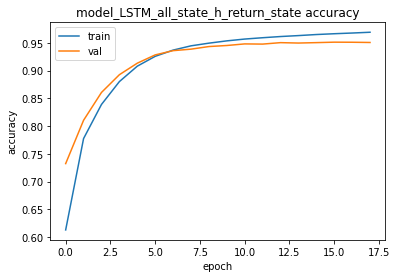

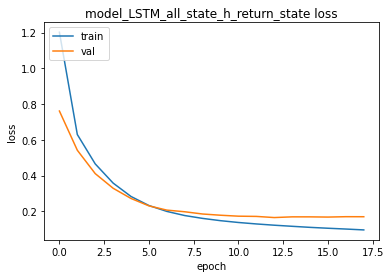

In [29]:
train_test(model_LSTM_return_sequences_return_state, x_train, y_train , x_test, y_test)

In [19]:
# import os.path
# if os.path.isfile('models/LSTM_HIDS.h5') is False:
#     model_LSTM_return_sequences_return_state.save('models/LSTM_HIDS.h5')

In [30]:
# Receives one hot represetation and returns index where value = 1
def one_hot_decode(arr):
    for index,num in enumerate(arr):
        if num == 1:
            return index
        
# Receives an array to append to and a 3D-array that is one hot encoded      
def decode(arr, three_d_array):
    for seq in three_d_array:
        temp = []
        for one_hot in seq:
            temp.append(one_hot_decode(one_hot))
        arr.append(temp)
    
        

In [31]:
# Decodes prediction done by LSTM and stores it in arr.
def prediction_decode(arr, prediction):
    for seq in prediction:
        predict_temp = []
        for one_hot in seq:
            predict_temp.append(argmax(one_hot))
        arr.append(predict_temp)
    
    

In [79]:
# perfect match
from nltk.translate.bleu_score import sentence_bleu
def calc_belu(target, prediction):
    reference = []
    candidate = []
    reference.append(target)
    candidate.extend(prediction)
    return sentence_bleu(reference, candidate, weights=(0, 1))

In [ ]:
# VALIDATION

In [492]:
print(train_validation_data[2])

[195, 195, 195, 195, 5, 3, 168, 168, 168, 160, 168, 5, 4, 3, 45, 168, 168, 168, 168, 265, 168, 265, 265, 265, 265, 265, 3, 265, 265, 3, 265, 168, 146, 168, 146, 265, 265, 168, 168, 265, 265, 265, 265, 265, 168, 265, 265, 146, 168, 265, 168, 146, 3, 265, 168, 168, 265, 78, 3, 265, 168, 265, 265, 168, 3, 168, 197, 45, 45, 265, 78, 78, 78, 5, 3, 195, 6, 195, 3, 3, 78, 195, 3, 3, 195, 6, 195, 195, 195, 195, 195, 195, 195, 220, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 220, 195, 195, 195, 195, 195, 195, 195, 195, 220, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 220, 195, 195, 195, 195, 195, 195, 195, 6, 195, 195, 195, 195, 195, 195, 192, 3, 6, 140, 5, 6, 146, 5, 6, 5, 4, 4, 265, 45, 265, 120, 3, 240, 78, 4, 45, 45, 4, 240, 45, 265, 168]


In [181]:
for i in range(len(train_validation_data)):
    for j in range(len(train_validation_data[i])):
        train_validation_data[i][j] = int(train_validation_data[i][j])

In [420]:
print(len(train_validation_data))

4372


In [216]:
def calc_request_belu_score(request,start,end):
    request_sources = []
    request_targets = []
    request_prediction = []
    request_scores= []
    
    decoded_request_targets = []
    
    while(len(request)-start >= n+m):
        request_sources.append(generate_one_hot(request[start:end]))
        start += m
        end += m
        request_targets.append(request[start:end])
    
    i = 1
    while(i < len(request_sources)):
        prediction_decode( request_prediction, model_LSTM_return_sequences_return_state.predict(request_sources[i-1:i]))
        i += 1
    
    for i in range(len(request_prediction)):
        request_scores.append(calc_belu(request_targets[i],request_prediction[i]))
        
    print(request_scores)
    return request_scores

In [218]:
means = []

for i in range(len(train_validation_data)-2300-1000):
    print(f'{i+1}/{len(train_validation_data)-2300-1000}')
    print('-------------------------------------------------------------------')
    means.append(statistics.mean(calc_request_belu_score(train_validation_data[i],0,n)))
    
    

1/1072
-------------------------------------------------------------------
1 / 967
2 / 967
3 / 967
4 / 967
5 / 967
6 / 967
7 / 967
8 / 967
9 / 967
10 / 967
11 / 967
12 / 967
13 / 967
14 / 967
15 / 967
16 / 967
17 / 967
18 / 967
19 / 967
20 / 967
21 / 967
22 / 967
23 / 967
24 / 967
25 / 967
26 / 967
27 / 967
28 / 967
29 / 967
30 / 967
31 / 967
32 / 967
33 / 967
34 / 967
35 / 967
36 / 967
37 / 967
38 / 967
39 / 967
40 / 967
41 / 967
42 / 967
43 / 967
44 / 967
45 / 967
46 / 967
47 / 967
48 / 967
49 / 967
50 / 967
51 / 967
52 / 967
53 / 967
54 / 967
55 / 967
56 / 967
57 / 967
58 / 967
59 / 967
60 / 967
61 / 967
62 / 967
63 / 967
64 / 967
65 / 967
66 / 967
67 / 967
68 / 967
69 / 967
70 / 967
71 / 967
72 / 967
73 / 967
74 / 967
75 / 967
76 / 967
77 / 967
78 / 967
79 / 967
80 / 967
81 / 967
82 / 967
83 / 967
84 / 967
85 / 967
86 / 967
87 / 967
88 / 967
89 / 967
90 / 967
91 / 967
92 / 967
93 / 967
94 / 967
95 / 967
96 / 967
97 / 967
98 / 967
99 / 967
100 / 967
101 / 967
102 / 967
103 / 967
104

825 / 967
826 / 967
827 / 967
828 / 967
829 / 967
830 / 967
831 / 967
832 / 967
833 / 967
834 / 967
835 / 967
836 / 967
837 / 967
838 / 967
839 / 967
840 / 967
841 / 967
842 / 967
843 / 967
844 / 967
845 / 967
846 / 967
847 / 967
848 / 967
849 / 967
850 / 967
851 / 967
852 / 967
853 / 967
854 / 967
855 / 967
856 / 967
857 / 967
858 / 967
859 / 967
860 / 967
861 / 967
862 / 967
863 / 967
864 / 967
865 / 967
866 / 967
867 / 967
868 / 967
869 / 967
870 / 967
871 / 967
872 / 967
873 / 967
874 / 967
875 / 967
876 / 967
877 / 967
878 / 967
879 / 967
880 / 967
881 / 967
882 / 967
883 / 967
884 / 967
885 / 967
886 / 967
887 / 967
888 / 967
889 / 967
890 / 967
891 / 967
892 / 967
893 / 967
894 / 967
895 / 967
896 / 967
897 / 967
898 / 967
899 / 967
900 / 967
901 / 967
902 / 967
903 / 967
904 / 967
905 / 967
906 / 967
907 / 967
908 / 967
909 / 967
910 / 967
911 / 967
912 / 967
913 / 967
914 / 967
915 / 967
916 / 967
917 / 967
918 / 967
919 / 967
920 / 967
921 / 967
922 / 967
923 / 967
924 / 967


2 / 1193
3 / 1193
4 / 1193
5 / 1193
6 / 1193
7 / 1193
8 / 1193
9 / 1193
10 / 1193
11 / 1193
12 / 1193
13 / 1193
14 / 1193
15 / 1193
16 / 1193
17 / 1193
18 / 1193
19 / 1193
20 / 1193
21 / 1193
22 / 1193
23 / 1193
24 / 1193
25 / 1193
26 / 1193
27 / 1193
28 / 1193
29 / 1193
30 / 1193
31 / 1193
32 / 1193
33 / 1193
34 / 1193
35 / 1193
36 / 1193
37 / 1193
38 / 1193
39 / 1193
40 / 1193
41 / 1193
42 / 1193
43 / 1193
44 / 1193
45 / 1193
46 / 1193
47 / 1193
48 / 1193
49 / 1193
50 / 1193
51 / 1193
52 / 1193
53 / 1193
54 / 1193
55 / 1193
56 / 1193
57 / 1193
58 / 1193
59 / 1193
60 / 1193
61 / 1193
62 / 1193
63 / 1193
64 / 1193
65 / 1193
66 / 1193
67 / 1193
68 / 1193
69 / 1193
70 / 1193
71 / 1193
72 / 1193
73 / 1193
74 / 1193
75 / 1193
76 / 1193
77 / 1193
78 / 1193
79 / 1193
80 / 1193
81 / 1193
82 / 1193
83 / 1193
84 / 1193
85 / 1193
86 / 1193
87 / 1193
88 / 1193
89 / 1193
90 / 1193
91 / 1193
92 / 1193
93 / 1193
94 / 1193
95 / 1193
96 / 1193
97 / 1193
98 / 1193
99 / 1193
100 / 1193
101 / 1193
102 / 

758 / 1193
759 / 1193
760 / 1193
761 / 1193
762 / 1193
763 / 1193
764 / 1193
765 / 1193
766 / 1193
767 / 1193
768 / 1193
769 / 1193
770 / 1193
771 / 1193
772 / 1193
773 / 1193
774 / 1193
775 / 1193
776 / 1193
777 / 1193
778 / 1193
779 / 1193
780 / 1193
781 / 1193
782 / 1193
783 / 1193
784 / 1193
785 / 1193
786 / 1193
787 / 1193
788 / 1193
789 / 1193
790 / 1193
791 / 1193
792 / 1193
793 / 1193
794 / 1193
795 / 1193
796 / 1193
797 / 1193
798 / 1193
799 / 1193
800 / 1193
801 / 1193
802 / 1193
803 / 1193
804 / 1193
805 / 1193
806 / 1193
807 / 1193
808 / 1193
809 / 1193
810 / 1193
811 / 1193
812 / 1193
813 / 1193
814 / 1193
815 / 1193
816 / 1193
817 / 1193
818 / 1193
819 / 1193
820 / 1193
821 / 1193
822 / 1193
823 / 1193
824 / 1193
825 / 1193
826 / 1193
827 / 1193
828 / 1193
829 / 1193
830 / 1193
831 / 1193
832 / 1193
833 / 1193
834 / 1193
835 / 1193
836 / 1193
837 / 1193
838 / 1193
839 / 1193
840 / 1193
841 / 1193
842 / 1193
843 / 1193
844 / 1193
845 / 1193
846 / 1193
847 / 1193
848 / 1193

2 / 82
3 / 82
4 / 82
5 / 82
6 / 82
7 / 82
8 / 82
9 / 82
10 / 82
11 / 82
12 / 82
13 / 82
14 / 82
15 / 82
16 / 82
17 / 82
18 / 82
19 / 82
20 / 82
21 / 82
22 / 82
23 / 82
24 / 82
25 / 82
26 / 82
27 / 82
28 / 82
29 / 82
30 / 82
31 / 82
32 / 82
33 / 82
34 / 82
35 / 82
36 / 82
37 / 82
38 / 82
39 / 82
40 / 82
41 / 82
42 / 82
43 / 82
44 / 82
45 / 82
46 / 82
47 / 82
48 / 82
49 / 82
50 / 82
51 / 82
52 / 82
53 / 82
54 / 82
55 / 82
56 / 82
57 / 82
58 / 82
59 / 82
60 / 82
61 / 82
62 / 82
63 / 82
64 / 82
65 / 82
66 / 82
67 / 82
68 / 82
69 / 82
70 / 82
71 / 82
72 / 82
73 / 82
74 / 82
75 / 82
76 / 82
77 / 82
78 / 82
79 / 82
80 / 82
81 / 82
[0.7142857142857143, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.7857142857142857, 0.9285714285714286, 0.7857142857142857, 0.

2 / 179
3 / 179
4 / 179
5 / 179
6 / 179
7 / 179
8 / 179
9 / 179
10 / 179
11 / 179
12 / 179
13 / 179
14 / 179
15 / 179
16 / 179
17 / 179
18 / 179
19 / 179
20 / 179
21 / 179
22 / 179
23 / 179
24 / 179
25 / 179
26 / 179
27 / 179
28 / 179
29 / 179
30 / 179
31 / 179
32 / 179
33 / 179
34 / 179
35 / 179
36 / 179
37 / 179
38 / 179
39 / 179
40 / 179
41 / 179
42 / 179
43 / 179
44 / 179
45 / 179
46 / 179
47 / 179
48 / 179
49 / 179
50 / 179
51 / 179
52 / 179
53 / 179
54 / 179
55 / 179
56 / 179
57 / 179
58 / 179
59 / 179
60 / 179
61 / 179
62 / 179
63 / 179
64 / 179
65 / 179
66 / 179
67 / 179
68 / 179
69 / 179
70 / 179
71 / 179
72 / 179
73 / 179
74 / 179
75 / 179
76 / 179
77 / 179
78 / 179
79 / 179
80 / 179
81 / 179
82 / 179
83 / 179
84 / 179
85 / 179
86 / 179
87 / 179
88 / 179
89 / 179
90 / 179
91 / 179
92 / 179
93 / 179
94 / 179
95 / 179
96 / 179
97 / 179
98 / 179
99 / 179
100 / 179
101 / 179
102 / 179
103 / 179
104 / 179
105 / 179
106 / 179
107 / 179
108 / 179
109 / 179
110 / 179
111 / 179
112 / 

1 / 86
2 / 86
3 / 86
4 / 86
5 / 86
6 / 86
7 / 86
8 / 86
9 / 86
10 / 86
11 / 86
12 / 86
13 / 86
14 / 86
15 / 86
16 / 86
17 / 86
18 / 86
19 / 86
20 / 86
21 / 86
22 / 86
23 / 86
24 / 86
25 / 86
26 / 86
27 / 86
28 / 86
29 / 86
30 / 86
31 / 86
32 / 86
33 / 86
34 / 86
35 / 86
36 / 86
37 / 86
38 / 86
39 / 86
40 / 86
41 / 86
42 / 86
43 / 86
44 / 86
45 / 86
46 / 86
47 / 86
48 / 86
49 / 86
50 / 86
51 / 86
52 / 86
53 / 86
54 / 86
55 / 86
56 / 86
57 / 86
58 / 86
59 / 86
60 / 86
61 / 86
62 / 86
63 / 86
64 / 86
65 / 86
66 / 86
67 / 86
68 / 86
69 / 86
70 / 86
71 / 86
72 / 86
73 / 86
74 / 86
75 / 86
76 / 86
77 / 86
78 / 86
79 / 86
80 / 86
81 / 86
82 / 86
83 / 86
84 / 86
85 / 86
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.7857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571

1 / 65
2 / 65
3 / 65
4 / 65
5 / 65
6 / 65
7 / 65
8 / 65
9 / 65
10 / 65
11 / 65
12 / 65
13 / 65
14 / 65
15 / 65
16 / 65
17 / 65
18 / 65
19 / 65
20 / 65
21 / 65
22 / 65
23 / 65
24 / 65
25 / 65
26 / 65
27 / 65
28 / 65
29 / 65
30 / 65
31 / 65
32 / 65
33 / 65
34 / 65
35 / 65
36 / 65
37 / 65
38 / 65
39 / 65
40 / 65
41 / 65
42 / 65
43 / 65
44 / 65
45 / 65
46 / 65
47 / 65
48 / 65
49 / 65
50 / 65
51 / 65
52 / 65
53 / 65
54 / 65
55 / 65
56 / 65
57 / 65
58 / 65
59 / 65
60 / 65
61 / 65
62 / 65
63 / 65
64 / 65
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.7857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.85714285714285

528 / 545
529 / 545
530 / 545
531 / 545
532 / 545
533 / 545
534 / 545
535 / 545
536 / 545
537 / 545
538 / 545
539 / 545
540 / 545
541 / 545
542 / 545
543 / 545
544 / 545
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

61 / 97
62 / 97
63 / 97
64 / 97
65 / 97
66 / 97
67 / 97
68 / 97
69 / 97
70 / 97
71 / 97
72 / 97
73 / 97
74 / 97
75 / 97
76 / 97
77 / 97
78 / 97
79 / 97
80 / 97
81 / 97
82 / 97
83 / 97
84 / 97
85 / 97
86 / 97
87 / 97
88 / 97
89 / 97
90 / 97
91 / 97
92 / 97
93 / 97
94 / 97
95 / 97
96 / 97
[1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.5714285714285714, 0.6428571428571429, 0.5714285714285714, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 0.7142857142857143, 0.6428571428571429, 0.8571

131 / 839
132 / 839
133 / 839
134 / 839
135 / 839
136 / 839
137 / 839
138 / 839
139 / 839
140 / 839
141 / 839
142 / 839
143 / 839
144 / 839
145 / 839
146 / 839
147 / 839
148 / 839
149 / 839
150 / 839
151 / 839
152 / 839
153 / 839
154 / 839
155 / 839
156 / 839
157 / 839
158 / 839
159 / 839
160 / 839
161 / 839
162 / 839
163 / 839
164 / 839
165 / 839
166 / 839
167 / 839
168 / 839
169 / 839
170 / 839
171 / 839
172 / 839
173 / 839
174 / 839
175 / 839
176 / 839
177 / 839
178 / 839
179 / 839
180 / 839
181 / 839
182 / 839
183 / 839
184 / 839
185 / 839
186 / 839
187 / 839
188 / 839
189 / 839
190 / 839
191 / 839
192 / 839
193 / 839
194 / 839
195 / 839
196 / 839
197 / 839
198 / 839
199 / 839
200 / 839
201 / 839
202 / 839
203 / 839
204 / 839
205 / 839
206 / 839
207 / 839
208 / 839
209 / 839
210 / 839
211 / 839
212 / 839
213 / 839
214 / 839
215 / 839
216 / 839
217 / 839
218 / 839
219 / 839
220 / 839
221 / 839
222 / 839
223 / 839
224 / 839
225 / 839
226 / 839
227 / 839
228 / 839
229 / 839
230 / 839


1 / 89
2 / 89
3 / 89
4 / 89
5 / 89
6 / 89
7 / 89
8 / 89
9 / 89
10 / 89
11 / 89
12 / 89
13 / 89
14 / 89
15 / 89
16 / 89
17 / 89
18 / 89
19 / 89
20 / 89
21 / 89
22 / 89
23 / 89
24 / 89
25 / 89
26 / 89
27 / 89
28 / 89
29 / 89
30 / 89
31 / 89
32 / 89
33 / 89
34 / 89
35 / 89
36 / 89
37 / 89
38 / 89
39 / 89
40 / 89
41 / 89
42 / 89
43 / 89
44 / 89
45 / 89
46 / 89
47 / 89
48 / 89
49 / 89
50 / 89
51 / 89
52 / 89
53 / 89
54 / 89
55 / 89
56 / 89
57 / 89
58 / 89
59 / 89
60 / 89
61 / 89
62 / 89
63 / 89
64 / 89
65 / 89
66 / 89
67 / 89
68 / 89
69 / 89
70 / 89
71 / 89
72 / 89
73 / 89
74 / 89
75 / 89
76 / 89
77 / 89
78 / 89
79 / 89
80 / 89
81 / 89
82 / 89
83 / 89
84 / 89
85 / 89
86 / 89
87 / 89
88 / 89
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.857142857142

2 / 76
3 / 76
4 / 76
5 / 76
6 / 76
7 / 76
8 / 76
9 / 76
10 / 76
11 / 76
12 / 76
13 / 76
14 / 76
15 / 76
16 / 76
17 / 76
18 / 76
19 / 76
20 / 76
21 / 76
22 / 76
23 / 76
24 / 76
25 / 76
26 / 76
27 / 76
28 / 76
29 / 76
30 / 76
31 / 76
32 / 76
33 / 76
34 / 76
35 / 76
36 / 76
37 / 76
38 / 76
39 / 76
40 / 76
41 / 76
42 / 76
43 / 76
44 / 76
45 / 76
46 / 76
47 / 76
48 / 76
49 / 76
50 / 76
51 / 76
52 / 76
53 / 76
54 / 76
55 / 76
56 / 76
57 / 76
58 / 76
59 / 76
60 / 76
61 / 76
62 / 76
63 / 76
64 / 76
65 / 76
66 / 76
67 / 76
68 / 76
69 / 76
70 / 76
71 / 76
72 / 76
73 / 76
74 / 76
75 / 76
[0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.5714285714285714, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.5714285714285714, 0.5, 0.5, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.5714285714285714, 1.0, 1.0, 0.7857142857142

13 / 47
14 / 47
15 / 47
16 / 47
17 / 47
18 / 47
19 / 47
20 / 47
21 / 47
22 / 47
23 / 47
24 / 47
25 / 47
26 / 47
27 / 47
28 / 47
29 / 47
30 / 47
31 / 47
32 / 47
33 / 47
34 / 47
35 / 47
36 / 47
37 / 47
38 / 47
39 / 47
40 / 47
41 / 47
42 / 47
43 / 47
44 / 47
45 / 47
46 / 47
[1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.7142857142857143]
34/1072
-------------------------------------------------------------------
1 / 157
2 / 157
3 / 157
4 / 157
5 / 157
6 / 157
7 / 157
8 / 157
9 / 157
10 / 157
11 / 157
12 / 157
13 / 157
14 / 157
15 / 157
16 / 157
17 / 157
18 / 157
19 / 157
20 / 157
21 / 157
22 / 157
23 / 157
24 / 157
25 / 157
26 / 157
27 / 157
28 / 157
29 / 157
30 / 157
31 / 157
32 / 157
33 / 157
34 / 157
35 /

3 / 47
4 / 47
5 / 47
6 / 47
7 / 47
8 / 47
9 / 47
10 / 47
11 / 47
12 / 47
13 / 47
14 / 47
15 / 47
16 / 47
17 / 47
18 / 47
19 / 47
20 / 47
21 / 47
22 / 47
23 / 47
24 / 47
25 / 47
26 / 47
27 / 47
28 / 47
29 / 47
30 / 47
31 / 47
32 / 47
33 / 47
34 / 47
35 / 47
36 / 47
37 / 47
38 / 47
39 / 47
40 / 47
41 / 47
42 / 47
43 / 47
44 / 47
45 / 47
46 / 47
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0]
39/1072
-------------------------------------------------------------------
1 / 307
2 / 307
3 / 307
4 / 307
5 / 307
6 / 307
7 / 307
8 / 307
9 / 307
10 / 307
11 / 307
12 / 307
13 / 307
14 / 307
15 / 307
16 / 307
17 / 307
18 / 307
19 / 307
20 / 307
21 / 307
22 / 307
23 / 307
24 / 307
25 / 307
26 / 307
27 / 307
28 / 307
29 / 307
30 / 3

1 / 143
2 / 143
3 / 143
4 / 143
5 / 143
6 / 143
7 / 143
8 / 143
9 / 143
10 / 143
11 / 143
12 / 143
13 / 143
14 / 143
15 / 143
16 / 143
17 / 143
18 / 143
19 / 143
20 / 143
21 / 143
22 / 143
23 / 143
24 / 143
25 / 143
26 / 143
27 / 143
28 / 143
29 / 143
30 / 143
31 / 143
32 / 143
33 / 143
34 / 143
35 / 143
36 / 143
37 / 143
38 / 143
39 / 143
40 / 143
41 / 143
42 / 143
43 / 143
44 / 143
45 / 143
46 / 143
47 / 143
48 / 143
49 / 143
50 / 143
51 / 143
52 / 143
53 / 143
54 / 143
55 / 143
56 / 143
57 / 143
58 / 143
59 / 143
60 / 143
61 / 143
62 / 143
63 / 143
64 / 143
65 / 143
66 / 143
67 / 143
68 / 143
69 / 143
70 / 143
71 / 143
72 / 143
73 / 143
74 / 143
75 / 143
76 / 143
77 / 143
78 / 143
79 / 143
80 / 143
81 / 143
82 / 143
83 / 143
84 / 143
85 / 143
86 / 143
87 / 143
88 / 143
89 / 143
90 / 143
91 / 143
92 / 143
93 / 143
94 / 143
95 / 143
96 / 143
97 / 143
98 / 143
99 / 143
100 / 143
101 / 143
102 / 143
103 / 143
104 / 143
105 / 143
106 / 143
107 / 143
108 / 143
109 / 143
110 / 143
111 / 14

10 / 133
11 / 133
12 / 133
13 / 133
14 / 133
15 / 133
16 / 133
17 / 133
18 / 133
19 / 133
20 / 133
21 / 133
22 / 133
23 / 133
24 / 133
25 / 133
26 / 133
27 / 133
28 / 133
29 / 133
30 / 133
31 / 133
32 / 133
33 / 133
34 / 133
35 / 133
36 / 133
37 / 133
38 / 133
39 / 133
40 / 133
41 / 133
42 / 133
43 / 133
44 / 133
45 / 133
46 / 133
47 / 133
48 / 133
49 / 133
50 / 133
51 / 133
52 / 133
53 / 133
54 / 133
55 / 133
56 / 133
57 / 133
58 / 133
59 / 133
60 / 133
61 / 133
62 / 133
63 / 133
64 / 133
65 / 133
66 / 133
67 / 133
68 / 133
69 / 133
70 / 133
71 / 133
72 / 133
73 / 133
74 / 133
75 / 133
76 / 133
77 / 133
78 / 133
79 / 133
80 / 133
81 / 133
82 / 133
83 / 133
84 / 133
85 / 133
86 / 133
87 / 133
88 / 133
89 / 133
90 / 133
91 / 133
92 / 133
93 / 133
94 / 133
95 / 133
96 / 133
97 / 133
98 / 133
99 / 133
100 / 133
101 / 133
102 / 133
103 / 133
104 / 133
105 / 133
106 / 133
107 / 133
108 / 133
109 / 133
110 / 133
111 / 133
112 / 133
113 / 133
114 / 133
115 / 133
116 / 133
117 / 133
118 / 133


1 / 67
2 / 67
3 / 67
4 / 67
5 / 67
6 / 67
7 / 67
8 / 67
9 / 67
10 / 67
11 / 67
12 / 67
13 / 67
14 / 67
15 / 67
16 / 67
17 / 67
18 / 67
19 / 67
20 / 67
21 / 67
22 / 67
23 / 67
24 / 67
25 / 67
26 / 67
27 / 67
28 / 67
29 / 67
30 / 67
31 / 67
32 / 67
33 / 67
34 / 67
35 / 67
36 / 67
37 / 67
38 / 67
39 / 67
40 / 67
41 / 67
42 / 67
43 / 67
44 / 67
45 / 67
46 / 67
47 / 67
48 / 67
49 / 67
50 / 67
51 / 67
52 / 67
53 / 67
54 / 67
55 / 67
56 / 67
57 / 67
58 / 67
59 / 67
60 / 67
61 / 67
62 / 67
63 / 67
64 / 67
65 / 67
66 / 67
[0.7142857142857143, 0.6428571428571429, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.71428571

1 / 239
2 / 239
3 / 239
4 / 239
5 / 239
6 / 239
7 / 239
8 / 239
9 / 239
10 / 239
11 / 239
12 / 239
13 / 239
14 / 239
15 / 239
16 / 239
17 / 239
18 / 239
19 / 239
20 / 239
21 / 239
22 / 239
23 / 239
24 / 239
25 / 239
26 / 239
27 / 239
28 / 239
29 / 239
30 / 239
31 / 239
32 / 239
33 / 239
34 / 239
35 / 239
36 / 239
37 / 239
38 / 239
39 / 239
40 / 239
41 / 239
42 / 239
43 / 239
44 / 239
45 / 239
46 / 239
47 / 239
48 / 239
49 / 239
50 / 239
51 / 239
52 / 239
53 / 239
54 / 239
55 / 239
56 / 239
57 / 239
58 / 239
59 / 239
60 / 239
61 / 239
62 / 239
63 / 239
64 / 239
65 / 239
66 / 239
67 / 239
68 / 239
69 / 239
70 / 239
71 / 239
72 / 239
73 / 239
74 / 239
75 / 239
76 / 239
77 / 239
78 / 239
79 / 239
80 / 239
81 / 239
82 / 239
83 / 239
84 / 239
85 / 239
86 / 239
87 / 239
88 / 239
89 / 239
90 / 239
91 / 239
92 / 239
93 / 239
94 / 239
95 / 239
96 / 239
97 / 239
98 / 239
99 / 239
100 / 239
101 / 239
102 / 239
103 / 239
104 / 239
105 / 239
106 / 239
107 / 239
108 / 239
109 / 239
110 / 239
111 / 23

145 / 838
146 / 838
147 / 838
148 / 838
149 / 838
150 / 838
151 / 838
152 / 838
153 / 838
154 / 838
155 / 838
156 / 838
157 / 838
158 / 838
159 / 838
160 / 838
161 / 838
162 / 838
163 / 838
164 / 838
165 / 838
166 / 838
167 / 838
168 / 838
169 / 838
170 / 838
171 / 838
172 / 838
173 / 838
174 / 838
175 / 838
176 / 838
177 / 838
178 / 838
179 / 838
180 / 838
181 / 838
182 / 838
183 / 838
184 / 838
185 / 838
186 / 838
187 / 838
188 / 838
189 / 838
190 / 838
191 / 838
192 / 838
193 / 838
194 / 838
195 / 838
196 / 838
197 / 838
198 / 838
199 / 838
200 / 838
201 / 838
202 / 838
203 / 838
204 / 838
205 / 838
206 / 838
207 / 838
208 / 838
209 / 838
210 / 838
211 / 838
212 / 838
213 / 838
214 / 838
215 / 838
216 / 838
217 / 838
218 / 838
219 / 838
220 / 838
221 / 838
222 / 838
223 / 838
224 / 838
225 / 838
226 / 838
227 / 838
228 / 838
229 / 838
230 / 838
231 / 838
232 / 838
233 / 838
234 / 838
235 / 838
236 / 838
237 / 838
238 / 838
239 / 838
240 / 838
241 / 838
242 / 838
243 / 838
244 / 838


1 / 122
2 / 122
3 / 122
4 / 122
5 / 122
6 / 122
7 / 122
8 / 122
9 / 122
10 / 122
11 / 122
12 / 122
13 / 122
14 / 122
15 / 122
16 / 122
17 / 122
18 / 122
19 / 122
20 / 122
21 / 122
22 / 122
23 / 122
24 / 122
25 / 122
26 / 122
27 / 122
28 / 122
29 / 122
30 / 122
31 / 122
32 / 122
33 / 122
34 / 122
35 / 122
36 / 122
37 / 122
38 / 122
39 / 122
40 / 122
41 / 122
42 / 122
43 / 122
44 / 122
45 / 122
46 / 122
47 / 122
48 / 122
49 / 122
50 / 122
51 / 122
52 / 122
53 / 122
54 / 122
55 / 122
56 / 122
57 / 122
58 / 122
59 / 122
60 / 122
61 / 122
62 / 122
63 / 122
64 / 122
65 / 122
66 / 122
67 / 122
68 / 122
69 / 122
70 / 122
71 / 122
72 / 122
73 / 122
74 / 122
75 / 122
76 / 122
77 / 122
78 / 122
79 / 122
80 / 122
81 / 122
82 / 122
83 / 122
84 / 122
85 / 122
86 / 122
87 / 122
88 / 122
89 / 122
90 / 122
91 / 122
92 / 122
93 / 122
94 / 122
95 / 122
96 / 122
97 / 122
98 / 122
99 / 122
100 / 122
101 / 122
102 / 122
103 / 122
104 / 122
105 / 122
106 / 122
107 / 122
108 / 122
109 / 122
110 / 122
111 / 12

491 / 692
492 / 692
493 / 692
494 / 692
495 / 692
496 / 692
497 / 692
498 / 692
499 / 692
500 / 692
501 / 692
502 / 692
503 / 692
504 / 692
505 / 692
506 / 692
507 / 692
508 / 692
509 / 692
510 / 692
511 / 692
512 / 692
513 / 692
514 / 692
515 / 692
516 / 692
517 / 692
518 / 692
519 / 692
520 / 692
521 / 692
522 / 692
523 / 692
524 / 692
525 / 692
526 / 692
527 / 692
528 / 692
529 / 692
530 / 692
531 / 692
532 / 692
533 / 692
534 / 692
535 / 692
536 / 692
537 / 692
538 / 692
539 / 692
540 / 692
541 / 692
542 / 692
543 / 692
544 / 692
545 / 692
546 / 692
547 / 692
548 / 692
549 / 692
550 / 692
551 / 692
552 / 692
553 / 692
554 / 692
555 / 692
556 / 692
557 / 692
558 / 692
559 / 692
560 / 692
561 / 692
562 / 692
563 / 692
564 / 692
565 / 692
566 / 692
567 / 692
568 / 692
569 / 692
570 / 692
571 / 692
572 / 692
573 / 692
574 / 692
575 / 692
576 / 692
577 / 692
578 / 692
579 / 692
580 / 692
581 / 692
582 / 692
583 / 692
584 / 692
585 / 692
586 / 692
587 / 692
588 / 692
589 / 692
590 / 692


2 / 284
3 / 284
4 / 284
5 / 284
6 / 284
7 / 284
8 / 284
9 / 284
10 / 284
11 / 284
12 / 284
13 / 284
14 / 284
15 / 284
16 / 284
17 / 284
18 / 284
19 / 284
20 / 284
21 / 284
22 / 284
23 / 284
24 / 284
25 / 284
26 / 284
27 / 284
28 / 284
29 / 284
30 / 284
31 / 284
32 / 284
33 / 284
34 / 284
35 / 284
36 / 284
37 / 284
38 / 284
39 / 284
40 / 284
41 / 284
42 / 284
43 / 284
44 / 284
45 / 284
46 / 284
47 / 284
48 / 284
49 / 284
50 / 284
51 / 284
52 / 284
53 / 284
54 / 284
55 / 284
56 / 284
57 / 284
58 / 284
59 / 284
60 / 284
61 / 284
62 / 284
63 / 284
64 / 284
65 / 284
66 / 284
67 / 284
68 / 284
69 / 284
70 / 284
71 / 284
72 / 284
73 / 284
74 / 284
75 / 284
76 / 284
77 / 284
78 / 284
79 / 284
80 / 284
81 / 284
82 / 284
83 / 284
84 / 284
85 / 284
86 / 284
87 / 284
88 / 284
89 / 284
90 / 284
91 / 284
92 / 284
93 / 284
94 / 284
95 / 284
96 / 284
97 / 284
98 / 284
99 / 284
100 / 284
101 / 284
102 / 284
103 / 284
104 / 284
105 / 284
106 / 284
107 / 284
108 / 284
109 / 284
110 / 284
111 / 284
112 / 

42 / 745
43 / 745
44 / 745
45 / 745
46 / 745
47 / 745
48 / 745
49 / 745
50 / 745
51 / 745
52 / 745
53 / 745
54 / 745
55 / 745
56 / 745
57 / 745
58 / 745
59 / 745
60 / 745
61 / 745
62 / 745
63 / 745
64 / 745
65 / 745
66 / 745
67 / 745
68 / 745
69 / 745
70 / 745
71 / 745
72 / 745
73 / 745
74 / 745
75 / 745
76 / 745
77 / 745
78 / 745
79 / 745
80 / 745
81 / 745
82 / 745
83 / 745
84 / 745
85 / 745
86 / 745
87 / 745
88 / 745
89 / 745
90 / 745
91 / 745
92 / 745
93 / 745
94 / 745
95 / 745
96 / 745
97 / 745
98 / 745
99 / 745
100 / 745
101 / 745
102 / 745
103 / 745
104 / 745
105 / 745
106 / 745
107 / 745
108 / 745
109 / 745
110 / 745
111 / 745
112 / 745
113 / 745
114 / 745
115 / 745
116 / 745
117 / 745
118 / 745
119 / 745
120 / 745
121 / 745
122 / 745
123 / 745
124 / 745
125 / 745
126 / 745
127 / 745
128 / 745
129 / 745
130 / 745
131 / 745
132 / 745
133 / 745
134 / 745
135 / 745
136 / 745
137 / 745
138 / 745
139 / 745
140 / 745
141 / 745
142 / 745
143 / 745
144 / 745
145 / 745
146 / 745
147 / 74

1 / 46
2 / 46
3 / 46
4 / 46
5 / 46
6 / 46
7 / 46
8 / 46
9 / 46
10 / 46
11 / 46
12 / 46
13 / 46
14 / 46
15 / 46
16 / 46
17 / 46
18 / 46
19 / 46
20 / 46
21 / 46
22 / 46
23 / 46
24 / 46
25 / 46
26 / 46
27 / 46
28 / 46
29 / 46
30 / 46
31 / 46
32 / 46
33 / 46
34 / 46
35 / 46
36 / 46
37 / 46
38 / 46
39 / 46
40 / 46
41 / 46
42 / 46
43 / 46
44 / 46
45 / 46
[0.42857142857142855, 0.6428571428571429, 0.7857142857142857, 0.7142857142857143, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.7857142857142857, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.5714285714285714, 0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.5714285714285714, 0.7142857142857143]
60/1072
---------

580 / 643
581 / 643
582 / 643
583 / 643
584 / 643
585 / 643
586 / 643
587 / 643
588 / 643
589 / 643
590 / 643
591 / 643
592 / 643
593 / 643
594 / 643
595 / 643
596 / 643
597 / 643
598 / 643
599 / 643
600 / 643
601 / 643
602 / 643
603 / 643
604 / 643
605 / 643
606 / 643
607 / 643
608 / 643
609 / 643
610 / 643
611 / 643
612 / 643
613 / 643
614 / 643
615 / 643
616 / 643
617 / 643
618 / 643
619 / 643
620 / 643
621 / 643
622 / 643
623 / 643
624 / 643
625 / 643
626 / 643
627 / 643
628 / 643
629 / 643
630 / 643
631 / 643
632 / 643
633 / 643
634 / 643
635 / 643
636 / 643
637 / 643
638 / 643
639 / 643
640 / 643
641 / 643
642 / 643
[0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.85

2 / 190
3 / 190
4 / 190
5 / 190
6 / 190
7 / 190
8 / 190
9 / 190
10 / 190
11 / 190
12 / 190
13 / 190
14 / 190
15 / 190
16 / 190
17 / 190
18 / 190
19 / 190
20 / 190
21 / 190
22 / 190
23 / 190
24 / 190
25 / 190
26 / 190
27 / 190
28 / 190
29 / 190
30 / 190
31 / 190
32 / 190
33 / 190
34 / 190
35 / 190
36 / 190
37 / 190
38 / 190
39 / 190
40 / 190
41 / 190
42 / 190
43 / 190
44 / 190
45 / 190
46 / 190
47 / 190
48 / 190
49 / 190
50 / 190
51 / 190
52 / 190
53 / 190
54 / 190
55 / 190
56 / 190
57 / 190
58 / 190
59 / 190
60 / 190
61 / 190
62 / 190
63 / 190
64 / 190
65 / 190
66 / 190
67 / 190
68 / 190
69 / 190
70 / 190
71 / 190
72 / 190
73 / 190
74 / 190
75 / 190
76 / 190
77 / 190
78 / 190
79 / 190
80 / 190
81 / 190
82 / 190
83 / 190
84 / 190
85 / 190
86 / 190
87 / 190
88 / 190
89 / 190
90 / 190
91 / 190
92 / 190
93 / 190
94 / 190
95 / 190
96 / 190
97 / 190
98 / 190
99 / 190
100 / 190
101 / 190
102 / 190
103 / 190
104 / 190
105 / 190
106 / 190
107 / 190
108 / 190
109 / 190
110 / 190
111 / 190
112 / 

3 / 84
4 / 84
5 / 84
6 / 84
7 / 84
8 / 84
9 / 84
10 / 84
11 / 84
12 / 84
13 / 84
14 / 84
15 / 84
16 / 84
17 / 84
18 / 84
19 / 84
20 / 84
21 / 84
22 / 84
23 / 84
24 / 84
25 / 84
26 / 84
27 / 84
28 / 84
29 / 84
30 / 84
31 / 84
32 / 84
33 / 84
34 / 84
35 / 84
36 / 84
37 / 84
38 / 84
39 / 84
40 / 84
41 / 84
42 / 84
43 / 84
44 / 84
45 / 84
46 / 84
47 / 84
48 / 84
49 / 84
50 / 84
51 / 84
52 / 84
53 / 84
54 / 84
55 / 84
56 / 84
57 / 84
58 / 84
59 / 84
60 / 84
61 / 84
62 / 84
63 / 84
64 / 84
65 / 84
66 / 84
67 / 84
68 / 84
69 / 84
70 / 84
71 / 84
72 / 84
73 / 84
74 / 84
75 / 84
76 / 84
77 / 84
78 / 84
79 / 84
80 / 84
81 / 84
82 / 84
83 / 84
[0.9285714285714286, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.6428571428571429, 0.5, 0.7857142857142857, 0.5714285714285714, 0.42857142857142855, 0.7142857142857143, 0.6428571428571429, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.42857142857142855, 0.5, 0.5714285714285714, 0.7142857142857143, 0.5, 0

4 / 32
5 / 32
6 / 32
7 / 32
8 / 32
9 / 32
10 / 32
11 / 32
12 / 32
13 / 32
14 / 32
15 / 32
16 / 32
17 / 32
18 / 32
19 / 32
20 / 32
21 / 32
22 / 32
23 / 32
24 / 32
25 / 32
26 / 32
27 / 32
28 / 32
29 / 32
30 / 32
31 / 32
[0.9285714285714286, 0.7857142857142857, 0.9285714285714286, 0.7857142857142857, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.7857142857142857, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 0.7857142857142857, 0.9285714285714286, 0.7857142857142857, 0.7857142857142857, 0.9285714285714286, 0.9285714285714286, 1.0]
67/1072
-------------------------------------------------------------------
1 / 57
2 / 57
3 / 57
4 / 57
5 / 57
6 / 57
7 / 57
8 / 57
9 / 57
10 / 57
11 / 57
12 / 57
13 / 57
14 / 57
15 / 57
16 / 57
17 / 57
18 / 57
19 / 57
20 / 57
21 / 57
22 / 57
23 / 57
24 / 57
25 / 57
26 / 57
27 / 57
28 / 57
29 / 57
30 / 57
31 / 57
32 / 57
33 / 57
34 / 57
35

92 / 128
93 / 128
94 / 128
95 / 128
96 / 128
97 / 128
98 / 128
99 / 128
100 / 128
101 / 128
102 / 128
103 / 128
104 / 128
105 / 128
106 / 128
107 / 128
108 / 128
109 / 128
110 / 128
111 / 128
112 / 128
113 / 128
114 / 128
115 / 128
116 / 128
117 / 128
118 / 128
119 / 128
120 / 128
121 / 128
122 / 128
123 / 128
124 / 128
125 / 128
126 / 128
127 / 128
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
72/1072
----

2 / 150
3 / 150
4 / 150
5 / 150
6 / 150
7 / 150
8 / 150
9 / 150
10 / 150
11 / 150
12 / 150
13 / 150
14 / 150
15 / 150
16 / 150
17 / 150
18 / 150
19 / 150
20 / 150
21 / 150
22 / 150
23 / 150
24 / 150
25 / 150
26 / 150
27 / 150
28 / 150
29 / 150
30 / 150
31 / 150
32 / 150
33 / 150
34 / 150
35 / 150
36 / 150
37 / 150
38 / 150
39 / 150
40 / 150
41 / 150
42 / 150
43 / 150
44 / 150
45 / 150
46 / 150
47 / 150
48 / 150
49 / 150
50 / 150
51 / 150
52 / 150
53 / 150
54 / 150
55 / 150
56 / 150
57 / 150
58 / 150
59 / 150
60 / 150
61 / 150
62 / 150
63 / 150
64 / 150
65 / 150
66 / 150
67 / 150
68 / 150
69 / 150
70 / 150
71 / 150
72 / 150
73 / 150
74 / 150
75 / 150
76 / 150
77 / 150
78 / 150
79 / 150
80 / 150
81 / 150
82 / 150
83 / 150
84 / 150
85 / 150
86 / 150
87 / 150
88 / 150
89 / 150
90 / 150
91 / 150
92 / 150
93 / 150
94 / 150
95 / 150
96 / 150
97 / 150
98 / 150
99 / 150
100 / 150
101 / 150
102 / 150
103 / 150
104 / 150
105 / 150
106 / 150
107 / 150
108 / 150
109 / 150
110 / 150
111 / 150
112 / 

3 / 86
4 / 86
5 / 86
6 / 86
7 / 86
8 / 86
9 / 86
10 / 86
11 / 86
12 / 86
13 / 86
14 / 86
15 / 86
16 / 86
17 / 86
18 / 86
19 / 86
20 / 86
21 / 86
22 / 86
23 / 86
24 / 86
25 / 86
26 / 86
27 / 86
28 / 86
29 / 86
30 / 86
31 / 86
32 / 86
33 / 86
34 / 86
35 / 86
36 / 86
37 / 86
38 / 86
39 / 86
40 / 86
41 / 86
42 / 86
43 / 86
44 / 86
45 / 86
46 / 86
47 / 86
48 / 86
49 / 86
50 / 86
51 / 86
52 / 86
53 / 86
54 / 86
55 / 86
56 / 86
57 / 86
58 / 86
59 / 86
60 / 86
61 / 86
62 / 86
63 / 86
64 / 86
65 / 86
66 / 86
67 / 86
68 / 86
69 / 86
70 / 86
71 / 86
72 / 86
73 / 86
74 / 86
75 / 86
76 / 86
77 / 86
78 / 86
79 / 86
80 / 86
81 / 86
82 / 86
83 / 86
84 / 86
85 / 86
[0.7142857142857143, 0.5, 0.7857142857142857, 0.6428571428571429, 0.5714285714285714, 0.5, 0.5714285714285714, 0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.7857142857142857, 0.7857142857142857, 0.7142857142857143, 0.5714285714285714, 0.7142857142

3 / 42
4 / 42
5 / 42
6 / 42
7 / 42
8 / 42
9 / 42
10 / 42
11 / 42
12 / 42
13 / 42
14 / 42
15 / 42
16 / 42
17 / 42
18 / 42
19 / 42
20 / 42
21 / 42
22 / 42
23 / 42
24 / 42
25 / 42
26 / 42
27 / 42
28 / 42
29 / 42
30 / 42
31 / 42
32 / 42
33 / 42
34 / 42
35 / 42
36 / 42
37 / 42
38 / 42
39 / 42
40 / 42
41 / 42
[0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 0.7142857142857143, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.9285714285714286, 1.0, 0.8571428571428571]
83/1072
-------------------------------------------------------------

192 / 196
193 / 196
194 / 196
195 / 196
[0.9285714285714286, 0.7857142857142857, 0.7857142857142857, 0.6428571428571429, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.9285714285714286, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.5714285714285714, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.9285714285714286, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.5714285714285714, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.5, 0.7857142857142857, 0.8571428571428571, 0.5714285714285714, 0.7142857142857143, 0.7857142857142857, 0.7857142857142857, 0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.5714285714285714, 0.7142857142857143, 0.6428571428571429, 0.8571428571428571, 0.8571428571428571, 0.857142857142

1 / 41
2 / 41
3 / 41
4 / 41
5 / 41
6 / 41
7 / 41
8 / 41
9 / 41
10 / 41
11 / 41
12 / 41
13 / 41
14 / 41
15 / 41
16 / 41
17 / 41
18 / 41
19 / 41
20 / 41
21 / 41
22 / 41
23 / 41
24 / 41
25 / 41
26 / 41
27 / 41
28 / 41
29 / 41
30 / 41
31 / 41
32 / 41
33 / 41
34 / 41
35 / 41
36 / 41
37 / 41
38 / 41
39 / 41
40 / 41
[0.7857142857142857, 0.5714285714285714, 0.7142857142857143, 0.7857142857142857, 0.7857142857142857, 0.5, 0.5, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.6428571428571429, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.7857142857142857, 0.7142857142857143, 0.5714285714285714, 0.7142857142857143, 0.5714285714285714, 0.5714285714285714, 0.6428571428571429, 0.5, 0.5714285714285714, 0.42857142857142855, 0.6428571428571429, 0.5714285714285714, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.6428571428571429, 0.6428571428

718 / 884
719 / 884
720 / 884
721 / 884
722 / 884
723 / 884
724 / 884
725 / 884
726 / 884
727 / 884
728 / 884
729 / 884
730 / 884
731 / 884
732 / 884
733 / 884
734 / 884
735 / 884
736 / 884
737 / 884
738 / 884
739 / 884
740 / 884
741 / 884
742 / 884
743 / 884
744 / 884
745 / 884
746 / 884
747 / 884
748 / 884
749 / 884
750 / 884
751 / 884
752 / 884
753 / 884
754 / 884
755 / 884
756 / 884
757 / 884
758 / 884
759 / 884
760 / 884
761 / 884
762 / 884
763 / 884
764 / 884
765 / 884
766 / 884
767 / 884
768 / 884
769 / 884
770 / 884
771 / 884
772 / 884
773 / 884
774 / 884
775 / 884
776 / 884
777 / 884
778 / 884
779 / 884
780 / 884
781 / 884
782 / 884
783 / 884
784 / 884
785 / 884
786 / 884
787 / 884
788 / 884
789 / 884
790 / 884
791 / 884
792 / 884
793 / 884
794 / 884
795 / 884
796 / 884
797 / 884
798 / 884
799 / 884
800 / 884
801 / 884
802 / 884
803 / 884
804 / 884
805 / 884
806 / 884
807 / 884
808 / 884
809 / 884
810 / 884
811 / 884
812 / 884
813 / 884
814 / 884
815 / 884
816 / 884
817 / 884


4 / 198
5 / 198
6 / 198
7 / 198
8 / 198
9 / 198
10 / 198
11 / 198
12 / 198
13 / 198
14 / 198
15 / 198
16 / 198
17 / 198
18 / 198
19 / 198
20 / 198
21 / 198
22 / 198
23 / 198
24 / 198
25 / 198
26 / 198
27 / 198
28 / 198
29 / 198
30 / 198
31 / 198
32 / 198
33 / 198
34 / 198
35 / 198
36 / 198
37 / 198
38 / 198
39 / 198
40 / 198
41 / 198
42 / 198
43 / 198
44 / 198
45 / 198
46 / 198
47 / 198
48 / 198
49 / 198
50 / 198
51 / 198
52 / 198
53 / 198
54 / 198
55 / 198
56 / 198
57 / 198
58 / 198
59 / 198
60 / 198
61 / 198
62 / 198
63 / 198
64 / 198
65 / 198
66 / 198
67 / 198
68 / 198
69 / 198
70 / 198
71 / 198
72 / 198
73 / 198
74 / 198
75 / 198
76 / 198
77 / 198
78 / 198
79 / 198
80 / 198
81 / 198
82 / 198
83 / 198
84 / 198
85 / 198
86 / 198
87 / 198
88 / 198
89 / 198
90 / 198
91 / 198
92 / 198
93 / 198
94 / 198
95 / 198
96 / 198
97 / 198
98 / 198
99 / 198
100 / 198
101 / 198
102 / 198
103 / 198
104 / 198
105 / 198
106 / 198
107 / 198
108 / 198
109 / 198
110 / 198
111 / 198
112 / 198
113 / 198
11

138 / 833
139 / 833
140 / 833
141 / 833
142 / 833
143 / 833
144 / 833
145 / 833
146 / 833
147 / 833
148 / 833
149 / 833
150 / 833
151 / 833
152 / 833
153 / 833
154 / 833
155 / 833
156 / 833
157 / 833
158 / 833
159 / 833
160 / 833
161 / 833
162 / 833
163 / 833
164 / 833
165 / 833
166 / 833
167 / 833
168 / 833
169 / 833
170 / 833
171 / 833
172 / 833
173 / 833
174 / 833
175 / 833
176 / 833
177 / 833
178 / 833
179 / 833
180 / 833
181 / 833
182 / 833
183 / 833
184 / 833
185 / 833
186 / 833
187 / 833
188 / 833
189 / 833
190 / 833
191 / 833
192 / 833
193 / 833
194 / 833
195 / 833
196 / 833
197 / 833
198 / 833
199 / 833
200 / 833
201 / 833
202 / 833
203 / 833
204 / 833
205 / 833
206 / 833
207 / 833
208 / 833
209 / 833
210 / 833
211 / 833
212 / 833
213 / 833
214 / 833
215 / 833
216 / 833
217 / 833
218 / 833
219 / 833
220 / 833
221 / 833
222 / 833
223 / 833
224 / 833
225 / 833
226 / 833
227 / 833
228 / 833
229 / 833
230 / 833
231 / 833
232 / 833
233 / 833
234 / 833
235 / 833
236 / 833
237 / 833


4 / 44
5 / 44
6 / 44
7 / 44
8 / 44
9 / 44
10 / 44
11 / 44
12 / 44
13 / 44
14 / 44
15 / 44
16 / 44
17 / 44
18 / 44
19 / 44
20 / 44
21 / 44
22 / 44
23 / 44
24 / 44
25 / 44
26 / 44
27 / 44
28 / 44
29 / 44
30 / 44
31 / 44
32 / 44
33 / 44
34 / 44
35 / 44
36 / 44
37 / 44
38 / 44
39 / 44
40 / 44
41 / 44
42 / 44
43 / 44
[0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 1.0, 1.0, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.85714285

657 / 1307
658 / 1307
659 / 1307
660 / 1307
661 / 1307
662 / 1307
663 / 1307
664 / 1307
665 / 1307
666 / 1307
667 / 1307
668 / 1307
669 / 1307
670 / 1307
671 / 1307
672 / 1307
673 / 1307
674 / 1307
675 / 1307
676 / 1307
677 / 1307
678 / 1307
679 / 1307
680 / 1307
681 / 1307
682 / 1307
683 / 1307
684 / 1307
685 / 1307
686 / 1307
687 / 1307
688 / 1307
689 / 1307
690 / 1307
691 / 1307
692 / 1307
693 / 1307
694 / 1307
695 / 1307
696 / 1307
697 / 1307
698 / 1307
699 / 1307
700 / 1307
701 / 1307
702 / 1307
703 / 1307
704 / 1307
705 / 1307
706 / 1307
707 / 1307
708 / 1307
709 / 1307
710 / 1307
711 / 1307
712 / 1307
713 / 1307
714 / 1307
715 / 1307
716 / 1307
717 / 1307
718 / 1307
719 / 1307
720 / 1307
721 / 1307
722 / 1307
723 / 1307
724 / 1307
725 / 1307
726 / 1307
727 / 1307
728 / 1307
729 / 1307
730 / 1307
731 / 1307
732 / 1307
733 / 1307
734 / 1307
735 / 1307
736 / 1307
737 / 1307
738 / 1307
739 / 1307
740 / 1307
741 / 1307
742 / 1307
743 / 1307
744 / 1307
745 / 1307
746 / 1307
747 / 1307

1 / 755
2 / 755
3 / 755
4 / 755
5 / 755
6 / 755
7 / 755
8 / 755
9 / 755
10 / 755
11 / 755
12 / 755
13 / 755
14 / 755
15 / 755
16 / 755
17 / 755
18 / 755
19 / 755
20 / 755
21 / 755
22 / 755
23 / 755
24 / 755
25 / 755
26 / 755
27 / 755
28 / 755
29 / 755
30 / 755
31 / 755
32 / 755
33 / 755
34 / 755
35 / 755
36 / 755
37 / 755
38 / 755
39 / 755
40 / 755
41 / 755
42 / 755
43 / 755
44 / 755
45 / 755
46 / 755
47 / 755
48 / 755
49 / 755
50 / 755
51 / 755
52 / 755
53 / 755
54 / 755
55 / 755
56 / 755
57 / 755
58 / 755
59 / 755
60 / 755
61 / 755
62 / 755
63 / 755
64 / 755
65 / 755
66 / 755
67 / 755
68 / 755
69 / 755
70 / 755
71 / 755
72 / 755
73 / 755
74 / 755
75 / 755
76 / 755
77 / 755
78 / 755
79 / 755
80 / 755
81 / 755
82 / 755
83 / 755
84 / 755
85 / 755
86 / 755
87 / 755
88 / 755
89 / 755
90 / 755
91 / 755
92 / 755
93 / 755
94 / 755
95 / 755
96 / 755
97 / 755
98 / 755
99 / 755
100 / 755
101 / 755
102 / 755
103 / 755
104 / 755
105 / 755
106 / 755
107 / 755
108 / 755
109 / 755
110 / 755
111 / 75

2 / 84
3 / 84
4 / 84
5 / 84
6 / 84
7 / 84
8 / 84
9 / 84
10 / 84
11 / 84
12 / 84
13 / 84
14 / 84
15 / 84
16 / 84
17 / 84
18 / 84
19 / 84
20 / 84
21 / 84
22 / 84
23 / 84
24 / 84
25 / 84
26 / 84
27 / 84
28 / 84
29 / 84
30 / 84
31 / 84
32 / 84
33 / 84
34 / 84
35 / 84
36 / 84
37 / 84
38 / 84
39 / 84
40 / 84
41 / 84
42 / 84
43 / 84
44 / 84
45 / 84
46 / 84
47 / 84
48 / 84
49 / 84
50 / 84
51 / 84
52 / 84
53 / 84
54 / 84
55 / 84
56 / 84
57 / 84
58 / 84
59 / 84
60 / 84
61 / 84
62 / 84
63 / 84
64 / 84
65 / 84
66 / 84
67 / 84
68 / 84
69 / 84
70 / 84
71 / 84
72 / 84
73 / 84
74 / 84
75 / 84
76 / 84
77 / 84
78 / 84
79 / 84
80 / 84
81 / 84
82 / 84
83 / 84
[0.7857142857142857, 0.8571428571428571, 1.0, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.6428571428571429, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 0

1 / 67
2 / 67
3 / 67
4 / 67
5 / 67
6 / 67
7 / 67
8 / 67
9 / 67
10 / 67
11 / 67
12 / 67
13 / 67
14 / 67
15 / 67
16 / 67
17 / 67
18 / 67
19 / 67
20 / 67
21 / 67
22 / 67
23 / 67
24 / 67
25 / 67
26 / 67
27 / 67
28 / 67
29 / 67
30 / 67
31 / 67
32 / 67
33 / 67
34 / 67
35 / 67
36 / 67
37 / 67
38 / 67
39 / 67
40 / 67
41 / 67
42 / 67
43 / 67
44 / 67
45 / 67
46 / 67
47 / 67
48 / 67
49 / 67
50 / 67
51 / 67
52 / 67
53 / 67
54 / 67
55 / 67
56 / 67
57 / 67
58 / 67
59 / 67
60 / 67
61 / 67
62 / 67
63 / 67
64 / 67
65 / 67
66 / 67
[0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.5714285714285714, 0.7857142857142857, 0.7857142857142857, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 

587 / 1182
588 / 1182
589 / 1182
590 / 1182
591 / 1182
592 / 1182
593 / 1182
594 / 1182
595 / 1182
596 / 1182
597 / 1182
598 / 1182
599 / 1182
600 / 1182
601 / 1182
602 / 1182
603 / 1182
604 / 1182
605 / 1182
606 / 1182
607 / 1182
608 / 1182
609 / 1182
610 / 1182
611 / 1182
612 / 1182
613 / 1182
614 / 1182
615 / 1182
616 / 1182
617 / 1182
618 / 1182
619 / 1182
620 / 1182
621 / 1182
622 / 1182
623 / 1182
624 / 1182
625 / 1182
626 / 1182
627 / 1182
628 / 1182
629 / 1182
630 / 1182
631 / 1182
632 / 1182
633 / 1182
634 / 1182
635 / 1182
636 / 1182
637 / 1182
638 / 1182
639 / 1182
640 / 1182
641 / 1182
642 / 1182
643 / 1182
644 / 1182
645 / 1182
646 / 1182
647 / 1182
648 / 1182
649 / 1182
650 / 1182
651 / 1182
652 / 1182
653 / 1182
654 / 1182
655 / 1182
656 / 1182
657 / 1182
658 / 1182
659 / 1182
660 / 1182
661 / 1182
662 / 1182
663 / 1182
664 / 1182
665 / 1182
666 / 1182
667 / 1182
668 / 1182
669 / 1182
670 / 1182
671 / 1182
672 / 1182
673 / 1182
674 / 1182
675 / 1182
676 / 1182
677 / 1182

2 / 174
3 / 174
4 / 174
5 / 174
6 / 174
7 / 174
8 / 174
9 / 174
10 / 174
11 / 174
12 / 174
13 / 174
14 / 174
15 / 174
16 / 174
17 / 174
18 / 174
19 / 174
20 / 174
21 / 174
22 / 174
23 / 174
24 / 174
25 / 174
26 / 174
27 / 174
28 / 174
29 / 174
30 / 174
31 / 174
32 / 174
33 / 174
34 / 174
35 / 174
36 / 174
37 / 174
38 / 174
39 / 174
40 / 174
41 / 174
42 / 174
43 / 174
44 / 174
45 / 174
46 / 174
47 / 174
48 / 174
49 / 174
50 / 174
51 / 174
52 / 174
53 / 174
54 / 174
55 / 174
56 / 174
57 / 174
58 / 174
59 / 174
60 / 174
61 / 174
62 / 174
63 / 174
64 / 174
65 / 174
66 / 174
67 / 174
68 / 174
69 / 174
70 / 174
71 / 174
72 / 174
73 / 174
74 / 174
75 / 174
76 / 174
77 / 174
78 / 174
79 / 174
80 / 174
81 / 174
82 / 174
83 / 174
84 / 174
85 / 174
86 / 174
87 / 174
88 / 174
89 / 174
90 / 174
91 / 174
92 / 174
93 / 174
94 / 174
95 / 174
96 / 174
97 / 174
98 / 174
99 / 174
100 / 174
101 / 174
102 / 174
103 / 174
104 / 174
105 / 174
106 / 174
107 / 174
108 / 174
109 / 174
110 / 174
111 / 174
112 / 

3 / 104
4 / 104
5 / 104
6 / 104
7 / 104
8 / 104
9 / 104
10 / 104
11 / 104
12 / 104
13 / 104
14 / 104
15 / 104
16 / 104
17 / 104
18 / 104
19 / 104
20 / 104
21 / 104
22 / 104
23 / 104
24 / 104
25 / 104
26 / 104
27 / 104
28 / 104
29 / 104
30 / 104
31 / 104
32 / 104
33 / 104
34 / 104
35 / 104
36 / 104
37 / 104
38 / 104
39 / 104
40 / 104
41 / 104
42 / 104
43 / 104
44 / 104
45 / 104
46 / 104
47 / 104
48 / 104
49 / 104
50 / 104
51 / 104
52 / 104
53 / 104
54 / 104
55 / 104
56 / 104
57 / 104
58 / 104
59 / 104
60 / 104
61 / 104
62 / 104
63 / 104
64 / 104
65 / 104
66 / 104
67 / 104
68 / 104
69 / 104
70 / 104
71 / 104
72 / 104
73 / 104
74 / 104
75 / 104
76 / 104
77 / 104
78 / 104
79 / 104
80 / 104
81 / 104
82 / 104
83 / 104
84 / 104
85 / 104
86 / 104
87 / 104
88 / 104
89 / 104
90 / 104
91 / 104
92 / 104
93 / 104
94 / 104
95 / 104
96 / 104
97 / 104
98 / 104
99 / 104
100 / 104
101 / 104
102 / 104
103 / 104
[0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.85714285714

430 / 939
431 / 939
432 / 939
433 / 939
434 / 939
435 / 939
436 / 939
437 / 939
438 / 939
439 / 939
440 / 939
441 / 939
442 / 939
443 / 939
444 / 939
445 / 939
446 / 939
447 / 939
448 / 939
449 / 939
450 / 939
451 / 939
452 / 939
453 / 939
454 / 939
455 / 939
456 / 939
457 / 939
458 / 939
459 / 939
460 / 939
461 / 939
462 / 939
463 / 939
464 / 939
465 / 939
466 / 939
467 / 939
468 / 939
469 / 939
470 / 939
471 / 939
472 / 939
473 / 939
474 / 939
475 / 939
476 / 939
477 / 939
478 / 939
479 / 939
480 / 939
481 / 939
482 / 939
483 / 939
484 / 939
485 / 939
486 / 939
487 / 939
488 / 939
489 / 939
490 / 939
491 / 939
492 / 939
493 / 939
494 / 939
495 / 939
496 / 939
497 / 939
498 / 939
499 / 939
500 / 939
501 / 939
502 / 939
503 / 939
504 / 939
505 / 939
506 / 939
507 / 939
508 / 939
509 / 939
510 / 939
511 / 939
512 / 939
513 / 939
514 / 939
515 / 939
516 / 939
517 / 939
518 / 939
519 / 939
520 / 939
521 / 939
522 / 939
523 / 939
524 / 939
525 / 939
526 / 939
527 / 939
528 / 939
529 / 939


2 / 48
3 / 48
4 / 48
5 / 48
6 / 48
7 / 48
8 / 48
9 / 48
10 / 48
11 / 48
12 / 48
13 / 48
14 / 48
15 / 48
16 / 48
17 / 48
18 / 48
19 / 48
20 / 48
21 / 48
22 / 48
23 / 48
24 / 48
25 / 48
26 / 48
27 / 48
28 / 48
29 / 48
30 / 48
31 / 48
32 / 48
33 / 48
34 / 48
35 / 48
36 / 48
37 / 48
38 / 48
39 / 48
40 / 48
41 / 48
42 / 48
43 / 48
44 / 48
45 / 48
46 / 48
47 / 48
[0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 0.7142857142857143, 0.5714285714285714, 0.5, 0.6428571428571429, 0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.6428571428571429, 0.7142857142857143, 0.5, 0.5714285714285714, 0.6428571428571429, 0.5714285714285714, 0.5, 0.5714285714285714, 0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.85

653 / 1544
654 / 1544
655 / 1544
656 / 1544
657 / 1544
658 / 1544
659 / 1544
660 / 1544
661 / 1544
662 / 1544
663 / 1544
664 / 1544
665 / 1544
666 / 1544
667 / 1544
668 / 1544
669 / 1544
670 / 1544
671 / 1544
672 / 1544
673 / 1544
674 / 1544
675 / 1544
676 / 1544
677 / 1544
678 / 1544
679 / 1544
680 / 1544
681 / 1544
682 / 1544
683 / 1544
684 / 1544
685 / 1544
686 / 1544
687 / 1544
688 / 1544
689 / 1544
690 / 1544
691 / 1544
692 / 1544
693 / 1544
694 / 1544
695 / 1544
696 / 1544
697 / 1544
698 / 1544
699 / 1544
700 / 1544
701 / 1544
702 / 1544
703 / 1544
704 / 1544
705 / 1544
706 / 1544
707 / 1544
708 / 1544
709 / 1544
710 / 1544
711 / 1544
712 / 1544
713 / 1544
714 / 1544
715 / 1544
716 / 1544
717 / 1544
718 / 1544
719 / 1544
720 / 1544
721 / 1544
722 / 1544
723 / 1544
724 / 1544
725 / 1544
726 / 1544
727 / 1544
728 / 1544
729 / 1544
730 / 1544
731 / 1544
732 / 1544
733 / 1544
734 / 1544
735 / 1544
736 / 1544
737 / 1544
738 / 1544
739 / 1544
740 / 1544
741 / 1544
742 / 1544
743 / 1544

1366 / 1544
1367 / 1544
1368 / 1544
1369 / 1544
1370 / 1544
1371 / 1544
1372 / 1544
1373 / 1544
1374 / 1544
1375 / 1544
1376 / 1544
1377 / 1544
1378 / 1544
1379 / 1544
1380 / 1544
1381 / 1544
1382 / 1544
1383 / 1544
1384 / 1544
1385 / 1544
1386 / 1544
1387 / 1544
1388 / 1544
1389 / 1544
1390 / 1544
1391 / 1544
1392 / 1544
1393 / 1544
1394 / 1544
1395 / 1544
1396 / 1544
1397 / 1544
1398 / 1544
1399 / 1544
1400 / 1544
1401 / 1544
1402 / 1544
1403 / 1544
1404 / 1544
1405 / 1544
1406 / 1544
1407 / 1544
1408 / 1544
1409 / 1544
1410 / 1544
1411 / 1544
1412 / 1544
1413 / 1544
1414 / 1544
1415 / 1544
1416 / 1544
1417 / 1544
1418 / 1544
1419 / 1544
1420 / 1544
1421 / 1544
1422 / 1544
1423 / 1544
1424 / 1544
1425 / 1544
1426 / 1544
1427 / 1544
1428 / 1544
1429 / 1544
1430 / 1544
1431 / 1544
1432 / 1544
1433 / 1544
1434 / 1544
1435 / 1544
1436 / 1544
1437 / 1544
1438 / 1544
1439 / 1544
1440 / 1544
1441 / 1544
1442 / 1544
1443 / 1544
1444 / 1544
1445 / 1544
1446 / 1544
1447 / 1544
1448 / 1544
1449

1 / 217
2 / 217
3 / 217
4 / 217
5 / 217
6 / 217
7 / 217
8 / 217
9 / 217
10 / 217
11 / 217
12 / 217
13 / 217
14 / 217
15 / 217
16 / 217
17 / 217
18 / 217
19 / 217
20 / 217
21 / 217
22 / 217
23 / 217
24 / 217
25 / 217
26 / 217
27 / 217
28 / 217
29 / 217
30 / 217
31 / 217
32 / 217
33 / 217
34 / 217
35 / 217
36 / 217
37 / 217
38 / 217
39 / 217
40 / 217
41 / 217
42 / 217
43 / 217
44 / 217
45 / 217
46 / 217
47 / 217
48 / 217
49 / 217
50 / 217
51 / 217
52 / 217
53 / 217
54 / 217
55 / 217
56 / 217
57 / 217
58 / 217
59 / 217
60 / 217
61 / 217
62 / 217
63 / 217
64 / 217
65 / 217
66 / 217
67 / 217
68 / 217
69 / 217
70 / 217
71 / 217
72 / 217
73 / 217
74 / 217
75 / 217
76 / 217
77 / 217
78 / 217
79 / 217
80 / 217
81 / 217
82 / 217
83 / 217
84 / 217
85 / 217
86 / 217
87 / 217
88 / 217
89 / 217
90 / 217
91 / 217
92 / 217
93 / 217
94 / 217
95 / 217
96 / 217
97 / 217
98 / 217
99 / 217
100 / 217
101 / 217
102 / 217
103 / 217
104 / 217
105 / 217
106 / 217
107 / 217
108 / 217
109 / 217
110 / 217
111 / 21

204 / 217
205 / 217
206 / 217
207 / 217
208 / 217
209 / 217
210 / 217
211 / 217
212 / 217
213 / 217
214 / 217
215 / 217
216 / 217
[0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 0.8571428571428571, 0.7857142857142857, 0.7857142857142857, 0.7142857142857143, 0.9285714285714286, 1.0, 0.85

77 / 182
78 / 182
79 / 182
80 / 182
81 / 182
82 / 182
83 / 182
84 / 182
85 / 182
86 / 182
87 / 182
88 / 182
89 / 182
90 / 182
91 / 182
92 / 182
93 / 182
94 / 182
95 / 182
96 / 182
97 / 182
98 / 182
99 / 182
100 / 182
101 / 182
102 / 182
103 / 182
104 / 182
105 / 182
106 / 182
107 / 182
108 / 182
109 / 182
110 / 182
111 / 182
112 / 182
113 / 182
114 / 182
115 / 182
116 / 182
117 / 182
118 / 182
119 / 182
120 / 182
121 / 182
122 / 182
123 / 182
124 / 182
125 / 182
126 / 182
127 / 182
128 / 182
129 / 182
130 / 182
131 / 182
132 / 182
133 / 182
134 / 182
135 / 182
136 / 182
137 / 182
138 / 182
139 / 182
140 / 182
141 / 182
142 / 182
143 / 182
144 / 182
145 / 182
146 / 182
147 / 182
148 / 182
149 / 182
150 / 182
151 / 182
152 / 182
153 / 182
154 / 182
155 / 182
156 / 182
157 / 182
158 / 182
159 / 182
160 / 182
161 / 182
162 / 182
163 / 182
164 / 182
165 / 182
166 / 182
167 / 182
168 / 182
169 / 182
170 / 182
171 / 182
172 / 182
173 / 182
174 / 182
175 / 182
176 / 182
177 / 182
178 / 182
179

323 / 1338
324 / 1338
325 / 1338
326 / 1338
327 / 1338
328 / 1338
329 / 1338
330 / 1338
331 / 1338
332 / 1338
333 / 1338
334 / 1338
335 / 1338
336 / 1338
337 / 1338
338 / 1338
339 / 1338
340 / 1338
341 / 1338
342 / 1338
343 / 1338
344 / 1338
345 / 1338
346 / 1338
347 / 1338
348 / 1338
349 / 1338
350 / 1338
351 / 1338
352 / 1338
353 / 1338
354 / 1338
355 / 1338
356 / 1338
357 / 1338
358 / 1338
359 / 1338
360 / 1338
361 / 1338
362 / 1338
363 / 1338
364 / 1338
365 / 1338
366 / 1338
367 / 1338
368 / 1338
369 / 1338
370 / 1338
371 / 1338
372 / 1338
373 / 1338
374 / 1338
375 / 1338
376 / 1338
377 / 1338
378 / 1338
379 / 1338
380 / 1338
381 / 1338
382 / 1338
383 / 1338
384 / 1338
385 / 1338
386 / 1338
387 / 1338
388 / 1338
389 / 1338
390 / 1338
391 / 1338
392 / 1338
393 / 1338
394 / 1338
395 / 1338
396 / 1338
397 / 1338
398 / 1338
399 / 1338
400 / 1338
401 / 1338
402 / 1338
403 / 1338
404 / 1338
405 / 1338
406 / 1338
407 / 1338
408 / 1338
409 / 1338
410 / 1338
411 / 1338
412 / 1338
413 / 1338

1065 / 1338
1066 / 1338
1067 / 1338
1068 / 1338
1069 / 1338
1070 / 1338
1071 / 1338
1072 / 1338
1073 / 1338
1074 / 1338
1075 / 1338
1076 / 1338
1077 / 1338
1078 / 1338
1079 / 1338
1080 / 1338
1081 / 1338
1082 / 1338
1083 / 1338
1084 / 1338
1085 / 1338
1086 / 1338
1087 / 1338
1088 / 1338
1089 / 1338
1090 / 1338
1091 / 1338
1092 / 1338
1093 / 1338
1094 / 1338
1095 / 1338
1096 / 1338
1097 / 1338
1098 / 1338
1099 / 1338
1100 / 1338
1101 / 1338
1102 / 1338
1103 / 1338
1104 / 1338
1105 / 1338
1106 / 1338
1107 / 1338
1108 / 1338
1109 / 1338
1110 / 1338
1111 / 1338
1112 / 1338
1113 / 1338
1114 / 1338
1115 / 1338
1116 / 1338
1117 / 1338
1118 / 1338
1119 / 1338
1120 / 1338
1121 / 1338
1122 / 1338
1123 / 1338
1124 / 1338
1125 / 1338
1126 / 1338
1127 / 1338
1128 / 1338
1129 / 1338
1130 / 1338
1131 / 1338
1132 / 1338
1133 / 1338
1134 / 1338
1135 / 1338
1136 / 1338
1137 / 1338
1138 / 1338
1139 / 1338
1140 / 1338
1141 / 1338
1142 / 1338
1143 / 1338
1144 / 1338
1145 / 1338
1146 / 1338
1147 / 1338
1148

2 / 105
3 / 105
4 / 105
5 / 105
6 / 105
7 / 105
8 / 105
9 / 105
10 / 105
11 / 105
12 / 105
13 / 105
14 / 105
15 / 105
16 / 105
17 / 105
18 / 105
19 / 105
20 / 105
21 / 105
22 / 105
23 / 105
24 / 105
25 / 105
26 / 105
27 / 105
28 / 105
29 / 105
30 / 105
31 / 105
32 / 105
33 / 105
34 / 105
35 / 105
36 / 105
37 / 105
38 / 105
39 / 105
40 / 105
41 / 105
42 / 105
43 / 105
44 / 105
45 / 105
46 / 105
47 / 105
48 / 105
49 / 105
50 / 105
51 / 105
52 / 105
53 / 105
54 / 105
55 / 105
56 / 105
57 / 105
58 / 105
59 / 105
60 / 105
61 / 105
62 / 105
63 / 105
64 / 105
65 / 105
66 / 105
67 / 105
68 / 105
69 / 105
70 / 105
71 / 105
72 / 105
73 / 105
74 / 105
75 / 105
76 / 105
77 / 105
78 / 105
79 / 105
80 / 105
81 / 105
82 / 105
83 / 105
84 / 105
85 / 105
86 / 105
87 / 105
88 / 105
89 / 105
90 / 105
91 / 105
92 / 105
93 / 105
94 / 105
95 / 105
96 / 105
97 / 105
98 / 105
99 / 105
100 / 105
101 / 105
102 / 105
103 / 105
104 / 105
[0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.92857142

485 / 1148
486 / 1148
487 / 1148
488 / 1148
489 / 1148
490 / 1148
491 / 1148
492 / 1148
493 / 1148
494 / 1148
495 / 1148
496 / 1148
497 / 1148
498 / 1148
499 / 1148
500 / 1148
501 / 1148
502 / 1148
503 / 1148
504 / 1148
505 / 1148
506 / 1148
507 / 1148
508 / 1148
509 / 1148
510 / 1148
511 / 1148
512 / 1148
513 / 1148
514 / 1148
515 / 1148
516 / 1148
517 / 1148
518 / 1148
519 / 1148
520 / 1148
521 / 1148
522 / 1148
523 / 1148
524 / 1148
525 / 1148
526 / 1148
527 / 1148
528 / 1148
529 / 1148
530 / 1148
531 / 1148
532 / 1148
533 / 1148
534 / 1148
535 / 1148
536 / 1148
537 / 1148
538 / 1148
539 / 1148
540 / 1148
541 / 1148
542 / 1148
543 / 1148
544 / 1148
545 / 1148
546 / 1148
547 / 1148
548 / 1148
549 / 1148
550 / 1148
551 / 1148
552 / 1148
553 / 1148
554 / 1148
555 / 1148
556 / 1148
557 / 1148
558 / 1148
559 / 1148
560 / 1148
561 / 1148
562 / 1148
563 / 1148
564 / 1148
565 / 1148
566 / 1148
567 / 1148
568 / 1148
569 / 1148
570 / 1148
571 / 1148
572 / 1148
573 / 1148
574 / 1148
575 / 1148

2 / 354
3 / 354
4 / 354
5 / 354
6 / 354
7 / 354
8 / 354
9 / 354
10 / 354
11 / 354
12 / 354
13 / 354
14 / 354
15 / 354
16 / 354
17 / 354
18 / 354
19 / 354
20 / 354
21 / 354
22 / 354
23 / 354
24 / 354
25 / 354
26 / 354
27 / 354
28 / 354
29 / 354
30 / 354
31 / 354
32 / 354
33 / 354
34 / 354
35 / 354
36 / 354
37 / 354
38 / 354
39 / 354
40 / 354
41 / 354
42 / 354
43 / 354
44 / 354
45 / 354
46 / 354
47 / 354
48 / 354
49 / 354
50 / 354
51 / 354
52 / 354
53 / 354
54 / 354
55 / 354
56 / 354
57 / 354
58 / 354
59 / 354
60 / 354
61 / 354
62 / 354
63 / 354
64 / 354
65 / 354
66 / 354
67 / 354
68 / 354
69 / 354
70 / 354
71 / 354
72 / 354
73 / 354
74 / 354
75 / 354
76 / 354
77 / 354
78 / 354
79 / 354
80 / 354
81 / 354
82 / 354
83 / 354
84 / 354
85 / 354
86 / 354
87 / 354
88 / 354
89 / 354
90 / 354
91 / 354
92 / 354
93 / 354
94 / 354
95 / 354
96 / 354
97 / 354
98 / 354
99 / 354
100 / 354
101 / 354
102 / 354
103 / 354
104 / 354
105 / 354
106 / 354
107 / 354
108 / 354
109 / 354
110 / 354
111 / 354
112 / 

1 / 1091
2 / 1091
3 / 1091
4 / 1091
5 / 1091
6 / 1091
7 / 1091
8 / 1091
9 / 1091
10 / 1091
11 / 1091
12 / 1091
13 / 1091
14 / 1091
15 / 1091
16 / 1091
17 / 1091
18 / 1091
19 / 1091
20 / 1091
21 / 1091
22 / 1091
23 / 1091
24 / 1091
25 / 1091
26 / 1091
27 / 1091
28 / 1091
29 / 1091
30 / 1091
31 / 1091
32 / 1091
33 / 1091
34 / 1091
35 / 1091
36 / 1091
37 / 1091
38 / 1091
39 / 1091
40 / 1091
41 / 1091
42 / 1091
43 / 1091
44 / 1091
45 / 1091
46 / 1091
47 / 1091
48 / 1091
49 / 1091
50 / 1091
51 / 1091
52 / 1091
53 / 1091
54 / 1091
55 / 1091
56 / 1091
57 / 1091
58 / 1091
59 / 1091
60 / 1091
61 / 1091
62 / 1091
63 / 1091
64 / 1091
65 / 1091
66 / 1091
67 / 1091
68 / 1091
69 / 1091
70 / 1091
71 / 1091
72 / 1091
73 / 1091
74 / 1091
75 / 1091
76 / 1091
77 / 1091
78 / 1091
79 / 1091
80 / 1091
81 / 1091
82 / 1091
83 / 1091
84 / 1091
85 / 1091
86 / 1091
87 / 1091
88 / 1091
89 / 1091
90 / 1091
91 / 1091
92 / 1091
93 / 1091
94 / 1091
95 / 1091
96 / 1091
97 / 1091
98 / 1091
99 / 1091
100 / 1091
101 / 10

758 / 1091
759 / 1091
760 / 1091
761 / 1091
762 / 1091
763 / 1091
764 / 1091
765 / 1091
766 / 1091
767 / 1091
768 / 1091
769 / 1091
770 / 1091
771 / 1091
772 / 1091
773 / 1091
774 / 1091
775 / 1091
776 / 1091
777 / 1091
778 / 1091
779 / 1091
780 / 1091
781 / 1091
782 / 1091
783 / 1091
784 / 1091
785 / 1091
786 / 1091
787 / 1091
788 / 1091
789 / 1091
790 / 1091
791 / 1091
792 / 1091
793 / 1091
794 / 1091
795 / 1091
796 / 1091
797 / 1091
798 / 1091
799 / 1091
800 / 1091
801 / 1091
802 / 1091
803 / 1091
804 / 1091
805 / 1091
806 / 1091
807 / 1091
808 / 1091
809 / 1091
810 / 1091
811 / 1091
812 / 1091
813 / 1091
814 / 1091
815 / 1091
816 / 1091
817 / 1091
818 / 1091
819 / 1091
820 / 1091
821 / 1091
822 / 1091
823 / 1091
824 / 1091
825 / 1091
826 / 1091
827 / 1091
828 / 1091
829 / 1091
830 / 1091
831 / 1091
832 / 1091
833 / 1091
834 / 1091
835 / 1091
836 / 1091
837 / 1091
838 / 1091
839 / 1091
840 / 1091
841 / 1091
842 / 1091
843 / 1091
844 / 1091
845 / 1091
846 / 1091
847 / 1091
848 / 1091

1 / 63
2 / 63
3 / 63
4 / 63
5 / 63
6 / 63
7 / 63
8 / 63
9 / 63
10 / 63
11 / 63
12 / 63
13 / 63
14 / 63
15 / 63
16 / 63
17 / 63
18 / 63
19 / 63
20 / 63
21 / 63
22 / 63
23 / 63
24 / 63
25 / 63
26 / 63
27 / 63
28 / 63
29 / 63
30 / 63
31 / 63
32 / 63
33 / 63
34 / 63
35 / 63
36 / 63
37 / 63
38 / 63
39 / 63
40 / 63
41 / 63
42 / 63
43 / 63
44 / 63
45 / 63
46 / 63
47 / 63
48 / 63
49 / 63
50 / 63
51 / 63
52 / 63
53 / 63
54 / 63
55 / 63
56 / 63
57 / 63
58 / 63
59 / 63
60 / 63
61 / 63
62 / 63
[1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.5714285714285714, 0.7857142857142857, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
119/107

3 / 38
4 / 38
5 / 38
6 / 38
7 / 38
8 / 38
9 / 38
10 / 38
11 / 38
12 / 38
13 / 38
14 / 38
15 / 38
16 / 38
17 / 38
18 / 38
19 / 38
20 / 38
21 / 38
22 / 38
23 / 38
24 / 38
25 / 38
26 / 38
27 / 38
28 / 38
29 / 38
30 / 38
31 / 38
32 / 38
33 / 38
34 / 38
35 / 38
36 / 38
37 / 38
[1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0]
121/1072
-------------------------------------------------------------------
1 / 217
2 / 217
3 / 217
4 / 217
5 / 217
6 / 217
7 / 217
8 / 217
9 / 217
10 / 217
11 / 217
12 / 217
13 / 217
14 / 217
15 / 217
16 / 217
17 / 217
18 / 217
19 / 217
20 / 217
21 / 217
22 / 217
23 / 217
24 / 217
25 / 217
26 / 217
27 / 217
28 / 217
29 / 217
30 / 217
31 / 217
32 / 217
33 / 217
34 / 217
35

345 / 584
346 / 584
347 / 584
348 / 584
349 / 584
350 / 584
351 / 584
352 / 584
353 / 584
354 / 584
355 / 584
356 / 584
357 / 584
358 / 584
359 / 584
360 / 584
361 / 584
362 / 584
363 / 584
364 / 584
365 / 584
366 / 584
367 / 584
368 / 584
369 / 584
370 / 584
371 / 584
372 / 584
373 / 584
374 / 584
375 / 584
376 / 584
377 / 584
378 / 584
379 / 584
380 / 584
381 / 584
382 / 584
383 / 584
384 / 584
385 / 584
386 / 584
387 / 584
388 / 584
389 / 584
390 / 584
391 / 584
392 / 584
393 / 584
394 / 584
395 / 584
396 / 584
397 / 584
398 / 584
399 / 584
400 / 584
401 / 584
402 / 584
403 / 584
404 / 584
405 / 584
406 / 584
407 / 584
408 / 584
409 / 584
410 / 584
411 / 584
412 / 584
413 / 584
414 / 584
415 / 584
416 / 584
417 / 584
418 / 584
419 / 584
420 / 584
421 / 584
422 / 584
423 / 584
424 / 584
425 / 584
426 / 584
427 / 584
428 / 584
429 / 584
430 / 584
431 / 584
432 / 584
433 / 584
434 / 584
435 / 584
436 / 584
437 / 584
438 / 584
439 / 584
440 / 584
441 / 584
442 / 584
443 / 584
444 / 584


2 / 33
3 / 33
4 / 33
5 / 33
6 / 33
7 / 33
8 / 33
9 / 33
10 / 33
11 / 33
12 / 33
13 / 33
14 / 33
15 / 33
16 / 33
17 / 33
18 / 33
19 / 33
20 / 33
21 / 33
22 / 33
23 / 33
24 / 33
25 / 33
26 / 33
27 / 33
28 / 33
29 / 33
30 / 33
31 / 33
32 / 33
[1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0]
124/1072
-------------------------------------------------------------------
1 / 525
2 / 525
3 / 525
4 / 525
5 / 525
6 / 525
7 / 525
8 / 525
9 / 525
10 / 525
11 / 525
12 / 525
13 / 525
14 / 525
15 / 525
16 / 525
17 / 525
18 / 525
19 / 525
20 / 525
21 / 525
22 / 525
23 / 525
24 / 525
25 / 525
26 / 525
27 / 525
28 / 525
29 / 525
30 / 525
31 / 525
32 / 525
33 / 525
34 / 525
35 / 525
36 / 525
37 / 525
38 / 525
39 / 525
40 / 525
41 / 525
42 / 525
43 

3 / 569
4 / 569
5 / 569
6 / 569
7 / 569
8 / 569
9 / 569
10 / 569
11 / 569
12 / 569
13 / 569
14 / 569
15 / 569
16 / 569
17 / 569
18 / 569
19 / 569
20 / 569
21 / 569
22 / 569
23 / 569
24 / 569
25 / 569
26 / 569
27 / 569
28 / 569
29 / 569
30 / 569
31 / 569
32 / 569
33 / 569
34 / 569
35 / 569
36 / 569
37 / 569
38 / 569
39 / 569
40 / 569
41 / 569
42 / 569
43 / 569
44 / 569
45 / 569
46 / 569
47 / 569
48 / 569
49 / 569
50 / 569
51 / 569
52 / 569
53 / 569
54 / 569
55 / 569
56 / 569
57 / 569
58 / 569
59 / 569
60 / 569
61 / 569
62 / 569
63 / 569
64 / 569
65 / 569
66 / 569
67 / 569
68 / 569
69 / 569
70 / 569
71 / 569
72 / 569
73 / 569
74 / 569
75 / 569
76 / 569
77 / 569
78 / 569
79 / 569
80 / 569
81 / 569
82 / 569
83 / 569
84 / 569
85 / 569
86 / 569
87 / 569
88 / 569
89 / 569
90 / 569
91 / 569
92 / 569
93 / 569
94 / 569
95 / 569
96 / 569
97 / 569
98 / 569
99 / 569
100 / 569
101 / 569
102 / 569
103 / 569
104 / 569
105 / 569
106 / 569
107 / 569
108 / 569
109 / 569
110 / 569
111 / 569
112 / 569
113 

3 / 177
4 / 177
5 / 177
6 / 177
7 / 177
8 / 177
9 / 177
10 / 177
11 / 177
12 / 177
13 / 177
14 / 177
15 / 177
16 / 177
17 / 177
18 / 177
19 / 177
20 / 177
21 / 177
22 / 177
23 / 177
24 / 177
25 / 177
26 / 177
27 / 177
28 / 177
29 / 177
30 / 177
31 / 177
32 / 177
33 / 177
34 / 177
35 / 177
36 / 177
37 / 177
38 / 177
39 / 177
40 / 177
41 / 177
42 / 177
43 / 177
44 / 177
45 / 177
46 / 177
47 / 177
48 / 177
49 / 177
50 / 177
51 / 177
52 / 177
53 / 177
54 / 177
55 / 177
56 / 177
57 / 177
58 / 177
59 / 177
60 / 177
61 / 177
62 / 177
63 / 177
64 / 177
65 / 177
66 / 177
67 / 177
68 / 177
69 / 177
70 / 177
71 / 177
72 / 177
73 / 177
74 / 177
75 / 177
76 / 177
77 / 177
78 / 177
79 / 177
80 / 177
81 / 177
82 / 177
83 / 177
84 / 177
85 / 177
86 / 177
87 / 177
88 / 177
89 / 177
90 / 177
91 / 177
92 / 177
93 / 177
94 / 177
95 / 177
96 / 177
97 / 177
98 / 177
99 / 177
100 / 177
101 / 177
102 / 177
103 / 177
104 / 177
105 / 177
106 / 177
107 / 177
108 / 177
109 / 177
110 / 177
111 / 177
112 / 177
113 

189 / 355
190 / 355
191 / 355
192 / 355
193 / 355
194 / 355
195 / 355
196 / 355
197 / 355
198 / 355
199 / 355
200 / 355
201 / 355
202 / 355
203 / 355
204 / 355
205 / 355
206 / 355
207 / 355
208 / 355
209 / 355
210 / 355
211 / 355
212 / 355
213 / 355
214 / 355
215 / 355
216 / 355
217 / 355
218 / 355
219 / 355
220 / 355
221 / 355
222 / 355
223 / 355
224 / 355
225 / 355
226 / 355
227 / 355
228 / 355
229 / 355
230 / 355
231 / 355
232 / 355
233 / 355
234 / 355
235 / 355
236 / 355
237 / 355
238 / 355
239 / 355
240 / 355
241 / 355
242 / 355
243 / 355
244 / 355
245 / 355
246 / 355
247 / 355
248 / 355
249 / 355
250 / 355
251 / 355
252 / 355
253 / 355
254 / 355
255 / 355
256 / 355
257 / 355
258 / 355
259 / 355
260 / 355
261 / 355
262 / 355
263 / 355
264 / 355
265 / 355
266 / 355
267 / 355
268 / 355
269 / 355
270 / 355
271 / 355
272 / 355
273 / 355
274 / 355
275 / 355
276 / 355
277 / 355
278 / 355
279 / 355
280 / 355
281 / 355
282 / 355
283 / 355
284 / 355
285 / 355
286 / 355
287 / 355
288 / 355


280 / 1571
281 / 1571
282 / 1571
283 / 1571
284 / 1571
285 / 1571
286 / 1571
287 / 1571
288 / 1571
289 / 1571
290 / 1571
291 / 1571
292 / 1571
293 / 1571
294 / 1571
295 / 1571
296 / 1571
297 / 1571
298 / 1571
299 / 1571
300 / 1571
301 / 1571
302 / 1571
303 / 1571
304 / 1571
305 / 1571
306 / 1571
307 / 1571
308 / 1571
309 / 1571
310 / 1571
311 / 1571
312 / 1571
313 / 1571
314 / 1571
315 / 1571
316 / 1571
317 / 1571
318 / 1571
319 / 1571
320 / 1571
321 / 1571
322 / 1571
323 / 1571
324 / 1571
325 / 1571
326 / 1571
327 / 1571
328 / 1571
329 / 1571
330 / 1571
331 / 1571
332 / 1571
333 / 1571
334 / 1571
335 / 1571
336 / 1571
337 / 1571
338 / 1571
339 / 1571
340 / 1571
341 / 1571
342 / 1571
343 / 1571
344 / 1571
345 / 1571
346 / 1571
347 / 1571
348 / 1571
349 / 1571
350 / 1571
351 / 1571
352 / 1571
353 / 1571
354 / 1571
355 / 1571
356 / 1571
357 / 1571
358 / 1571
359 / 1571
360 / 1571
361 / 1571
362 / 1571
363 / 1571
364 / 1571
365 / 1571
366 / 1571
367 / 1571
368 / 1571
369 / 1571
370 / 1571

1023 / 1571
1024 / 1571
1025 / 1571
1026 / 1571
1027 / 1571
1028 / 1571
1029 / 1571
1030 / 1571
1031 / 1571
1032 / 1571
1033 / 1571
1034 / 1571
1035 / 1571
1036 / 1571
1037 / 1571
1038 / 1571
1039 / 1571
1040 / 1571
1041 / 1571
1042 / 1571
1043 / 1571
1044 / 1571
1045 / 1571
1046 / 1571
1047 / 1571
1048 / 1571
1049 / 1571
1050 / 1571
1051 / 1571
1052 / 1571
1053 / 1571
1054 / 1571
1055 / 1571
1056 / 1571
1057 / 1571
1058 / 1571
1059 / 1571
1060 / 1571
1061 / 1571
1062 / 1571
1063 / 1571
1064 / 1571
1065 / 1571
1066 / 1571
1067 / 1571
1068 / 1571
1069 / 1571
1070 / 1571
1071 / 1571
1072 / 1571
1073 / 1571
1074 / 1571
1075 / 1571
1076 / 1571
1077 / 1571
1078 / 1571
1079 / 1571
1080 / 1571
1081 / 1571
1082 / 1571
1083 / 1571
1084 / 1571
1085 / 1571
1086 / 1571
1087 / 1571
1088 / 1571
1089 / 1571
1090 / 1571
1091 / 1571
1092 / 1571
1093 / 1571
1094 / 1571
1095 / 1571
1096 / 1571
1097 / 1571
1098 / 1571
1099 / 1571
1100 / 1571
1101 / 1571
1102 / 1571
1103 / 1571
1104 / 1571
1105 / 1571
1106

1 / 695
2 / 695
3 / 695
4 / 695
5 / 695
6 / 695
7 / 695
8 / 695
9 / 695
10 / 695
11 / 695
12 / 695
13 / 695
14 / 695
15 / 695
16 / 695
17 / 695
18 / 695
19 / 695
20 / 695
21 / 695
22 / 695
23 / 695
24 / 695
25 / 695
26 / 695
27 / 695
28 / 695
29 / 695
30 / 695
31 / 695
32 / 695
33 / 695
34 / 695
35 / 695
36 / 695
37 / 695
38 / 695
39 / 695
40 / 695
41 / 695
42 / 695
43 / 695
44 / 695
45 / 695
46 / 695
47 / 695
48 / 695
49 / 695
50 / 695
51 / 695
52 / 695
53 / 695
54 / 695
55 / 695
56 / 695
57 / 695
58 / 695
59 / 695
60 / 695
61 / 695
62 / 695
63 / 695
64 / 695
65 / 695
66 / 695
67 / 695
68 / 695
69 / 695
70 / 695
71 / 695
72 / 695
73 / 695
74 / 695
75 / 695
76 / 695
77 / 695
78 / 695
79 / 695
80 / 695
81 / 695
82 / 695
83 / 695
84 / 695
85 / 695
86 / 695
87 / 695
88 / 695
89 / 695
90 / 695
91 / 695
92 / 695
93 / 695
94 / 695
95 / 695
96 / 695
97 / 695
98 / 695
99 / 695
100 / 695
101 / 695
102 / 695
103 / 695
104 / 695
105 / 695
106 / 695
107 / 695
108 / 695
109 / 695
110 / 695
111 / 69

2 / 771
3 / 771
4 / 771
5 / 771
6 / 771
7 / 771
8 / 771
9 / 771
10 / 771
11 / 771
12 / 771
13 / 771
14 / 771
15 / 771
16 / 771
17 / 771
18 / 771
19 / 771
20 / 771
21 / 771
22 / 771
23 / 771
24 / 771
25 / 771
26 / 771
27 / 771
28 / 771
29 / 771
30 / 771
31 / 771
32 / 771
33 / 771
34 / 771
35 / 771
36 / 771
37 / 771
38 / 771
39 / 771
40 / 771
41 / 771
42 / 771
43 / 771
44 / 771
45 / 771
46 / 771
47 / 771
48 / 771
49 / 771
50 / 771
51 / 771
52 / 771
53 / 771
54 / 771
55 / 771
56 / 771
57 / 771
58 / 771
59 / 771
60 / 771
61 / 771
62 / 771
63 / 771
64 / 771
65 / 771
66 / 771
67 / 771
68 / 771
69 / 771
70 / 771
71 / 771
72 / 771
73 / 771
74 / 771
75 / 771
76 / 771
77 / 771
78 / 771
79 / 771
80 / 771
81 / 771
82 / 771
83 / 771
84 / 771
85 / 771
86 / 771
87 / 771
88 / 771
89 / 771
90 / 771
91 / 771
92 / 771
93 / 771
94 / 771
95 / 771
96 / 771
97 / 771
98 / 771
99 / 771
100 / 771
101 / 771
102 / 771
103 / 771
104 / 771
105 / 771
106 / 771
107 / 771
108 / 771
109 / 771
110 / 771
111 / 771
112 / 

1 / 298
2 / 298
3 / 298
4 / 298
5 / 298
6 / 298
7 / 298
8 / 298
9 / 298
10 / 298
11 / 298
12 / 298
13 / 298
14 / 298
15 / 298
16 / 298
17 / 298
18 / 298
19 / 298
20 / 298
21 / 298
22 / 298
23 / 298
24 / 298
25 / 298
26 / 298
27 / 298
28 / 298
29 / 298
30 / 298
31 / 298
32 / 298
33 / 298
34 / 298
35 / 298
36 / 298
37 / 298
38 / 298
39 / 298
40 / 298
41 / 298
42 / 298
43 / 298
44 / 298
45 / 298
46 / 298
47 / 298
48 / 298
49 / 298
50 / 298
51 / 298
52 / 298
53 / 298
54 / 298
55 / 298
56 / 298
57 / 298
58 / 298
59 / 298
60 / 298
61 / 298
62 / 298
63 / 298
64 / 298
65 / 298
66 / 298
67 / 298
68 / 298
69 / 298
70 / 298
71 / 298
72 / 298
73 / 298
74 / 298
75 / 298
76 / 298
77 / 298
78 / 298
79 / 298
80 / 298
81 / 298
82 / 298
83 / 298
84 / 298
85 / 298
86 / 298
87 / 298
88 / 298
89 / 298
90 / 298
91 / 298
92 / 298
93 / 298
94 / 298
95 / 298
96 / 298
97 / 298
98 / 298
99 / 298
100 / 298
101 / 298
102 / 298
103 / 298
104 / 298
105 / 298
106 / 298
107 / 298
108 / 298
109 / 298
110 / 298
111 / 29

2 / 255
3 / 255
4 / 255
5 / 255
6 / 255
7 / 255
8 / 255
9 / 255
10 / 255
11 / 255
12 / 255
13 / 255
14 / 255
15 / 255
16 / 255
17 / 255
18 / 255
19 / 255
20 / 255
21 / 255
22 / 255
23 / 255
24 / 255
25 / 255
26 / 255
27 / 255
28 / 255
29 / 255
30 / 255
31 / 255
32 / 255
33 / 255
34 / 255
35 / 255
36 / 255
37 / 255
38 / 255
39 / 255
40 / 255
41 / 255
42 / 255
43 / 255
44 / 255
45 / 255
46 / 255
47 / 255
48 / 255
49 / 255
50 / 255
51 / 255
52 / 255
53 / 255
54 / 255
55 / 255
56 / 255
57 / 255
58 / 255
59 / 255
60 / 255
61 / 255
62 / 255
63 / 255
64 / 255
65 / 255
66 / 255
67 / 255
68 / 255
69 / 255
70 / 255
71 / 255
72 / 255
73 / 255
74 / 255
75 / 255
76 / 255
77 / 255
78 / 255
79 / 255
80 / 255
81 / 255
82 / 255
83 / 255
84 / 255
85 / 255
86 / 255
87 / 255
88 / 255
89 / 255
90 / 255
91 / 255
92 / 255
93 / 255
94 / 255
95 / 255
96 / 255
97 / 255
98 / 255
99 / 255
100 / 255
101 / 255
102 / 255
103 / 255
104 / 255
105 / 255
106 / 255
107 / 255
108 / 255
109 / 255
110 / 255
111 / 255
112 / 

112 / 593
113 / 593
114 / 593
115 / 593
116 / 593
117 / 593
118 / 593
119 / 593
120 / 593
121 / 593
122 / 593
123 / 593
124 / 593
125 / 593
126 / 593
127 / 593
128 / 593
129 / 593
130 / 593
131 / 593
132 / 593
133 / 593
134 / 593
135 / 593
136 / 593
137 / 593
138 / 593
139 / 593
140 / 593
141 / 593
142 / 593
143 / 593
144 / 593
145 / 593
146 / 593
147 / 593
148 / 593
149 / 593
150 / 593
151 / 593
152 / 593
153 / 593
154 / 593
155 / 593
156 / 593
157 / 593
158 / 593
159 / 593
160 / 593
161 / 593
162 / 593
163 / 593
164 / 593
165 / 593
166 / 593
167 / 593
168 / 593
169 / 593
170 / 593
171 / 593
172 / 593
173 / 593
174 / 593
175 / 593
176 / 593
177 / 593
178 / 593
179 / 593
180 / 593
181 / 593
182 / 593
183 / 593
184 / 593
185 / 593
186 / 593
187 / 593
188 / 593
189 / 593
190 / 593
191 / 593
192 / 593
193 / 593
194 / 593
195 / 593
196 / 593
197 / 593
198 / 593
199 / 593
200 / 593
201 / 593
202 / 593
203 / 593
204 / 593
205 / 593
206 / 593
207 / 593
208 / 593
209 / 593
210 / 593
211 / 593


1 / 118
2 / 118
3 / 118
4 / 118
5 / 118
6 / 118
7 / 118
8 / 118
9 / 118
10 / 118
11 / 118
12 / 118
13 / 118
14 / 118
15 / 118
16 / 118
17 / 118
18 / 118
19 / 118
20 / 118
21 / 118
22 / 118
23 / 118
24 / 118
25 / 118
26 / 118
27 / 118
28 / 118
29 / 118
30 / 118
31 / 118
32 / 118
33 / 118
34 / 118
35 / 118
36 / 118
37 / 118
38 / 118
39 / 118
40 / 118
41 / 118
42 / 118
43 / 118
44 / 118
45 / 118
46 / 118
47 / 118
48 / 118
49 / 118
50 / 118
51 / 118
52 / 118
53 / 118
54 / 118
55 / 118
56 / 118
57 / 118
58 / 118
59 / 118
60 / 118
61 / 118
62 / 118
63 / 118
64 / 118
65 / 118
66 / 118
67 / 118
68 / 118
69 / 118
70 / 118
71 / 118
72 / 118
73 / 118
74 / 118
75 / 118
76 / 118
77 / 118
78 / 118
79 / 118
80 / 118
81 / 118
82 / 118
83 / 118
84 / 118
85 / 118
86 / 118
87 / 118
88 / 118
89 / 118
90 / 118
91 / 118
92 / 118
93 / 118
94 / 118
95 / 118
96 / 118
97 / 118
98 / 118
99 / 118
100 / 118
101 / 118
102 / 118
103 / 118
104 / 118
105 / 118
106 / 118
107 / 118
108 / 118
109 / 118
110 / 118
111 / 11

200 / 1533
201 / 1533
202 / 1533
203 / 1533
204 / 1533
205 / 1533
206 / 1533
207 / 1533
208 / 1533
209 / 1533
210 / 1533
211 / 1533
212 / 1533
213 / 1533
214 / 1533
215 / 1533
216 / 1533
217 / 1533
218 / 1533
219 / 1533
220 / 1533
221 / 1533
222 / 1533
223 / 1533
224 / 1533
225 / 1533
226 / 1533
227 / 1533
228 / 1533
229 / 1533
230 / 1533
231 / 1533
232 / 1533
233 / 1533
234 / 1533
235 / 1533
236 / 1533
237 / 1533
238 / 1533
239 / 1533
240 / 1533
241 / 1533
242 / 1533
243 / 1533
244 / 1533
245 / 1533
246 / 1533
247 / 1533
248 / 1533
249 / 1533
250 / 1533
251 / 1533
252 / 1533
253 / 1533
254 / 1533
255 / 1533
256 / 1533
257 / 1533
258 / 1533
259 / 1533
260 / 1533
261 / 1533
262 / 1533
263 / 1533
264 / 1533
265 / 1533
266 / 1533
267 / 1533
268 / 1533
269 / 1533
270 / 1533
271 / 1533
272 / 1533
273 / 1533
274 / 1533
275 / 1533
276 / 1533
277 / 1533
278 / 1533
279 / 1533
280 / 1533
281 / 1533
282 / 1533
283 / 1533
284 / 1533
285 / 1533
286 / 1533
287 / 1533
288 / 1533
289 / 1533
290 / 1533

946 / 1533
947 / 1533
948 / 1533
949 / 1533
950 / 1533
951 / 1533
952 / 1533
953 / 1533
954 / 1533
955 / 1533
956 / 1533
957 / 1533
958 / 1533
959 / 1533
960 / 1533
961 / 1533
962 / 1533
963 / 1533
964 / 1533
965 / 1533
966 / 1533
967 / 1533
968 / 1533
969 / 1533
970 / 1533
971 / 1533
972 / 1533
973 / 1533
974 / 1533
975 / 1533
976 / 1533
977 / 1533
978 / 1533
979 / 1533
980 / 1533
981 / 1533
982 / 1533
983 / 1533
984 / 1533
985 / 1533
986 / 1533
987 / 1533
988 / 1533
989 / 1533
990 / 1533
991 / 1533
992 / 1533
993 / 1533
994 / 1533
995 / 1533
996 / 1533
997 / 1533
998 / 1533
999 / 1533
1000 / 1533
1001 / 1533
1002 / 1533
1003 / 1533
1004 / 1533
1005 / 1533
1006 / 1533
1007 / 1533
1008 / 1533
1009 / 1533
1010 / 1533
1011 / 1533
1012 / 1533
1013 / 1533
1014 / 1533
1015 / 1533
1016 / 1533
1017 / 1533
1018 / 1533
1019 / 1533
1020 / 1533
1021 / 1533
1022 / 1533
1023 / 1533
1024 / 1533
1025 / 1533
1026 / 1533
1027 / 1533
1028 / 1533
1029 / 1533
1030 / 1533
1031 / 1533
1032 / 1533
1033 / 153

3 / 58
4 / 58
5 / 58
6 / 58
7 / 58
8 / 58
9 / 58
10 / 58
11 / 58
12 / 58
13 / 58
14 / 58
15 / 58
16 / 58
17 / 58
18 / 58
19 / 58
20 / 58
21 / 58
22 / 58
23 / 58
24 / 58
25 / 58
26 / 58
27 / 58
28 / 58
29 / 58
30 / 58
31 / 58
32 / 58
33 / 58
34 / 58
35 / 58
36 / 58
37 / 58
38 / 58
39 / 58
40 / 58
41 / 58
42 / 58
43 / 58
44 / 58
45 / 58
46 / 58
47 / 58
48 / 58
49 / 58
50 / 58
51 / 58
52 / 58
53 / 58
54 / 58
55 / 58
56 / 58
57 / 58
[0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
139/1072
-------------------------------------------------------------------
1 / 161
2 / 161
3 / 161
4 / 161
5 / 161
6 / 161
7 / 161
8 / 161
9 / 161
10 / 161
11 / 161
12 / 161
13 / 161
14 / 161
15 / 161
16 / 161
17 / 161


411 / 939
412 / 939
413 / 939
414 / 939
415 / 939
416 / 939
417 / 939
418 / 939
419 / 939
420 / 939
421 / 939
422 / 939
423 / 939
424 / 939
425 / 939
426 / 939
427 / 939
428 / 939
429 / 939
430 / 939
431 / 939
432 / 939
433 / 939
434 / 939
435 / 939
436 / 939
437 / 939
438 / 939
439 / 939
440 / 939
441 / 939
442 / 939
443 / 939
444 / 939
445 / 939
446 / 939
447 / 939
448 / 939
449 / 939
450 / 939
451 / 939
452 / 939
453 / 939
454 / 939
455 / 939
456 / 939
457 / 939
458 / 939
459 / 939
460 / 939
461 / 939
462 / 939
463 / 939
464 / 939
465 / 939
466 / 939
467 / 939
468 / 939
469 / 939
470 / 939
471 / 939
472 / 939
473 / 939
474 / 939
475 / 939
476 / 939
477 / 939
478 / 939
479 / 939
480 / 939
481 / 939
482 / 939
483 / 939
484 / 939
485 / 939
486 / 939
487 / 939
488 / 939
489 / 939
490 / 939
491 / 939
492 / 939
493 / 939
494 / 939
495 / 939
496 / 939
497 / 939
498 / 939
499 / 939
500 / 939
501 / 939
502 / 939
503 / 939
504 / 939
505 / 939
506 / 939
507 / 939
508 / 939
509 / 939
510 / 939


2 / 249
3 / 249
4 / 249
5 / 249
6 / 249
7 / 249
8 / 249
9 / 249
10 / 249
11 / 249
12 / 249
13 / 249
14 / 249
15 / 249
16 / 249
17 / 249
18 / 249
19 / 249
20 / 249
21 / 249
22 / 249
23 / 249
24 / 249
25 / 249
26 / 249
27 / 249
28 / 249
29 / 249
30 / 249
31 / 249
32 / 249
33 / 249
34 / 249
35 / 249
36 / 249
37 / 249
38 / 249
39 / 249
40 / 249
41 / 249
42 / 249
43 / 249
44 / 249
45 / 249
46 / 249
47 / 249
48 / 249
49 / 249
50 / 249
51 / 249
52 / 249
53 / 249
54 / 249
55 / 249
56 / 249
57 / 249
58 / 249
59 / 249
60 / 249
61 / 249
62 / 249
63 / 249
64 / 249
65 / 249
66 / 249
67 / 249
68 / 249
69 / 249
70 / 249
71 / 249
72 / 249
73 / 249
74 / 249
75 / 249
76 / 249
77 / 249
78 / 249
79 / 249
80 / 249
81 / 249
82 / 249
83 / 249
84 / 249
85 / 249
86 / 249
87 / 249
88 / 249
89 / 249
90 / 249
91 / 249
92 / 249
93 / 249
94 / 249
95 / 249
96 / 249
97 / 249
98 / 249
99 / 249
100 / 249
101 / 249
102 / 249
103 / 249
104 / 249
105 / 249
106 / 249
107 / 249
108 / 249
109 / 249
110 / 249
111 / 249
112 / 

305 / 676
306 / 676
307 / 676
308 / 676
309 / 676
310 / 676
311 / 676
312 / 676
313 / 676
314 / 676
315 / 676
316 / 676
317 / 676
318 / 676
319 / 676
320 / 676
321 / 676
322 / 676
323 / 676
324 / 676
325 / 676
326 / 676
327 / 676
328 / 676
329 / 676
330 / 676
331 / 676
332 / 676
333 / 676
334 / 676
335 / 676
336 / 676
337 / 676
338 / 676
339 / 676
340 / 676
341 / 676
342 / 676
343 / 676
344 / 676
345 / 676
346 / 676
347 / 676
348 / 676
349 / 676
350 / 676
351 / 676
352 / 676
353 / 676
354 / 676
355 / 676
356 / 676
357 / 676
358 / 676
359 / 676
360 / 676
361 / 676
362 / 676
363 / 676
364 / 676
365 / 676
366 / 676
367 / 676
368 / 676
369 / 676
370 / 676
371 / 676
372 / 676
373 / 676
374 / 676
375 / 676
376 / 676
377 / 676
378 / 676
379 / 676
380 / 676
381 / 676
382 / 676
383 / 676
384 / 676
385 / 676
386 / 676
387 / 676
388 / 676
389 / 676
390 / 676
391 / 676
392 / 676
393 / 676
394 / 676
395 / 676
396 / 676
397 / 676
398 / 676
399 / 676
400 / 676
401 / 676
402 / 676
403 / 676
404 / 676


2 / 39
3 / 39
4 / 39
5 / 39
6 / 39
7 / 39
8 / 39
9 / 39
10 / 39
11 / 39
12 / 39
13 / 39
14 / 39
15 / 39
16 / 39
17 / 39
18 / 39
19 / 39
20 / 39
21 / 39
22 / 39
23 / 39
24 / 39
25 / 39
26 / 39
27 / 39
28 / 39
29 / 39
30 / 39
31 / 39
32 / 39
33 / 39
34 / 39
35 / 39
36 / 39
37 / 39
38 / 39
[1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
144/1072
-------------------------------------------------------------------
1 / 83
2 / 83
3 / 83
4 / 83
5 / 83
6 / 83
7 / 83
8 / 83
9 / 83
10 / 83
11 / 83
12 / 83
13 / 83
14 / 83
15 / 83
16 / 83
17 / 83
18 / 83
19 / 83
20 / 83
21 / 83
22 / 83
23 / 83
24 / 83
25 / 83
26 / 83
27 / 83
28 / 83
29 / 83
30 / 83
31 / 83
32 / 83
33 / 83
34 / 83
35 / 83
36 / 83
37 / 83
38 / 83
39 / 83
40 / 83
41 / 83
42 / 83
43 / 83
44 / 83
45 / 83
46 

3 / 1033
4 / 1033
5 / 1033
6 / 1033
7 / 1033
8 / 1033
9 / 1033
10 / 1033
11 / 1033
12 / 1033
13 / 1033
14 / 1033
15 / 1033
16 / 1033
17 / 1033
18 / 1033
19 / 1033
20 / 1033
21 / 1033
22 / 1033
23 / 1033
24 / 1033
25 / 1033
26 / 1033
27 / 1033
28 / 1033
29 / 1033
30 / 1033
31 / 1033
32 / 1033
33 / 1033
34 / 1033
35 / 1033
36 / 1033
37 / 1033
38 / 1033
39 / 1033
40 / 1033
41 / 1033
42 / 1033
43 / 1033
44 / 1033
45 / 1033
46 / 1033
47 / 1033
48 / 1033
49 / 1033
50 / 1033
51 / 1033
52 / 1033
53 / 1033
54 / 1033
55 / 1033
56 / 1033
57 / 1033
58 / 1033
59 / 1033
60 / 1033
61 / 1033
62 / 1033
63 / 1033
64 / 1033
65 / 1033
66 / 1033
67 / 1033
68 / 1033
69 / 1033
70 / 1033
71 / 1033
72 / 1033
73 / 1033
74 / 1033
75 / 1033
76 / 1033
77 / 1033
78 / 1033
79 / 1033
80 / 1033
81 / 1033
82 / 1033
83 / 1033
84 / 1033
85 / 1033
86 / 1033
87 / 1033
88 / 1033
89 / 1033
90 / 1033
91 / 1033
92 / 1033
93 / 1033
94 / 1033
95 / 1033
96 / 1033
97 / 1033
98 / 1033
99 / 1033
100 / 1033
101 / 1033
102 / 1033
103 

760 / 1033
761 / 1033
762 / 1033
763 / 1033
764 / 1033
765 / 1033
766 / 1033
767 / 1033
768 / 1033
769 / 1033
770 / 1033
771 / 1033
772 / 1033
773 / 1033
774 / 1033
775 / 1033
776 / 1033
777 / 1033
778 / 1033
779 / 1033
780 / 1033
781 / 1033
782 / 1033
783 / 1033
784 / 1033
785 / 1033
786 / 1033
787 / 1033
788 / 1033
789 / 1033
790 / 1033
791 / 1033
792 / 1033
793 / 1033
794 / 1033
795 / 1033
796 / 1033
797 / 1033
798 / 1033
799 / 1033
800 / 1033
801 / 1033
802 / 1033
803 / 1033
804 / 1033
805 / 1033
806 / 1033
807 / 1033
808 / 1033
809 / 1033
810 / 1033
811 / 1033
812 / 1033
813 / 1033
814 / 1033
815 / 1033
816 / 1033
817 / 1033
818 / 1033
819 / 1033
820 / 1033
821 / 1033
822 / 1033
823 / 1033
824 / 1033
825 / 1033
826 / 1033
827 / 1033
828 / 1033
829 / 1033
830 / 1033
831 / 1033
832 / 1033
833 / 1033
834 / 1033
835 / 1033
836 / 1033
837 / 1033
838 / 1033
839 / 1033
840 / 1033
841 / 1033
842 / 1033
843 / 1033
844 / 1033
845 / 1033
846 / 1033
847 / 1033
848 / 1033
849 / 1033
850 / 1033

1 / 67
2 / 67
3 / 67
4 / 67
5 / 67
6 / 67
7 / 67
8 / 67
9 / 67
10 / 67
11 / 67
12 / 67
13 / 67
14 / 67
15 / 67
16 / 67
17 / 67
18 / 67
19 / 67
20 / 67
21 / 67
22 / 67
23 / 67
24 / 67
25 / 67
26 / 67
27 / 67
28 / 67
29 / 67
30 / 67
31 / 67
32 / 67
33 / 67
34 / 67
35 / 67
36 / 67
37 / 67
38 / 67
39 / 67
40 / 67
41 / 67
42 / 67
43 / 67
44 / 67
45 / 67
46 / 67
47 / 67
48 / 67
49 / 67
50 / 67
51 / 67
52 / 67
53 / 67
54 / 67
55 / 67
56 / 67
57 / 67
58 / 67
59 / 67
60 / 67
61 / 67
62 / 67
63 / 67
64 / 67
65 / 67
66 / 67
[0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.6428571428571429, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.6428571428571429, 0.5714285714285714, 0.42857142857142855, 0.5714285714285714, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.8571428571428571, 0.9285714285714286

1 / 320
2 / 320
3 / 320
4 / 320
5 / 320
6 / 320
7 / 320
8 / 320
9 / 320
10 / 320
11 / 320
12 / 320
13 / 320
14 / 320
15 / 320
16 / 320
17 / 320
18 / 320
19 / 320
20 / 320
21 / 320
22 / 320
23 / 320
24 / 320
25 / 320
26 / 320
27 / 320
28 / 320
29 / 320
30 / 320
31 / 320
32 / 320
33 / 320
34 / 320
35 / 320
36 / 320
37 / 320
38 / 320
39 / 320
40 / 320
41 / 320
42 / 320
43 / 320
44 / 320
45 / 320
46 / 320
47 / 320
48 / 320
49 / 320
50 / 320
51 / 320
52 / 320
53 / 320
54 / 320
55 / 320
56 / 320
57 / 320
58 / 320
59 / 320
60 / 320
61 / 320
62 / 320
63 / 320
64 / 320
65 / 320
66 / 320
67 / 320
68 / 320
69 / 320
70 / 320
71 / 320
72 / 320
73 / 320
74 / 320
75 / 320
76 / 320
77 / 320
78 / 320
79 / 320
80 / 320
81 / 320
82 / 320
83 / 320
84 / 320
85 / 320
86 / 320
87 / 320
88 / 320
89 / 320
90 / 320
91 / 320
92 / 320
93 / 320
94 / 320
95 / 320
96 / 320
97 / 320
98 / 320
99 / 320
100 / 320
101 / 320
102 / 320
103 / 320
104 / 320
105 / 320
106 / 320
107 / 320
108 / 320
109 / 320
110 / 320
111 / 32

3 / 40
4 / 40
5 / 40
6 / 40
7 / 40
8 / 40
9 / 40
10 / 40
11 / 40
12 / 40
13 / 40
14 / 40
15 / 40
16 / 40
17 / 40
18 / 40
19 / 40
20 / 40
21 / 40
22 / 40
23 / 40
24 / 40
25 / 40
26 / 40
27 / 40
28 / 40
29 / 40
30 / 40
31 / 40
32 / 40
33 / 40
34 / 40
35 / 40
36 / 40
37 / 40
38 / 40
39 / 40
[0.5714285714285714, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 0.5714285714285714, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.7857142857142857, 0.6428571428571429, 0.5714285714285714, 0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286]
154/1

119 / 155
120 / 155
121 / 155
122 / 155
123 / 155
124 / 155
125 / 155
126 / 155
127 / 155
128 / 155
129 / 155
130 / 155
131 / 155
132 / 155
133 / 155
134 / 155
135 / 155
136 / 155
137 / 155
138 / 155
139 / 155
140 / 155
141 / 155
142 / 155
143 / 155
144 / 155
145 / 155
146 / 155
147 / 155
148 / 155
149 / 155
150 / 155
151 / 155
152 / 155
153 / 155
154 / 155
[0.9285714285714286, 1.0, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 0.7857142857142857, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0,

2 / 88
3 / 88
4 / 88
5 / 88
6 / 88
7 / 88
8 / 88
9 / 88
10 / 88
11 / 88
12 / 88
13 / 88
14 / 88
15 / 88
16 / 88
17 / 88
18 / 88
19 / 88
20 / 88
21 / 88
22 / 88
23 / 88
24 / 88
25 / 88
26 / 88
27 / 88
28 / 88
29 / 88
30 / 88
31 / 88
32 / 88
33 / 88
34 / 88
35 / 88
36 / 88
37 / 88
38 / 88
39 / 88
40 / 88
41 / 88
42 / 88
43 / 88
44 / 88
45 / 88
46 / 88
47 / 88
48 / 88
49 / 88
50 / 88
51 / 88
52 / 88
53 / 88
54 / 88
55 / 88
56 / 88
57 / 88
58 / 88
59 / 88
60 / 88
61 / 88
62 / 88
63 / 88
64 / 88
65 / 88
66 / 88
67 / 88
68 / 88
69 / 88
70 / 88
71 / 88
72 / 88
73 / 88
74 / 88
75 / 88
76 / 88
77 / 88
78 / 88
79 / 88
80 / 88
81 / 88
82 / 88
83 / 88
84 / 88
85 / 88
86 / 88
87 / 88
[0.7857142857142857, 0.7857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714

326 / 470
327 / 470
328 / 470
329 / 470
330 / 470
331 / 470
332 / 470
333 / 470
334 / 470
335 / 470
336 / 470
337 / 470
338 / 470
339 / 470
340 / 470
341 / 470
342 / 470
343 / 470
344 / 470
345 / 470
346 / 470
347 / 470
348 / 470
349 / 470
350 / 470
351 / 470
352 / 470
353 / 470
354 / 470
355 / 470
356 / 470
357 / 470
358 / 470
359 / 470
360 / 470
361 / 470
362 / 470
363 / 470
364 / 470
365 / 470
366 / 470
367 / 470
368 / 470
369 / 470
370 / 470
371 / 470
372 / 470
373 / 470
374 / 470
375 / 470
376 / 470
377 / 470
378 / 470
379 / 470
380 / 470
381 / 470
382 / 470
383 / 470
384 / 470
385 / 470
386 / 470
387 / 470
388 / 470
389 / 470
390 / 470
391 / 470
392 / 470
393 / 470
394 / 470
395 / 470
396 / 470
397 / 470
398 / 470
399 / 470
400 / 470
401 / 470
402 / 470
403 / 470
404 / 470
405 / 470
406 / 470
407 / 470
408 / 470
409 / 470
410 / 470
411 / 470
412 / 470
413 / 470
414 / 470
415 / 470
416 / 470
417 / 470
418 / 470
419 / 470
420 / 470
421 / 470
422 / 470
423 / 470
424 / 470
425 / 470


2 / 357
3 / 357
4 / 357
5 / 357
6 / 357
7 / 357
8 / 357
9 / 357
10 / 357
11 / 357
12 / 357
13 / 357
14 / 357
15 / 357
16 / 357
17 / 357
18 / 357
19 / 357
20 / 357
21 / 357
22 / 357
23 / 357
24 / 357
25 / 357
26 / 357
27 / 357
28 / 357
29 / 357
30 / 357
31 / 357
32 / 357
33 / 357
34 / 357
35 / 357
36 / 357
37 / 357
38 / 357
39 / 357
40 / 357
41 / 357
42 / 357
43 / 357
44 / 357
45 / 357
46 / 357
47 / 357
48 / 357
49 / 357
50 / 357
51 / 357
52 / 357
53 / 357
54 / 357
55 / 357
56 / 357
57 / 357
58 / 357
59 / 357
60 / 357
61 / 357
62 / 357
63 / 357
64 / 357
65 / 357
66 / 357
67 / 357
68 / 357
69 / 357
70 / 357
71 / 357
72 / 357
73 / 357
74 / 357
75 / 357
76 / 357
77 / 357
78 / 357
79 / 357
80 / 357
81 / 357
82 / 357
83 / 357
84 / 357
85 / 357
86 / 357
87 / 357
88 / 357
89 / 357
90 / 357
91 / 357
92 / 357
93 / 357
94 / 357
95 / 357
96 / 357
97 / 357
98 / 357
99 / 357
100 / 357
101 / 357
102 / 357
103 / 357
104 / 357
105 / 357
106 / 357
107 / 357
108 / 357
109 / 357
110 / 357
111 / 357
112 / 

2 / 455
3 / 455
4 / 455
5 / 455
6 / 455
7 / 455
8 / 455
9 / 455
10 / 455
11 / 455
12 / 455
13 / 455
14 / 455
15 / 455
16 / 455
17 / 455
18 / 455
19 / 455
20 / 455
21 / 455
22 / 455
23 / 455
24 / 455
25 / 455
26 / 455
27 / 455
28 / 455
29 / 455
30 / 455
31 / 455
32 / 455
33 / 455
34 / 455
35 / 455
36 / 455
37 / 455
38 / 455
39 / 455
40 / 455
41 / 455
42 / 455
43 / 455
44 / 455
45 / 455
46 / 455
47 / 455
48 / 455
49 / 455
50 / 455
51 / 455
52 / 455
53 / 455
54 / 455
55 / 455
56 / 455
57 / 455
58 / 455
59 / 455
60 / 455
61 / 455
62 / 455
63 / 455
64 / 455
65 / 455
66 / 455
67 / 455
68 / 455
69 / 455
70 / 455
71 / 455
72 / 455
73 / 455
74 / 455
75 / 455
76 / 455
77 / 455
78 / 455
79 / 455
80 / 455
81 / 455
82 / 455
83 / 455
84 / 455
85 / 455
86 / 455
87 / 455
88 / 455
89 / 455
90 / 455
91 / 455
92 / 455
93 / 455
94 / 455
95 / 455
96 / 455
97 / 455
98 / 455
99 / 455
100 / 455
101 / 455
102 / 455
103 / 455
104 / 455
105 / 455
106 / 455
107 / 455
108 / 455
109 / 455
110 / 455
111 / 455
112 / 

2 / 660
3 / 660
4 / 660
5 / 660
6 / 660
7 / 660
8 / 660
9 / 660
10 / 660
11 / 660
12 / 660
13 / 660
14 / 660
15 / 660
16 / 660
17 / 660
18 / 660
19 / 660
20 / 660
21 / 660
22 / 660
23 / 660
24 / 660
25 / 660
26 / 660
27 / 660
28 / 660
29 / 660
30 / 660
31 / 660
32 / 660
33 / 660
34 / 660
35 / 660
36 / 660
37 / 660
38 / 660
39 / 660
40 / 660
41 / 660
42 / 660
43 / 660
44 / 660
45 / 660
46 / 660
47 / 660
48 / 660
49 / 660
50 / 660
51 / 660
52 / 660
53 / 660
54 / 660
55 / 660
56 / 660
57 / 660
58 / 660
59 / 660
60 / 660
61 / 660
62 / 660
63 / 660
64 / 660
65 / 660
66 / 660
67 / 660
68 / 660
69 / 660
70 / 660
71 / 660
72 / 660
73 / 660
74 / 660
75 / 660
76 / 660
77 / 660
78 / 660
79 / 660
80 / 660
81 / 660
82 / 660
83 / 660
84 / 660
85 / 660
86 / 660
87 / 660
88 / 660
89 / 660
90 / 660
91 / 660
92 / 660
93 / 660
94 / 660
95 / 660
96 / 660
97 / 660
98 / 660
99 / 660
100 / 660
101 / 660
102 / 660
103 / 660
104 / 660
105 / 660
106 / 660
107 / 660
108 / 660
109 / 660
110 / 660
111 / 660
112 / 

1 / 206
2 / 206
3 / 206
4 / 206
5 / 206
6 / 206
7 / 206
8 / 206
9 / 206
10 / 206
11 / 206
12 / 206
13 / 206
14 / 206
15 / 206
16 / 206
17 / 206
18 / 206
19 / 206
20 / 206
21 / 206
22 / 206
23 / 206
24 / 206
25 / 206
26 / 206
27 / 206
28 / 206
29 / 206
30 / 206
31 / 206
32 / 206
33 / 206
34 / 206
35 / 206
36 / 206
37 / 206
38 / 206
39 / 206
40 / 206
41 / 206
42 / 206
43 / 206
44 / 206
45 / 206
46 / 206
47 / 206
48 / 206
49 / 206
50 / 206
51 / 206
52 / 206
53 / 206
54 / 206
55 / 206
56 / 206
57 / 206
58 / 206
59 / 206
60 / 206
61 / 206
62 / 206
63 / 206
64 / 206
65 / 206
66 / 206
67 / 206
68 / 206
69 / 206
70 / 206
71 / 206
72 / 206
73 / 206
74 / 206
75 / 206
76 / 206
77 / 206
78 / 206
79 / 206
80 / 206
81 / 206
82 / 206
83 / 206
84 / 206
85 / 206
86 / 206
87 / 206
88 / 206
89 / 206
90 / 206
91 / 206
92 / 206
93 / 206
94 / 206
95 / 206
96 / 206
97 / 206
98 / 206
99 / 206
100 / 206
101 / 206
102 / 206
103 / 206
104 / 206
105 / 206
106 / 206
107 / 206
108 / 206
109 / 206
110 / 206
111 / 20

2 / 140
3 / 140
4 / 140
5 / 140
6 / 140
7 / 140
8 / 140
9 / 140
10 / 140
11 / 140
12 / 140
13 / 140
14 / 140
15 / 140
16 / 140
17 / 140
18 / 140
19 / 140
20 / 140
21 / 140
22 / 140
23 / 140
24 / 140
25 / 140
26 / 140
27 / 140
28 / 140
29 / 140
30 / 140
31 / 140
32 / 140
33 / 140
34 / 140
35 / 140
36 / 140
37 / 140
38 / 140
39 / 140
40 / 140
41 / 140
42 / 140
43 / 140
44 / 140
45 / 140
46 / 140
47 / 140
48 / 140
49 / 140
50 / 140
51 / 140
52 / 140
53 / 140
54 / 140
55 / 140
56 / 140
57 / 140
58 / 140
59 / 140
60 / 140
61 / 140
62 / 140
63 / 140
64 / 140
65 / 140
66 / 140
67 / 140
68 / 140
69 / 140
70 / 140
71 / 140
72 / 140
73 / 140
74 / 140
75 / 140
76 / 140
77 / 140
78 / 140
79 / 140
80 / 140
81 / 140
82 / 140
83 / 140
84 / 140
85 / 140
86 / 140
87 / 140
88 / 140
89 / 140
90 / 140
91 / 140
92 / 140
93 / 140
94 / 140
95 / 140
96 / 140
97 / 140
98 / 140
99 / 140
100 / 140
101 / 140
102 / 140
103 / 140
104 / 140
105 / 140
106 / 140
107 / 140
108 / 140
109 / 140
110 / 140
111 / 140
112 / 

148 / 255
149 / 255
150 / 255
151 / 255
152 / 255
153 / 255
154 / 255
155 / 255
156 / 255
157 / 255
158 / 255
159 / 255
160 / 255
161 / 255
162 / 255
163 / 255
164 / 255
165 / 255
166 / 255
167 / 255
168 / 255
169 / 255
170 / 255
171 / 255
172 / 255
173 / 255
174 / 255
175 / 255
176 / 255
177 / 255
178 / 255
179 / 255
180 / 255
181 / 255
182 / 255
183 / 255
184 / 255
185 / 255
186 / 255
187 / 255
188 / 255
189 / 255
190 / 255
191 / 255
192 / 255
193 / 255
194 / 255
195 / 255
196 / 255
197 / 255
198 / 255
199 / 255
200 / 255
201 / 255
202 / 255
203 / 255
204 / 255
205 / 255
206 / 255
207 / 255
208 / 255
209 / 255
210 / 255
211 / 255
212 / 255
213 / 255
214 / 255
215 / 255
216 / 255
217 / 255
218 / 255
219 / 255
220 / 255
221 / 255
222 / 255
223 / 255
224 / 255
225 / 255
226 / 255
227 / 255
228 / 255
229 / 255
230 / 255
231 / 255
232 / 255
233 / 255
234 / 255
235 / 255
236 / 255
237 / 255
238 / 255
239 / 255
240 / 255
241 / 255
242 / 255
243 / 255
244 / 255
245 / 255
246 / 255
247 / 255


2 / 133
3 / 133
4 / 133
5 / 133
6 / 133
7 / 133
8 / 133
9 / 133
10 / 133
11 / 133
12 / 133
13 / 133
14 / 133
15 / 133
16 / 133
17 / 133
18 / 133
19 / 133
20 / 133
21 / 133
22 / 133
23 / 133
24 / 133
25 / 133
26 / 133
27 / 133
28 / 133
29 / 133
30 / 133
31 / 133
32 / 133
33 / 133
34 / 133
35 / 133
36 / 133
37 / 133
38 / 133
39 / 133
40 / 133
41 / 133
42 / 133
43 / 133
44 / 133
45 / 133
46 / 133
47 / 133
48 / 133
49 / 133
50 / 133
51 / 133
52 / 133
53 / 133
54 / 133
55 / 133
56 / 133
57 / 133
58 / 133
59 / 133
60 / 133
61 / 133
62 / 133
63 / 133
64 / 133
65 / 133
66 / 133
67 / 133
68 / 133
69 / 133
70 / 133
71 / 133
72 / 133
73 / 133
74 / 133
75 / 133
76 / 133
77 / 133
78 / 133
79 / 133
80 / 133
81 / 133
82 / 133
83 / 133
84 / 133
85 / 133
86 / 133
87 / 133
88 / 133
89 / 133
90 / 133
91 / 133
92 / 133
93 / 133
94 / 133
95 / 133
96 / 133
97 / 133
98 / 133
99 / 133
100 / 133
101 / 133
102 / 133
103 / 133
104 / 133
105 / 133
106 / 133
107 / 133
108 / 133
109 / 133
110 / 133
111 / 133
112 / 

2 / 251
3 / 251
4 / 251
5 / 251
6 / 251
7 / 251
8 / 251
9 / 251
10 / 251
11 / 251
12 / 251
13 / 251
14 / 251
15 / 251
16 / 251
17 / 251
18 / 251
19 / 251
20 / 251
21 / 251
22 / 251
23 / 251
24 / 251
25 / 251
26 / 251
27 / 251
28 / 251
29 / 251
30 / 251
31 / 251
32 / 251
33 / 251
34 / 251
35 / 251
36 / 251
37 / 251
38 / 251
39 / 251
40 / 251
41 / 251
42 / 251
43 / 251
44 / 251
45 / 251
46 / 251
47 / 251
48 / 251
49 / 251
50 / 251
51 / 251
52 / 251
53 / 251
54 / 251
55 / 251
56 / 251
57 / 251
58 / 251
59 / 251
60 / 251
61 / 251
62 / 251
63 / 251
64 / 251
65 / 251
66 / 251
67 / 251
68 / 251
69 / 251
70 / 251
71 / 251
72 / 251
73 / 251
74 / 251
75 / 251
76 / 251
77 / 251
78 / 251
79 / 251
80 / 251
81 / 251
82 / 251
83 / 251
84 / 251
85 / 251
86 / 251
87 / 251
88 / 251
89 / 251
90 / 251
91 / 251
92 / 251
93 / 251
94 / 251
95 / 251
96 / 251
97 / 251
98 / 251
99 / 251
100 / 251
101 / 251
102 / 251
103 / 251
104 / 251
105 / 251
106 / 251
107 / 251
108 / 251
109 / 251
110 / 251
111 / 251
112 / 

131 / 873
132 / 873
133 / 873
134 / 873
135 / 873
136 / 873
137 / 873
138 / 873
139 / 873
140 / 873
141 / 873
142 / 873
143 / 873
144 / 873
145 / 873
146 / 873
147 / 873
148 / 873
149 / 873
150 / 873
151 / 873
152 / 873
153 / 873
154 / 873
155 / 873
156 / 873
157 / 873
158 / 873
159 / 873
160 / 873
161 / 873
162 / 873
163 / 873
164 / 873
165 / 873
166 / 873
167 / 873
168 / 873
169 / 873
170 / 873
171 / 873
172 / 873
173 / 873
174 / 873
175 / 873
176 / 873
177 / 873
178 / 873
179 / 873
180 / 873
181 / 873
182 / 873
183 / 873
184 / 873
185 / 873
186 / 873
187 / 873
188 / 873
189 / 873
190 / 873
191 / 873
192 / 873
193 / 873
194 / 873
195 / 873
196 / 873
197 / 873
198 / 873
199 / 873
200 / 873
201 / 873
202 / 873
203 / 873
204 / 873
205 / 873
206 / 873
207 / 873
208 / 873
209 / 873
210 / 873
211 / 873
212 / 873
213 / 873
214 / 873
215 / 873
216 / 873
217 / 873
218 / 873
219 / 873
220 / 873
221 / 873
222 / 873
223 / 873
224 / 873
225 / 873
226 / 873
227 / 873
228 / 873
229 / 873
230 / 873


3 / 115
4 / 115
5 / 115
6 / 115
7 / 115
8 / 115
9 / 115
10 / 115
11 / 115
12 / 115
13 / 115
14 / 115
15 / 115
16 / 115
17 / 115
18 / 115
19 / 115
20 / 115
21 / 115
22 / 115
23 / 115
24 / 115
25 / 115
26 / 115
27 / 115
28 / 115
29 / 115
30 / 115
31 / 115
32 / 115
33 / 115
34 / 115
35 / 115
36 / 115
37 / 115
38 / 115
39 / 115
40 / 115
41 / 115
42 / 115
43 / 115
44 / 115
45 / 115
46 / 115
47 / 115
48 / 115
49 / 115
50 / 115
51 / 115
52 / 115
53 / 115
54 / 115
55 / 115
56 / 115
57 / 115
58 / 115
59 / 115
60 / 115
61 / 115
62 / 115
63 / 115
64 / 115
65 / 115
66 / 115
67 / 115
68 / 115
69 / 115
70 / 115
71 / 115
72 / 115
73 / 115
74 / 115
75 / 115
76 / 115
77 / 115
78 / 115
79 / 115
80 / 115
81 / 115
82 / 115
83 / 115
84 / 115
85 / 115
86 / 115
87 / 115
88 / 115
89 / 115
90 / 115
91 / 115
92 / 115
93 / 115
94 / 115
95 / 115
96 / 115
97 / 115
98 / 115
99 / 115
100 / 115
101 / 115
102 / 115
103 / 115
104 / 115
105 / 115
106 / 115
107 / 115
108 / 115
109 / 115
110 / 115
111 / 115
112 / 115
113 

2 / 370
3 / 370
4 / 370
5 / 370
6 / 370
7 / 370
8 / 370
9 / 370
10 / 370
11 / 370
12 / 370
13 / 370
14 / 370
15 / 370
16 / 370
17 / 370
18 / 370
19 / 370
20 / 370
21 / 370
22 / 370
23 / 370
24 / 370
25 / 370
26 / 370
27 / 370
28 / 370
29 / 370
30 / 370
31 / 370
32 / 370
33 / 370
34 / 370
35 / 370
36 / 370
37 / 370
38 / 370
39 / 370
40 / 370
41 / 370
42 / 370
43 / 370
44 / 370
45 / 370
46 / 370
47 / 370
48 / 370
49 / 370
50 / 370
51 / 370
52 / 370
53 / 370
54 / 370
55 / 370
56 / 370
57 / 370
58 / 370
59 / 370
60 / 370
61 / 370
62 / 370
63 / 370
64 / 370
65 / 370
66 / 370
67 / 370
68 / 370
69 / 370
70 / 370
71 / 370
72 / 370
73 / 370
74 / 370
75 / 370
76 / 370
77 / 370
78 / 370
79 / 370
80 / 370
81 / 370
82 / 370
83 / 370
84 / 370
85 / 370
86 / 370
87 / 370
88 / 370
89 / 370
90 / 370
91 / 370
92 / 370
93 / 370
94 / 370
95 / 370
96 / 370
97 / 370
98 / 370
99 / 370
100 / 370
101 / 370
102 / 370
103 / 370
104 / 370
105 / 370
106 / 370
107 / 370
108 / 370
109 / 370
110 / 370
111 / 370
112 / 

2 / 903
3 / 903
4 / 903
5 / 903
6 / 903
7 / 903
8 / 903
9 / 903
10 / 903
11 / 903
12 / 903
13 / 903
14 / 903
15 / 903
16 / 903
17 / 903
18 / 903
19 / 903
20 / 903
21 / 903
22 / 903
23 / 903
24 / 903
25 / 903
26 / 903
27 / 903
28 / 903
29 / 903
30 / 903
31 / 903
32 / 903
33 / 903
34 / 903
35 / 903
36 / 903
37 / 903
38 / 903
39 / 903
40 / 903
41 / 903
42 / 903
43 / 903
44 / 903
45 / 903
46 / 903
47 / 903
48 / 903
49 / 903
50 / 903
51 / 903
52 / 903
53 / 903
54 / 903
55 / 903
56 / 903
57 / 903
58 / 903
59 / 903
60 / 903
61 / 903
62 / 903
63 / 903
64 / 903
65 / 903
66 / 903
67 / 903
68 / 903
69 / 903
70 / 903
71 / 903
72 / 903
73 / 903
74 / 903
75 / 903
76 / 903
77 / 903
78 / 903
79 / 903
80 / 903
81 / 903
82 / 903
83 / 903
84 / 903
85 / 903
86 / 903
87 / 903
88 / 903
89 / 903
90 / 903
91 / 903
92 / 903
93 / 903
94 / 903
95 / 903
96 / 903
97 / 903
98 / 903
99 / 903
100 / 903
101 / 903
102 / 903
103 / 903
104 / 903
105 / 903
106 / 903
107 / 903
108 / 903
109 / 903
110 / 903
111 / 903
112 / 

834 / 903
835 / 903
836 / 903
837 / 903
838 / 903
839 / 903
840 / 903
841 / 903
842 / 903
843 / 903
844 / 903
845 / 903
846 / 903
847 / 903
848 / 903
849 / 903
850 / 903
851 / 903
852 / 903
853 / 903
854 / 903
855 / 903
856 / 903
857 / 903
858 / 903
859 / 903
860 / 903
861 / 903
862 / 903
863 / 903
864 / 903
865 / 903
866 / 903
867 / 903
868 / 903
869 / 903
870 / 903
871 / 903
872 / 903
873 / 903
874 / 903
875 / 903
876 / 903
877 / 903
878 / 903
879 / 903
880 / 903
881 / 903
882 / 903
883 / 903
884 / 903
885 / 903
886 / 903
887 / 903
888 / 903
889 / 903
890 / 903
891 / 903
892 / 903
893 / 903
894 / 903
895 / 903
896 / 903
897 / 903
898 / 903
899 / 903
900 / 903
901 / 903
902 / 903
[0.42857142857142855, 0.6428571428571429, 0.5714285714285714, 0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 0.6428571428571429, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.6428571428571429, 0.7857142857142857, 0.5714285714285714, 0.5, 0.5

1 / 159
2 / 159
3 / 159
4 / 159
5 / 159
6 / 159
7 / 159
8 / 159
9 / 159
10 / 159
11 / 159
12 / 159
13 / 159
14 / 159
15 / 159
16 / 159
17 / 159
18 / 159
19 / 159
20 / 159
21 / 159
22 / 159
23 / 159
24 / 159
25 / 159
26 / 159
27 / 159
28 / 159
29 / 159
30 / 159
31 / 159
32 / 159
33 / 159
34 / 159
35 / 159
36 / 159
37 / 159
38 / 159
39 / 159
40 / 159
41 / 159
42 / 159
43 / 159
44 / 159
45 / 159
46 / 159
47 / 159
48 / 159
49 / 159
50 / 159
51 / 159
52 / 159
53 / 159
54 / 159
55 / 159
56 / 159
57 / 159
58 / 159
59 / 159
60 / 159
61 / 159
62 / 159
63 / 159
64 / 159
65 / 159
66 / 159
67 / 159
68 / 159
69 / 159
70 / 159
71 / 159
72 / 159
73 / 159
74 / 159
75 / 159
76 / 159
77 / 159
78 / 159
79 / 159
80 / 159
81 / 159
82 / 159
83 / 159
84 / 159
85 / 159
86 / 159
87 / 159
88 / 159
89 / 159
90 / 159
91 / 159
92 / 159
93 / 159
94 / 159
95 / 159
96 / 159
97 / 159
98 / 159
99 / 159
100 / 159
101 / 159
102 / 159
103 / 159
104 / 159
105 / 159
106 / 159
107 / 159
108 / 159
109 / 159
110 / 159
111 / 15

214 / 303
215 / 303
216 / 303
217 / 303
218 / 303
219 / 303
220 / 303
221 / 303
222 / 303
223 / 303
224 / 303
225 / 303
226 / 303
227 / 303
228 / 303
229 / 303
230 / 303
231 / 303
232 / 303
233 / 303
234 / 303
235 / 303
236 / 303
237 / 303
238 / 303
239 / 303
240 / 303
241 / 303
242 / 303
243 / 303
244 / 303
245 / 303
246 / 303
247 / 303
248 / 303
249 / 303
250 / 303
251 / 303
252 / 303
253 / 303
254 / 303
255 / 303
256 / 303
257 / 303
258 / 303
259 / 303
260 / 303
261 / 303
262 / 303
263 / 303
264 / 303
265 / 303
266 / 303
267 / 303
268 / 303
269 / 303
270 / 303
271 / 303
272 / 303
273 / 303
274 / 303
275 / 303
276 / 303
277 / 303
278 / 303
279 / 303
280 / 303
281 / 303
282 / 303
283 / 303
284 / 303
285 / 303
286 / 303
287 / 303
288 / 303
289 / 303
290 / 303
291 / 303
292 / 303
293 / 303
294 / 303
295 / 303
296 / 303
297 / 303
298 / 303
299 / 303
300 / 303
301 / 303
302 / 303
[0.2857142857142857, 0.2857142857142857, 0.3571428571428572, 0.2857142857142857, 0.42857142857142855, 0.571428

3 / 85
4 / 85
5 / 85
6 / 85
7 / 85
8 / 85
9 / 85
10 / 85
11 / 85
12 / 85
13 / 85
14 / 85
15 / 85
16 / 85
17 / 85
18 / 85
19 / 85
20 / 85
21 / 85
22 / 85
23 / 85
24 / 85
25 / 85
26 / 85
27 / 85
28 / 85
29 / 85
30 / 85
31 / 85
32 / 85
33 / 85
34 / 85
35 / 85
36 / 85
37 / 85
38 / 85
39 / 85
40 / 85
41 / 85
42 / 85
43 / 85
44 / 85
45 / 85
46 / 85
47 / 85
48 / 85
49 / 85
50 / 85
51 / 85
52 / 85
53 / 85
54 / 85
55 / 85
56 / 85
57 / 85
58 / 85
59 / 85
60 / 85
61 / 85
62 / 85
63 / 85
64 / 85
65 / 85
66 / 85
67 / 85
68 / 85
69 / 85
70 / 85
71 / 85
72 / 85
73 / 85
74 / 85
75 / 85
76 / 85
77 / 85
78 / 85
79 / 85
80 / 85
81 / 85
82 / 85
83 / 85
84 / 85
[0.6428571428571429, 0.5714285714285714, 0.7142857142857143, 0.7857142857142857, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 0.8571428571428571, 1.0, 0.8571428571428571, 0.857

616 / 870
617 / 870
618 / 870
619 / 870
620 / 870
621 / 870
622 / 870
623 / 870
624 / 870
625 / 870
626 / 870
627 / 870
628 / 870
629 / 870
630 / 870
631 / 870
632 / 870
633 / 870
634 / 870
635 / 870
636 / 870
637 / 870
638 / 870
639 / 870
640 / 870
641 / 870
642 / 870
643 / 870
644 / 870
645 / 870
646 / 870
647 / 870
648 / 870
649 / 870
650 / 870
651 / 870
652 / 870
653 / 870
654 / 870
655 / 870
656 / 870
657 / 870
658 / 870
659 / 870
660 / 870
661 / 870
662 / 870
663 / 870
664 / 870
665 / 870
666 / 870
667 / 870
668 / 870
669 / 870
670 / 870
671 / 870
672 / 870
673 / 870
674 / 870
675 / 870
676 / 870
677 / 870
678 / 870
679 / 870
680 / 870
681 / 870
682 / 870
683 / 870
684 / 870
685 / 870
686 / 870
687 / 870
688 / 870
689 / 870
690 / 870
691 / 870
692 / 870
693 / 870
694 / 870
695 / 870
696 / 870
697 / 870
698 / 870
699 / 870
700 / 870
701 / 870
702 / 870
703 / 870
704 / 870
705 / 870
706 / 870
707 / 870
708 / 870
709 / 870
710 / 870
711 / 870
712 / 870
713 / 870
714 / 870
715 / 870


2 / 364
3 / 364
4 / 364
5 / 364
6 / 364
7 / 364
8 / 364
9 / 364
10 / 364
11 / 364
12 / 364
13 / 364
14 / 364
15 / 364
16 / 364
17 / 364
18 / 364
19 / 364
20 / 364
21 / 364
22 / 364
23 / 364
24 / 364
25 / 364
26 / 364
27 / 364
28 / 364
29 / 364
30 / 364
31 / 364
32 / 364
33 / 364
34 / 364
35 / 364
36 / 364
37 / 364
38 / 364
39 / 364
40 / 364
41 / 364
42 / 364
43 / 364
44 / 364
45 / 364
46 / 364
47 / 364
48 / 364
49 / 364
50 / 364
51 / 364
52 / 364
53 / 364
54 / 364
55 / 364
56 / 364
57 / 364
58 / 364
59 / 364
60 / 364
61 / 364
62 / 364
63 / 364
64 / 364
65 / 364
66 / 364
67 / 364
68 / 364
69 / 364
70 / 364
71 / 364
72 / 364
73 / 364
74 / 364
75 / 364
76 / 364
77 / 364
78 / 364
79 / 364
80 / 364
81 / 364
82 / 364
83 / 364
84 / 364
85 / 364
86 / 364
87 / 364
88 / 364
89 / 364
90 / 364
91 / 364
92 / 364
93 / 364
94 / 364
95 / 364
96 / 364
97 / 364
98 / 364
99 / 364
100 / 364
101 / 364
102 / 364
103 / 364
104 / 364
105 / 364
106 / 364
107 / 364
108 / 364
109 / 364
110 / 364
111 / 364
112 / 

2 / 57
3 / 57
4 / 57
5 / 57
6 / 57
7 / 57
8 / 57
9 / 57
10 / 57
11 / 57
12 / 57
13 / 57
14 / 57
15 / 57
16 / 57
17 / 57
18 / 57
19 / 57
20 / 57
21 / 57
22 / 57
23 / 57
24 / 57
25 / 57
26 / 57
27 / 57
28 / 57
29 / 57
30 / 57
31 / 57
32 / 57
33 / 57
34 / 57
35 / 57
36 / 57
37 / 57
38 / 57
39 / 57
40 / 57
41 / 57
42 / 57
43 / 57
44 / 57
45 / 57
46 / 57
47 / 57
48 / 57
49 / 57
50 / 57
51 / 57
52 / 57
53 / 57
54 / 57
55 / 57
56 / 57
[0.42857142857142855, 0.42857142857142855, 0.3571428571428572, 0.3571428571428572, 0.5, 0.5, 0.5, 0.42857142857142855, 0.5, 0.2857142857142857, 0.5, 0.2857142857142857, 0.2857142857142857, 0.5, 0.5, 0.5714285714285714, 0.42857142857142855, 0.2857142857142857, 0.3571428571428572, 0.42857142857142855, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.5, 0.5, 0.6428571428571429, 0.3571428571428572, 0.6428571428571429, 0.7142857142857143, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.5714285714285714, 0.5, 0.2857142857

309 / 383
310 / 383
311 / 383
312 / 383
313 / 383
314 / 383
315 / 383
316 / 383
317 / 383
318 / 383
319 / 383
320 / 383
321 / 383
322 / 383
323 / 383
324 / 383
325 / 383
326 / 383
327 / 383
328 / 383
329 / 383
330 / 383
331 / 383
332 / 383
333 / 383
334 / 383
335 / 383
336 / 383
337 / 383
338 / 383
339 / 383
340 / 383
341 / 383
342 / 383
343 / 383
344 / 383
345 / 383
346 / 383
347 / 383
348 / 383
349 / 383
350 / 383
351 / 383
352 / 383
353 / 383
354 / 383
355 / 383
356 / 383
357 / 383
358 / 383
359 / 383
360 / 383
361 / 383
362 / 383
363 / 383
364 / 383
365 / 383
366 / 383
367 / 383
368 / 383
369 / 383
370 / 383
371 / 383
372 / 383
373 / 383
374 / 383
375 / 383
376 / 383
377 / 383
378 / 383
379 / 383
380 / 383
381 / 383
382 / 383
[0.42857142857142855, 0.42857142857142855, 0.5, 0.3571428571428572, 0.42857142857142855, 0.5, 0.7142857142857143, 0.5714285714285714, 0.42857142857142855, 0.7142857142857143, 0.5714285714285714, 0.5, 0.5, 0.7142857142857143, 0.8571428571428571, 0.8571428571428

36 / 111
37 / 111
38 / 111
39 / 111
40 / 111
41 / 111
42 / 111
43 / 111
44 / 111
45 / 111
46 / 111
47 / 111
48 / 111
49 / 111
50 / 111
51 / 111
52 / 111
53 / 111
54 / 111
55 / 111
56 / 111
57 / 111
58 / 111
59 / 111
60 / 111
61 / 111
62 / 111
63 / 111
64 / 111
65 / 111
66 / 111
67 / 111
68 / 111
69 / 111
70 / 111
71 / 111
72 / 111
73 / 111
74 / 111
75 / 111
76 / 111
77 / 111
78 / 111
79 / 111
80 / 111
81 / 111
82 / 111
83 / 111
84 / 111
85 / 111
86 / 111
87 / 111
88 / 111
89 / 111
90 / 111
91 / 111
92 / 111
93 / 111
94 / 111
95 / 111
96 / 111
97 / 111
98 / 111
99 / 111
100 / 111
101 / 111
102 / 111
103 / 111
104 / 111
105 / 111
106 / 111
107 / 111
108 / 111
109 / 111
110 / 111
[0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.6428571428571429, 0.9285714285714286, 0.64285714285

3 / 58
4 / 58
5 / 58
6 / 58
7 / 58
8 / 58
9 / 58
10 / 58
11 / 58
12 / 58
13 / 58
14 / 58
15 / 58
16 / 58
17 / 58
18 / 58
19 / 58
20 / 58
21 / 58
22 / 58
23 / 58
24 / 58
25 / 58
26 / 58
27 / 58
28 / 58
29 / 58
30 / 58
31 / 58
32 / 58
33 / 58
34 / 58
35 / 58
36 / 58
37 / 58
38 / 58
39 / 58
40 / 58
41 / 58
42 / 58
43 / 58
44 / 58
45 / 58
46 / 58
47 / 58
48 / 58
49 / 58
50 / 58
51 / 58
52 / 58
53 / 58
54 / 58
55 / 58
56 / 58
57 / 58
[0.42857142857142855, 0.5, 0.7142857142857143, 0.5, 0.5, 0.7857142857142857, 0.6428571428571429, 0.7142857142857143, 0.5714285714285714, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.2857142857142857, 0.14285714285714285, 0.21428571428571425, 0.2857142857142857, 0.2857142857142857, 0.5714285714285714, 0.5, 0.5714285714285714, 0.6428571428571429, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.5, 0.42857142857142855, 0.5714285714285714, 0.7857142857142857, 0.857142857142857

678 / 750
679 / 750
680 / 750
681 / 750
682 / 750
683 / 750
684 / 750
685 / 750
686 / 750
687 / 750
688 / 750
689 / 750
690 / 750
691 / 750
692 / 750
693 / 750
694 / 750
695 / 750
696 / 750
697 / 750
698 / 750
699 / 750
700 / 750
701 / 750
702 / 750
703 / 750
704 / 750
705 / 750
706 / 750
707 / 750
708 / 750
709 / 750
710 / 750
711 / 750
712 / 750
713 / 750
714 / 750
715 / 750
716 / 750
717 / 750
718 / 750
719 / 750
720 / 750
721 / 750
722 / 750
723 / 750
724 / 750
725 / 750
726 / 750
727 / 750
728 / 750
729 / 750
730 / 750
731 / 750
732 / 750
733 / 750
734 / 750
735 / 750
736 / 750
737 / 750
738 / 750
739 / 750
740 / 750
741 / 750
742 / 750
743 / 750
744 / 750
745 / 750
746 / 750
747 / 750
748 / 750
749 / 750
[0.5, 0.42857142857142855, 0.5714285714285714, 0.7142857142857143, 0.5, 0.7142857142857143, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.7857142857142857, 0.42857142857142855, 0.57

1 / 426
2 / 426
3 / 426
4 / 426
5 / 426
6 / 426
7 / 426
8 / 426
9 / 426
10 / 426
11 / 426
12 / 426
13 / 426
14 / 426
15 / 426
16 / 426
17 / 426
18 / 426
19 / 426
20 / 426
21 / 426
22 / 426
23 / 426
24 / 426
25 / 426
26 / 426
27 / 426
28 / 426
29 / 426
30 / 426
31 / 426
32 / 426
33 / 426
34 / 426
35 / 426
36 / 426
37 / 426
38 / 426
39 / 426
40 / 426
41 / 426
42 / 426
43 / 426
44 / 426
45 / 426
46 / 426
47 / 426
48 / 426
49 / 426
50 / 426
51 / 426
52 / 426
53 / 426
54 / 426
55 / 426
56 / 426
57 / 426
58 / 426
59 / 426
60 / 426
61 / 426
62 / 426
63 / 426
64 / 426
65 / 426
66 / 426
67 / 426
68 / 426
69 / 426
70 / 426
71 / 426
72 / 426
73 / 426
74 / 426
75 / 426
76 / 426
77 / 426
78 / 426
79 / 426
80 / 426
81 / 426
82 / 426
83 / 426
84 / 426
85 / 426
86 / 426
87 / 426
88 / 426
89 / 426
90 / 426
91 / 426
92 / 426
93 / 426
94 / 426
95 / 426
96 / 426
97 / 426
98 / 426
99 / 426
100 / 426
101 / 426
102 / 426
103 / 426
104 / 426
105 / 426
106 / 426
107 / 426
108 / 426
109 / 426
110 / 426
111 / 42

1 / 686
2 / 686
3 / 686
4 / 686
5 / 686
6 / 686
7 / 686
8 / 686
9 / 686
10 / 686
11 / 686
12 / 686
13 / 686
14 / 686
15 / 686
16 / 686
17 / 686
18 / 686
19 / 686
20 / 686
21 / 686
22 / 686
23 / 686
24 / 686
25 / 686
26 / 686
27 / 686
28 / 686
29 / 686
30 / 686
31 / 686
32 / 686
33 / 686
34 / 686
35 / 686
36 / 686
37 / 686
38 / 686
39 / 686
40 / 686
41 / 686
42 / 686
43 / 686
44 / 686
45 / 686
46 / 686
47 / 686
48 / 686
49 / 686
50 / 686
51 / 686
52 / 686
53 / 686
54 / 686
55 / 686
56 / 686
57 / 686
58 / 686
59 / 686
60 / 686
61 / 686
62 / 686
63 / 686
64 / 686
65 / 686
66 / 686
67 / 686
68 / 686
69 / 686
70 / 686
71 / 686
72 / 686
73 / 686
74 / 686
75 / 686
76 / 686
77 / 686
78 / 686
79 / 686
80 / 686
81 / 686
82 / 686
83 / 686
84 / 686
85 / 686
86 / 686
87 / 686
88 / 686
89 / 686
90 / 686
91 / 686
92 / 686
93 / 686
94 / 686
95 / 686
96 / 686
97 / 686
98 / 686
99 / 686
100 / 686
101 / 686
102 / 686
103 / 686
104 / 686
105 / 686
106 / 686
107 / 686
108 / 686
109 / 686
110 / 686
111 / 68

2 / 760
3 / 760
4 / 760
5 / 760
6 / 760
7 / 760
8 / 760
9 / 760
10 / 760
11 / 760
12 / 760
13 / 760
14 / 760
15 / 760
16 / 760
17 / 760
18 / 760
19 / 760
20 / 760
21 / 760
22 / 760
23 / 760
24 / 760
25 / 760
26 / 760
27 / 760
28 / 760
29 / 760
30 / 760
31 / 760
32 / 760
33 / 760
34 / 760
35 / 760
36 / 760
37 / 760
38 / 760
39 / 760
40 / 760
41 / 760
42 / 760
43 / 760
44 / 760
45 / 760
46 / 760
47 / 760
48 / 760
49 / 760
50 / 760
51 / 760
52 / 760
53 / 760
54 / 760
55 / 760
56 / 760
57 / 760
58 / 760
59 / 760
60 / 760
61 / 760
62 / 760
63 / 760
64 / 760
65 / 760
66 / 760
67 / 760
68 / 760
69 / 760
70 / 760
71 / 760
72 / 760
73 / 760
74 / 760
75 / 760
76 / 760
77 / 760
78 / 760
79 / 760
80 / 760
81 / 760
82 / 760
83 / 760
84 / 760
85 / 760
86 / 760
87 / 760
88 / 760
89 / 760
90 / 760
91 / 760
92 / 760
93 / 760
94 / 760
95 / 760
96 / 760
97 / 760
98 / 760
99 / 760
100 / 760
101 / 760
102 / 760
103 / 760
104 / 760
105 / 760
106 / 760
107 / 760
108 / 760
109 / 760
110 / 760
111 / 760
112 / 

4 / 95
5 / 95
6 / 95
7 / 95
8 / 95
9 / 95
10 / 95
11 / 95
12 / 95
13 / 95
14 / 95
15 / 95
16 / 95
17 / 95
18 / 95
19 / 95
20 / 95
21 / 95
22 / 95
23 / 95
24 / 95
25 / 95
26 / 95
27 / 95
28 / 95
29 / 95
30 / 95
31 / 95
32 / 95
33 / 95
34 / 95
35 / 95
36 / 95
37 / 95
38 / 95
39 / 95
40 / 95
41 / 95
42 / 95
43 / 95
44 / 95
45 / 95
46 / 95
47 / 95
48 / 95
49 / 95
50 / 95
51 / 95
52 / 95
53 / 95
54 / 95
55 / 95
56 / 95
57 / 95
58 / 95
59 / 95
60 / 95
61 / 95
62 / 95
63 / 95
64 / 95
65 / 95
66 / 95
67 / 95
68 / 95
69 / 95
70 / 95
71 / 95
72 / 95
73 / 95
74 / 95
75 / 95
76 / 95
77 / 95
78 / 95
79 / 95
80 / 95
81 / 95
82 / 95
83 / 95
84 / 95
85 / 95
86 / 95
87 / 95
88 / 95
89 / 95
90 / 95
91 / 95
92 / 95
93 / 95
94 / 95
[0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 1.0, 0.9285714285714286, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.64285

279 / 377
280 / 377
281 / 377
282 / 377
283 / 377
284 / 377
285 / 377
286 / 377
287 / 377
288 / 377
289 / 377
290 / 377
291 / 377
292 / 377
293 / 377
294 / 377
295 / 377
296 / 377
297 / 377
298 / 377
299 / 377
300 / 377
301 / 377
302 / 377
303 / 377
304 / 377
305 / 377
306 / 377
307 / 377
308 / 377
309 / 377
310 / 377
311 / 377
312 / 377
313 / 377
314 / 377
315 / 377
316 / 377
317 / 377
318 / 377
319 / 377
320 / 377
321 / 377
322 / 377
323 / 377
324 / 377
325 / 377
326 / 377
327 / 377
328 / 377
329 / 377
330 / 377
331 / 377
332 / 377
333 / 377
334 / 377
335 / 377
336 / 377
337 / 377
338 / 377
339 / 377
340 / 377
341 / 377
342 / 377
343 / 377
344 / 377
345 / 377
346 / 377
347 / 377
348 / 377
349 / 377
350 / 377
351 / 377
352 / 377
353 / 377
354 / 377
355 / 377
356 / 377
357 / 377
358 / 377
359 / 377
360 / 377
361 / 377
362 / 377
363 / 377
364 / 377
365 / 377
366 / 377
367 / 377
368 / 377
369 / 377
370 / 377
371 / 377
372 / 377
373 / 377
374 / 377
375 / 377
376 / 377
[0.6428571428571429,

2 / 602
3 / 602
4 / 602
5 / 602
6 / 602
7 / 602
8 / 602
9 / 602
10 / 602
11 / 602
12 / 602
13 / 602
14 / 602
15 / 602
16 / 602
17 / 602
18 / 602
19 / 602
20 / 602
21 / 602
22 / 602
23 / 602
24 / 602
25 / 602
26 / 602
27 / 602
28 / 602
29 / 602
30 / 602
31 / 602
32 / 602
33 / 602
34 / 602
35 / 602
36 / 602
37 / 602
38 / 602
39 / 602
40 / 602
41 / 602
42 / 602
43 / 602
44 / 602
45 / 602
46 / 602
47 / 602
48 / 602
49 / 602
50 / 602
51 / 602
52 / 602
53 / 602
54 / 602
55 / 602
56 / 602
57 / 602
58 / 602
59 / 602
60 / 602
61 / 602
62 / 602
63 / 602
64 / 602
65 / 602
66 / 602
67 / 602
68 / 602
69 / 602
70 / 602
71 / 602
72 / 602
73 / 602
74 / 602
75 / 602
76 / 602
77 / 602
78 / 602
79 / 602
80 / 602
81 / 602
82 / 602
83 / 602
84 / 602
85 / 602
86 / 602
87 / 602
88 / 602
89 / 602
90 / 602
91 / 602
92 / 602
93 / 602
94 / 602
95 / 602
96 / 602
97 / 602
98 / 602
99 / 602
100 / 602
101 / 602
102 / 602
103 / 602
104 / 602
105 / 602
106 / 602
107 / 602
108 / 602
109 / 602
110 / 602
111 / 602
112 / 

1 / 81
2 / 81
3 / 81
4 / 81
5 / 81
6 / 81
7 / 81
8 / 81
9 / 81
10 / 81
11 / 81
12 / 81
13 / 81
14 / 81
15 / 81
16 / 81
17 / 81
18 / 81
19 / 81
20 / 81
21 / 81
22 / 81
23 / 81
24 / 81
25 / 81
26 / 81
27 / 81
28 / 81
29 / 81
30 / 81
31 / 81
32 / 81
33 / 81
34 / 81
35 / 81
36 / 81
37 / 81
38 / 81
39 / 81
40 / 81
41 / 81
42 / 81
43 / 81
44 / 81
45 / 81
46 / 81
47 / 81
48 / 81
49 / 81
50 / 81
51 / 81
52 / 81
53 / 81
54 / 81
55 / 81
56 / 81
57 / 81
58 / 81
59 / 81
60 / 81
61 / 81
62 / 81
63 / 81
64 / 81
65 / 81
66 / 81
67 / 81
68 / 81
69 / 81
70 / 81
71 / 81
72 / 81
73 / 81
74 / 81
75 / 81
76 / 81
77 / 81
78 / 81
79 / 81
80 / 81
[0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.642857

81 / 1129
82 / 1129
83 / 1129
84 / 1129
85 / 1129
86 / 1129
87 / 1129
88 / 1129
89 / 1129
90 / 1129
91 / 1129
92 / 1129
93 / 1129
94 / 1129
95 / 1129
96 / 1129
97 / 1129
98 / 1129
99 / 1129
100 / 1129
101 / 1129
102 / 1129
103 / 1129
104 / 1129
105 / 1129
106 / 1129
107 / 1129
108 / 1129
109 / 1129
110 / 1129
111 / 1129
112 / 1129
113 / 1129
114 / 1129
115 / 1129
116 / 1129
117 / 1129
118 / 1129
119 / 1129
120 / 1129
121 / 1129
122 / 1129
123 / 1129
124 / 1129
125 / 1129
126 / 1129
127 / 1129
128 / 1129
129 / 1129
130 / 1129
131 / 1129
132 / 1129
133 / 1129
134 / 1129
135 / 1129
136 / 1129
137 / 1129
138 / 1129
139 / 1129
140 / 1129
141 / 1129
142 / 1129
143 / 1129
144 / 1129
145 / 1129
146 / 1129
147 / 1129
148 / 1129
149 / 1129
150 / 1129
151 / 1129
152 / 1129
153 / 1129
154 / 1129
155 / 1129
156 / 1129
157 / 1129
158 / 1129
159 / 1129
160 / 1129
161 / 1129
162 / 1129
163 / 1129
164 / 1129
165 / 1129
166 / 1129
167 / 1129
168 / 1129
169 / 1129
170 / 1129
171 / 1129
172 / 1129
173 / 1

829 / 1129
830 / 1129
831 / 1129
832 / 1129
833 / 1129
834 / 1129
835 / 1129
836 / 1129
837 / 1129
838 / 1129
839 / 1129
840 / 1129
841 / 1129
842 / 1129
843 / 1129
844 / 1129
845 / 1129
846 / 1129
847 / 1129
848 / 1129
849 / 1129
850 / 1129
851 / 1129
852 / 1129
853 / 1129
854 / 1129
855 / 1129
856 / 1129
857 / 1129
858 / 1129
859 / 1129
860 / 1129
861 / 1129
862 / 1129
863 / 1129
864 / 1129
865 / 1129
866 / 1129
867 / 1129
868 / 1129
869 / 1129
870 / 1129
871 / 1129
872 / 1129
873 / 1129
874 / 1129
875 / 1129
876 / 1129
877 / 1129
878 / 1129
879 / 1129
880 / 1129
881 / 1129
882 / 1129
883 / 1129
884 / 1129
885 / 1129
886 / 1129
887 / 1129
888 / 1129
889 / 1129
890 / 1129
891 / 1129
892 / 1129
893 / 1129
894 / 1129
895 / 1129
896 / 1129
897 / 1129
898 / 1129
899 / 1129
900 / 1129
901 / 1129
902 / 1129
903 / 1129
904 / 1129
905 / 1129
906 / 1129
907 / 1129
908 / 1129
909 / 1129
910 / 1129
911 / 1129
912 / 1129
913 / 1129
914 / 1129
915 / 1129
916 / 1129
917 / 1129
918 / 1129
919 / 1129

2 / 52
3 / 52
4 / 52
5 / 52
6 / 52
7 / 52
8 / 52
9 / 52
10 / 52
11 / 52
12 / 52
13 / 52
14 / 52
15 / 52
16 / 52
17 / 52
18 / 52
19 / 52
20 / 52
21 / 52
22 / 52
23 / 52
24 / 52
25 / 52
26 / 52
27 / 52
28 / 52
29 / 52
30 / 52
31 / 52
32 / 52
33 / 52
34 / 52
35 / 52
36 / 52
37 / 52
38 / 52
39 / 52
40 / 52
41 / 52
42 / 52
43 / 52
44 / 52
45 / 52
46 / 52
47 / 52
48 / 52
49 / 52
50 / 52
51 / 52
[0.5714285714285714, 0.5714285714285714, 0.3571428571428572, 0.42857142857142855, 0.3571428571428572, 0.42857142857142855, 0.2857142857142857, 0.5, 0.8571428571428571, 0.5714285714285714, 0.42857142857142855, 0.5, 0.42857142857142855, 0.7142857142857143, 0.6428571428571429, 0.2857142857142857, 0.42857142857142855, 0.5714285714285714, 0.42857142857142855, 0.7857142857142857, 0.5714285714285714, 0.7857142857142857, 0.42857142857142855, 0.5714285714285714, 0.5, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.5, 0.42857142857142855, 0.5, 0.3571428571428572, 0.35714285714

3 / 347
4 / 347
5 / 347
6 / 347
7 / 347
8 / 347
9 / 347
10 / 347
11 / 347
12 / 347
13 / 347
14 / 347
15 / 347
16 / 347
17 / 347
18 / 347
19 / 347
20 / 347
21 / 347
22 / 347
23 / 347
24 / 347
25 / 347
26 / 347
27 / 347
28 / 347
29 / 347
30 / 347
31 / 347
32 / 347
33 / 347
34 / 347
35 / 347
36 / 347
37 / 347
38 / 347
39 / 347
40 / 347
41 / 347
42 / 347
43 / 347
44 / 347
45 / 347
46 / 347
47 / 347
48 / 347
49 / 347
50 / 347
51 / 347
52 / 347
53 / 347
54 / 347
55 / 347
56 / 347
57 / 347
58 / 347
59 / 347
60 / 347
61 / 347
62 / 347
63 / 347
64 / 347
65 / 347
66 / 347
67 / 347
68 / 347
69 / 347
70 / 347
71 / 347
72 / 347
73 / 347
74 / 347
75 / 347
76 / 347
77 / 347
78 / 347
79 / 347
80 / 347
81 / 347
82 / 347
83 / 347
84 / 347
85 / 347
86 / 347
87 / 347
88 / 347
89 / 347
90 / 347
91 / 347
92 / 347
93 / 347
94 / 347
95 / 347
96 / 347
97 / 347
98 / 347
99 / 347
100 / 347
101 / 347
102 / 347
103 / 347
104 / 347
105 / 347
106 / 347
107 / 347
108 / 347
109 / 347
110 / 347
111 / 347
112 / 347
113 

2 / 692
3 / 692
4 / 692
5 / 692
6 / 692
7 / 692
8 / 692
9 / 692
10 / 692
11 / 692
12 / 692
13 / 692
14 / 692
15 / 692
16 / 692
17 / 692
18 / 692
19 / 692
20 / 692
21 / 692
22 / 692
23 / 692
24 / 692
25 / 692
26 / 692
27 / 692
28 / 692
29 / 692
30 / 692
31 / 692
32 / 692
33 / 692
34 / 692
35 / 692
36 / 692
37 / 692
38 / 692
39 / 692
40 / 692
41 / 692
42 / 692
43 / 692
44 / 692
45 / 692
46 / 692
47 / 692
48 / 692
49 / 692
50 / 692
51 / 692
52 / 692
53 / 692
54 / 692
55 / 692
56 / 692
57 / 692
58 / 692
59 / 692
60 / 692
61 / 692
62 / 692
63 / 692
64 / 692
65 / 692
66 / 692
67 / 692
68 / 692
69 / 692
70 / 692
71 / 692
72 / 692
73 / 692
74 / 692
75 / 692
76 / 692
77 / 692
78 / 692
79 / 692
80 / 692
81 / 692
82 / 692
83 / 692
84 / 692
85 / 692
86 / 692
87 / 692
88 / 692
89 / 692
90 / 692
91 / 692
92 / 692
93 / 692
94 / 692
95 / 692
96 / 692
97 / 692
98 / 692
99 / 692
100 / 692
101 / 692
102 / 692
103 / 692
104 / 692
105 / 692
106 / 692
107 / 692
108 / 692
109 / 692
110 / 692
111 / 692
112 / 

2 / 622
3 / 622
4 / 622
5 / 622
6 / 622
7 / 622
8 / 622
9 / 622
10 / 622
11 / 622
12 / 622
13 / 622
14 / 622
15 / 622
16 / 622
17 / 622
18 / 622
19 / 622
20 / 622
21 / 622
22 / 622
23 / 622
24 / 622
25 / 622
26 / 622
27 / 622
28 / 622
29 / 622
30 / 622
31 / 622
32 / 622
33 / 622
34 / 622
35 / 622
36 / 622
37 / 622
38 / 622
39 / 622
40 / 622
41 / 622
42 / 622
43 / 622
44 / 622
45 / 622
46 / 622
47 / 622
48 / 622
49 / 622
50 / 622
51 / 622
52 / 622
53 / 622
54 / 622
55 / 622
56 / 622
57 / 622
58 / 622
59 / 622
60 / 622
61 / 622
62 / 622
63 / 622
64 / 622
65 / 622
66 / 622
67 / 622
68 / 622
69 / 622
70 / 622
71 / 622
72 / 622
73 / 622
74 / 622
75 / 622
76 / 622
77 / 622
78 / 622
79 / 622
80 / 622
81 / 622
82 / 622
83 / 622
84 / 622
85 / 622
86 / 622
87 / 622
88 / 622
89 / 622
90 / 622
91 / 622
92 / 622
93 / 622
94 / 622
95 / 622
96 / 622
97 / 622
98 / 622
99 / 622
100 / 622
101 / 622
102 / 622
103 / 622
104 / 622
105 / 622
106 / 622
107 / 622
108 / 622
109 / 622
110 / 622
111 / 622
112 / 

3 / 84
4 / 84
5 / 84
6 / 84
7 / 84
8 / 84
9 / 84
10 / 84
11 / 84
12 / 84
13 / 84
14 / 84
15 / 84
16 / 84
17 / 84
18 / 84
19 / 84
20 / 84
21 / 84
22 / 84
23 / 84
24 / 84
25 / 84
26 / 84
27 / 84
28 / 84
29 / 84
30 / 84
31 / 84
32 / 84
33 / 84
34 / 84
35 / 84
36 / 84
37 / 84
38 / 84
39 / 84
40 / 84
41 / 84
42 / 84
43 / 84
44 / 84
45 / 84
46 / 84
47 / 84
48 / 84
49 / 84
50 / 84
51 / 84
52 / 84
53 / 84
54 / 84
55 / 84
56 / 84
57 / 84
58 / 84
59 / 84
60 / 84
61 / 84
62 / 84
63 / 84
64 / 84
65 / 84
66 / 84
67 / 84
68 / 84
69 / 84
70 / 84
71 / 84
72 / 84
73 / 84
74 / 84
75 / 84
76 / 84
77 / 84
78 / 84
79 / 84
80 / 84
81 / 84
82 / 84
83 / 84
[0.8571428571428571, 0.6428571428571429, 0.8571428571428571, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5, 0.5714285714285714, 0.3571428571428572, 0.3571428571428572, 0.2857142857142857, 0.3571428571428572, 0.5714285714285714, 0.5, 0.5, 0.42857142857142855, 0.5714285714285714, 0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.

15 / 497
16 / 497
17 / 497
18 / 497
19 / 497
20 / 497
21 / 497
22 / 497
23 / 497
24 / 497
25 / 497
26 / 497
27 / 497
28 / 497
29 / 497
30 / 497
31 / 497
32 / 497
33 / 497
34 / 497
35 / 497
36 / 497
37 / 497
38 / 497
39 / 497
40 / 497
41 / 497
42 / 497
43 / 497
44 / 497
45 / 497
46 / 497
47 / 497
48 / 497
49 / 497
50 / 497
51 / 497
52 / 497
53 / 497
54 / 497
55 / 497
56 / 497
57 / 497
58 / 497
59 / 497
60 / 497
61 / 497
62 / 497
63 / 497
64 / 497
65 / 497
66 / 497
67 / 497
68 / 497
69 / 497
70 / 497
71 / 497
72 / 497
73 / 497
74 / 497
75 / 497
76 / 497
77 / 497
78 / 497
79 / 497
80 / 497
81 / 497
82 / 497
83 / 497
84 / 497
85 / 497
86 / 497
87 / 497
88 / 497
89 / 497
90 / 497
91 / 497
92 / 497
93 / 497
94 / 497
95 / 497
96 / 497
97 / 497
98 / 497
99 / 497
100 / 497
101 / 497
102 / 497
103 / 497
104 / 497
105 / 497
106 / 497
107 / 497
108 / 497
109 / 497
110 / 497
111 / 497
112 / 497
113 / 497
114 / 497
115 / 497
116 / 497
117 / 497
118 / 497
119 / 497
120 / 497
121 / 497
122 / 497
123 /

3 / 218
4 / 218
5 / 218
6 / 218
7 / 218
8 / 218
9 / 218
10 / 218
11 / 218
12 / 218
13 / 218
14 / 218
15 / 218
16 / 218
17 / 218
18 / 218
19 / 218
20 / 218
21 / 218
22 / 218
23 / 218
24 / 218
25 / 218
26 / 218
27 / 218
28 / 218
29 / 218
30 / 218
31 / 218
32 / 218
33 / 218
34 / 218
35 / 218
36 / 218
37 / 218
38 / 218
39 / 218
40 / 218
41 / 218
42 / 218
43 / 218
44 / 218
45 / 218
46 / 218
47 / 218
48 / 218
49 / 218
50 / 218
51 / 218
52 / 218
53 / 218
54 / 218
55 / 218
56 / 218
57 / 218
58 / 218
59 / 218
60 / 218
61 / 218
62 / 218
63 / 218
64 / 218
65 / 218
66 / 218
67 / 218
68 / 218
69 / 218
70 / 218
71 / 218
72 / 218
73 / 218
74 / 218
75 / 218
76 / 218
77 / 218
78 / 218
79 / 218
80 / 218
81 / 218
82 / 218
83 / 218
84 / 218
85 / 218
86 / 218
87 / 218
88 / 218
89 / 218
90 / 218
91 / 218
92 / 218
93 / 218
94 / 218
95 / 218
96 / 218
97 / 218
98 / 218
99 / 218
100 / 218
101 / 218
102 / 218
103 / 218
104 / 218
105 / 218
106 / 218
107 / 218
108 / 218
109 / 218
110 / 218
111 / 218
112 / 218
113 

108 / 152
109 / 152
110 / 152
111 / 152
112 / 152
113 / 152
114 / 152
115 / 152
116 / 152
117 / 152
118 / 152
119 / 152
120 / 152
121 / 152
122 / 152
123 / 152
124 / 152
125 / 152
126 / 152
127 / 152
128 / 152
129 / 152
130 / 152
131 / 152
132 / 152
133 / 152
134 / 152
135 / 152
136 / 152
137 / 152
138 / 152
139 / 152
140 / 152
141 / 152
142 / 152
143 / 152
144 / 152
145 / 152
146 / 152
147 / 152
148 / 152
149 / 152
150 / 152
151 / 152
[0.7857142857142857, 0.42857142857142855, 0.7142857142857143, 0.7142857142857143, 0.5, 0.7857142857142857, 0.5714285714285714, 0.3571428571428572, 0.7142857142857143, 0.8571428571428571, 1.0, 0.7142857142857143, 0.5714285714285714, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.857142

3 / 117
4 / 117
5 / 117
6 / 117
7 / 117
8 / 117
9 / 117
10 / 117
11 / 117
12 / 117
13 / 117
14 / 117
15 / 117
16 / 117
17 / 117
18 / 117
19 / 117
20 / 117
21 / 117
22 / 117
23 / 117
24 / 117
25 / 117
26 / 117
27 / 117
28 / 117
29 / 117
30 / 117
31 / 117
32 / 117
33 / 117
34 / 117
35 / 117
36 / 117
37 / 117
38 / 117
39 / 117
40 / 117
41 / 117
42 / 117
43 / 117
44 / 117
45 / 117
46 / 117
47 / 117
48 / 117
49 / 117
50 / 117
51 / 117
52 / 117
53 / 117
54 / 117
55 / 117
56 / 117
57 / 117
58 / 117
59 / 117
60 / 117
61 / 117
62 / 117
63 / 117
64 / 117
65 / 117
66 / 117
67 / 117
68 / 117
69 / 117
70 / 117
71 / 117
72 / 117
73 / 117
74 / 117
75 / 117
76 / 117
77 / 117
78 / 117
79 / 117
80 / 117
81 / 117
82 / 117
83 / 117
84 / 117
85 / 117
86 / 117
87 / 117
88 / 117
89 / 117
90 / 117
91 / 117
92 / 117
93 / 117
94 / 117
95 / 117
96 / 117
97 / 117
98 / 117
99 / 117
100 / 117
101 / 117
102 / 117
103 / 117
104 / 117
105 / 117
106 / 117
107 / 117
108 / 117
109 / 117
110 / 117
111 / 117
112 / 117
113 

1 / 42
2 / 42
3 / 42
4 / 42
5 / 42
6 / 42
7 / 42
8 / 42
9 / 42
10 / 42
11 / 42
12 / 42
13 / 42
14 / 42
15 / 42
16 / 42
17 / 42
18 / 42
19 / 42
20 / 42
21 / 42
22 / 42
23 / 42
24 / 42
25 / 42
26 / 42
27 / 42
28 / 42
29 / 42
30 / 42
31 / 42
32 / 42
33 / 42
34 / 42
35 / 42
36 / 42
37 / 42
38 / 42
39 / 42
40 / 42
41 / 42
[1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428

371 / 1992
372 / 1992
373 / 1992
374 / 1992
375 / 1992
376 / 1992
377 / 1992
378 / 1992
379 / 1992
380 / 1992
381 / 1992
382 / 1992
383 / 1992
384 / 1992
385 / 1992
386 / 1992
387 / 1992
388 / 1992
389 / 1992
390 / 1992
391 / 1992
392 / 1992
393 / 1992
394 / 1992
395 / 1992
396 / 1992
397 / 1992
398 / 1992
399 / 1992
400 / 1992
401 / 1992
402 / 1992
403 / 1992
404 / 1992
405 / 1992
406 / 1992
407 / 1992
408 / 1992
409 / 1992
410 / 1992
411 / 1992
412 / 1992
413 / 1992
414 / 1992
415 / 1992
416 / 1992
417 / 1992
418 / 1992
419 / 1992
420 / 1992
421 / 1992
422 / 1992
423 / 1992
424 / 1992
425 / 1992
426 / 1992
427 / 1992
428 / 1992
429 / 1992
430 / 1992
431 / 1992
432 / 1992
433 / 1992
434 / 1992
435 / 1992
436 / 1992
437 / 1992
438 / 1992
439 / 1992
440 / 1992
441 / 1992
442 / 1992
443 / 1992
444 / 1992
445 / 1992
446 / 1992
447 / 1992
448 / 1992
449 / 1992
450 / 1992
451 / 1992
452 / 1992
453 / 1992
454 / 1992
455 / 1992
456 / 1992
457 / 1992
458 / 1992
459 / 1992
460 / 1992
461 / 1992

1109 / 1992
1110 / 1992
1111 / 1992
1112 / 1992
1113 / 1992
1114 / 1992
1115 / 1992
1116 / 1992
1117 / 1992
1118 / 1992
1119 / 1992
1120 / 1992
1121 / 1992
1122 / 1992
1123 / 1992
1124 / 1992
1125 / 1992
1126 / 1992
1127 / 1992
1128 / 1992
1129 / 1992
1130 / 1992
1131 / 1992
1132 / 1992
1133 / 1992
1134 / 1992
1135 / 1992
1136 / 1992
1137 / 1992
1138 / 1992
1139 / 1992
1140 / 1992
1141 / 1992
1142 / 1992
1143 / 1992
1144 / 1992
1145 / 1992
1146 / 1992
1147 / 1992
1148 / 1992
1149 / 1992
1150 / 1992
1151 / 1992
1152 / 1992
1153 / 1992
1154 / 1992
1155 / 1992
1156 / 1992
1157 / 1992
1158 / 1992
1159 / 1992
1160 / 1992
1161 / 1992
1162 / 1992
1163 / 1992
1164 / 1992
1165 / 1992
1166 / 1992
1167 / 1992
1168 / 1992
1169 / 1992
1170 / 1992
1171 / 1992
1172 / 1992
1173 / 1992
1174 / 1992
1175 / 1992
1176 / 1992
1177 / 1992
1178 / 1992
1179 / 1992
1180 / 1992
1181 / 1992
1182 / 1992
1183 / 1992
1184 / 1992
1185 / 1992
1186 / 1992
1187 / 1992
1188 / 1992
1189 / 1992
1190 / 1992
1191 / 1992
1192

1792 / 1992
1793 / 1992
1794 / 1992
1795 / 1992
1796 / 1992
1797 / 1992
1798 / 1992
1799 / 1992
1800 / 1992
1801 / 1992
1802 / 1992
1803 / 1992
1804 / 1992
1805 / 1992
1806 / 1992
1807 / 1992
1808 / 1992
1809 / 1992
1810 / 1992
1811 / 1992
1812 / 1992
1813 / 1992
1814 / 1992
1815 / 1992
1816 / 1992
1817 / 1992
1818 / 1992
1819 / 1992
1820 / 1992
1821 / 1992
1822 / 1992
1823 / 1992
1824 / 1992
1825 / 1992
1826 / 1992
1827 / 1992
1828 / 1992
1829 / 1992
1830 / 1992
1831 / 1992
1832 / 1992
1833 / 1992
1834 / 1992
1835 / 1992
1836 / 1992
1837 / 1992
1838 / 1992
1839 / 1992
1840 / 1992
1841 / 1992
1842 / 1992
1843 / 1992
1844 / 1992
1845 / 1992
1846 / 1992
1847 / 1992
1848 / 1992
1849 / 1992
1850 / 1992
1851 / 1992
1852 / 1992
1853 / 1992
1854 / 1992
1855 / 1992
1856 / 1992
1857 / 1992
1858 / 1992
1859 / 1992
1860 / 1992
1861 / 1992
1862 / 1992
1863 / 1992
1864 / 1992
1865 / 1992
1866 / 1992
1867 / 1992
1868 / 1992
1869 / 1992
1870 / 1992
1871 / 1992
1872 / 1992
1873 / 1992
1874 / 1992
1875

3 / 237
4 / 237
5 / 237
6 / 237
7 / 237
8 / 237
9 / 237
10 / 237
11 / 237
12 / 237
13 / 237
14 / 237
15 / 237
16 / 237
17 / 237
18 / 237
19 / 237
20 / 237
21 / 237
22 / 237
23 / 237
24 / 237
25 / 237
26 / 237
27 / 237
28 / 237
29 / 237
30 / 237
31 / 237
32 / 237
33 / 237
34 / 237
35 / 237
36 / 237
37 / 237
38 / 237
39 / 237
40 / 237
41 / 237
42 / 237
43 / 237
44 / 237
45 / 237
46 / 237
47 / 237
48 / 237
49 / 237
50 / 237
51 / 237
52 / 237
53 / 237
54 / 237
55 / 237
56 / 237
57 / 237
58 / 237
59 / 237
60 / 237
61 / 237
62 / 237
63 / 237
64 / 237
65 / 237
66 / 237
67 / 237
68 / 237
69 / 237
70 / 237
71 / 237
72 / 237
73 / 237
74 / 237
75 / 237
76 / 237
77 / 237
78 / 237
79 / 237
80 / 237
81 / 237
82 / 237
83 / 237
84 / 237
85 / 237
86 / 237
87 / 237
88 / 237
89 / 237
90 / 237
91 / 237
92 / 237
93 / 237
94 / 237
95 / 237
96 / 237
97 / 237
98 / 237
99 / 237
100 / 237
101 / 237
102 / 237
103 / 237
104 / 237
105 / 237
106 / 237
107 / 237
108 / 237
109 / 237
110 / 237
111 / 237
112 / 237
113 

133 / 1270
134 / 1270
135 / 1270
136 / 1270
137 / 1270
138 / 1270
139 / 1270
140 / 1270
141 / 1270
142 / 1270
143 / 1270
144 / 1270
145 / 1270
146 / 1270
147 / 1270
148 / 1270
149 / 1270
150 / 1270
151 / 1270
152 / 1270
153 / 1270
154 / 1270
155 / 1270
156 / 1270
157 / 1270
158 / 1270
159 / 1270
160 / 1270
161 / 1270
162 / 1270
163 / 1270
164 / 1270
165 / 1270
166 / 1270
167 / 1270
168 / 1270
169 / 1270
170 / 1270
171 / 1270
172 / 1270
173 / 1270
174 / 1270
175 / 1270
176 / 1270
177 / 1270
178 / 1270
179 / 1270
180 / 1270
181 / 1270
182 / 1270
183 / 1270
184 / 1270
185 / 1270
186 / 1270
187 / 1270
188 / 1270
189 / 1270
190 / 1270
191 / 1270
192 / 1270
193 / 1270
194 / 1270
195 / 1270
196 / 1270
197 / 1270
198 / 1270
199 / 1270
200 / 1270
201 / 1270
202 / 1270
203 / 1270
204 / 1270
205 / 1270
206 / 1270
207 / 1270
208 / 1270
209 / 1270
210 / 1270
211 / 1270
212 / 1270
213 / 1270
214 / 1270
215 / 1270
216 / 1270
217 / 1270
218 / 1270
219 / 1270
220 / 1270
221 / 1270
222 / 1270
223 / 1270

878 / 1270
879 / 1270
880 / 1270
881 / 1270
882 / 1270
883 / 1270
884 / 1270
885 / 1270
886 / 1270
887 / 1270
888 / 1270
889 / 1270
890 / 1270
891 / 1270
892 / 1270
893 / 1270
894 / 1270
895 / 1270
896 / 1270
897 / 1270
898 / 1270
899 / 1270
900 / 1270
901 / 1270
902 / 1270
903 / 1270
904 / 1270
905 / 1270
906 / 1270
907 / 1270
908 / 1270
909 / 1270
910 / 1270
911 / 1270
912 / 1270
913 / 1270
914 / 1270
915 / 1270
916 / 1270
917 / 1270
918 / 1270
919 / 1270
920 / 1270
921 / 1270
922 / 1270
923 / 1270
924 / 1270
925 / 1270
926 / 1270
927 / 1270
928 / 1270
929 / 1270
930 / 1270
931 / 1270
932 / 1270
933 / 1270
934 / 1270
935 / 1270
936 / 1270
937 / 1270
938 / 1270
939 / 1270
940 / 1270
941 / 1270
942 / 1270
943 / 1270
944 / 1270
945 / 1270
946 / 1270
947 / 1270
948 / 1270
949 / 1270
950 / 1270
951 / 1270
952 / 1270
953 / 1270
954 / 1270
955 / 1270
956 / 1270
957 / 1270
958 / 1270
959 / 1270
960 / 1270
961 / 1270
962 / 1270
963 / 1270
964 / 1270
965 / 1270
966 / 1270
967 / 1270
968 / 1270

1 / 219
2 / 219
3 / 219
4 / 219
5 / 219
6 / 219
7 / 219
8 / 219
9 / 219
10 / 219
11 / 219
12 / 219
13 / 219
14 / 219
15 / 219
16 / 219
17 / 219
18 / 219
19 / 219
20 / 219
21 / 219
22 / 219
23 / 219
24 / 219
25 / 219
26 / 219
27 / 219
28 / 219
29 / 219
30 / 219
31 / 219
32 / 219
33 / 219
34 / 219
35 / 219
36 / 219
37 / 219
38 / 219
39 / 219
40 / 219
41 / 219
42 / 219
43 / 219
44 / 219
45 / 219
46 / 219
47 / 219
48 / 219
49 / 219
50 / 219
51 / 219
52 / 219
53 / 219
54 / 219
55 / 219
56 / 219
57 / 219
58 / 219
59 / 219
60 / 219
61 / 219
62 / 219
63 / 219
64 / 219
65 / 219
66 / 219
67 / 219
68 / 219
69 / 219
70 / 219
71 / 219
72 / 219
73 / 219
74 / 219
75 / 219
76 / 219
77 / 219
78 / 219
79 / 219
80 / 219
81 / 219
82 / 219
83 / 219
84 / 219
85 / 219
86 / 219
87 / 219
88 / 219
89 / 219
90 / 219
91 / 219
92 / 219
93 / 219
94 / 219
95 / 219
96 / 219
97 / 219
98 / 219
99 / 219
100 / 219
101 / 219
102 / 219
103 / 219
104 / 219
105 / 219
106 / 219
107 / 219
108 / 219
109 / 219
110 / 219
111 / 21

3 / 719
4 / 719
5 / 719
6 / 719
7 / 719
8 / 719
9 / 719
10 / 719
11 / 719
12 / 719
13 / 719
14 / 719
15 / 719
16 / 719
17 / 719
18 / 719
19 / 719
20 / 719
21 / 719
22 / 719
23 / 719
24 / 719
25 / 719
26 / 719
27 / 719
28 / 719
29 / 719
30 / 719
31 / 719
32 / 719
33 / 719
34 / 719
35 / 719
36 / 719
37 / 719
38 / 719
39 / 719
40 / 719
41 / 719
42 / 719
43 / 719
44 / 719
45 / 719
46 / 719
47 / 719
48 / 719
49 / 719
50 / 719
51 / 719
52 / 719
53 / 719
54 / 719
55 / 719
56 / 719
57 / 719
58 / 719
59 / 719
60 / 719
61 / 719
62 / 719
63 / 719
64 / 719
65 / 719
66 / 719
67 / 719
68 / 719
69 / 719
70 / 719
71 / 719
72 / 719
73 / 719
74 / 719
75 / 719
76 / 719
77 / 719
78 / 719
79 / 719
80 / 719
81 / 719
82 / 719
83 / 719
84 / 719
85 / 719
86 / 719
87 / 719
88 / 719
89 / 719
90 / 719
91 / 719
92 / 719
93 / 719
94 / 719
95 / 719
96 / 719
97 / 719
98 / 719
99 / 719
100 / 719
101 / 719
102 / 719
103 / 719
104 / 719
105 / 719
106 / 719
107 / 719
108 / 719
109 / 719
110 / 719
111 / 719
112 / 719
113 

231/1072
-------------------------------------------------------------------
1 / 41
2 / 41
3 / 41
4 / 41
5 / 41
6 / 41
7 / 41
8 / 41
9 / 41
10 / 41
11 / 41
12 / 41
13 / 41
14 / 41
15 / 41
16 / 41
17 / 41
18 / 41
19 / 41
20 / 41
21 / 41
22 / 41
23 / 41
24 / 41
25 / 41
26 / 41
27 / 41
28 / 41
29 / 41
30 / 41
31 / 41
32 / 41
33 / 41
34 / 41
35 / 41
36 / 41
37 / 41
38 / 41
39 / 41
40 / 41
[1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.5, 0.42857142857142855, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.6428571428571429, 0.6428571428571429, 0.7142857142857143, 0.9285714285714

721 / 834
722 / 834
723 / 834
724 / 834
725 / 834
726 / 834
727 / 834
728 / 834
729 / 834
730 / 834
731 / 834
732 / 834
733 / 834
734 / 834
735 / 834
736 / 834
737 / 834
738 / 834
739 / 834
740 / 834
741 / 834
742 / 834
743 / 834
744 / 834
745 / 834
746 / 834
747 / 834
748 / 834
749 / 834
750 / 834
751 / 834
752 / 834
753 / 834
754 / 834
755 / 834
756 / 834
757 / 834
758 / 834
759 / 834
760 / 834
761 / 834
762 / 834
763 / 834
764 / 834
765 / 834
766 / 834
767 / 834
768 / 834
769 / 834
770 / 834
771 / 834
772 / 834
773 / 834
774 / 834
775 / 834
776 / 834
777 / 834
778 / 834
779 / 834
780 / 834
781 / 834
782 / 834
783 / 834
784 / 834
785 / 834
786 / 834
787 / 834
788 / 834
789 / 834
790 / 834
791 / 834
792 / 834
793 / 834
794 / 834
795 / 834
796 / 834
797 / 834
798 / 834
799 / 834
800 / 834
801 / 834
802 / 834
803 / 834
804 / 834
805 / 834
806 / 834
807 / 834
808 / 834
809 / 834
810 / 834
811 / 834
812 / 834
813 / 834
814 / 834
815 / 834
816 / 834
817 / 834
818 / 834
819 / 834
820 / 834


1 / 86
2 / 86
3 / 86
4 / 86
5 / 86
6 / 86
7 / 86
8 / 86
9 / 86
10 / 86
11 / 86
12 / 86
13 / 86
14 / 86
15 / 86
16 / 86
17 / 86
18 / 86
19 / 86
20 / 86
21 / 86
22 / 86
23 / 86
24 / 86
25 / 86
26 / 86
27 / 86
28 / 86
29 / 86
30 / 86
31 / 86
32 / 86
33 / 86
34 / 86
35 / 86
36 / 86
37 / 86
38 / 86
39 / 86
40 / 86
41 / 86
42 / 86
43 / 86
44 / 86
45 / 86
46 / 86
47 / 86
48 / 86
49 / 86
50 / 86
51 / 86
52 / 86
53 / 86
54 / 86
55 / 86
56 / 86
57 / 86
58 / 86
59 / 86
60 / 86
61 / 86
62 / 86
63 / 86
64 / 86
65 / 86
66 / 86
67 / 86
68 / 86
69 / 86
70 / 86
71 / 86
72 / 86
73 / 86
74 / 86
75 / 86
76 / 86
77 / 86
78 / 86
79 / 86
80 / 86
81 / 86
82 / 86
83 / 86
84 / 86
85 / 86
[0.7142857142857143, 0.5, 0.7857142857142857, 0.6428571428571429, 0.5714285714285714, 0.5, 0.5714285714285714, 0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.7857142857142857, 0.7857142857142857, 0.7142857142857143, 0.5714285714285714

606 / 833
607 / 833
608 / 833
609 / 833
610 / 833
611 / 833
612 / 833
613 / 833
614 / 833
615 / 833
616 / 833
617 / 833
618 / 833
619 / 833
620 / 833
621 / 833
622 / 833
623 / 833
624 / 833
625 / 833
626 / 833
627 / 833
628 / 833
629 / 833
630 / 833
631 / 833
632 / 833
633 / 833
634 / 833
635 / 833
636 / 833
637 / 833
638 / 833
639 / 833
640 / 833
641 / 833
642 / 833
643 / 833
644 / 833
645 / 833
646 / 833
647 / 833
648 / 833
649 / 833
650 / 833
651 / 833
652 / 833
653 / 833
654 / 833
655 / 833
656 / 833
657 / 833
658 / 833
659 / 833
660 / 833
661 / 833
662 / 833
663 / 833
664 / 833
665 / 833
666 / 833
667 / 833
668 / 833
669 / 833
670 / 833
671 / 833
672 / 833
673 / 833
674 / 833
675 / 833
676 / 833
677 / 833
678 / 833
679 / 833
680 / 833
681 / 833
682 / 833
683 / 833
684 / 833
685 / 833
686 / 833
687 / 833
688 / 833
689 / 833
690 / 833
691 / 833
692 / 833
693 / 833
694 / 833
695 / 833
696 / 833
697 / 833
698 / 833
699 / 833
700 / 833
701 / 833
702 / 833
703 / 833
704 / 833
705 / 833


3 / 113
4 / 113
5 / 113
6 / 113
7 / 113
8 / 113
9 / 113
10 / 113
11 / 113
12 / 113
13 / 113
14 / 113
15 / 113
16 / 113
17 / 113
18 / 113
19 / 113
20 / 113
21 / 113
22 / 113
23 / 113
24 / 113
25 / 113
26 / 113
27 / 113
28 / 113
29 / 113
30 / 113
31 / 113
32 / 113
33 / 113
34 / 113
35 / 113
36 / 113
37 / 113
38 / 113
39 / 113
40 / 113
41 / 113
42 / 113
43 / 113
44 / 113
45 / 113
46 / 113
47 / 113
48 / 113
49 / 113
50 / 113
51 / 113
52 / 113
53 / 113
54 / 113
55 / 113
56 / 113
57 / 113
58 / 113
59 / 113
60 / 113
61 / 113
62 / 113
63 / 113
64 / 113
65 / 113
66 / 113
67 / 113
68 / 113
69 / 113
70 / 113
71 / 113
72 / 113
73 / 113
74 / 113
75 / 113
76 / 113
77 / 113
78 / 113
79 / 113
80 / 113
81 / 113
82 / 113
83 / 113
84 / 113
85 / 113
86 / 113
87 / 113
88 / 113
89 / 113
90 / 113
91 / 113
92 / 113
93 / 113
94 / 113
95 / 113
96 / 113
97 / 113
98 / 113
99 / 113
100 / 113
101 / 113
102 / 113
103 / 113
104 / 113
105 / 113
106 / 113
107 / 113
108 / 113
109 / 113
110 / 113
111 / 113
112 / 113
[0.6

2 / 105
3 / 105
4 / 105
5 / 105
6 / 105
7 / 105
8 / 105
9 / 105
10 / 105
11 / 105
12 / 105
13 / 105
14 / 105
15 / 105
16 / 105
17 / 105
18 / 105
19 / 105
20 / 105
21 / 105
22 / 105
23 / 105
24 / 105
25 / 105
26 / 105
27 / 105
28 / 105
29 / 105
30 / 105
31 / 105
32 / 105
33 / 105
34 / 105
35 / 105
36 / 105
37 / 105
38 / 105
39 / 105
40 / 105
41 / 105
42 / 105
43 / 105
44 / 105
45 / 105
46 / 105
47 / 105
48 / 105
49 / 105
50 / 105
51 / 105
52 / 105
53 / 105
54 / 105
55 / 105
56 / 105
57 / 105
58 / 105
59 / 105
60 / 105
61 / 105
62 / 105
63 / 105
64 / 105
65 / 105
66 / 105
67 / 105
68 / 105
69 / 105
70 / 105
71 / 105
72 / 105
73 / 105
74 / 105
75 / 105
76 / 105
77 / 105
78 / 105
79 / 105
80 / 105
81 / 105
82 / 105
83 / 105
84 / 105
85 / 105
86 / 105
87 / 105
88 / 105
89 / 105
90 / 105
91 / 105
92 / 105
93 / 105
94 / 105
95 / 105
96 / 105
97 / 105
98 / 105
99 / 105
100 / 105
101 / 105
102 / 105
103 / 105
104 / 105
[0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.92857142

533 / 569
534 / 569
535 / 569
536 / 569
537 / 569
538 / 569
539 / 569
540 / 569
541 / 569
542 / 569
543 / 569
544 / 569
545 / 569
546 / 569
547 / 569
548 / 569
549 / 569
550 / 569
551 / 569
552 / 569
553 / 569
554 / 569
555 / 569
556 / 569
557 / 569
558 / 569
559 / 569
560 / 569
561 / 569
562 / 569
563 / 569
564 / 569
565 / 569
566 / 569
567 / 569
568 / 569
[0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.5, 0.5714285714285714, 0.3571428571428572, 0.5, 0.3571428571428572, 0.42857142857142855, 0.42857142857142855, 0.6428571428571429, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 0.7857142857142857, 0.9285714285714286, 0.

2 / 143
3 / 143
4 / 143
5 / 143
6 / 143
7 / 143
8 / 143
9 / 143
10 / 143
11 / 143
12 / 143
13 / 143
14 / 143
15 / 143
16 / 143
17 / 143
18 / 143
19 / 143
20 / 143
21 / 143
22 / 143
23 / 143
24 / 143
25 / 143
26 / 143
27 / 143
28 / 143
29 / 143
30 / 143
31 / 143
32 / 143
33 / 143
34 / 143
35 / 143
36 / 143
37 / 143
38 / 143
39 / 143
40 / 143
41 / 143
42 / 143
43 / 143
44 / 143
45 / 143
46 / 143
47 / 143
48 / 143
49 / 143
50 / 143
51 / 143
52 / 143
53 / 143
54 / 143
55 / 143
56 / 143
57 / 143
58 / 143
59 / 143
60 / 143
61 / 143
62 / 143
63 / 143
64 / 143
65 / 143
66 / 143
67 / 143
68 / 143
69 / 143
70 / 143
71 / 143
72 / 143
73 / 143
74 / 143
75 / 143
76 / 143
77 / 143
78 / 143
79 / 143
80 / 143
81 / 143
82 / 143
83 / 143
84 / 143
85 / 143
86 / 143
87 / 143
88 / 143
89 / 143
90 / 143
91 / 143
92 / 143
93 / 143
94 / 143
95 / 143
96 / 143
97 / 143
98 / 143
99 / 143
100 / 143
101 / 143
102 / 143
103 / 143
104 / 143
105 / 143
106 / 143
107 / 143
108 / 143
109 / 143
110 / 143
111 / 143
112 / 

391 / 1033
392 / 1033
393 / 1033
394 / 1033
395 / 1033
396 / 1033
397 / 1033
398 / 1033
399 / 1033
400 / 1033
401 / 1033
402 / 1033
403 / 1033
404 / 1033
405 / 1033
406 / 1033
407 / 1033
408 / 1033
409 / 1033
410 / 1033
411 / 1033
412 / 1033
413 / 1033
414 / 1033
415 / 1033
416 / 1033
417 / 1033
418 / 1033
419 / 1033
420 / 1033
421 / 1033
422 / 1033
423 / 1033
424 / 1033
425 / 1033
426 / 1033
427 / 1033
428 / 1033
429 / 1033
430 / 1033
431 / 1033
432 / 1033
433 / 1033
434 / 1033
435 / 1033
436 / 1033
437 / 1033
438 / 1033
439 / 1033
440 / 1033
441 / 1033
442 / 1033
443 / 1033
444 / 1033
445 / 1033
446 / 1033
447 / 1033
448 / 1033
449 / 1033
450 / 1033
451 / 1033
452 / 1033
453 / 1033
454 / 1033
455 / 1033
456 / 1033
457 / 1033
458 / 1033
459 / 1033
460 / 1033
461 / 1033
462 / 1033
463 / 1033
464 / 1033
465 / 1033
466 / 1033
467 / 1033
468 / 1033
469 / 1033
470 / 1033
471 / 1033
472 / 1033
473 / 1033
474 / 1033
475 / 1033
476 / 1033
477 / 1033
478 / 1033
479 / 1033
480 / 1033
481 / 1033

2 / 248
3 / 248
4 / 248
5 / 248
6 / 248
7 / 248
8 / 248
9 / 248
10 / 248
11 / 248
12 / 248
13 / 248
14 / 248
15 / 248
16 / 248
17 / 248
18 / 248
19 / 248
20 / 248
21 / 248
22 / 248
23 / 248
24 / 248
25 / 248
26 / 248
27 / 248
28 / 248
29 / 248
30 / 248
31 / 248
32 / 248
33 / 248
34 / 248
35 / 248
36 / 248
37 / 248
38 / 248
39 / 248
40 / 248
41 / 248
42 / 248
43 / 248
44 / 248
45 / 248
46 / 248
47 / 248
48 / 248
49 / 248
50 / 248
51 / 248
52 / 248
53 / 248
54 / 248
55 / 248
56 / 248
57 / 248
58 / 248
59 / 248
60 / 248
61 / 248
62 / 248
63 / 248
64 / 248
65 / 248
66 / 248
67 / 248
68 / 248
69 / 248
70 / 248
71 / 248
72 / 248
73 / 248
74 / 248
75 / 248
76 / 248
77 / 248
78 / 248
79 / 248
80 / 248
81 / 248
82 / 248
83 / 248
84 / 248
85 / 248
86 / 248
87 / 248
88 / 248
89 / 248
90 / 248
91 / 248
92 / 248
93 / 248
94 / 248
95 / 248
96 / 248
97 / 248
98 / 248
99 / 248
100 / 248
101 / 248
102 / 248
103 / 248
104 / 248
105 / 248
106 / 248
107 / 248
108 / 248
109 / 248
110 / 248
111 / 248
112 / 

152 / 255
153 / 255
154 / 255
155 / 255
156 / 255
157 / 255
158 / 255
159 / 255
160 / 255
161 / 255
162 / 255
163 / 255
164 / 255
165 / 255
166 / 255
167 / 255
168 / 255
169 / 255
170 / 255
171 / 255
172 / 255
173 / 255
174 / 255
175 / 255
176 / 255
177 / 255
178 / 255
179 / 255
180 / 255
181 / 255
182 / 255
183 / 255
184 / 255
185 / 255
186 / 255
187 / 255
188 / 255
189 / 255
190 / 255
191 / 255
192 / 255
193 / 255
194 / 255
195 / 255
196 / 255
197 / 255
198 / 255
199 / 255
200 / 255
201 / 255
202 / 255
203 / 255
204 / 255
205 / 255
206 / 255
207 / 255
208 / 255
209 / 255
210 / 255
211 / 255
212 / 255
213 / 255
214 / 255
215 / 255
216 / 255
217 / 255
218 / 255
219 / 255
220 / 255
221 / 255
222 / 255
223 / 255
224 / 255
225 / 255
226 / 255
227 / 255
228 / 255
229 / 255
230 / 255
231 / 255
232 / 255
233 / 255
234 / 255
235 / 255
236 / 255
237 / 255
238 / 255
239 / 255
240 / 255
241 / 255
242 / 255
243 / 255
244 / 255
245 / 255
246 / 255
247 / 255
248 / 255
249 / 255
250 / 255
251 / 255


2 / 68
3 / 68
4 / 68
5 / 68
6 / 68
7 / 68
8 / 68
9 / 68
10 / 68
11 / 68
12 / 68
13 / 68
14 / 68
15 / 68
16 / 68
17 / 68
18 / 68
19 / 68
20 / 68
21 / 68
22 / 68
23 / 68
24 / 68
25 / 68
26 / 68
27 / 68
28 / 68
29 / 68
30 / 68
31 / 68
32 / 68
33 / 68
34 / 68
35 / 68
36 / 68
37 / 68
38 / 68
39 / 68
40 / 68
41 / 68
42 / 68
43 / 68
44 / 68
45 / 68
46 / 68
47 / 68
48 / 68
49 / 68
50 / 68
51 / 68
52 / 68
53 / 68
54 / 68
55 / 68
56 / 68
57 / 68
58 / 68
59 / 68
60 / 68
61 / 68
62 / 68
63 / 68
64 / 68
65 / 68
66 / 68
67 / 68
[0.7142857142857143, 0.6428571428571429, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.7857142857142857, 0.5714285714285714, 0.6428571428571429, 0.5, 0.5714285714285714, 0.2857142857142857, 0.3571428571428572, 0.42857142857142855, 0.6428571428571429, 0.7142857142857143, 0.5, 0.6428571428571429, 0.6428571428571429, 0.5, 0.42857142857142855, 0.5714285714285714, 0.42857142857142855, 0.5714285714285714, 0.42857142857142855, 

1 / 84
2 / 84
3 / 84
4 / 84
5 / 84
6 / 84
7 / 84
8 / 84
9 / 84
10 / 84
11 / 84
12 / 84
13 / 84
14 / 84
15 / 84
16 / 84
17 / 84
18 / 84
19 / 84
20 / 84
21 / 84
22 / 84
23 / 84
24 / 84
25 / 84
26 / 84
27 / 84
28 / 84
29 / 84
30 / 84
31 / 84
32 / 84
33 / 84
34 / 84
35 / 84
36 / 84
37 / 84
38 / 84
39 / 84
40 / 84
41 / 84
42 / 84
43 / 84
44 / 84
45 / 84
46 / 84
47 / 84
48 / 84
49 / 84
50 / 84
51 / 84
52 / 84
53 / 84
54 / 84
55 / 84
56 / 84
57 / 84
58 / 84
59 / 84
60 / 84
61 / 84
62 / 84
63 / 84
64 / 84
65 / 84
66 / 84
67 / 84
68 / 84
69 / 84
70 / 84
71 / 84
72 / 84
73 / 84
74 / 84
75 / 84
76 / 84
77 / 84
78 / 84
79 / 84
80 / 84
81 / 84
82 / 84
83 / 84
[0.8571428571428571, 0.6428571428571429, 0.8571428571428571, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5, 0.5714285714285714, 0.3571428571428572, 0.3571428571428572, 0.2857142857142857, 0.3571428571428572, 0.5714285714285714, 0.5, 0.5, 0.42857142857142855, 0.5714285714285714, 0.7142857142857143, 0.6428571428571429, 0.642857

2 / 244
3 / 244
4 / 244
5 / 244
6 / 244
7 / 244
8 / 244
9 / 244
10 / 244
11 / 244
12 / 244
13 / 244
14 / 244
15 / 244
16 / 244
17 / 244
18 / 244
19 / 244
20 / 244
21 / 244
22 / 244
23 / 244
24 / 244
25 / 244
26 / 244
27 / 244
28 / 244
29 / 244
30 / 244
31 / 244
32 / 244
33 / 244
34 / 244
35 / 244
36 / 244
37 / 244
38 / 244
39 / 244
40 / 244
41 / 244
42 / 244
43 / 244
44 / 244
45 / 244
46 / 244
47 / 244
48 / 244
49 / 244
50 / 244
51 / 244
52 / 244
53 / 244
54 / 244
55 / 244
56 / 244
57 / 244
58 / 244
59 / 244
60 / 244
61 / 244
62 / 244
63 / 244
64 / 244
65 / 244
66 / 244
67 / 244
68 / 244
69 / 244
70 / 244
71 / 244
72 / 244
73 / 244
74 / 244
75 / 244
76 / 244
77 / 244
78 / 244
79 / 244
80 / 244
81 / 244
82 / 244
83 / 244
84 / 244
85 / 244
86 / 244
87 / 244
88 / 244
89 / 244
90 / 244
91 / 244
92 / 244
93 / 244
94 / 244
95 / 244
96 / 244
97 / 244
98 / 244
99 / 244
100 / 244
101 / 244
102 / 244
103 / 244
104 / 244
105 / 244
106 / 244
107 / 244
108 / 244
109 / 244
110 / 244
111 / 244
112 / 

2 / 154
3 / 154
4 / 154
5 / 154
6 / 154
7 / 154
8 / 154
9 / 154
10 / 154
11 / 154
12 / 154
13 / 154
14 / 154
15 / 154
16 / 154
17 / 154
18 / 154
19 / 154
20 / 154
21 / 154
22 / 154
23 / 154
24 / 154
25 / 154
26 / 154
27 / 154
28 / 154
29 / 154
30 / 154
31 / 154
32 / 154
33 / 154
34 / 154
35 / 154
36 / 154
37 / 154
38 / 154
39 / 154
40 / 154
41 / 154
42 / 154
43 / 154
44 / 154
45 / 154
46 / 154
47 / 154
48 / 154
49 / 154
50 / 154
51 / 154
52 / 154
53 / 154
54 / 154
55 / 154
56 / 154
57 / 154
58 / 154
59 / 154
60 / 154
61 / 154
62 / 154
63 / 154
64 / 154
65 / 154
66 / 154
67 / 154
68 / 154
69 / 154
70 / 154
71 / 154
72 / 154
73 / 154
74 / 154
75 / 154
76 / 154
77 / 154
78 / 154
79 / 154
80 / 154
81 / 154
82 / 154
83 / 154
84 / 154
85 / 154
86 / 154
87 / 154
88 / 154
89 / 154
90 / 154
91 / 154
92 / 154
93 / 154
94 / 154
95 / 154
96 / 154
97 / 154
98 / 154
99 / 154
100 / 154
101 / 154
102 / 154
103 / 154
104 / 154
105 / 154
106 / 154
107 / 154
108 / 154
109 / 154
110 / 154
111 / 154
112 / 

401 / 424
402 / 424
403 / 424
404 / 424
405 / 424
406 / 424
407 / 424
408 / 424
409 / 424
410 / 424
411 / 424
412 / 424
413 / 424
414 / 424
415 / 424
416 / 424
417 / 424
418 / 424
419 / 424
420 / 424
421 / 424
422 / 424
423 / 424
[0.5, 0.7142857142857143, 0.5714285714285714, 0.3571428571428572, 0.7142857142857143, 0.5, 0.7857142857142857, 0.7857142857142857, 0.7857142857142857, 0.6428571428571429, 0.6428571428571429, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.857142857142

92 / 211
93 / 211
94 / 211
95 / 211
96 / 211
97 / 211
98 / 211
99 / 211
100 / 211
101 / 211
102 / 211
103 / 211
104 / 211
105 / 211
106 / 211
107 / 211
108 / 211
109 / 211
110 / 211
111 / 211
112 / 211
113 / 211
114 / 211
115 / 211
116 / 211
117 / 211
118 / 211
119 / 211
120 / 211
121 / 211
122 / 211
123 / 211
124 / 211
125 / 211
126 / 211
127 / 211
128 / 211
129 / 211
130 / 211
131 / 211
132 / 211
133 / 211
134 / 211
135 / 211
136 / 211
137 / 211
138 / 211
139 / 211
140 / 211
141 / 211
142 / 211
143 / 211
144 / 211
145 / 211
146 / 211
147 / 211
148 / 211
149 / 211
150 / 211
151 / 211
152 / 211
153 / 211
154 / 211
155 / 211
156 / 211
157 / 211
158 / 211
159 / 211
160 / 211
161 / 211
162 / 211
163 / 211
164 / 211
165 / 211
166 / 211
167 / 211
168 / 211
169 / 211
170 / 211
171 / 211
172 / 211
173 / 211
174 / 211
175 / 211
176 / 211
177 / 211
178 / 211
179 / 211
180 / 211
181 / 211
182 / 211
183 / 211
184 / 211
185 / 211
186 / 211
187 / 211
188 / 211
189 / 211
190 / 211
191 / 211
192 / 21

2 / 251
3 / 251
4 / 251
5 / 251
6 / 251
7 / 251
8 / 251
9 / 251
10 / 251
11 / 251
12 / 251
13 / 251
14 / 251
15 / 251
16 / 251
17 / 251
18 / 251
19 / 251
20 / 251
21 / 251
22 / 251
23 / 251
24 / 251
25 / 251
26 / 251
27 / 251
28 / 251
29 / 251
30 / 251
31 / 251
32 / 251
33 / 251
34 / 251
35 / 251
36 / 251
37 / 251
38 / 251
39 / 251
40 / 251
41 / 251
42 / 251
43 / 251
44 / 251
45 / 251
46 / 251
47 / 251
48 / 251
49 / 251
50 / 251
51 / 251
52 / 251
53 / 251
54 / 251
55 / 251
56 / 251
57 / 251
58 / 251
59 / 251
60 / 251
61 / 251
62 / 251
63 / 251
64 / 251
65 / 251
66 / 251
67 / 251
68 / 251
69 / 251
70 / 251
71 / 251
72 / 251
73 / 251
74 / 251
75 / 251
76 / 251
77 / 251
78 / 251
79 / 251
80 / 251
81 / 251
82 / 251
83 / 251
84 / 251
85 / 251
86 / 251
87 / 251
88 / 251
89 / 251
90 / 251
91 / 251
92 / 251
93 / 251
94 / 251
95 / 251
96 / 251
97 / 251
98 / 251
99 / 251
100 / 251
101 / 251
102 / 251
103 / 251
104 / 251
105 / 251
106 / 251
107 / 251
108 / 251
109 / 251
110 / 251
111 / 251
112 / 

112 / 733
113 / 733
114 / 733
115 / 733
116 / 733
117 / 733
118 / 733
119 / 733
120 / 733
121 / 733
122 / 733
123 / 733
124 / 733
125 / 733
126 / 733
127 / 733
128 / 733
129 / 733
130 / 733
131 / 733
132 / 733
133 / 733
134 / 733
135 / 733
136 / 733
137 / 733
138 / 733
139 / 733
140 / 733
141 / 733
142 / 733
143 / 733
144 / 733
145 / 733
146 / 733
147 / 733
148 / 733
149 / 733
150 / 733
151 / 733
152 / 733
153 / 733
154 / 733
155 / 733
156 / 733
157 / 733
158 / 733
159 / 733
160 / 733
161 / 733
162 / 733
163 / 733
164 / 733
165 / 733
166 / 733
167 / 733
168 / 733
169 / 733
170 / 733
171 / 733
172 / 733
173 / 733
174 / 733
175 / 733
176 / 733
177 / 733
178 / 733
179 / 733
180 / 733
181 / 733
182 / 733
183 / 733
184 / 733
185 / 733
186 / 733
187 / 733
188 / 733
189 / 733
190 / 733
191 / 733
192 / 733
193 / 733
194 / 733
195 / 733
196 / 733
197 / 733
198 / 733
199 / 733
200 / 733
201 / 733
202 / 733
203 / 733
204 / 733
205 / 733
206 / 733
207 / 733
208 / 733
209 / 733
210 / 733
211 / 733


258/1072
-------------------------------------------------------------------
1 / 88
2 / 88
3 / 88
4 / 88
5 / 88
6 / 88
7 / 88
8 / 88
9 / 88
10 / 88
11 / 88
12 / 88
13 / 88
14 / 88
15 / 88
16 / 88
17 / 88
18 / 88
19 / 88
20 / 88
21 / 88
22 / 88
23 / 88
24 / 88
25 / 88
26 / 88
27 / 88
28 / 88
29 / 88
30 / 88
31 / 88
32 / 88
33 / 88
34 / 88
35 / 88
36 / 88
37 / 88
38 / 88
39 / 88
40 / 88
41 / 88
42 / 88
43 / 88
44 / 88
45 / 88
46 / 88
47 / 88
48 / 88
49 / 88
50 / 88
51 / 88
52 / 88
53 / 88
54 / 88
55 / 88
56 / 88
57 / 88
58 / 88
59 / 88
60 / 88
61 / 88
62 / 88
63 / 88
64 / 88
65 / 88
66 / 88
67 / 88
68 / 88
69 / 88
70 / 88
71 / 88
72 / 88
73 / 88
74 / 88
75 / 88
76 / 88
77 / 88
78 / 88
79 / 88
80 / 88
81 / 88
82 / 88
83 / 88
84 / 88
85 / 88
86 / 88
87 / 88
[0.6428571428571429, 0.5, 0.7142857142857143, 0.7142857142857143, 0.5, 0.6428571428571429, 0.5, 0.5, 0.5714285714285714, 0.3571428571428572, 0.5, 0.5714285714285714, 0.42857142857142855, 0.3571428571428572, 0.5, 0.5714285714285714, 0.5,

1 / 206
2 / 206
3 / 206
4 / 206
5 / 206
6 / 206
7 / 206
8 / 206
9 / 206
10 / 206
11 / 206
12 / 206
13 / 206
14 / 206
15 / 206
16 / 206
17 / 206
18 / 206
19 / 206
20 / 206
21 / 206
22 / 206
23 / 206
24 / 206
25 / 206
26 / 206
27 / 206
28 / 206
29 / 206
30 / 206
31 / 206
32 / 206
33 / 206
34 / 206
35 / 206
36 / 206
37 / 206
38 / 206
39 / 206
40 / 206
41 / 206
42 / 206
43 / 206
44 / 206
45 / 206
46 / 206
47 / 206
48 / 206
49 / 206
50 / 206
51 / 206
52 / 206
53 / 206
54 / 206
55 / 206
56 / 206
57 / 206
58 / 206
59 / 206
60 / 206
61 / 206
62 / 206
63 / 206
64 / 206
65 / 206
66 / 206
67 / 206
68 / 206
69 / 206
70 / 206
71 / 206
72 / 206
73 / 206
74 / 206
75 / 206
76 / 206
77 / 206
78 / 206
79 / 206
80 / 206
81 / 206
82 / 206
83 / 206
84 / 206
85 / 206
86 / 206
87 / 206
88 / 206
89 / 206
90 / 206
91 / 206
92 / 206
93 / 206
94 / 206
95 / 206
96 / 206
97 / 206
98 / 206
99 / 206
100 / 206
101 / 206
102 / 206
103 / 206
104 / 206
105 / 206
106 / 206
107 / 206
108 / 206
109 / 206
110 / 206
111 / 20

1 / 434
2 / 434
3 / 434
4 / 434
5 / 434
6 / 434
7 / 434
8 / 434
9 / 434
10 / 434
11 / 434
12 / 434
13 / 434
14 / 434
15 / 434
16 / 434
17 / 434
18 / 434
19 / 434
20 / 434
21 / 434
22 / 434
23 / 434
24 / 434
25 / 434
26 / 434
27 / 434
28 / 434
29 / 434
30 / 434
31 / 434
32 / 434
33 / 434
34 / 434
35 / 434
36 / 434
37 / 434
38 / 434
39 / 434
40 / 434
41 / 434
42 / 434
43 / 434
44 / 434
45 / 434
46 / 434
47 / 434
48 / 434
49 / 434
50 / 434
51 / 434
52 / 434
53 / 434
54 / 434
55 / 434
56 / 434
57 / 434
58 / 434
59 / 434
60 / 434
61 / 434
62 / 434
63 / 434
64 / 434
65 / 434
66 / 434
67 / 434
68 / 434
69 / 434
70 / 434
71 / 434
72 / 434
73 / 434
74 / 434
75 / 434
76 / 434
77 / 434
78 / 434
79 / 434
80 / 434
81 / 434
82 / 434
83 / 434
84 / 434
85 / 434
86 / 434
87 / 434
88 / 434
89 / 434
90 / 434
91 / 434
92 / 434
93 / 434
94 / 434
95 / 434
96 / 434
97 / 434
98 / 434
99 / 434
100 / 434
101 / 434
102 / 434
103 / 434
104 / 434
105 / 434
106 / 434
107 / 434
108 / 434
109 / 434
110 / 434
111 / 43

1 / 233
2 / 233
3 / 233
4 / 233
5 / 233
6 / 233
7 / 233
8 / 233
9 / 233
10 / 233
11 / 233
12 / 233
13 / 233
14 / 233
15 / 233
16 / 233
17 / 233
18 / 233
19 / 233
20 / 233
21 / 233
22 / 233
23 / 233
24 / 233
25 / 233
26 / 233
27 / 233
28 / 233
29 / 233
30 / 233
31 / 233
32 / 233
33 / 233
34 / 233
35 / 233
36 / 233
37 / 233
38 / 233
39 / 233
40 / 233
41 / 233
42 / 233
43 / 233
44 / 233
45 / 233
46 / 233
47 / 233
48 / 233
49 / 233
50 / 233
51 / 233
52 / 233
53 / 233
54 / 233
55 / 233
56 / 233
57 / 233
58 / 233
59 / 233
60 / 233
61 / 233
62 / 233
63 / 233
64 / 233
65 / 233
66 / 233
67 / 233
68 / 233
69 / 233
70 / 233
71 / 233
72 / 233
73 / 233
74 / 233
75 / 233
76 / 233
77 / 233
78 / 233
79 / 233
80 / 233
81 / 233
82 / 233
83 / 233
84 / 233
85 / 233
86 / 233
87 / 233
88 / 233
89 / 233
90 / 233
91 / 233
92 / 233
93 / 233
94 / 233
95 / 233
96 / 233
97 / 233
98 / 233
99 / 233
100 / 233
101 / 233
102 / 233
103 / 233
104 / 233
105 / 233
106 / 233
107 / 233
108 / 233
109 / 233
110 / 233
111 / 23

2 / 53
3 / 53
4 / 53
5 / 53
6 / 53
7 / 53
8 / 53
9 / 53
10 / 53
11 / 53
12 / 53
13 / 53
14 / 53
15 / 53
16 / 53
17 / 53
18 / 53
19 / 53
20 / 53
21 / 53
22 / 53
23 / 53
24 / 53
25 / 53
26 / 53
27 / 53
28 / 53
29 / 53
30 / 53
31 / 53
32 / 53
33 / 53
34 / 53
35 / 53
36 / 53
37 / 53
38 / 53
39 / 53
40 / 53
41 / 53
42 / 53
43 / 53
44 / 53
45 / 53
46 / 53
47 / 53
48 / 53
49 / 53
50 / 53
51 / 53
52 / 53
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571,

1 / 109
2 / 109
3 / 109
4 / 109
5 / 109
6 / 109
7 / 109
8 / 109
9 / 109
10 / 109
11 / 109
12 / 109
13 / 109
14 / 109
15 / 109
16 / 109
17 / 109
18 / 109
19 / 109
20 / 109
21 / 109
22 / 109
23 / 109
24 / 109
25 / 109
26 / 109
27 / 109
28 / 109
29 / 109
30 / 109
31 / 109
32 / 109
33 / 109
34 / 109
35 / 109
36 / 109
37 / 109
38 / 109
39 / 109
40 / 109
41 / 109
42 / 109
43 / 109
44 / 109
45 / 109
46 / 109
47 / 109
48 / 109
49 / 109
50 / 109
51 / 109
52 / 109
53 / 109
54 / 109
55 / 109
56 / 109
57 / 109
58 / 109
59 / 109
60 / 109
61 / 109
62 / 109
63 / 109
64 / 109
65 / 109
66 / 109
67 / 109
68 / 109
69 / 109
70 / 109
71 / 109
72 / 109
73 / 109
74 / 109
75 / 109
76 / 109
77 / 109
78 / 109
79 / 109
80 / 109
81 / 109
82 / 109
83 / 109
84 / 109
85 / 109
86 / 109
87 / 109
88 / 109
89 / 109
90 / 109
91 / 109
92 / 109
93 / 109
94 / 109
95 / 109
96 / 109
97 / 109
98 / 109
99 / 109
100 / 109
101 / 109
102 / 109
103 / 109
104 / 109
105 / 109
106 / 109
107 / 109
108 / 109
[0.5714285714285714, 0.42857

198 / 298
199 / 298
200 / 298
201 / 298
202 / 298
203 / 298
204 / 298
205 / 298
206 / 298
207 / 298
208 / 298
209 / 298
210 / 298
211 / 298
212 / 298
213 / 298
214 / 298
215 / 298
216 / 298
217 / 298
218 / 298
219 / 298
220 / 298
221 / 298
222 / 298
223 / 298
224 / 298
225 / 298
226 / 298
227 / 298
228 / 298
229 / 298
230 / 298
231 / 298
232 / 298
233 / 298
234 / 298
235 / 298
236 / 298
237 / 298
238 / 298
239 / 298
240 / 298
241 / 298
242 / 298
243 / 298
244 / 298
245 / 298
246 / 298
247 / 298
248 / 298
249 / 298
250 / 298
251 / 298
252 / 298
253 / 298
254 / 298
255 / 298
256 / 298
257 / 298
258 / 298
259 / 298
260 / 298
261 / 298
262 / 298
263 / 298
264 / 298
265 / 298
266 / 298
267 / 298
268 / 298
269 / 298
270 / 298
271 / 298
272 / 298
273 / 298
274 / 298
275 / 298
276 / 298
277 / 298
278 / 298
279 / 298
280 / 298
281 / 298
282 / 298
283 / 298
284 / 298
285 / 298
286 / 298
287 / 298
288 / 298
289 / 298
290 / 298
291 / 298
292 / 298
293 / 298
294 / 298
295 / 298
296 / 298
297 / 298


161 / 300
162 / 300
163 / 300
164 / 300
165 / 300
166 / 300
167 / 300
168 / 300
169 / 300
170 / 300
171 / 300
172 / 300
173 / 300
174 / 300
175 / 300
176 / 300
177 / 300
178 / 300
179 / 300
180 / 300
181 / 300
182 / 300
183 / 300
184 / 300
185 / 300
186 / 300
187 / 300
188 / 300
189 / 300
190 / 300
191 / 300
192 / 300
193 / 300
194 / 300
195 / 300
196 / 300
197 / 300
198 / 300
199 / 300
200 / 300
201 / 300
202 / 300
203 / 300
204 / 300
205 / 300
206 / 300
207 / 300
208 / 300
209 / 300
210 / 300
211 / 300
212 / 300
213 / 300
214 / 300
215 / 300
216 / 300
217 / 300
218 / 300
219 / 300
220 / 300
221 / 300
222 / 300
223 / 300
224 / 300
225 / 300
226 / 300
227 / 300
228 / 300
229 / 300
230 / 300
231 / 300
232 / 300
233 / 300
234 / 300
235 / 300
236 / 300
237 / 300
238 / 300
239 / 300
240 / 300
241 / 300
242 / 300
243 / 300
244 / 300
245 / 300
246 / 300
247 / 300
248 / 300
249 / 300
250 / 300
251 / 300
252 / 300
253 / 300
254 / 300
255 / 300
256 / 300
257 / 300
258 / 300
259 / 300
260 / 300


110 / 378
111 / 378
112 / 378
113 / 378
114 / 378
115 / 378
116 / 378
117 / 378
118 / 378
119 / 378
120 / 378
121 / 378
122 / 378
123 / 378
124 / 378
125 / 378
126 / 378
127 / 378
128 / 378
129 / 378
130 / 378
131 / 378
132 / 378
133 / 378
134 / 378
135 / 378
136 / 378
137 / 378
138 / 378
139 / 378
140 / 378
141 / 378
142 / 378
143 / 378
144 / 378
145 / 378
146 / 378
147 / 378
148 / 378
149 / 378
150 / 378
151 / 378
152 / 378
153 / 378
154 / 378
155 / 378
156 / 378
157 / 378
158 / 378
159 / 378
160 / 378
161 / 378
162 / 378
163 / 378
164 / 378
165 / 378
166 / 378
167 / 378
168 / 378
169 / 378
170 / 378
171 / 378
172 / 378
173 / 378
174 / 378
175 / 378
176 / 378
177 / 378
178 / 378
179 / 378
180 / 378
181 / 378
182 / 378
183 / 378
184 / 378
185 / 378
186 / 378
187 / 378
188 / 378
189 / 378
190 / 378
191 / 378
192 / 378
193 / 378
194 / 378
195 / 378
196 / 378
197 / 378
198 / 378
199 / 378
200 / 378
201 / 378
202 / 378
203 / 378
204 / 378
205 / 378
206 / 378
207 / 378
208 / 378
209 / 378


2 / 63
3 / 63
4 / 63
5 / 63
6 / 63
7 / 63
8 / 63
9 / 63
10 / 63
11 / 63
12 / 63
13 / 63
14 / 63
15 / 63
16 / 63
17 / 63
18 / 63
19 / 63
20 / 63
21 / 63
22 / 63
23 / 63
24 / 63
25 / 63
26 / 63
27 / 63
28 / 63
29 / 63
30 / 63
31 / 63
32 / 63
33 / 63
34 / 63
35 / 63
36 / 63
37 / 63
38 / 63
39 / 63
40 / 63
41 / 63
42 / 63
43 / 63
44 / 63
45 / 63
46 / 63
47 / 63
48 / 63
49 / 63
50 / 63
51 / 63
52 / 63
53 / 63
54 / 63
55 / 63
56 / 63
57 / 63
58 / 63
59 / 63
60 / 63
61 / 63
62 / 63
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
278/1072
-------------------------------------------------------------------
1 / 62
2 / 62
3 / 62
4 / 62
5 / 62
6 / 62
7 / 62
8 / 62
9 / 62
10 / 62
11 / 62
12 / 62
13 / 62
14 / 62
15 / 62
16 / 62
17 / 62
18 / 

284 / 424
285 / 424
286 / 424
287 / 424
288 / 424
289 / 424
290 / 424
291 / 424
292 / 424
293 / 424
294 / 424
295 / 424
296 / 424
297 / 424
298 / 424
299 / 424
300 / 424
301 / 424
302 / 424
303 / 424
304 / 424
305 / 424
306 / 424
307 / 424
308 / 424
309 / 424
310 / 424
311 / 424
312 / 424
313 / 424
314 / 424
315 / 424
316 / 424
317 / 424
318 / 424
319 / 424
320 / 424
321 / 424
322 / 424
323 / 424
324 / 424
325 / 424
326 / 424
327 / 424
328 / 424
329 / 424
330 / 424
331 / 424
332 / 424
333 / 424
334 / 424
335 / 424
336 / 424
337 / 424
338 / 424
339 / 424
340 / 424
341 / 424
342 / 424
343 / 424
344 / 424
345 / 424
346 / 424
347 / 424
348 / 424
349 / 424
350 / 424
351 / 424
352 / 424
353 / 424
354 / 424
355 / 424
356 / 424
357 / 424
358 / 424
359 / 424
360 / 424
361 / 424
362 / 424
363 / 424
364 / 424
365 / 424
366 / 424
367 / 424
368 / 424
369 / 424
370 / 424
371 / 424
372 / 424
373 / 424
374 / 424
375 / 424
376 / 424
377 / 424
378 / 424
379 / 424
380 / 424
381 / 424
382 / 424
383 / 424


2 / 551
3 / 551
4 / 551
5 / 551
6 / 551
7 / 551
8 / 551
9 / 551
10 / 551
11 / 551
12 / 551
13 / 551
14 / 551
15 / 551
16 / 551
17 / 551
18 / 551
19 / 551
20 / 551
21 / 551
22 / 551
23 / 551
24 / 551
25 / 551
26 / 551
27 / 551
28 / 551
29 / 551
30 / 551
31 / 551
32 / 551
33 / 551
34 / 551
35 / 551
36 / 551
37 / 551
38 / 551
39 / 551
40 / 551
41 / 551
42 / 551
43 / 551
44 / 551
45 / 551
46 / 551
47 / 551
48 / 551
49 / 551
50 / 551
51 / 551
52 / 551
53 / 551
54 / 551
55 / 551
56 / 551
57 / 551
58 / 551
59 / 551
60 / 551
61 / 551
62 / 551
63 / 551
64 / 551
65 / 551
66 / 551
67 / 551
68 / 551
69 / 551
70 / 551
71 / 551
72 / 551
73 / 551
74 / 551
75 / 551
76 / 551
77 / 551
78 / 551
79 / 551
80 / 551
81 / 551
82 / 551
83 / 551
84 / 551
85 / 551
86 / 551
87 / 551
88 / 551
89 / 551
90 / 551
91 / 551
92 / 551
93 / 551
94 / 551
95 / 551
96 / 551
97 / 551
98 / 551
99 / 551
100 / 551
101 / 551
102 / 551
103 / 551
104 / 551
105 / 551
106 / 551
107 / 551
108 / 551
109 / 551
110 / 551
111 / 551
112 / 

1 / 187
2 / 187
3 / 187
4 / 187
5 / 187
6 / 187
7 / 187
8 / 187
9 / 187
10 / 187
11 / 187
12 / 187
13 / 187
14 / 187
15 / 187
16 / 187
17 / 187
18 / 187
19 / 187
20 / 187
21 / 187
22 / 187
23 / 187
24 / 187
25 / 187
26 / 187
27 / 187
28 / 187
29 / 187
30 / 187
31 / 187
32 / 187
33 / 187
34 / 187
35 / 187
36 / 187
37 / 187
38 / 187
39 / 187
40 / 187
41 / 187
42 / 187
43 / 187
44 / 187
45 / 187
46 / 187
47 / 187
48 / 187
49 / 187
50 / 187
51 / 187
52 / 187
53 / 187
54 / 187
55 / 187
56 / 187
57 / 187
58 / 187
59 / 187
60 / 187
61 / 187
62 / 187
63 / 187
64 / 187
65 / 187
66 / 187
67 / 187
68 / 187
69 / 187
70 / 187
71 / 187
72 / 187
73 / 187
74 / 187
75 / 187
76 / 187
77 / 187
78 / 187
79 / 187
80 / 187
81 / 187
82 / 187
83 / 187
84 / 187
85 / 187
86 / 187
87 / 187
88 / 187
89 / 187
90 / 187
91 / 187
92 / 187
93 / 187
94 / 187
95 / 187
96 / 187
97 / 187
98 / 187
99 / 187
100 / 187
101 / 187
102 / 187
103 / 187
104 / 187
105 / 187
106 / 187
107 / 187
108 / 187
109 / 187
110 / 187
111 / 18

298 / 401
299 / 401
300 / 401
301 / 401
302 / 401
303 / 401
304 / 401
305 / 401
306 / 401
307 / 401
308 / 401
309 / 401
310 / 401
311 / 401
312 / 401
313 / 401
314 / 401
315 / 401
316 / 401
317 / 401
318 / 401
319 / 401
320 / 401
321 / 401
322 / 401
323 / 401
324 / 401
325 / 401
326 / 401
327 / 401
328 / 401
329 / 401
330 / 401
331 / 401
332 / 401
333 / 401
334 / 401
335 / 401
336 / 401
337 / 401
338 / 401
339 / 401
340 / 401
341 / 401
342 / 401
343 / 401
344 / 401
345 / 401
346 / 401
347 / 401
348 / 401
349 / 401
350 / 401
351 / 401
352 / 401
353 / 401
354 / 401
355 / 401
356 / 401
357 / 401
358 / 401
359 / 401
360 / 401
361 / 401
362 / 401
363 / 401
364 / 401
365 / 401
366 / 401
367 / 401
368 / 401
369 / 401
370 / 401
371 / 401
372 / 401
373 / 401
374 / 401
375 / 401
376 / 401
377 / 401
378 / 401
379 / 401
380 / 401
381 / 401
382 / 401
383 / 401
384 / 401
385 / 401
386 / 401
387 / 401
388 / 401
389 / 401
390 / 401
391 / 401
392 / 401
393 / 401
394 / 401
395 / 401
396 / 401
397 / 401


2 / 172
3 / 172
4 / 172
5 / 172
6 / 172
7 / 172
8 / 172
9 / 172
10 / 172
11 / 172
12 / 172
13 / 172
14 / 172
15 / 172
16 / 172
17 / 172
18 / 172
19 / 172
20 / 172
21 / 172
22 / 172
23 / 172
24 / 172
25 / 172
26 / 172
27 / 172
28 / 172
29 / 172
30 / 172
31 / 172
32 / 172
33 / 172
34 / 172
35 / 172
36 / 172
37 / 172
38 / 172
39 / 172
40 / 172
41 / 172
42 / 172
43 / 172
44 / 172
45 / 172
46 / 172
47 / 172
48 / 172
49 / 172
50 / 172
51 / 172
52 / 172
53 / 172
54 / 172
55 / 172
56 / 172
57 / 172
58 / 172
59 / 172
60 / 172
61 / 172
62 / 172
63 / 172
64 / 172
65 / 172
66 / 172
67 / 172
68 / 172
69 / 172
70 / 172
71 / 172
72 / 172
73 / 172
74 / 172
75 / 172
76 / 172
77 / 172
78 / 172
79 / 172
80 / 172
81 / 172
82 / 172
83 / 172
84 / 172
85 / 172
86 / 172
87 / 172
88 / 172
89 / 172
90 / 172
91 / 172
92 / 172
93 / 172
94 / 172
95 / 172
96 / 172
97 / 172
98 / 172
99 / 172
100 / 172
101 / 172
102 / 172
103 / 172
104 / 172
105 / 172
106 / 172
107 / 172
108 / 172
109 / 172
110 / 172
111 / 172
112 / 

321 / 586
322 / 586
323 / 586
324 / 586
325 / 586
326 / 586
327 / 586
328 / 586
329 / 586
330 / 586
331 / 586
332 / 586
333 / 586
334 / 586
335 / 586
336 / 586
337 / 586
338 / 586
339 / 586
340 / 586
341 / 586
342 / 586
343 / 586
344 / 586
345 / 586
346 / 586
347 / 586
348 / 586
349 / 586
350 / 586
351 / 586
352 / 586
353 / 586
354 / 586
355 / 586
356 / 586
357 / 586
358 / 586
359 / 586
360 / 586
361 / 586
362 / 586
363 / 586
364 / 586
365 / 586
366 / 586
367 / 586
368 / 586
369 / 586
370 / 586
371 / 586
372 / 586
373 / 586
374 / 586
375 / 586
376 / 586
377 / 586
378 / 586
379 / 586
380 / 586
381 / 586
382 / 586
383 / 586
384 / 586
385 / 586
386 / 586
387 / 586
388 / 586
389 / 586
390 / 586
391 / 586
392 / 586
393 / 586
394 / 586
395 / 586
396 / 586
397 / 586
398 / 586
399 / 586
400 / 586
401 / 586
402 / 586
403 / 586
404 / 586
405 / 586
406 / 586
407 / 586
408 / 586
409 / 586
410 / 586
411 / 586
412 / 586
413 / 586
414 / 586
415 / 586
416 / 586
417 / 586
418 / 586
419 / 586
420 / 586


259 / 653
260 / 653
261 / 653
262 / 653
263 / 653
264 / 653
265 / 653
266 / 653
267 / 653
268 / 653
269 / 653
270 / 653
271 / 653
272 / 653
273 / 653
274 / 653
275 / 653
276 / 653
277 / 653
278 / 653
279 / 653
280 / 653
281 / 653
282 / 653
283 / 653
284 / 653
285 / 653
286 / 653
287 / 653
288 / 653
289 / 653
290 / 653
291 / 653
292 / 653
293 / 653
294 / 653
295 / 653
296 / 653
297 / 653
298 / 653
299 / 653
300 / 653
301 / 653
302 / 653
303 / 653
304 / 653
305 / 653
306 / 653
307 / 653
308 / 653
309 / 653
310 / 653
311 / 653
312 / 653
313 / 653
314 / 653
315 / 653
316 / 653
317 / 653
318 / 653
319 / 653
320 / 653
321 / 653
322 / 653
323 / 653
324 / 653
325 / 653
326 / 653
327 / 653
328 / 653
329 / 653
330 / 653
331 / 653
332 / 653
333 / 653
334 / 653
335 / 653
336 / 653
337 / 653
338 / 653
339 / 653
340 / 653
341 / 653
342 / 653
343 / 653
344 / 653
345 / 653
346 / 653
347 / 653
348 / 653
349 / 653
350 / 653
351 / 653
352 / 653
353 / 653
354 / 653
355 / 653
356 / 653
357 / 653
358 / 653


103 / 697
104 / 697
105 / 697
106 / 697
107 / 697
108 / 697
109 / 697
110 / 697
111 / 697
112 / 697
113 / 697
114 / 697
115 / 697
116 / 697
117 / 697
118 / 697
119 / 697
120 / 697
121 / 697
122 / 697
123 / 697
124 / 697
125 / 697
126 / 697
127 / 697
128 / 697
129 / 697
130 / 697
131 / 697
132 / 697
133 / 697
134 / 697
135 / 697
136 / 697
137 / 697
138 / 697
139 / 697
140 / 697
141 / 697
142 / 697
143 / 697
144 / 697
145 / 697
146 / 697
147 / 697
148 / 697
149 / 697
150 / 697
151 / 697
152 / 697
153 / 697
154 / 697
155 / 697
156 / 697
157 / 697
158 / 697
159 / 697
160 / 697
161 / 697
162 / 697
163 / 697
164 / 697
165 / 697
166 / 697
167 / 697
168 / 697
169 / 697
170 / 697
171 / 697
172 / 697
173 / 697
174 / 697
175 / 697
176 / 697
177 / 697
178 / 697
179 / 697
180 / 697
181 / 697
182 / 697
183 / 697
184 / 697
185 / 697
186 / 697
187 / 697
188 / 697
189 / 697
190 / 697
191 / 697
192 / 697
193 / 697
194 / 697
195 / 697
196 / 697
197 / 697
198 / 697
199 / 697
200 / 697
201 / 697
202 / 697


2 / 211
3 / 211
4 / 211
5 / 211
6 / 211
7 / 211
8 / 211
9 / 211
10 / 211
11 / 211
12 / 211
13 / 211
14 / 211
15 / 211
16 / 211
17 / 211
18 / 211
19 / 211
20 / 211
21 / 211
22 / 211
23 / 211
24 / 211
25 / 211
26 / 211
27 / 211
28 / 211
29 / 211
30 / 211
31 / 211
32 / 211
33 / 211
34 / 211
35 / 211
36 / 211
37 / 211
38 / 211
39 / 211
40 / 211
41 / 211
42 / 211
43 / 211
44 / 211
45 / 211
46 / 211
47 / 211
48 / 211
49 / 211
50 / 211
51 / 211
52 / 211
53 / 211
54 / 211
55 / 211
56 / 211
57 / 211
58 / 211
59 / 211
60 / 211
61 / 211
62 / 211
63 / 211
64 / 211
65 / 211
66 / 211
67 / 211
68 / 211
69 / 211
70 / 211
71 / 211
72 / 211
73 / 211
74 / 211
75 / 211
76 / 211
77 / 211
78 / 211
79 / 211
80 / 211
81 / 211
82 / 211
83 / 211
84 / 211
85 / 211
86 / 211
87 / 211
88 / 211
89 / 211
90 / 211
91 / 211
92 / 211
93 / 211
94 / 211
95 / 211
96 / 211
97 / 211
98 / 211
99 / 211
100 / 211
101 / 211
102 / 211
103 / 211
104 / 211
105 / 211
106 / 211
107 / 211
108 / 211
109 / 211
110 / 211
111 / 211
112 / 

237 / 700
238 / 700
239 / 700
240 / 700
241 / 700
242 / 700
243 / 700
244 / 700
245 / 700
246 / 700
247 / 700
248 / 700
249 / 700
250 / 700
251 / 700
252 / 700
253 / 700
254 / 700
255 / 700
256 / 700
257 / 700
258 / 700
259 / 700
260 / 700
261 / 700
262 / 700
263 / 700
264 / 700
265 / 700
266 / 700
267 / 700
268 / 700
269 / 700
270 / 700
271 / 700
272 / 700
273 / 700
274 / 700
275 / 700
276 / 700
277 / 700
278 / 700
279 / 700
280 / 700
281 / 700
282 / 700
283 / 700
284 / 700
285 / 700
286 / 700
287 / 700
288 / 700
289 / 700
290 / 700
291 / 700
292 / 700
293 / 700
294 / 700
295 / 700
296 / 700
297 / 700
298 / 700
299 / 700
300 / 700
301 / 700
302 / 700
303 / 700
304 / 700
305 / 700
306 / 700
307 / 700
308 / 700
309 / 700
310 / 700
311 / 700
312 / 700
313 / 700
314 / 700
315 / 700
316 / 700
317 / 700
318 / 700
319 / 700
320 / 700
321 / 700
322 / 700
323 / 700
324 / 700
325 / 700
326 / 700
327 / 700
328 / 700
329 / 700
330 / 700
331 / 700
332 / 700
333 / 700
334 / 700
335 / 700
336 / 700


2 / 755
3 / 755
4 / 755
5 / 755
6 / 755
7 / 755
8 / 755
9 / 755
10 / 755
11 / 755
12 / 755
13 / 755
14 / 755
15 / 755
16 / 755
17 / 755
18 / 755
19 / 755
20 / 755
21 / 755
22 / 755
23 / 755
24 / 755
25 / 755
26 / 755
27 / 755
28 / 755
29 / 755
30 / 755
31 / 755
32 / 755
33 / 755
34 / 755
35 / 755
36 / 755
37 / 755
38 / 755
39 / 755
40 / 755
41 / 755
42 / 755
43 / 755
44 / 755
45 / 755
46 / 755
47 / 755
48 / 755
49 / 755
50 / 755
51 / 755
52 / 755
53 / 755
54 / 755
55 / 755
56 / 755
57 / 755
58 / 755
59 / 755
60 / 755
61 / 755
62 / 755
63 / 755
64 / 755
65 / 755
66 / 755
67 / 755
68 / 755
69 / 755
70 / 755
71 / 755
72 / 755
73 / 755
74 / 755
75 / 755
76 / 755
77 / 755
78 / 755
79 / 755
80 / 755
81 / 755
82 / 755
83 / 755
84 / 755
85 / 755
86 / 755
87 / 755
88 / 755
89 / 755
90 / 755
91 / 755
92 / 755
93 / 755
94 / 755
95 / 755
96 / 755
97 / 755
98 / 755
99 / 755
100 / 755
101 / 755
102 / 755
103 / 755
104 / 755
105 / 755
106 / 755
107 / 755
108 / 755
109 / 755
110 / 755
111 / 755
112 / 

1 / 802
2 / 802
3 / 802
4 / 802
5 / 802
6 / 802
7 / 802
8 / 802
9 / 802
10 / 802
11 / 802
12 / 802
13 / 802
14 / 802
15 / 802
16 / 802
17 / 802
18 / 802
19 / 802
20 / 802
21 / 802
22 / 802
23 / 802
24 / 802
25 / 802
26 / 802
27 / 802
28 / 802
29 / 802
30 / 802
31 / 802
32 / 802
33 / 802
34 / 802
35 / 802
36 / 802
37 / 802
38 / 802
39 / 802
40 / 802
41 / 802
42 / 802
43 / 802
44 / 802
45 / 802
46 / 802
47 / 802
48 / 802
49 / 802
50 / 802
51 / 802
52 / 802
53 / 802
54 / 802
55 / 802
56 / 802
57 / 802
58 / 802
59 / 802
60 / 802
61 / 802
62 / 802
63 / 802
64 / 802
65 / 802
66 / 802
67 / 802
68 / 802
69 / 802
70 / 802
71 / 802
72 / 802
73 / 802
74 / 802
75 / 802
76 / 802
77 / 802
78 / 802
79 / 802
80 / 802
81 / 802
82 / 802
83 / 802
84 / 802
85 / 802
86 / 802
87 / 802
88 / 802
89 / 802
90 / 802
91 / 802
92 / 802
93 / 802
94 / 802
95 / 802
96 / 802
97 / 802
98 / 802
99 / 802
100 / 802
101 / 802
102 / 802
103 / 802
104 / 802
105 / 802
106 / 802
107 / 802
108 / 802
109 / 802
110 / 802
111 / 80

1 / 33
2 / 33
3 / 33
4 / 33
5 / 33
6 / 33
7 / 33
8 / 33
9 / 33
10 / 33
11 / 33
12 / 33
13 / 33
14 / 33
15 / 33
16 / 33
17 / 33
18 / 33
19 / 33
20 / 33
21 / 33
22 / 33
23 / 33
24 / 33
25 / 33
26 / 33
27 / 33
28 / 33
29 / 33
30 / 33
31 / 33
32 / 33
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
297/1072
-------------------------------------------------------------------
1 / 34
2 / 34
3 / 34
4 / 34
5 / 34
6 / 34
7 / 34
8 / 34
9 / 34
10 / 34
11 / 34
12 / 34
13 / 34
14 / 34
15 / 34
16 / 34
17 / 34
18 / 34
19 / 34
20 / 34
21 / 34
22 / 34
23 / 34
24 / 34
25 / 34
26 / 34
27 / 34
28 / 34
29 / 34
30 / 34
31 / 34
32 / 34
33 / 34
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
298/1072
-------------------------------------------------------------------
1 / 528
2 / 528
3

1 / 420
2 / 420
3 / 420
4 / 420
5 / 420
6 / 420
7 / 420
8 / 420
9 / 420
10 / 420
11 / 420
12 / 420
13 / 420
14 / 420
15 / 420
16 / 420
17 / 420
18 / 420
19 / 420
20 / 420
21 / 420
22 / 420
23 / 420
24 / 420
25 / 420
26 / 420
27 / 420
28 / 420
29 / 420
30 / 420
31 / 420
32 / 420
33 / 420
34 / 420
35 / 420
36 / 420
37 / 420
38 / 420
39 / 420
40 / 420
41 / 420
42 / 420
43 / 420
44 / 420
45 / 420
46 / 420
47 / 420
48 / 420
49 / 420
50 / 420
51 / 420
52 / 420
53 / 420
54 / 420
55 / 420
56 / 420
57 / 420
58 / 420
59 / 420
60 / 420
61 / 420
62 / 420
63 / 420
64 / 420
65 / 420
66 / 420
67 / 420
68 / 420
69 / 420
70 / 420
71 / 420
72 / 420
73 / 420
74 / 420
75 / 420
76 / 420
77 / 420
78 / 420
79 / 420
80 / 420
81 / 420
82 / 420
83 / 420
84 / 420
85 / 420
86 / 420
87 / 420
88 / 420
89 / 420
90 / 420
91 / 420
92 / 420
93 / 420
94 / 420
95 / 420
96 / 420
97 / 420
98 / 420
99 / 420
100 / 420
101 / 420
102 / 420
103 / 420
104 / 420
105 / 420
106 / 420
107 / 420
108 / 420
109 / 420
110 / 420
111 / 42

206 / 361
207 / 361
208 / 361
209 / 361
210 / 361
211 / 361
212 / 361
213 / 361
214 / 361
215 / 361
216 / 361
217 / 361
218 / 361
219 / 361
220 / 361
221 / 361
222 / 361
223 / 361
224 / 361
225 / 361
226 / 361
227 / 361
228 / 361
229 / 361
230 / 361
231 / 361
232 / 361
233 / 361
234 / 361
235 / 361
236 / 361
237 / 361
238 / 361
239 / 361
240 / 361
241 / 361
242 / 361
243 / 361
244 / 361
245 / 361
246 / 361
247 / 361
248 / 361
249 / 361
250 / 361
251 / 361
252 / 361
253 / 361
254 / 361
255 / 361
256 / 361
257 / 361
258 / 361
259 / 361
260 / 361
261 / 361
262 / 361
263 / 361
264 / 361
265 / 361
266 / 361
267 / 361
268 / 361
269 / 361
270 / 361
271 / 361
272 / 361
273 / 361
274 / 361
275 / 361
276 / 361
277 / 361
278 / 361
279 / 361
280 / 361
281 / 361
282 / 361
283 / 361
284 / 361
285 / 361
286 / 361
287 / 361
288 / 361
289 / 361
290 / 361
291 / 361
292 / 361
293 / 361
294 / 361
295 / 361
296 / 361
297 / 361
298 / 361
299 / 361
300 / 361
301 / 361
302 / 361
303 / 361
304 / 361
305 / 361


9 / 208
10 / 208
11 / 208
12 / 208
13 / 208
14 / 208
15 / 208
16 / 208
17 / 208
18 / 208
19 / 208
20 / 208
21 / 208
22 / 208
23 / 208
24 / 208
25 / 208
26 / 208
27 / 208
28 / 208
29 / 208
30 / 208
31 / 208
32 / 208
33 / 208
34 / 208
35 / 208
36 / 208
37 / 208
38 / 208
39 / 208
40 / 208
41 / 208
42 / 208
43 / 208
44 / 208
45 / 208
46 / 208
47 / 208
48 / 208
49 / 208
50 / 208
51 / 208
52 / 208
53 / 208
54 / 208
55 / 208
56 / 208
57 / 208
58 / 208
59 / 208
60 / 208
61 / 208
62 / 208
63 / 208
64 / 208
65 / 208
66 / 208
67 / 208
68 / 208
69 / 208
70 / 208
71 / 208
72 / 208
73 / 208
74 / 208
75 / 208
76 / 208
77 / 208
78 / 208
79 / 208
80 / 208
81 / 208
82 / 208
83 / 208
84 / 208
85 / 208
86 / 208
87 / 208
88 / 208
89 / 208
90 / 208
91 / 208
92 / 208
93 / 208
94 / 208
95 / 208
96 / 208
97 / 208
98 / 208
99 / 208
100 / 208
101 / 208
102 / 208
103 / 208
104 / 208
105 / 208
106 / 208
107 / 208
108 / 208
109 / 208
110 / 208
111 / 208
112 / 208
113 / 208
114 / 208
115 / 208
116 / 208
117 / 208
11

300 / 348
301 / 348
302 / 348
303 / 348
304 / 348
305 / 348
306 / 348
307 / 348
308 / 348
309 / 348
310 / 348
311 / 348
312 / 348
313 / 348
314 / 348
315 / 348
316 / 348
317 / 348
318 / 348
319 / 348
320 / 348
321 / 348
322 / 348
323 / 348
324 / 348
325 / 348
326 / 348
327 / 348
328 / 348
329 / 348
330 / 348
331 / 348
332 / 348
333 / 348
334 / 348
335 / 348
336 / 348
337 / 348
338 / 348
339 / 348
340 / 348
341 / 348
342 / 348
343 / 348
344 / 348
345 / 348
346 / 348
347 / 348
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

2 / 77
3 / 77
4 / 77
5 / 77
6 / 77
7 / 77
8 / 77
9 / 77
10 / 77
11 / 77
12 / 77
13 / 77
14 / 77
15 / 77
16 / 77
17 / 77
18 / 77
19 / 77
20 / 77
21 / 77
22 / 77
23 / 77
24 / 77
25 / 77
26 / 77
27 / 77
28 / 77
29 / 77
30 / 77
31 / 77
32 / 77
33 / 77
34 / 77
35 / 77
36 / 77
37 / 77
38 / 77
39 / 77
40 / 77
41 / 77
42 / 77
43 / 77
44 / 77
45 / 77
46 / 77
47 / 77
48 / 77
49 / 77
50 / 77
51 / 77
52 / 77
53 / 77
54 / 77
55 / 77
56 / 77
57 / 77
58 / 77
59 / 77
60 / 77
61 / 77
62 / 77
63 / 77
64 / 77
65 / 77
66 / 77
67 / 77
68 / 77
69 / 77
70 / 77
71 / 77
72 / 77
73 / 77
74 / 77
75 / 77
76 / 77
[0.9285714285714286, 0.5714285714285714, 0.8571428571428571, 1.0, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 1.

2 / 39
3 / 39
4 / 39
5 / 39
6 / 39
7 / 39
8 / 39
9 / 39
10 / 39
11 / 39
12 / 39
13 / 39
14 / 39
15 / 39
16 / 39
17 / 39
18 / 39
19 / 39
20 / 39
21 / 39
22 / 39
23 / 39
24 / 39
25 / 39
26 / 39
27 / 39
28 / 39
29 / 39
30 / 39
31 / 39
32 / 39
33 / 39
34 / 39
35 / 39
36 / 39
37 / 39
38 / 39
[0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.7857142857142857, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.8571

2 / 426
3 / 426
4 / 426
5 / 426
6 / 426
7 / 426
8 / 426
9 / 426
10 / 426
11 / 426
12 / 426
13 / 426
14 / 426
15 / 426
16 / 426
17 / 426
18 / 426
19 / 426
20 / 426
21 / 426
22 / 426
23 / 426
24 / 426
25 / 426
26 / 426
27 / 426
28 / 426
29 / 426
30 / 426
31 / 426
32 / 426
33 / 426
34 / 426
35 / 426
36 / 426
37 / 426
38 / 426
39 / 426
40 / 426
41 / 426
42 / 426
43 / 426
44 / 426
45 / 426
46 / 426
47 / 426
48 / 426
49 / 426
50 / 426
51 / 426
52 / 426
53 / 426
54 / 426
55 / 426
56 / 426
57 / 426
58 / 426
59 / 426
60 / 426
61 / 426
62 / 426
63 / 426
64 / 426
65 / 426
66 / 426
67 / 426
68 / 426
69 / 426
70 / 426
71 / 426
72 / 426
73 / 426
74 / 426
75 / 426
76 / 426
77 / 426
78 / 426
79 / 426
80 / 426
81 / 426
82 / 426
83 / 426
84 / 426
85 / 426
86 / 426
87 / 426
88 / 426
89 / 426
90 / 426
91 / 426
92 / 426
93 / 426
94 / 426
95 / 426
96 / 426
97 / 426
98 / 426
99 / 426
100 / 426
101 / 426
102 / 426
103 / 426
104 / 426
105 / 426
106 / 426
107 / 426
108 / 426
109 / 426
110 / 426
111 / 426
112 / 

1 / 251
2 / 251
3 / 251
4 / 251
5 / 251
6 / 251
7 / 251
8 / 251
9 / 251
10 / 251
11 / 251
12 / 251
13 / 251
14 / 251
15 / 251
16 / 251
17 / 251
18 / 251
19 / 251
20 / 251
21 / 251
22 / 251
23 / 251
24 / 251
25 / 251
26 / 251
27 / 251
28 / 251
29 / 251
30 / 251
31 / 251
32 / 251
33 / 251
34 / 251
35 / 251
36 / 251
37 / 251
38 / 251
39 / 251
40 / 251
41 / 251
42 / 251
43 / 251
44 / 251
45 / 251
46 / 251
47 / 251
48 / 251
49 / 251
50 / 251
51 / 251
52 / 251
53 / 251
54 / 251
55 / 251
56 / 251
57 / 251
58 / 251
59 / 251
60 / 251
61 / 251
62 / 251
63 / 251
64 / 251
65 / 251
66 / 251
67 / 251
68 / 251
69 / 251
70 / 251
71 / 251
72 / 251
73 / 251
74 / 251
75 / 251
76 / 251
77 / 251
78 / 251
79 / 251
80 / 251
81 / 251
82 / 251
83 / 251
84 / 251
85 / 251
86 / 251
87 / 251
88 / 251
89 / 251
90 / 251
91 / 251
92 / 251
93 / 251
94 / 251
95 / 251
96 / 251
97 / 251
98 / 251
99 / 251
100 / 251
101 / 251
102 / 251
103 / 251
104 / 251
105 / 251
106 / 251
107 / 251
108 / 251
109 / 251
110 / 251
111 / 25

1 / 85
2 / 85
3 / 85
4 / 85
5 / 85
6 / 85
7 / 85
8 / 85
9 / 85
10 / 85
11 / 85
12 / 85
13 / 85
14 / 85
15 / 85
16 / 85
17 / 85
18 / 85
19 / 85
20 / 85
21 / 85
22 / 85
23 / 85
24 / 85
25 / 85
26 / 85
27 / 85
28 / 85
29 / 85
30 / 85
31 / 85
32 / 85
33 / 85
34 / 85
35 / 85
36 / 85
37 / 85
38 / 85
39 / 85
40 / 85
41 / 85
42 / 85
43 / 85
44 / 85
45 / 85
46 / 85
47 / 85
48 / 85
49 / 85
50 / 85
51 / 85
52 / 85
53 / 85
54 / 85
55 / 85
56 / 85
57 / 85
58 / 85
59 / 85
60 / 85
61 / 85
62 / 85
63 / 85
64 / 85
65 / 85
66 / 85
67 / 85
68 / 85
69 / 85
70 / 85
71 / 85
72 / 85
73 / 85
74 / 85
75 / 85
76 / 85
77 / 85
78 / 85
79 / 85
80 / 85
81 / 85
82 / 85
83 / 85
84 / 85
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

242 / 345
243 / 345
244 / 345
245 / 345
246 / 345
247 / 345
248 / 345
249 / 345
250 / 345
251 / 345
252 / 345
253 / 345
254 / 345
255 / 345
256 / 345
257 / 345
258 / 345
259 / 345
260 / 345
261 / 345
262 / 345
263 / 345
264 / 345
265 / 345
266 / 345
267 / 345
268 / 345
269 / 345
270 / 345
271 / 345
272 / 345
273 / 345
274 / 345
275 / 345
276 / 345
277 / 345
278 / 345
279 / 345
280 / 345
281 / 345
282 / 345
283 / 345
284 / 345
285 / 345
286 / 345
287 / 345
288 / 345
289 / 345
290 / 345
291 / 345
292 / 345
293 / 345
294 / 345
295 / 345
296 / 345
297 / 345
298 / 345
299 / 345
300 / 345
301 / 345
302 / 345
303 / 345
304 / 345
305 / 345
306 / 345
307 / 345
308 / 345
309 / 345
310 / 345
311 / 345
312 / 345
313 / 345
314 / 345
315 / 345
316 / 345
317 / 345
318 / 345
319 / 345
320 / 345
321 / 345
322 / 345
323 / 345
324 / 345
325 / 345
326 / 345
327 / 345
328 / 345
329 / 345
330 / 345
331 / 345
332 / 345
333 / 345
334 / 345
335 / 345
336 / 345
337 / 345
338 / 345
339 / 345
340 / 345
341 / 345


28 / 53
29 / 53
30 / 53
31 / 53
32 / 53
33 / 53
34 / 53
35 / 53
36 / 53
37 / 53
38 / 53
39 / 53
40 / 53
41 / 53
42 / 53
43 / 53
44 / 53
45 / 53
46 / 53
47 / 53
48 / 53
49 / 53
50 / 53
51 / 53
52 / 53
[0.7142857142857143, 0.5714285714285714, 1.0, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 1.0, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.7857142857142857, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 0.6428571428571429, 0.7142857142857143, 1.0,

1 / 733
2 / 733
3 / 733
4 / 733
5 / 733
6 / 733
7 / 733
8 / 733
9 / 733
10 / 733
11 / 733
12 / 733
13 / 733
14 / 733
15 / 733
16 / 733
17 / 733
18 / 733
19 / 733
20 / 733
21 / 733
22 / 733
23 / 733
24 / 733
25 / 733
26 / 733
27 / 733
28 / 733
29 / 733
30 / 733
31 / 733
32 / 733
33 / 733
34 / 733
35 / 733
36 / 733
37 / 733
38 / 733
39 / 733
40 / 733
41 / 733
42 / 733
43 / 733
44 / 733
45 / 733
46 / 733
47 / 733
48 / 733
49 / 733
50 / 733
51 / 733
52 / 733
53 / 733
54 / 733
55 / 733
56 / 733
57 / 733
58 / 733
59 / 733
60 / 733
61 / 733
62 / 733
63 / 733
64 / 733
65 / 733
66 / 733
67 / 733
68 / 733
69 / 733
70 / 733
71 / 733
72 / 733
73 / 733
74 / 733
75 / 733
76 / 733
77 / 733
78 / 733
79 / 733
80 / 733
81 / 733
82 / 733
83 / 733
84 / 733
85 / 733
86 / 733
87 / 733
88 / 733
89 / 733
90 / 733
91 / 733
92 / 733
93 / 733
94 / 733
95 / 733
96 / 733
97 / 733
98 / 733
99 / 733
100 / 733
101 / 733
102 / 733
103 / 733
104 / 733
105 / 733
106 / 733
107 / 733
108 / 733
109 / 733
110 / 733
111 / 73

2 / 64
3 / 64
4 / 64
5 / 64
6 / 64
7 / 64
8 / 64
9 / 64
10 / 64
11 / 64
12 / 64
13 / 64
14 / 64
15 / 64
16 / 64
17 / 64
18 / 64
19 / 64
20 / 64
21 / 64
22 / 64
23 / 64
24 / 64
25 / 64
26 / 64
27 / 64
28 / 64
29 / 64
30 / 64
31 / 64
32 / 64
33 / 64
34 / 64
35 / 64
36 / 64
37 / 64
38 / 64
39 / 64
40 / 64
41 / 64
42 / 64
43 / 64
44 / 64
45 / 64
46 / 64
47 / 64
48 / 64
49 / 64
50 / 64
51 / 64
52 / 64
53 / 64
54 / 64
55 / 64
56 / 64
57 / 64
58 / 64
59 / 64
60 / 64
61 / 64
62 / 64
63 / 64
[0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.8571

344 / 734
345 / 734
346 / 734
347 / 734
348 / 734
349 / 734
350 / 734
351 / 734
352 / 734
353 / 734
354 / 734
355 / 734
356 / 734
357 / 734
358 / 734
359 / 734
360 / 734
361 / 734
362 / 734
363 / 734
364 / 734
365 / 734
366 / 734
367 / 734
368 / 734
369 / 734
370 / 734
371 / 734
372 / 734
373 / 734
374 / 734
375 / 734
376 / 734
377 / 734
378 / 734
379 / 734
380 / 734
381 / 734
382 / 734
383 / 734
384 / 734
385 / 734
386 / 734
387 / 734
388 / 734
389 / 734
390 / 734
391 / 734
392 / 734
393 / 734
394 / 734
395 / 734
396 / 734
397 / 734
398 / 734
399 / 734
400 / 734
401 / 734
402 / 734
403 / 734
404 / 734
405 / 734
406 / 734
407 / 734
408 / 734
409 / 734
410 / 734
411 / 734
412 / 734
413 / 734
414 / 734
415 / 734
416 / 734
417 / 734
418 / 734
419 / 734
420 / 734
421 / 734
422 / 734
423 / 734
424 / 734
425 / 734
426 / 734
427 / 734
428 / 734
429 / 734
430 / 734
431 / 734
432 / 734
433 / 734
434 / 734
435 / 734
436 / 734
437 / 734
438 / 734
439 / 734
440 / 734
441 / 734
442 / 734
443 / 734


1 / 256
2 / 256
3 / 256
4 / 256
5 / 256
6 / 256
7 / 256
8 / 256
9 / 256
10 / 256
11 / 256
12 / 256
13 / 256
14 / 256
15 / 256
16 / 256
17 / 256
18 / 256
19 / 256
20 / 256
21 / 256
22 / 256
23 / 256
24 / 256
25 / 256
26 / 256
27 / 256
28 / 256
29 / 256
30 / 256
31 / 256
32 / 256
33 / 256
34 / 256
35 / 256
36 / 256
37 / 256
38 / 256
39 / 256
40 / 256
41 / 256
42 / 256
43 / 256
44 / 256
45 / 256
46 / 256
47 / 256
48 / 256
49 / 256
50 / 256
51 / 256
52 / 256
53 / 256
54 / 256
55 / 256
56 / 256
57 / 256
58 / 256
59 / 256
60 / 256
61 / 256
62 / 256
63 / 256
64 / 256
65 / 256
66 / 256
67 / 256
68 / 256
69 / 256
70 / 256
71 / 256
72 / 256
73 / 256
74 / 256
75 / 256
76 / 256
77 / 256
78 / 256
79 / 256
80 / 256
81 / 256
82 / 256
83 / 256
84 / 256
85 / 256
86 / 256
87 / 256
88 / 256
89 / 256
90 / 256
91 / 256
92 / 256
93 / 256
94 / 256
95 / 256
96 / 256
97 / 256
98 / 256
99 / 256
100 / 256
101 / 256
102 / 256
103 / 256
104 / 256
105 / 256
106 / 256
107 / 256
108 / 256
109 / 256
110 / 256
111 / 25

1 / 66
2 / 66
3 / 66
4 / 66
5 / 66
6 / 66
7 / 66
8 / 66
9 / 66
10 / 66
11 / 66
12 / 66
13 / 66
14 / 66
15 / 66
16 / 66
17 / 66
18 / 66
19 / 66
20 / 66
21 / 66
22 / 66
23 / 66
24 / 66
25 / 66
26 / 66
27 / 66
28 / 66
29 / 66
30 / 66
31 / 66
32 / 66
33 / 66
34 / 66
35 / 66
36 / 66
37 / 66
38 / 66
39 / 66
40 / 66
41 / 66
42 / 66
43 / 66
44 / 66
45 / 66
46 / 66
47 / 66
48 / 66
49 / 66
50 / 66
51 / 66
52 / 66
53 / 66
54 / 66
55 / 66
56 / 66
57 / 66
58 / 66
59 / 66
60 / 66
61 / 66
62 / 66
63 / 66
64 / 66
65 / 66
[0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.7142857142857143, 0.9285714285714286, 0.8571428571428571, 0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 0.7857142857142857, 0.7857142857142857, 0.7142857142857143, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 0.92857142857

658 / 697
659 / 697
660 / 697
661 / 697
662 / 697
663 / 697
664 / 697
665 / 697
666 / 697
667 / 697
668 / 697
669 / 697
670 / 697
671 / 697
672 / 697
673 / 697
674 / 697
675 / 697
676 / 697
677 / 697
678 / 697
679 / 697
680 / 697
681 / 697
682 / 697
683 / 697
684 / 697
685 / 697
686 / 697
687 / 697
688 / 697
689 / 697
690 / 697
691 / 697
692 / 697
693 / 697
694 / 697
695 / 697
696 / 697
[0.5714285714285714, 0.42857142857142855, 0.3571428571428572, 0.2857142857142857, 0.3571428571428572, 0.6428571428571429, 0.6428571428571429, 0.5714285714285714, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9

2 / 52
3 / 52
4 / 52
5 / 52
6 / 52
7 / 52
8 / 52
9 / 52
10 / 52
11 / 52
12 / 52
13 / 52
14 / 52
15 / 52
16 / 52
17 / 52
18 / 52
19 / 52
20 / 52
21 / 52
22 / 52
23 / 52
24 / 52
25 / 52
26 / 52
27 / 52
28 / 52
29 / 52
30 / 52
31 / 52
32 / 52
33 / 52
34 / 52
35 / 52
36 / 52
37 / 52
38 / 52
39 / 52
40 / 52
41 / 52
42 / 52
43 / 52
44 / 52
45 / 52
46 / 52
47 / 52
48 / 52
49 / 52
50 / 52
51 / 52
[0.3571428571428572, 0.5, 0.5714285714285714, 0.7857142857142857, 0.7142857142857143, 0.9285714285714286, 1.0, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.5, 0.6428571428571429, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571

1 / 2239
2 / 2239
3 / 2239
4 / 2239
5 / 2239
6 / 2239
7 / 2239
8 / 2239
9 / 2239
10 / 2239
11 / 2239
12 / 2239
13 / 2239
14 / 2239
15 / 2239
16 / 2239
17 / 2239
18 / 2239
19 / 2239
20 / 2239
21 / 2239
22 / 2239
23 / 2239
24 / 2239
25 / 2239
26 / 2239
27 / 2239
28 / 2239
29 / 2239
30 / 2239
31 / 2239
32 / 2239
33 / 2239
34 / 2239
35 / 2239
36 / 2239
37 / 2239
38 / 2239
39 / 2239
40 / 2239
41 / 2239
42 / 2239
43 / 2239
44 / 2239
45 / 2239
46 / 2239
47 / 2239
48 / 2239
49 / 2239
50 / 2239
51 / 2239
52 / 2239
53 / 2239
54 / 2239
55 / 2239
56 / 2239
57 / 2239
58 / 2239
59 / 2239
60 / 2239
61 / 2239
62 / 2239
63 / 2239
64 / 2239
65 / 2239
66 / 2239
67 / 2239
68 / 2239
69 / 2239
70 / 2239
71 / 2239
72 / 2239
73 / 2239
74 / 2239
75 / 2239
76 / 2239
77 / 2239
78 / 2239
79 / 2239
80 / 2239
81 / 2239
82 / 2239
83 / 2239
84 / 2239
85 / 2239
86 / 2239
87 / 2239
88 / 2239
89 / 2239
90 / 2239
91 / 2239
92 / 2239
93 / 2239
94 / 2239
95 / 2239
96 / 2239
97 / 2239
98 / 2239
99 / 2239
100 / 2239
101 / 22

756 / 2239
757 / 2239
758 / 2239
759 / 2239
760 / 2239
761 / 2239
762 / 2239
763 / 2239
764 / 2239
765 / 2239
766 / 2239
767 / 2239
768 / 2239
769 / 2239
770 / 2239
771 / 2239
772 / 2239
773 / 2239
774 / 2239
775 / 2239
776 / 2239
777 / 2239
778 / 2239
779 / 2239
780 / 2239
781 / 2239
782 / 2239
783 / 2239
784 / 2239
785 / 2239
786 / 2239
787 / 2239
788 / 2239
789 / 2239
790 / 2239
791 / 2239
792 / 2239
793 / 2239
794 / 2239
795 / 2239
796 / 2239
797 / 2239
798 / 2239
799 / 2239
800 / 2239
801 / 2239
802 / 2239
803 / 2239
804 / 2239
805 / 2239
806 / 2239
807 / 2239
808 / 2239
809 / 2239
810 / 2239
811 / 2239
812 / 2239
813 / 2239
814 / 2239
815 / 2239
816 / 2239
817 / 2239
818 / 2239
819 / 2239
820 / 2239
821 / 2239
822 / 2239
823 / 2239
824 / 2239
825 / 2239
826 / 2239
827 / 2239
828 / 2239
829 / 2239
830 / 2239
831 / 2239
832 / 2239
833 / 2239
834 / 2239
835 / 2239
836 / 2239
837 / 2239
838 / 2239
839 / 2239
840 / 2239
841 / 2239
842 / 2239
843 / 2239
844 / 2239
845 / 2239
846 / 2239

1460 / 2239
1461 / 2239
1462 / 2239
1463 / 2239
1464 / 2239
1465 / 2239
1466 / 2239
1467 / 2239
1468 / 2239
1469 / 2239
1470 / 2239
1471 / 2239
1472 / 2239
1473 / 2239
1474 / 2239
1475 / 2239
1476 / 2239
1477 / 2239
1478 / 2239
1479 / 2239
1480 / 2239
1481 / 2239
1482 / 2239
1483 / 2239
1484 / 2239
1485 / 2239
1486 / 2239
1487 / 2239
1488 / 2239
1489 / 2239
1490 / 2239
1491 / 2239
1492 / 2239
1493 / 2239
1494 / 2239
1495 / 2239
1496 / 2239
1497 / 2239
1498 / 2239
1499 / 2239
1500 / 2239
1501 / 2239
1502 / 2239
1503 / 2239
1504 / 2239
1505 / 2239
1506 / 2239
1507 / 2239
1508 / 2239
1509 / 2239
1510 / 2239
1511 / 2239
1512 / 2239
1513 / 2239
1514 / 2239
1515 / 2239
1516 / 2239
1517 / 2239
1518 / 2239
1519 / 2239
1520 / 2239
1521 / 2239
1522 / 2239
1523 / 2239
1524 / 2239
1525 / 2239
1526 / 2239
1527 / 2239
1528 / 2239
1529 / 2239
1530 / 2239
1531 / 2239
1532 / 2239
1533 / 2239
1534 / 2239
1535 / 2239
1536 / 2239
1537 / 2239
1538 / 2239
1539 / 2239
1540 / 2239
1541 / 2239
1542 / 2239
1543

2144 / 2239
2145 / 2239
2146 / 2239
2147 / 2239
2148 / 2239
2149 / 2239
2150 / 2239
2151 / 2239
2152 / 2239
2153 / 2239
2154 / 2239
2155 / 2239
2156 / 2239
2157 / 2239
2158 / 2239
2159 / 2239
2160 / 2239
2161 / 2239
2162 / 2239
2163 / 2239
2164 / 2239
2165 / 2239
2166 / 2239
2167 / 2239
2168 / 2239
2169 / 2239
2170 / 2239
2171 / 2239
2172 / 2239
2173 / 2239
2174 / 2239
2175 / 2239
2176 / 2239
2177 / 2239
2178 / 2239
2179 / 2239
2180 / 2239
2181 / 2239
2182 / 2239
2183 / 2239
2184 / 2239
2185 / 2239
2186 / 2239
2187 / 2239
2188 / 2239
2189 / 2239
2190 / 2239
2191 / 2239
2192 / 2239
2193 / 2239
2194 / 2239
2195 / 2239
2196 / 2239
2197 / 2239
2198 / 2239
2199 / 2239
2200 / 2239
2201 / 2239
2202 / 2239
2203 / 2239
2204 / 2239
2205 / 2239
2206 / 2239
2207 / 2239
2208 / 2239
2209 / 2239
2210 / 2239
2211 / 2239
2212 / 2239
2213 / 2239
2214 / 2239
2215 / 2239
2216 / 2239
2217 / 2239
2218 / 2239
2219 / 2239
2220 / 2239
2221 / 2239
2222 / 2239
2223 / 2239
2224 / 2239
2225 / 2239
2226 / 2239
2227

1 / 284
2 / 284
3 / 284
4 / 284
5 / 284
6 / 284
7 / 284
8 / 284
9 / 284
10 / 284
11 / 284
12 / 284
13 / 284
14 / 284
15 / 284
16 / 284
17 / 284
18 / 284
19 / 284
20 / 284
21 / 284
22 / 284
23 / 284
24 / 284
25 / 284
26 / 284
27 / 284
28 / 284
29 / 284
30 / 284
31 / 284
32 / 284
33 / 284
34 / 284
35 / 284
36 / 284
37 / 284
38 / 284
39 / 284
40 / 284
41 / 284
42 / 284
43 / 284
44 / 284
45 / 284
46 / 284
47 / 284
48 / 284
49 / 284
50 / 284
51 / 284
52 / 284
53 / 284
54 / 284
55 / 284
56 / 284
57 / 284
58 / 284
59 / 284
60 / 284
61 / 284
62 / 284
63 / 284
64 / 284
65 / 284
66 / 284
67 / 284
68 / 284
69 / 284
70 / 284
71 / 284
72 / 284
73 / 284
74 / 284
75 / 284
76 / 284
77 / 284
78 / 284
79 / 284
80 / 284
81 / 284
82 / 284
83 / 284
84 / 284
85 / 284
86 / 284
87 / 284
88 / 284
89 / 284
90 / 284
91 / 284
92 / 284
93 / 284
94 / 284
95 / 284
96 / 284
97 / 284
98 / 284
99 / 284
100 / 284
101 / 284
102 / 284
103 / 284
104 / 284
105 / 284
106 / 284
107 / 284
108 / 284
109 / 284
110 / 284
111 / 28

14 / 619
15 / 619
16 / 619
17 / 619
18 / 619
19 / 619
20 / 619
21 / 619
22 / 619
23 / 619
24 / 619
25 / 619
26 / 619
27 / 619
28 / 619
29 / 619
30 / 619
31 / 619
32 / 619
33 / 619
34 / 619
35 / 619
36 / 619
37 / 619
38 / 619
39 / 619
40 / 619
41 / 619
42 / 619
43 / 619
44 / 619
45 / 619
46 / 619
47 / 619
48 / 619
49 / 619
50 / 619
51 / 619
52 / 619
53 / 619
54 / 619
55 / 619
56 / 619
57 / 619
58 / 619
59 / 619
60 / 619
61 / 619
62 / 619
63 / 619
64 / 619
65 / 619
66 / 619
67 / 619
68 / 619
69 / 619
70 / 619
71 / 619
72 / 619
73 / 619
74 / 619
75 / 619
76 / 619
77 / 619
78 / 619
79 / 619
80 / 619
81 / 619
82 / 619
83 / 619
84 / 619
85 / 619
86 / 619
87 / 619
88 / 619
89 / 619
90 / 619
91 / 619
92 / 619
93 / 619
94 / 619
95 / 619
96 / 619
97 / 619
98 / 619
99 / 619
100 / 619
101 / 619
102 / 619
103 / 619
104 / 619
105 / 619
106 / 619
107 / 619
108 / 619
109 / 619
110 / 619
111 / 619
112 / 619
113 / 619
114 / 619
115 / 619
116 / 619
117 / 619
118 / 619
119 / 619
120 / 619
121 / 619
122 / 

2 / 169
3 / 169
4 / 169
5 / 169
6 / 169
7 / 169
8 / 169
9 / 169
10 / 169
11 / 169
12 / 169
13 / 169
14 / 169
15 / 169
16 / 169
17 / 169
18 / 169
19 / 169
20 / 169
21 / 169
22 / 169
23 / 169
24 / 169
25 / 169
26 / 169
27 / 169
28 / 169
29 / 169
30 / 169
31 / 169
32 / 169
33 / 169
34 / 169
35 / 169
36 / 169
37 / 169
38 / 169
39 / 169
40 / 169
41 / 169
42 / 169
43 / 169
44 / 169
45 / 169
46 / 169
47 / 169
48 / 169
49 / 169
50 / 169
51 / 169
52 / 169
53 / 169
54 / 169
55 / 169
56 / 169
57 / 169
58 / 169
59 / 169
60 / 169
61 / 169
62 / 169
63 / 169
64 / 169
65 / 169
66 / 169
67 / 169
68 / 169
69 / 169
70 / 169
71 / 169
72 / 169
73 / 169
74 / 169
75 / 169
76 / 169
77 / 169
78 / 169
79 / 169
80 / 169
81 / 169
82 / 169
83 / 169
84 / 169
85 / 169
86 / 169
87 / 169
88 / 169
89 / 169
90 / 169
91 / 169
92 / 169
93 / 169
94 / 169
95 / 169
96 / 169
97 / 169
98 / 169
99 / 169
100 / 169
101 / 169
102 / 169
103 / 169
104 / 169
105 / 169
106 / 169
107 / 169
108 / 169
109 / 169
110 / 169
111 / 169
112 / 

1 / 434
2 / 434
3 / 434
4 / 434
5 / 434
6 / 434
7 / 434
8 / 434
9 / 434
10 / 434
11 / 434
12 / 434
13 / 434
14 / 434
15 / 434
16 / 434
17 / 434
18 / 434
19 / 434
20 / 434
21 / 434
22 / 434
23 / 434
24 / 434
25 / 434
26 / 434
27 / 434
28 / 434
29 / 434
30 / 434
31 / 434
32 / 434
33 / 434
34 / 434
35 / 434
36 / 434
37 / 434
38 / 434
39 / 434
40 / 434
41 / 434
42 / 434
43 / 434
44 / 434
45 / 434
46 / 434
47 / 434
48 / 434
49 / 434
50 / 434
51 / 434
52 / 434
53 / 434
54 / 434
55 / 434
56 / 434
57 / 434
58 / 434
59 / 434
60 / 434
61 / 434
62 / 434
63 / 434
64 / 434
65 / 434
66 / 434
67 / 434
68 / 434
69 / 434
70 / 434
71 / 434
72 / 434
73 / 434
74 / 434
75 / 434
76 / 434
77 / 434
78 / 434
79 / 434
80 / 434
81 / 434
82 / 434
83 / 434
84 / 434
85 / 434
86 / 434
87 / 434
88 / 434
89 / 434
90 / 434
91 / 434
92 / 434
93 / 434
94 / 434
95 / 434
96 / 434
97 / 434
98 / 434
99 / 434
100 / 434
101 / 434
102 / 434
103 / 434
104 / 434
105 / 434
106 / 434
107 / 434
108 / 434
109 / 434
110 / 434
111 / 43

2 / 368
3 / 368
4 / 368
5 / 368
6 / 368
7 / 368
8 / 368
9 / 368
10 / 368
11 / 368
12 / 368
13 / 368
14 / 368
15 / 368
16 / 368
17 / 368
18 / 368
19 / 368
20 / 368
21 / 368
22 / 368
23 / 368
24 / 368
25 / 368
26 / 368
27 / 368
28 / 368
29 / 368
30 / 368
31 / 368
32 / 368
33 / 368
34 / 368
35 / 368
36 / 368
37 / 368
38 / 368
39 / 368
40 / 368
41 / 368
42 / 368
43 / 368
44 / 368
45 / 368
46 / 368
47 / 368
48 / 368
49 / 368
50 / 368
51 / 368
52 / 368
53 / 368
54 / 368
55 / 368
56 / 368
57 / 368
58 / 368
59 / 368
60 / 368
61 / 368
62 / 368
63 / 368
64 / 368
65 / 368
66 / 368
67 / 368
68 / 368
69 / 368
70 / 368
71 / 368
72 / 368
73 / 368
74 / 368
75 / 368
76 / 368
77 / 368
78 / 368
79 / 368
80 / 368
81 / 368
82 / 368
83 / 368
84 / 368
85 / 368
86 / 368
87 / 368
88 / 368
89 / 368
90 / 368
91 / 368
92 / 368
93 / 368
94 / 368
95 / 368
96 / 368
97 / 368
98 / 368
99 / 368
100 / 368
101 / 368
102 / 368
103 / 368
104 / 368
105 / 368
106 / 368
107 / 368
108 / 368
109 / 368
110 / 368
111 / 368
112 / 

2 / 653
3 / 653
4 / 653
5 / 653
6 / 653
7 / 653
8 / 653
9 / 653
10 / 653
11 / 653
12 / 653
13 / 653
14 / 653
15 / 653
16 / 653
17 / 653
18 / 653
19 / 653
20 / 653
21 / 653
22 / 653
23 / 653
24 / 653
25 / 653
26 / 653
27 / 653
28 / 653
29 / 653
30 / 653
31 / 653
32 / 653
33 / 653
34 / 653
35 / 653
36 / 653
37 / 653
38 / 653
39 / 653
40 / 653
41 / 653
42 / 653
43 / 653
44 / 653
45 / 653
46 / 653
47 / 653
48 / 653
49 / 653
50 / 653
51 / 653
52 / 653
53 / 653
54 / 653
55 / 653
56 / 653
57 / 653
58 / 653
59 / 653
60 / 653
61 / 653
62 / 653
63 / 653
64 / 653
65 / 653
66 / 653
67 / 653
68 / 653
69 / 653
70 / 653
71 / 653
72 / 653
73 / 653
74 / 653
75 / 653
76 / 653
77 / 653
78 / 653
79 / 653
80 / 653
81 / 653
82 / 653
83 / 653
84 / 653
85 / 653
86 / 653
87 / 653
88 / 653
89 / 653
90 / 653
91 / 653
92 / 653
93 / 653
94 / 653
95 / 653
96 / 653
97 / 653
98 / 653
99 / 653
100 / 653
101 / 653
102 / 653
103 / 653
104 / 653
105 / 653
106 / 653
107 / 653
108 / 653
109 / 653
110 / 653
111 / 653
112 / 

3 / 400
4 / 400
5 / 400
6 / 400
7 / 400
8 / 400
9 / 400
10 / 400
11 / 400
12 / 400
13 / 400
14 / 400
15 / 400
16 / 400
17 / 400
18 / 400
19 / 400
20 / 400
21 / 400
22 / 400
23 / 400
24 / 400
25 / 400
26 / 400
27 / 400
28 / 400
29 / 400
30 / 400
31 / 400
32 / 400
33 / 400
34 / 400
35 / 400
36 / 400
37 / 400
38 / 400
39 / 400
40 / 400
41 / 400
42 / 400
43 / 400
44 / 400
45 / 400
46 / 400
47 / 400
48 / 400
49 / 400
50 / 400
51 / 400
52 / 400
53 / 400
54 / 400
55 / 400
56 / 400
57 / 400
58 / 400
59 / 400
60 / 400
61 / 400
62 / 400
63 / 400
64 / 400
65 / 400
66 / 400
67 / 400
68 / 400
69 / 400
70 / 400
71 / 400
72 / 400
73 / 400
74 / 400
75 / 400
76 / 400
77 / 400
78 / 400
79 / 400
80 / 400
81 / 400
82 / 400
83 / 400
84 / 400
85 / 400
86 / 400
87 / 400
88 / 400
89 / 400
90 / 400
91 / 400
92 / 400
93 / 400
94 / 400
95 / 400
96 / 400
97 / 400
98 / 400
99 / 400
100 / 400
101 / 400
102 / 400
103 / 400
104 / 400
105 / 400
106 / 400
107 / 400
108 / 400
109 / 400
110 / 400
111 / 400
112 / 400
113 

3 / 67
4 / 67
5 / 67
6 / 67
7 / 67
8 / 67
9 / 67
10 / 67
11 / 67
12 / 67
13 / 67
14 / 67
15 / 67
16 / 67
17 / 67
18 / 67
19 / 67
20 / 67
21 / 67
22 / 67
23 / 67
24 / 67
25 / 67
26 / 67
27 / 67
28 / 67
29 / 67
30 / 67
31 / 67
32 / 67
33 / 67
34 / 67
35 / 67
36 / 67
37 / 67
38 / 67
39 / 67
40 / 67
41 / 67
42 / 67
43 / 67
44 / 67
45 / 67
46 / 67
47 / 67
48 / 67
49 / 67
50 / 67
51 / 67
52 / 67
53 / 67
54 / 67
55 / 67
56 / 67
57 / 67
58 / 67
59 / 67
60 / 67
61 / 67
62 / 67
63 / 67
64 / 67
65 / 67
66 / 67
[0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.6428571428571429, 0.5714285714285714, 0.6428571428571429, 0.714285714285

3 / 297
4 / 297
5 / 297
6 / 297
7 / 297
8 / 297
9 / 297
10 / 297
11 / 297
12 / 297
13 / 297
14 / 297
15 / 297
16 / 297
17 / 297
18 / 297
19 / 297
20 / 297
21 / 297
22 / 297
23 / 297
24 / 297
25 / 297
26 / 297
27 / 297
28 / 297
29 / 297
30 / 297
31 / 297
32 / 297
33 / 297
34 / 297
35 / 297
36 / 297
37 / 297
38 / 297
39 / 297
40 / 297
41 / 297
42 / 297
43 / 297
44 / 297
45 / 297
46 / 297
47 / 297
48 / 297
49 / 297
50 / 297
51 / 297
52 / 297
53 / 297
54 / 297
55 / 297
56 / 297
57 / 297
58 / 297
59 / 297
60 / 297
61 / 297
62 / 297
63 / 297
64 / 297
65 / 297
66 / 297
67 / 297
68 / 297
69 / 297
70 / 297
71 / 297
72 / 297
73 / 297
74 / 297
75 / 297
76 / 297
77 / 297
78 / 297
79 / 297
80 / 297
81 / 297
82 / 297
83 / 297
84 / 297
85 / 297
86 / 297
87 / 297
88 / 297
89 / 297
90 / 297
91 / 297
92 / 297
93 / 297
94 / 297
95 / 297
96 / 297
97 / 297
98 / 297
99 / 297
100 / 297
101 / 297
102 / 297
103 / 297
104 / 297
105 / 297
106 / 297
107 / 297
108 / 297
109 / 297
110 / 297
111 / 297
112 / 297
113 

392 / 623
393 / 623
394 / 623
395 / 623
396 / 623
397 / 623
398 / 623
399 / 623
400 / 623
401 / 623
402 / 623
403 / 623
404 / 623
405 / 623
406 / 623
407 / 623
408 / 623
409 / 623
410 / 623
411 / 623
412 / 623
413 / 623
414 / 623
415 / 623
416 / 623
417 / 623
418 / 623
419 / 623
420 / 623
421 / 623
422 / 623
423 / 623
424 / 623
425 / 623
426 / 623
427 / 623
428 / 623
429 / 623
430 / 623
431 / 623
432 / 623
433 / 623
434 / 623
435 / 623
436 / 623
437 / 623
438 / 623
439 / 623
440 / 623
441 / 623
442 / 623
443 / 623
444 / 623
445 / 623
446 / 623
447 / 623
448 / 623
449 / 623
450 / 623
451 / 623
452 / 623
453 / 623
454 / 623
455 / 623
456 / 623
457 / 623
458 / 623
459 / 623
460 / 623
461 / 623
462 / 623
463 / 623
464 / 623
465 / 623
466 / 623
467 / 623
468 / 623
469 / 623
470 / 623
471 / 623
472 / 623
473 / 623
474 / 623
475 / 623
476 / 623
477 / 623
478 / 623
479 / 623
480 / 623
481 / 623
482 / 623
483 / 623
484 / 623
485 / 623
486 / 623
487 / 623
488 / 623
489 / 623
490 / 623
491 / 623


2 / 129
3 / 129
4 / 129
5 / 129
6 / 129
7 / 129
8 / 129
9 / 129
10 / 129
11 / 129
12 / 129
13 / 129
14 / 129
15 / 129
16 / 129
17 / 129
18 / 129
19 / 129
20 / 129
21 / 129
22 / 129
23 / 129
24 / 129
25 / 129
26 / 129
27 / 129
28 / 129
29 / 129
30 / 129
31 / 129
32 / 129
33 / 129
34 / 129
35 / 129
36 / 129
37 / 129
38 / 129
39 / 129
40 / 129
41 / 129
42 / 129
43 / 129
44 / 129
45 / 129
46 / 129
47 / 129
48 / 129
49 / 129
50 / 129
51 / 129
52 / 129
53 / 129
54 / 129
55 / 129
56 / 129
57 / 129
58 / 129
59 / 129
60 / 129
61 / 129
62 / 129
63 / 129
64 / 129
65 / 129
66 / 129
67 / 129
68 / 129
69 / 129
70 / 129
71 / 129
72 / 129
73 / 129
74 / 129
75 / 129
76 / 129
77 / 129
78 / 129
79 / 129
80 / 129
81 / 129
82 / 129
83 / 129
84 / 129
85 / 129
86 / 129
87 / 129
88 / 129
89 / 129
90 / 129
91 / 129
92 / 129
93 / 129
94 / 129
95 / 129
96 / 129
97 / 129
98 / 129
99 / 129
100 / 129
101 / 129
102 / 129
103 / 129
104 / 129
105 / 129
106 / 129
107 / 129
108 / 129
109 / 129
110 / 129
111 / 129
112 / 

2 / 56
3 / 56
4 / 56
5 / 56
6 / 56
7 / 56
8 / 56
9 / 56
10 / 56
11 / 56
12 / 56
13 / 56
14 / 56
15 / 56
16 / 56
17 / 56
18 / 56
19 / 56
20 / 56
21 / 56
22 / 56
23 / 56
24 / 56
25 / 56
26 / 56
27 / 56
28 / 56
29 / 56
30 / 56
31 / 56
32 / 56
33 / 56
34 / 56
35 / 56
36 / 56
37 / 56
38 / 56
39 / 56
40 / 56
41 / 56
42 / 56
43 / 56
44 / 56
45 / 56
46 / 56
47 / 56
48 / 56
49 / 56
50 / 56
51 / 56
52 / 56
53 / 56
54 / 56
55 / 56
[1.0, 0.7142857142857143, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 1.0, 0.9285714285714286, 0.7142857142857143, 1.0, 1.0, 

2 / 54
3 / 54
4 / 54
5 / 54
6 / 54
7 / 54
8 / 54
9 / 54
10 / 54
11 / 54
12 / 54
13 / 54
14 / 54
15 / 54
16 / 54
17 / 54
18 / 54
19 / 54
20 / 54
21 / 54
22 / 54
23 / 54
24 / 54
25 / 54
26 / 54
27 / 54
28 / 54
29 / 54
30 / 54
31 / 54
32 / 54
33 / 54
34 / 54
35 / 54
36 / 54
37 / 54
38 / 54
39 / 54
40 / 54
41 / 54
42 / 54
43 / 54
44 / 54
45 / 54
46 / 54
47 / 54
48 / 54
49 / 54
50 / 54
51 / 54
52 / 54
53 / 54
[0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0]
357/1072
-------------------------------------------------------------------
1 / 114
2

155 / 857
156 / 857
157 / 857
158 / 857
159 / 857
160 / 857
161 / 857
162 / 857
163 / 857
164 / 857
165 / 857
166 / 857
167 / 857
168 / 857
169 / 857
170 / 857
171 / 857
172 / 857
173 / 857
174 / 857
175 / 857
176 / 857
177 / 857
178 / 857
179 / 857
180 / 857
181 / 857
182 / 857
183 / 857
184 / 857
185 / 857
186 / 857
187 / 857
188 / 857
189 / 857
190 / 857
191 / 857
192 / 857
193 / 857
194 / 857
195 / 857
196 / 857
197 / 857
198 / 857
199 / 857
200 / 857
201 / 857
202 / 857
203 / 857
204 / 857
205 / 857
206 / 857
207 / 857
208 / 857
209 / 857
210 / 857
211 / 857
212 / 857
213 / 857
214 / 857
215 / 857
216 / 857
217 / 857
218 / 857
219 / 857
220 / 857
221 / 857
222 / 857
223 / 857
224 / 857
225 / 857
226 / 857
227 / 857
228 / 857
229 / 857
230 / 857
231 / 857
232 / 857
233 / 857
234 / 857
235 / 857
236 / 857
237 / 857
238 / 857
239 / 857
240 / 857
241 / 857
242 / 857
243 / 857
244 / 857
245 / 857
246 / 857
247 / 857
248 / 857
249 / 857
250 / 857
251 / 857
252 / 857
253 / 857
254 / 857


2 / 77
3 / 77
4 / 77
5 / 77
6 / 77
7 / 77
8 / 77
9 / 77
10 / 77
11 / 77
12 / 77
13 / 77
14 / 77
15 / 77
16 / 77
17 / 77
18 / 77
19 / 77
20 / 77
21 / 77
22 / 77
23 / 77
24 / 77
25 / 77
26 / 77
27 / 77
28 / 77
29 / 77
30 / 77
31 / 77
32 / 77
33 / 77
34 / 77
35 / 77
36 / 77
37 / 77
38 / 77
39 / 77
40 / 77
41 / 77
42 / 77
43 / 77
44 / 77
45 / 77
46 / 77
47 / 77
48 / 77
49 / 77
50 / 77
51 / 77
52 / 77
53 / 77
54 / 77
55 / 77
56 / 77
57 / 77
58 / 77
59 / 77
60 / 77
61 / 77
62 / 77
63 / 77
64 / 77
65 / 77
66 / 77
67 / 77
68 / 77
69 / 77
70 / 77
71 / 77
72 / 77
73 / 77
74 / 77
75 / 77
76 / 77
[0.7142857142857143, 0.3571428571428572, 0.5, 0.7142857142857143, 0.7142857142857143, 0.5714285714285714, 0.7857142857142857, 0.7142857142857143, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.2857142857142857, 0.2857142857142857, 0.5, 0.5, 0.6428571428571429, 0.7142857142857143, 0.5714285714285714, 0.8571428571428571, 0.7857142857142857, 0.7857142857

623 / 864
624 / 864
625 / 864
626 / 864
627 / 864
628 / 864
629 / 864
630 / 864
631 / 864
632 / 864
633 / 864
634 / 864
635 / 864
636 / 864
637 / 864
638 / 864
639 / 864
640 / 864
641 / 864
642 / 864
643 / 864
644 / 864
645 / 864
646 / 864
647 / 864
648 / 864
649 / 864
650 / 864
651 / 864
652 / 864
653 / 864
654 / 864
655 / 864
656 / 864
657 / 864
658 / 864
659 / 864
660 / 864
661 / 864
662 / 864
663 / 864
664 / 864
665 / 864
666 / 864
667 / 864
668 / 864
669 / 864
670 / 864
671 / 864
672 / 864
673 / 864
674 / 864
675 / 864
676 / 864
677 / 864
678 / 864
679 / 864
680 / 864
681 / 864
682 / 864
683 / 864
684 / 864
685 / 864
686 / 864
687 / 864
688 / 864
689 / 864
690 / 864
691 / 864
692 / 864
693 / 864
694 / 864
695 / 864
696 / 864
697 / 864
698 / 864
699 / 864
700 / 864
701 / 864
702 / 864
703 / 864
704 / 864
705 / 864
706 / 864
707 / 864
708 / 864
709 / 864
710 / 864
711 / 864
712 / 864
713 / 864
714 / 864
715 / 864
716 / 864
717 / 864
718 / 864
719 / 864
720 / 864
721 / 864
722 / 864


3 / 122
4 / 122
5 / 122
6 / 122
7 / 122
8 / 122
9 / 122
10 / 122
11 / 122
12 / 122
13 / 122
14 / 122
15 / 122
16 / 122
17 / 122
18 / 122
19 / 122
20 / 122
21 / 122
22 / 122
23 / 122
24 / 122
25 / 122
26 / 122
27 / 122
28 / 122
29 / 122
30 / 122
31 / 122
32 / 122
33 / 122
34 / 122
35 / 122
36 / 122
37 / 122
38 / 122
39 / 122
40 / 122
41 / 122
42 / 122
43 / 122
44 / 122
45 / 122
46 / 122
47 / 122
48 / 122
49 / 122
50 / 122
51 / 122
52 / 122
53 / 122
54 / 122
55 / 122
56 / 122
57 / 122
58 / 122
59 / 122
60 / 122
61 / 122
62 / 122
63 / 122
64 / 122
65 / 122
66 / 122
67 / 122
68 / 122
69 / 122
70 / 122
71 / 122
72 / 122
73 / 122
74 / 122
75 / 122
76 / 122
77 / 122
78 / 122
79 / 122
80 / 122
81 / 122
82 / 122
83 / 122
84 / 122
85 / 122
86 / 122
87 / 122
88 / 122
89 / 122
90 / 122
91 / 122
92 / 122
93 / 122
94 / 122
95 / 122
96 / 122
97 / 122
98 / 122
99 / 122
100 / 122
101 / 122
102 / 122
103 / 122
104 / 122
105 / 122
106 / 122
107 / 122
108 / 122
109 / 122
110 / 122
111 / 122
112 / 122
113 

560 / 1242
561 / 1242
562 / 1242
563 / 1242
564 / 1242
565 / 1242
566 / 1242
567 / 1242
568 / 1242
569 / 1242
570 / 1242
571 / 1242
572 / 1242
573 / 1242
574 / 1242
575 / 1242
576 / 1242
577 / 1242
578 / 1242
579 / 1242
580 / 1242
581 / 1242
582 / 1242
583 / 1242
584 / 1242
585 / 1242
586 / 1242
587 / 1242
588 / 1242
589 / 1242
590 / 1242
591 / 1242
592 / 1242
593 / 1242
594 / 1242
595 / 1242
596 / 1242
597 / 1242
598 / 1242
599 / 1242
600 / 1242
601 / 1242
602 / 1242
603 / 1242
604 / 1242
605 / 1242
606 / 1242
607 / 1242
608 / 1242
609 / 1242
610 / 1242
611 / 1242
612 / 1242
613 / 1242
614 / 1242
615 / 1242
616 / 1242
617 / 1242
618 / 1242
619 / 1242
620 / 1242
621 / 1242
622 / 1242
623 / 1242
624 / 1242
625 / 1242
626 / 1242
627 / 1242
628 / 1242
629 / 1242
630 / 1242
631 / 1242
632 / 1242
633 / 1242
634 / 1242
635 / 1242
636 / 1242
637 / 1242
638 / 1242
639 / 1242
640 / 1242
641 / 1242
642 / 1242
643 / 1242
644 / 1242
645 / 1242
646 / 1242
647 / 1242
648 / 1242
649 / 1242
650 / 1242

1 / 1254
2 / 1254
3 / 1254
4 / 1254
5 / 1254
6 / 1254
7 / 1254
8 / 1254
9 / 1254
10 / 1254
11 / 1254
12 / 1254
13 / 1254
14 / 1254
15 / 1254
16 / 1254
17 / 1254
18 / 1254
19 / 1254
20 / 1254
21 / 1254
22 / 1254
23 / 1254
24 / 1254
25 / 1254
26 / 1254
27 / 1254
28 / 1254
29 / 1254
30 / 1254
31 / 1254
32 / 1254
33 / 1254
34 / 1254
35 / 1254
36 / 1254
37 / 1254
38 / 1254
39 / 1254
40 / 1254
41 / 1254
42 / 1254
43 / 1254
44 / 1254
45 / 1254
46 / 1254
47 / 1254
48 / 1254
49 / 1254
50 / 1254
51 / 1254
52 / 1254
53 / 1254
54 / 1254
55 / 1254
56 / 1254
57 / 1254
58 / 1254
59 / 1254
60 / 1254
61 / 1254
62 / 1254
63 / 1254
64 / 1254
65 / 1254
66 / 1254
67 / 1254
68 / 1254
69 / 1254
70 / 1254
71 / 1254
72 / 1254
73 / 1254
74 / 1254
75 / 1254
76 / 1254
77 / 1254
78 / 1254
79 / 1254
80 / 1254
81 / 1254
82 / 1254
83 / 1254
84 / 1254
85 / 1254
86 / 1254
87 / 1254
88 / 1254
89 / 1254
90 / 1254
91 / 1254
92 / 1254
93 / 1254
94 / 1254
95 / 1254
96 / 1254
97 / 1254
98 / 1254
99 / 1254
100 / 1254
101 / 12

756 / 1254
757 / 1254
758 / 1254
759 / 1254
760 / 1254
761 / 1254
762 / 1254
763 / 1254
764 / 1254
765 / 1254
766 / 1254
767 / 1254
768 / 1254
769 / 1254
770 / 1254
771 / 1254
772 / 1254
773 / 1254
774 / 1254
775 / 1254
776 / 1254
777 / 1254
778 / 1254
779 / 1254
780 / 1254
781 / 1254
782 / 1254
783 / 1254
784 / 1254
785 / 1254
786 / 1254
787 / 1254
788 / 1254
789 / 1254
790 / 1254
791 / 1254
792 / 1254
793 / 1254
794 / 1254
795 / 1254
796 / 1254
797 / 1254
798 / 1254
799 / 1254
800 / 1254
801 / 1254
802 / 1254
803 / 1254
804 / 1254
805 / 1254
806 / 1254
807 / 1254
808 / 1254
809 / 1254
810 / 1254
811 / 1254
812 / 1254
813 / 1254
814 / 1254
815 / 1254
816 / 1254
817 / 1254
818 / 1254
819 / 1254
820 / 1254
821 / 1254
822 / 1254
823 / 1254
824 / 1254
825 / 1254
826 / 1254
827 / 1254
828 / 1254
829 / 1254
830 / 1254
831 / 1254
832 / 1254
833 / 1254
834 / 1254
835 / 1254
836 / 1254
837 / 1254
838 / 1254
839 / 1254
840 / 1254
841 / 1254
842 / 1254
843 / 1254
844 / 1254
845 / 1254
846 / 1254

3 / 276
4 / 276
5 / 276
6 / 276
7 / 276
8 / 276
9 / 276
10 / 276
11 / 276
12 / 276
13 / 276
14 / 276
15 / 276
16 / 276
17 / 276
18 / 276
19 / 276
20 / 276
21 / 276
22 / 276
23 / 276
24 / 276
25 / 276
26 / 276
27 / 276
28 / 276
29 / 276
30 / 276
31 / 276
32 / 276
33 / 276
34 / 276
35 / 276
36 / 276
37 / 276
38 / 276
39 / 276
40 / 276
41 / 276
42 / 276
43 / 276
44 / 276
45 / 276
46 / 276
47 / 276
48 / 276
49 / 276
50 / 276
51 / 276
52 / 276
53 / 276
54 / 276
55 / 276
56 / 276
57 / 276
58 / 276
59 / 276
60 / 276
61 / 276
62 / 276
63 / 276
64 / 276
65 / 276
66 / 276
67 / 276
68 / 276
69 / 276
70 / 276
71 / 276
72 / 276
73 / 276
74 / 276
75 / 276
76 / 276
77 / 276
78 / 276
79 / 276
80 / 276
81 / 276
82 / 276
83 / 276
84 / 276
85 / 276
86 / 276
87 / 276
88 / 276
89 / 276
90 / 276
91 / 276
92 / 276
93 / 276
94 / 276
95 / 276
96 / 276
97 / 276
98 / 276
99 / 276
100 / 276
101 / 276
102 / 276
103 / 276
104 / 276
105 / 276
106 / 276
107 / 276
108 / 276
109 / 276
110 / 276
111 / 276
112 / 276
113 

193 / 315
194 / 315
195 / 315
196 / 315
197 / 315
198 / 315
199 / 315
200 / 315
201 / 315
202 / 315
203 / 315
204 / 315
205 / 315
206 / 315
207 / 315
208 / 315
209 / 315
210 / 315
211 / 315
212 / 315
213 / 315
214 / 315
215 / 315
216 / 315
217 / 315
218 / 315
219 / 315
220 / 315
221 / 315
222 / 315
223 / 315
224 / 315
225 / 315
226 / 315
227 / 315
228 / 315
229 / 315
230 / 315
231 / 315
232 / 315
233 / 315
234 / 315
235 / 315
236 / 315
237 / 315
238 / 315
239 / 315
240 / 315
241 / 315
242 / 315
243 / 315
244 / 315
245 / 315
246 / 315
247 / 315
248 / 315
249 / 315
250 / 315
251 / 315
252 / 315
253 / 315
254 / 315
255 / 315
256 / 315
257 / 315
258 / 315
259 / 315
260 / 315
261 / 315
262 / 315
263 / 315
264 / 315
265 / 315
266 / 315
267 / 315
268 / 315
269 / 315
270 / 315
271 / 315
272 / 315
273 / 315
274 / 315
275 / 315
276 / 315
277 / 315
278 / 315
279 / 315
280 / 315
281 / 315
282 / 315
283 / 315
284 / 315
285 / 315
286 / 315
287 / 315
288 / 315
289 / 315
290 / 315
291 / 315
292 / 315


2 / 434
3 / 434
4 / 434
5 / 434
6 / 434
7 / 434
8 / 434
9 / 434
10 / 434
11 / 434
12 / 434
13 / 434
14 / 434
15 / 434
16 / 434
17 / 434
18 / 434
19 / 434
20 / 434
21 / 434
22 / 434
23 / 434
24 / 434
25 / 434
26 / 434
27 / 434
28 / 434
29 / 434
30 / 434
31 / 434
32 / 434
33 / 434
34 / 434
35 / 434
36 / 434
37 / 434
38 / 434
39 / 434
40 / 434
41 / 434
42 / 434
43 / 434
44 / 434
45 / 434
46 / 434
47 / 434
48 / 434
49 / 434
50 / 434
51 / 434
52 / 434
53 / 434
54 / 434
55 / 434
56 / 434
57 / 434
58 / 434
59 / 434
60 / 434
61 / 434
62 / 434
63 / 434
64 / 434
65 / 434
66 / 434
67 / 434
68 / 434
69 / 434
70 / 434
71 / 434
72 / 434
73 / 434
74 / 434
75 / 434
76 / 434
77 / 434
78 / 434
79 / 434
80 / 434
81 / 434
82 / 434
83 / 434
84 / 434
85 / 434
86 / 434
87 / 434
88 / 434
89 / 434
90 / 434
91 / 434
92 / 434
93 / 434
94 / 434
95 / 434
96 / 434
97 / 434
98 / 434
99 / 434
100 / 434
101 / 434
102 / 434
103 / 434
104 / 434
105 / 434
106 / 434
107 / 434
108 / 434
109 / 434
110 / 434
111 / 434
112 / 

3 / 43
4 / 43
5 / 43
6 / 43
7 / 43
8 / 43
9 / 43
10 / 43
11 / 43
12 / 43
13 / 43
14 / 43
15 / 43
16 / 43
17 / 43
18 / 43
19 / 43
20 / 43
21 / 43
22 / 43
23 / 43
24 / 43
25 / 43
26 / 43
27 / 43
28 / 43
29 / 43
30 / 43
31 / 43
32 / 43
33 / 43
34 / 43
35 / 43
36 / 43
37 / 43
38 / 43
39 / 43
40 / 43
41 / 43
42 / 43
[0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.9285714285714286, 0.7857142857142857, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571]
371/1072
--------------------------------------------------------------

733 / 754
734 / 754
735 / 754
736 / 754
737 / 754
738 / 754
739 / 754
740 / 754
741 / 754
742 / 754
743 / 754
744 / 754
745 / 754
746 / 754
747 / 754
748 / 754
749 / 754
750 / 754
751 / 754
752 / 754
753 / 754
[0.5, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5, 0.6428571428571429, 0.6428571428571429, 0.5714285714285714, 0.5, 0.7857142857142857, 0.5714285714285714, 0.42857142857142855, 0.7142857142857143, 0.6428571428571429, 0.5, 0.5714285714285714, 0.7857142857142857, 0.42857142857142855, 0.7857142857142857, 0.71428571

3 / 56
4 / 56
5 / 56
6 / 56
7 / 56
8 / 56
9 / 56
10 / 56
11 / 56
12 / 56
13 / 56
14 / 56
15 / 56
16 / 56
17 / 56
18 / 56
19 / 56
20 / 56
21 / 56
22 / 56
23 / 56
24 / 56
25 / 56
26 / 56
27 / 56
28 / 56
29 / 56
30 / 56
31 / 56
32 / 56
33 / 56
34 / 56
35 / 56
36 / 56
37 / 56
38 / 56
39 / 56
40 / 56
41 / 56
42 / 56
43 / 56
44 / 56
45 / 56
46 / 56
47 / 56
48 / 56
49 / 56
50 / 56
51 / 56
52 / 56
53 / 56
54 / 56
55 / 56
[0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 1.0, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571

1 / 644
2 / 644
3 / 644
4 / 644
5 / 644
6 / 644
7 / 644
8 / 644
9 / 644
10 / 644
11 / 644
12 / 644
13 / 644
14 / 644
15 / 644
16 / 644
17 / 644
18 / 644
19 / 644
20 / 644
21 / 644
22 / 644
23 / 644
24 / 644
25 / 644
26 / 644
27 / 644
28 / 644
29 / 644
30 / 644
31 / 644
32 / 644
33 / 644
34 / 644
35 / 644
36 / 644
37 / 644
38 / 644
39 / 644
40 / 644
41 / 644
42 / 644
43 / 644
44 / 644
45 / 644
46 / 644
47 / 644
48 / 644
49 / 644
50 / 644
51 / 644
52 / 644
53 / 644
54 / 644
55 / 644
56 / 644
57 / 644
58 / 644
59 / 644
60 / 644
61 / 644
62 / 644
63 / 644
64 / 644
65 / 644
66 / 644
67 / 644
68 / 644
69 / 644
70 / 644
71 / 644
72 / 644
73 / 644
74 / 644
75 / 644
76 / 644
77 / 644
78 / 644
79 / 644
80 / 644
81 / 644
82 / 644
83 / 644
84 / 644
85 / 644
86 / 644
87 / 644
88 / 644
89 / 644
90 / 644
91 / 644
92 / 644
93 / 644
94 / 644
95 / 644
96 / 644
97 / 644
98 / 644
99 / 644
100 / 644
101 / 644
102 / 644
103 / 644
104 / 644
105 / 644
106 / 644
107 / 644
108 / 644
109 / 644
110 / 644
111 / 64

375/1072
-------------------------------------------------------------------
1 / 172
2 / 172
3 / 172
4 / 172
5 / 172
6 / 172
7 / 172
8 / 172
9 / 172
10 / 172
11 / 172
12 / 172
13 / 172
14 / 172
15 / 172
16 / 172
17 / 172
18 / 172
19 / 172
20 / 172
21 / 172
22 / 172
23 / 172
24 / 172
25 / 172
26 / 172
27 / 172
28 / 172
29 / 172
30 / 172
31 / 172
32 / 172
33 / 172
34 / 172
35 / 172
36 / 172
37 / 172
38 / 172
39 / 172
40 / 172
41 / 172
42 / 172
43 / 172
44 / 172
45 / 172
46 / 172
47 / 172
48 / 172
49 / 172
50 / 172
51 / 172
52 / 172
53 / 172
54 / 172
55 / 172
56 / 172
57 / 172
58 / 172
59 / 172
60 / 172
61 / 172
62 / 172
63 / 172
64 / 172
65 / 172
66 / 172
67 / 172
68 / 172
69 / 172
70 / 172
71 / 172
72 / 172
73 / 172
74 / 172
75 / 172
76 / 172
77 / 172
78 / 172
79 / 172
80 / 172
81 / 172
82 / 172
83 / 172
84 / 172
85 / 172
86 / 172
87 / 172
88 / 172
89 / 172
90 / 172
91 / 172
92 / 172
93 / 172
94 / 172
95 / 172
96 / 172
97 / 172
98 / 172
99 / 172
100 / 172
101 / 172
102 / 172
103 / 172
1

2 / 149
3 / 149
4 / 149
5 / 149
6 / 149
7 / 149
8 / 149
9 / 149
10 / 149
11 / 149
12 / 149
13 / 149
14 / 149
15 / 149
16 / 149
17 / 149
18 / 149
19 / 149
20 / 149
21 / 149
22 / 149
23 / 149
24 / 149
25 / 149
26 / 149
27 / 149
28 / 149
29 / 149
30 / 149
31 / 149
32 / 149
33 / 149
34 / 149
35 / 149
36 / 149
37 / 149
38 / 149
39 / 149
40 / 149
41 / 149
42 / 149
43 / 149
44 / 149
45 / 149
46 / 149
47 / 149
48 / 149
49 / 149
50 / 149
51 / 149
52 / 149
53 / 149
54 / 149
55 / 149
56 / 149
57 / 149
58 / 149
59 / 149
60 / 149
61 / 149
62 / 149
63 / 149
64 / 149
65 / 149
66 / 149
67 / 149
68 / 149
69 / 149
70 / 149
71 / 149
72 / 149
73 / 149
74 / 149
75 / 149
76 / 149
77 / 149
78 / 149
79 / 149
80 / 149
81 / 149
82 / 149
83 / 149
84 / 149
85 / 149
86 / 149
87 / 149
88 / 149
89 / 149
90 / 149
91 / 149
92 / 149
93 / 149
94 / 149
95 / 149
96 / 149
97 / 149
98 / 149
99 / 149
100 / 149
101 / 149
102 / 149
103 / 149
104 / 149
105 / 149
106 / 149
107 / 149
108 / 149
109 / 149
110 / 149
111 / 149
112 / 

416 / 434
417 / 434
418 / 434
419 / 434
420 / 434
421 / 434
422 / 434
423 / 434
424 / 434
425 / 434
426 / 434
427 / 434
428 / 434
429 / 434
430 / 434
431 / 434
432 / 434
433 / 434
[1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 0.85

219 / 233
220 / 233
221 / 233
222 / 233
223 / 233
224 / 233
225 / 233
226 / 233
227 / 233
228 / 233
229 / 233
230 / 233
231 / 233
232 / 233
[0.7142857142857143, 0.5, 0.5714285714285714, 0.8571428571428571, 0.6428571428571429, 0.6428571428571429, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.7857142857142857, 0.7857142857142857, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.785714285714

174 / 602
175 / 602
176 / 602
177 / 602
178 / 602
179 / 602
180 / 602
181 / 602
182 / 602
183 / 602
184 / 602
185 / 602
186 / 602
187 / 602
188 / 602
189 / 602
190 / 602
191 / 602
192 / 602
193 / 602
194 / 602
195 / 602
196 / 602
197 / 602
198 / 602
199 / 602
200 / 602
201 / 602
202 / 602
203 / 602
204 / 602
205 / 602
206 / 602
207 / 602
208 / 602
209 / 602
210 / 602
211 / 602
212 / 602
213 / 602
214 / 602
215 / 602
216 / 602
217 / 602
218 / 602
219 / 602
220 / 602
221 / 602
222 / 602
223 / 602
224 / 602
225 / 602
226 / 602
227 / 602
228 / 602
229 / 602
230 / 602
231 / 602
232 / 602
233 / 602
234 / 602
235 / 602
236 / 602
237 / 602
238 / 602
239 / 602
240 / 602
241 / 602
242 / 602
243 / 602
244 / 602
245 / 602
246 / 602
247 / 602
248 / 602
249 / 602
250 / 602
251 / 602
252 / 602
253 / 602
254 / 602
255 / 602
256 / 602
257 / 602
258 / 602
259 / 602
260 / 602
261 / 602
262 / 602
263 / 602
264 / 602
265 / 602
266 / 602
267 / 602
268 / 602
269 / 602
270 / 602
271 / 602
272 / 602
273 / 602


3 / 227
4 / 227
5 / 227
6 / 227
7 / 227
8 / 227
9 / 227
10 / 227
11 / 227
12 / 227
13 / 227
14 / 227
15 / 227
16 / 227
17 / 227
18 / 227
19 / 227
20 / 227
21 / 227
22 / 227
23 / 227
24 / 227
25 / 227
26 / 227
27 / 227
28 / 227
29 / 227
30 / 227
31 / 227
32 / 227
33 / 227
34 / 227
35 / 227
36 / 227
37 / 227
38 / 227
39 / 227
40 / 227
41 / 227
42 / 227
43 / 227
44 / 227
45 / 227
46 / 227
47 / 227
48 / 227
49 / 227
50 / 227
51 / 227
52 / 227
53 / 227
54 / 227
55 / 227
56 / 227
57 / 227
58 / 227
59 / 227
60 / 227
61 / 227
62 / 227
63 / 227
64 / 227
65 / 227
66 / 227
67 / 227
68 / 227
69 / 227
70 / 227
71 / 227
72 / 227
73 / 227
74 / 227
75 / 227
76 / 227
77 / 227
78 / 227
79 / 227
80 / 227
81 / 227
82 / 227
83 / 227
84 / 227
85 / 227
86 / 227
87 / 227
88 / 227
89 / 227
90 / 227
91 / 227
92 / 227
93 / 227
94 / 227
95 / 227
96 / 227
97 / 227
98 / 227
99 / 227
100 / 227
101 / 227
102 / 227
103 / 227
104 / 227
105 / 227
106 / 227
107 / 227
108 / 227
109 / 227
110 / 227
111 / 227
112 / 227
113 

323 / 996
324 / 996
325 / 996
326 / 996
327 / 996
328 / 996
329 / 996
330 / 996
331 / 996
332 / 996
333 / 996
334 / 996
335 / 996
336 / 996
337 / 996
338 / 996
339 / 996
340 / 996
341 / 996
342 / 996
343 / 996
344 / 996
345 / 996
346 / 996
347 / 996
348 / 996
349 / 996
350 / 996
351 / 996
352 / 996
353 / 996
354 / 996
355 / 996
356 / 996
357 / 996
358 / 996
359 / 996
360 / 996
361 / 996
362 / 996
363 / 996
364 / 996
365 / 996
366 / 996
367 / 996
368 / 996
369 / 996
370 / 996
371 / 996
372 / 996
373 / 996
374 / 996
375 / 996
376 / 996
377 / 996
378 / 996
379 / 996
380 / 996
381 / 996
382 / 996
383 / 996
384 / 996
385 / 996
386 / 996
387 / 996
388 / 996
389 / 996
390 / 996
391 / 996
392 / 996
393 / 996
394 / 996
395 / 996
396 / 996
397 / 996
398 / 996
399 / 996
400 / 996
401 / 996
402 / 996
403 / 996
404 / 996
405 / 996
406 / 996
407 / 996
408 / 996
409 / 996
410 / 996
411 / 996
412 / 996
413 / 996
414 / 996
415 / 996
416 / 996
417 / 996
418 / 996
419 / 996
420 / 996
421 / 996
422 / 996


1 / 602
2 / 602
3 / 602
4 / 602
5 / 602
6 / 602
7 / 602
8 / 602
9 / 602
10 / 602
11 / 602
12 / 602
13 / 602
14 / 602
15 / 602
16 / 602
17 / 602
18 / 602
19 / 602
20 / 602
21 / 602
22 / 602
23 / 602
24 / 602
25 / 602
26 / 602
27 / 602
28 / 602
29 / 602
30 / 602
31 / 602
32 / 602
33 / 602
34 / 602
35 / 602
36 / 602
37 / 602
38 / 602
39 / 602
40 / 602
41 / 602
42 / 602
43 / 602
44 / 602
45 / 602
46 / 602
47 / 602
48 / 602
49 / 602
50 / 602
51 / 602
52 / 602
53 / 602
54 / 602
55 / 602
56 / 602
57 / 602
58 / 602
59 / 602
60 / 602
61 / 602
62 / 602
63 / 602
64 / 602
65 / 602
66 / 602
67 / 602
68 / 602
69 / 602
70 / 602
71 / 602
72 / 602
73 / 602
74 / 602
75 / 602
76 / 602
77 / 602
78 / 602
79 / 602
80 / 602
81 / 602
82 / 602
83 / 602
84 / 602
85 / 602
86 / 602
87 / 602
88 / 602
89 / 602
90 / 602
91 / 602
92 / 602
93 / 602
94 / 602
95 / 602
96 / 602
97 / 602
98 / 602
99 / 602
100 / 602
101 / 602
102 / 602
103 / 602
104 / 602
105 / 602
106 / 602
107 / 602
108 / 602
109 / 602
110 / 602
111 / 60

3 / 264
4 / 264
5 / 264
6 / 264
7 / 264
8 / 264
9 / 264
10 / 264
11 / 264
12 / 264
13 / 264
14 / 264
15 / 264
16 / 264
17 / 264
18 / 264
19 / 264
20 / 264
21 / 264
22 / 264
23 / 264
24 / 264
25 / 264
26 / 264
27 / 264
28 / 264
29 / 264
30 / 264
31 / 264
32 / 264
33 / 264
34 / 264
35 / 264
36 / 264
37 / 264
38 / 264
39 / 264
40 / 264
41 / 264
42 / 264
43 / 264
44 / 264
45 / 264
46 / 264
47 / 264
48 / 264
49 / 264
50 / 264
51 / 264
52 / 264
53 / 264
54 / 264
55 / 264
56 / 264
57 / 264
58 / 264
59 / 264
60 / 264
61 / 264
62 / 264
63 / 264
64 / 264
65 / 264
66 / 264
67 / 264
68 / 264
69 / 264
70 / 264
71 / 264
72 / 264
73 / 264
74 / 264
75 / 264
76 / 264
77 / 264
78 / 264
79 / 264
80 / 264
81 / 264
82 / 264
83 / 264
84 / 264
85 / 264
86 / 264
87 / 264
88 / 264
89 / 264
90 / 264
91 / 264
92 / 264
93 / 264
94 / 264
95 / 264
96 / 264
97 / 264
98 / 264
99 / 264
100 / 264
101 / 264
102 / 264
103 / 264
104 / 264
105 / 264
106 / 264
107 / 264
108 / 264
109 / 264
110 / 264
111 / 264
112 / 264
113 

308 / 728
309 / 728
310 / 728
311 / 728
312 / 728
313 / 728
314 / 728
315 / 728
316 / 728
317 / 728
318 / 728
319 / 728
320 / 728
321 / 728
322 / 728
323 / 728
324 / 728
325 / 728
326 / 728
327 / 728
328 / 728
329 / 728
330 / 728
331 / 728
332 / 728
333 / 728
334 / 728
335 / 728
336 / 728
337 / 728
338 / 728
339 / 728
340 / 728
341 / 728
342 / 728
343 / 728
344 / 728
345 / 728
346 / 728
347 / 728
348 / 728
349 / 728
350 / 728
351 / 728
352 / 728
353 / 728
354 / 728
355 / 728
356 / 728
357 / 728
358 / 728
359 / 728
360 / 728
361 / 728
362 / 728
363 / 728
364 / 728
365 / 728
366 / 728
367 / 728
368 / 728
369 / 728
370 / 728
371 / 728
372 / 728
373 / 728
374 / 728
375 / 728
376 / 728
377 / 728
378 / 728
379 / 728
380 / 728
381 / 728
382 / 728
383 / 728
384 / 728
385 / 728
386 / 728
387 / 728
388 / 728
389 / 728
390 / 728
391 / 728
392 / 728
393 / 728
394 / 728
395 / 728
396 / 728
397 / 728
398 / 728
399 / 728
400 / 728
401 / 728
402 / 728
403 / 728
404 / 728
405 / 728
406 / 728
407 / 728


3 / 104
4 / 104
5 / 104
6 / 104
7 / 104
8 / 104
9 / 104
10 / 104
11 / 104
12 / 104
13 / 104
14 / 104
15 / 104
16 / 104
17 / 104
18 / 104
19 / 104
20 / 104
21 / 104
22 / 104
23 / 104
24 / 104
25 / 104
26 / 104
27 / 104
28 / 104
29 / 104
30 / 104
31 / 104
32 / 104
33 / 104
34 / 104
35 / 104
36 / 104
37 / 104
38 / 104
39 / 104
40 / 104
41 / 104
42 / 104
43 / 104
44 / 104
45 / 104
46 / 104
47 / 104
48 / 104
49 / 104
50 / 104
51 / 104
52 / 104
53 / 104
54 / 104
55 / 104
56 / 104
57 / 104
58 / 104
59 / 104
60 / 104
61 / 104
62 / 104
63 / 104
64 / 104
65 / 104
66 / 104
67 / 104
68 / 104
69 / 104
70 / 104
71 / 104
72 / 104
73 / 104
74 / 104
75 / 104
76 / 104
77 / 104
78 / 104
79 / 104
80 / 104
81 / 104
82 / 104
83 / 104
84 / 104
85 / 104
86 / 104
87 / 104
88 / 104
89 / 104
90 / 104
91 / 104
92 / 104
93 / 104
94 / 104
95 / 104
96 / 104
97 / 104
98 / 104
99 / 104
100 / 104
101 / 104
102 / 104
103 / 104
[1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.857142

220 / 239
221 / 239
222 / 239
223 / 239
224 / 239
225 / 239
226 / 239
227 / 239
228 / 239
229 / 239
230 / 239
231 / 239
232 / 239
233 / 239
234 / 239
235 / 239
236 / 239
237 / 239
238 / 239
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.5, 0.7857142857142857, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

470 / 1618
471 / 1618
472 / 1618
473 / 1618
474 / 1618
475 / 1618
476 / 1618
477 / 1618
478 / 1618
479 / 1618
480 / 1618
481 / 1618
482 / 1618
483 / 1618
484 / 1618
485 / 1618
486 / 1618
487 / 1618
488 / 1618
489 / 1618
490 / 1618
491 / 1618
492 / 1618
493 / 1618
494 / 1618
495 / 1618
496 / 1618
497 / 1618
498 / 1618
499 / 1618
500 / 1618
501 / 1618
502 / 1618
503 / 1618
504 / 1618
505 / 1618
506 / 1618
507 / 1618
508 / 1618
509 / 1618
510 / 1618
511 / 1618
512 / 1618
513 / 1618
514 / 1618
515 / 1618
516 / 1618
517 / 1618
518 / 1618
519 / 1618
520 / 1618
521 / 1618
522 / 1618
523 / 1618
524 / 1618
525 / 1618
526 / 1618
527 / 1618
528 / 1618
529 / 1618
530 / 1618
531 / 1618
532 / 1618
533 / 1618
534 / 1618
535 / 1618
536 / 1618
537 / 1618
538 / 1618
539 / 1618
540 / 1618
541 / 1618
542 / 1618
543 / 1618
544 / 1618
545 / 1618
546 / 1618
547 / 1618
548 / 1618
549 / 1618
550 / 1618
551 / 1618
552 / 1618
553 / 1618
554 / 1618
555 / 1618
556 / 1618
557 / 1618
558 / 1618
559 / 1618
560 / 1618

1198 / 1618
1199 / 1618
1200 / 1618
1201 / 1618
1202 / 1618
1203 / 1618
1204 / 1618
1205 / 1618
1206 / 1618
1207 / 1618
1208 / 1618
1209 / 1618
1210 / 1618
1211 / 1618
1212 / 1618
1213 / 1618
1214 / 1618
1215 / 1618
1216 / 1618
1217 / 1618
1218 / 1618
1219 / 1618
1220 / 1618
1221 / 1618
1222 / 1618
1223 / 1618
1224 / 1618
1225 / 1618
1226 / 1618
1227 / 1618
1228 / 1618
1229 / 1618
1230 / 1618
1231 / 1618
1232 / 1618
1233 / 1618
1234 / 1618
1235 / 1618
1236 / 1618
1237 / 1618
1238 / 1618
1239 / 1618
1240 / 1618
1241 / 1618
1242 / 1618
1243 / 1618
1244 / 1618
1245 / 1618
1246 / 1618
1247 / 1618
1248 / 1618
1249 / 1618
1250 / 1618
1251 / 1618
1252 / 1618
1253 / 1618
1254 / 1618
1255 / 1618
1256 / 1618
1257 / 1618
1258 / 1618
1259 / 1618
1260 / 1618
1261 / 1618
1262 / 1618
1263 / 1618
1264 / 1618
1265 / 1618
1266 / 1618
1267 / 1618
1268 / 1618
1269 / 1618
1270 / 1618
1271 / 1618
1272 / 1618
1273 / 1618
1274 / 1618
1275 / 1618
1276 / 1618
1277 / 1618
1278 / 1618
1279 / 1618
1280 / 1618
1281

2 / 69
3 / 69
4 / 69
5 / 69
6 / 69
7 / 69
8 / 69
9 / 69
10 / 69
11 / 69
12 / 69
13 / 69
14 / 69
15 / 69
16 / 69
17 / 69
18 / 69
19 / 69
20 / 69
21 / 69
22 / 69
23 / 69
24 / 69
25 / 69
26 / 69
27 / 69
28 / 69
29 / 69
30 / 69
31 / 69
32 / 69
33 / 69
34 / 69
35 / 69
36 / 69
37 / 69
38 / 69
39 / 69
40 / 69
41 / 69
42 / 69
43 / 69
44 / 69
45 / 69
46 / 69
47 / 69
48 / 69
49 / 69
50 / 69
51 / 69
52 / 69
53 / 69
54 / 69
55 / 69
56 / 69
57 / 69
58 / 69
59 / 69
60 / 69
61 / 69
62 / 69
63 / 69
64 / 69
65 / 69
66 / 69
67 / 69
68 / 69
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 1.0, 1.0, 0.6428571428571429, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0

681 / 746
682 / 746
683 / 746
684 / 746
685 / 746
686 / 746
687 / 746
688 / 746
689 / 746
690 / 746
691 / 746
692 / 746
693 / 746
694 / 746
695 / 746
696 / 746
697 / 746
698 / 746
699 / 746
700 / 746
701 / 746
702 / 746
703 / 746
704 / 746
705 / 746
706 / 746
707 / 746
708 / 746
709 / 746
710 / 746
711 / 746
712 / 746
713 / 746
714 / 746
715 / 746
716 / 746
717 / 746
718 / 746
719 / 746
720 / 746
721 / 746
722 / 746
723 / 746
724 / 746
725 / 746
726 / 746
727 / 746
728 / 746
729 / 746
730 / 746
731 / 746
732 / 746
733 / 746
734 / 746
735 / 746
736 / 746
737 / 746
738 / 746
739 / 746
740 / 746
741 / 746
742 / 746
743 / 746
744 / 746
745 / 746
[0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0,

2 / 83
3 / 83
4 / 83
5 / 83
6 / 83
7 / 83
8 / 83
9 / 83
10 / 83
11 / 83
12 / 83
13 / 83
14 / 83
15 / 83
16 / 83
17 / 83
18 / 83
19 / 83
20 / 83
21 / 83
22 / 83
23 / 83
24 / 83
25 / 83
26 / 83
27 / 83
28 / 83
29 / 83
30 / 83
31 / 83
32 / 83
33 / 83
34 / 83
35 / 83
36 / 83
37 / 83
38 / 83
39 / 83
40 / 83
41 / 83
42 / 83
43 / 83
44 / 83
45 / 83
46 / 83
47 / 83
48 / 83
49 / 83
50 / 83
51 / 83
52 / 83
53 / 83
54 / 83
55 / 83
56 / 83
57 / 83
58 / 83
59 / 83
60 / 83
61 / 83
62 / 83
63 / 83
64 / 83
65 / 83
66 / 83
67 / 83
68 / 83
69 / 83
70 / 83
71 / 83
72 / 83
73 / 83
74 / 83
75 / 83
76 / 83
77 / 83
78 / 83
79 / 83
80 / 83
81 / 83
82 / 83
[1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0,

21 / 68
22 / 68
23 / 68
24 / 68
25 / 68
26 / 68
27 / 68
28 / 68
29 / 68
30 / 68
31 / 68
32 / 68
33 / 68
34 / 68
35 / 68
36 / 68
37 / 68
38 / 68
39 / 68
40 / 68
41 / 68
42 / 68
43 / 68
44 / 68
45 / 68
46 / 68
47 / 68
48 / 68
49 / 68
50 / 68
51 / 68
52 / 68
53 / 68
54 / 68
55 / 68
56 / 68
57 / 68
58 / 68
59 / 68
60 / 68
61 / 68
62 / 68
63 / 68
64 / 68
65 / 68
66 / 68
67 / 68
[1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0]
402/1072
------------------------------------------------------

154 / 1026
155 / 1026
156 / 1026
157 / 1026
158 / 1026
159 / 1026
160 / 1026
161 / 1026
162 / 1026
163 / 1026
164 / 1026
165 / 1026
166 / 1026
167 / 1026
168 / 1026
169 / 1026
170 / 1026
171 / 1026
172 / 1026
173 / 1026
174 / 1026
175 / 1026
176 / 1026
177 / 1026
178 / 1026
179 / 1026
180 / 1026
181 / 1026
182 / 1026
183 / 1026
184 / 1026
185 / 1026
186 / 1026
187 / 1026
188 / 1026
189 / 1026
190 / 1026
191 / 1026
192 / 1026
193 / 1026
194 / 1026
195 / 1026
196 / 1026
197 / 1026
198 / 1026
199 / 1026
200 / 1026
201 / 1026
202 / 1026
203 / 1026
204 / 1026
205 / 1026
206 / 1026
207 / 1026
208 / 1026
209 / 1026
210 / 1026
211 / 1026
212 / 1026
213 / 1026
214 / 1026
215 / 1026
216 / 1026
217 / 1026
218 / 1026
219 / 1026
220 / 1026
221 / 1026
222 / 1026
223 / 1026
224 / 1026
225 / 1026
226 / 1026
227 / 1026
228 / 1026
229 / 1026
230 / 1026
231 / 1026
232 / 1026
233 / 1026
234 / 1026
235 / 1026
236 / 1026
237 / 1026
238 / 1026
239 / 1026
240 / 1026
241 / 1026
242 / 1026
243 / 1026
244 / 1026

900 / 1026
901 / 1026
902 / 1026
903 / 1026
904 / 1026
905 / 1026
906 / 1026
907 / 1026
908 / 1026
909 / 1026
910 / 1026
911 / 1026
912 / 1026
913 / 1026
914 / 1026
915 / 1026
916 / 1026
917 / 1026
918 / 1026
919 / 1026
920 / 1026
921 / 1026
922 / 1026
923 / 1026
924 / 1026
925 / 1026
926 / 1026
927 / 1026
928 / 1026
929 / 1026
930 / 1026
931 / 1026
932 / 1026
933 / 1026
934 / 1026
935 / 1026
936 / 1026
937 / 1026
938 / 1026
939 / 1026
940 / 1026
941 / 1026
942 / 1026
943 / 1026
944 / 1026
945 / 1026
946 / 1026
947 / 1026
948 / 1026
949 / 1026
950 / 1026
951 / 1026
952 / 1026
953 / 1026
954 / 1026
955 / 1026
956 / 1026
957 / 1026
958 / 1026
959 / 1026
960 / 1026
961 / 1026
962 / 1026
963 / 1026
964 / 1026
965 / 1026
966 / 1026
967 / 1026
968 / 1026
969 / 1026
970 / 1026
971 / 1026
972 / 1026
973 / 1026
974 / 1026
975 / 1026
976 / 1026
977 / 1026
978 / 1026
979 / 1026
980 / 1026
981 / 1026
982 / 1026
983 / 1026
984 / 1026
985 / 1026
986 / 1026
987 / 1026
988 / 1026
989 / 1026
990 / 1026

3 / 74
4 / 74
5 / 74
6 / 74
7 / 74
8 / 74
9 / 74
10 / 74
11 / 74
12 / 74
13 / 74
14 / 74
15 / 74
16 / 74
17 / 74
18 / 74
19 / 74
20 / 74
21 / 74
22 / 74
23 / 74
24 / 74
25 / 74
26 / 74
27 / 74
28 / 74
29 / 74
30 / 74
31 / 74
32 / 74
33 / 74
34 / 74
35 / 74
36 / 74
37 / 74
38 / 74
39 / 74
40 / 74
41 / 74
42 / 74
43 / 74
44 / 74
45 / 74
46 / 74
47 / 74
48 / 74
49 / 74
50 / 74
51 / 74
52 / 74
53 / 74
54 / 74
55 / 74
56 / 74
57 / 74
58 / 74
59 / 74
60 / 74
61 / 74
62 / 74
63 / 74
64 / 74
65 / 74
66 / 74
67 / 74
68 / 74
69 / 74
70 / 74
71 / 74
72 / 74
73 / 74
[0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

1 / 67
2 / 67
3 / 67
4 / 67
5 / 67
6 / 67
7 / 67
8 / 67
9 / 67
10 / 67
11 / 67
12 / 67
13 / 67
14 / 67
15 / 67
16 / 67
17 / 67
18 / 67
19 / 67
20 / 67
21 / 67
22 / 67
23 / 67
24 / 67
25 / 67
26 / 67
27 / 67
28 / 67
29 / 67
30 / 67
31 / 67
32 / 67
33 / 67
34 / 67
35 / 67
36 / 67
37 / 67
38 / 67
39 / 67
40 / 67
41 / 67
42 / 67
43 / 67
44 / 67
45 / 67
46 / 67
47 / 67
48 / 67
49 / 67
50 / 67
51 / 67
52 / 67
53 / 67
54 / 67
55 / 67
56 / 67
57 / 67
58 / 67
59 / 67
60 / 67
61 / 67
62 / 67
63 / 67
64 / 67
65 / 67
66 / 67
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 0.92857142

1 / 66
2 / 66
3 / 66
4 / 66
5 / 66
6 / 66
7 / 66
8 / 66
9 / 66
10 / 66
11 / 66
12 / 66
13 / 66
14 / 66
15 / 66
16 / 66
17 / 66
18 / 66
19 / 66
20 / 66
21 / 66
22 / 66
23 / 66
24 / 66
25 / 66
26 / 66
27 / 66
28 / 66
29 / 66
30 / 66
31 / 66
32 / 66
33 / 66
34 / 66
35 / 66
36 / 66
37 / 66
38 / 66
39 / 66
40 / 66
41 / 66
42 / 66
43 / 66
44 / 66
45 / 66
46 / 66
47 / 66
48 / 66
49 / 66
50 / 66
51 / 66
52 / 66
53 / 66
54 / 66
55 / 66
56 / 66
57 / 66
58 / 66
59 / 66
60 / 66
61 / 66
62 / 66
63 / 66
64 / 66
65 / 66
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.857142

3 / 66
4 / 66
5 / 66
6 / 66
7 / 66
8 / 66
9 / 66
10 / 66
11 / 66
12 / 66
13 / 66
14 / 66
15 / 66
16 / 66
17 / 66
18 / 66
19 / 66
20 / 66
21 / 66
22 / 66
23 / 66
24 / 66
25 / 66
26 / 66
27 / 66
28 / 66
29 / 66
30 / 66
31 / 66
32 / 66
33 / 66
34 / 66
35 / 66
36 / 66
37 / 66
38 / 66
39 / 66
40 / 66
41 / 66
42 / 66
43 / 66
44 / 66
45 / 66
46 / 66
47 / 66
48 / 66
49 / 66
50 / 66
51 / 66
52 / 66
53 / 66
54 / 66
55 / 66
56 / 66
57 / 66
58 / 66
59 / 66
60 / 66
61 / 66
62 / 66
63 / 66
64 / 66
65 / 66
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.

3 / 66
4 / 66
5 / 66
6 / 66
7 / 66
8 / 66
9 / 66
10 / 66
11 / 66
12 / 66
13 / 66
14 / 66
15 / 66
16 / 66
17 / 66
18 / 66
19 / 66
20 / 66
21 / 66
22 / 66
23 / 66
24 / 66
25 / 66
26 / 66
27 / 66
28 / 66
29 / 66
30 / 66
31 / 66
32 / 66
33 / 66
34 / 66
35 / 66
36 / 66
37 / 66
38 / 66
39 / 66
40 / 66
41 / 66
42 / 66
43 / 66
44 / 66
45 / 66
46 / 66
47 / 66
48 / 66
49 / 66
50 / 66
51 / 66
52 / 66
53 / 66
54 / 66
55 / 66
56 / 66
57 / 66
58 / 66
59 / 66
60 / 66
61 / 66
62 / 66
63 / 66
64 / 66
65 / 66
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.

305 / 363
306 / 363
307 / 363
308 / 363
309 / 363
310 / 363
311 / 363
312 / 363
313 / 363
314 / 363
315 / 363
316 / 363
317 / 363
318 / 363
319 / 363
320 / 363
321 / 363
322 / 363
323 / 363
324 / 363
325 / 363
326 / 363
327 / 363
328 / 363
329 / 363
330 / 363
331 / 363
332 / 363
333 / 363
334 / 363
335 / 363
336 / 363
337 / 363
338 / 363
339 / 363
340 / 363
341 / 363
342 / 363
343 / 363
344 / 363
345 / 363
346 / 363
347 / 363
348 / 363
349 / 363
350 / 363
351 / 363
352 / 363
353 / 363
354 / 363
355 / 363
356 / 363
357 / 363
358 / 363
359 / 363
360 / 363
361 / 363
362 / 363
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.6428571428571429, 0.42857142857142855, 0.42857142857142855, 0.7142857142857143, 0.

24 / 1209
25 / 1209
26 / 1209
27 / 1209
28 / 1209
29 / 1209
30 / 1209
31 / 1209
32 / 1209
33 / 1209
34 / 1209
35 / 1209
36 / 1209
37 / 1209
38 / 1209
39 / 1209
40 / 1209
41 / 1209
42 / 1209
43 / 1209
44 / 1209
45 / 1209
46 / 1209
47 / 1209
48 / 1209
49 / 1209
50 / 1209
51 / 1209
52 / 1209
53 / 1209
54 / 1209
55 / 1209
56 / 1209
57 / 1209
58 / 1209
59 / 1209
60 / 1209
61 / 1209
62 / 1209
63 / 1209
64 / 1209
65 / 1209
66 / 1209
67 / 1209
68 / 1209
69 / 1209
70 / 1209
71 / 1209
72 / 1209
73 / 1209
74 / 1209
75 / 1209
76 / 1209
77 / 1209
78 / 1209
79 / 1209
80 / 1209
81 / 1209
82 / 1209
83 / 1209
84 / 1209
85 / 1209
86 / 1209
87 / 1209
88 / 1209
89 / 1209
90 / 1209
91 / 1209
92 / 1209
93 / 1209
94 / 1209
95 / 1209
96 / 1209
97 / 1209
98 / 1209
99 / 1209
100 / 1209
101 / 1209
102 / 1209
103 / 1209
104 / 1209
105 / 1209
106 / 1209
107 / 1209
108 / 1209
109 / 1209
110 / 1209
111 / 1209
112 / 1209
113 / 1209
114 / 1209
115 / 1209
116 / 1209
117 / 1209
118 / 1209
119 / 1209
120 / 1209
121 / 120

777 / 1209
778 / 1209
779 / 1209
780 / 1209
781 / 1209
782 / 1209
783 / 1209
784 / 1209
785 / 1209
786 / 1209
787 / 1209
788 / 1209
789 / 1209
790 / 1209
791 / 1209
792 / 1209
793 / 1209
794 / 1209
795 / 1209
796 / 1209
797 / 1209
798 / 1209
799 / 1209
800 / 1209
801 / 1209
802 / 1209
803 / 1209
804 / 1209
805 / 1209
806 / 1209
807 / 1209
808 / 1209
809 / 1209
810 / 1209
811 / 1209
812 / 1209
813 / 1209
814 / 1209
815 / 1209
816 / 1209
817 / 1209
818 / 1209
819 / 1209
820 / 1209
821 / 1209
822 / 1209
823 / 1209
824 / 1209
825 / 1209
826 / 1209
827 / 1209
828 / 1209
829 / 1209
830 / 1209
831 / 1209
832 / 1209
833 / 1209
834 / 1209
835 / 1209
836 / 1209
837 / 1209
838 / 1209
839 / 1209
840 / 1209
841 / 1209
842 / 1209
843 / 1209
844 / 1209
845 / 1209
846 / 1209
847 / 1209
848 / 1209
849 / 1209
850 / 1209
851 / 1209
852 / 1209
853 / 1209
854 / 1209
855 / 1209
856 / 1209
857 / 1209
858 / 1209
859 / 1209
860 / 1209
861 / 1209
862 / 1209
863 / 1209
864 / 1209
865 / 1209
866 / 1209
867 / 1209

3 / 63
4 / 63
5 / 63
6 / 63
7 / 63
8 / 63
9 / 63
10 / 63
11 / 63
12 / 63
13 / 63
14 / 63
15 / 63
16 / 63
17 / 63
18 / 63
19 / 63
20 / 63
21 / 63
22 / 63
23 / 63
24 / 63
25 / 63
26 / 63
27 / 63
28 / 63
29 / 63
30 / 63
31 / 63
32 / 63
33 / 63
34 / 63
35 / 63
36 / 63
37 / 63
38 / 63
39 / 63
40 / 63
41 / 63
42 / 63
43 / 63
44 / 63
45 / 63
46 / 63
47 / 63
48 / 63
49 / 63
50 / 63
51 / 63
52 / 63
53 / 63
54 / 63
55 / 63
56 / 63
57 / 63
58 / 63
59 / 63
60 / 63
61 / 63
62 / 63
[1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1

632 / 919
633 / 919
634 / 919
635 / 919
636 / 919
637 / 919
638 / 919
639 / 919
640 / 919
641 / 919
642 / 919
643 / 919
644 / 919
645 / 919
646 / 919
647 / 919
648 / 919
649 / 919
650 / 919
651 / 919
652 / 919
653 / 919
654 / 919
655 / 919
656 / 919
657 / 919
658 / 919
659 / 919
660 / 919
661 / 919
662 / 919
663 / 919
664 / 919
665 / 919
666 / 919
667 / 919
668 / 919
669 / 919
670 / 919
671 / 919
672 / 919
673 / 919
674 / 919
675 / 919
676 / 919
677 / 919
678 / 919
679 / 919
680 / 919
681 / 919
682 / 919
683 / 919
684 / 919
685 / 919
686 / 919
687 / 919
688 / 919
689 / 919
690 / 919
691 / 919
692 / 919
693 / 919
694 / 919
695 / 919
696 / 919
697 / 919
698 / 919
699 / 919
700 / 919
701 / 919
702 / 919
703 / 919
704 / 919
705 / 919
706 / 919
707 / 919
708 / 919
709 / 919
710 / 919
711 / 919
712 / 919
713 / 919
714 / 919
715 / 919
716 / 919
717 / 919
718 / 919
719 / 919
720 / 919
721 / 919
722 / 919
723 / 919
724 / 919
725 / 919
726 / 919
727 / 919
728 / 919
729 / 919
730 / 919
731 / 919


4 / 109
5 / 109
6 / 109
7 / 109
8 / 109
9 / 109
10 / 109
11 / 109
12 / 109
13 / 109
14 / 109
15 / 109
16 / 109
17 / 109
18 / 109
19 / 109
20 / 109
21 / 109
22 / 109
23 / 109
24 / 109
25 / 109
26 / 109
27 / 109
28 / 109
29 / 109
30 / 109
31 / 109
32 / 109
33 / 109
34 / 109
35 / 109
36 / 109
37 / 109
38 / 109
39 / 109
40 / 109
41 / 109
42 / 109
43 / 109
44 / 109
45 / 109
46 / 109
47 / 109
48 / 109
49 / 109
50 / 109
51 / 109
52 / 109
53 / 109
54 / 109
55 / 109
56 / 109
57 / 109
58 / 109
59 / 109
60 / 109
61 / 109
62 / 109
63 / 109
64 / 109
65 / 109
66 / 109
67 / 109
68 / 109
69 / 109
70 / 109
71 / 109
72 / 109
73 / 109
74 / 109
75 / 109
76 / 109
77 / 109
78 / 109
79 / 109
80 / 109
81 / 109
82 / 109
83 / 109
84 / 109
85 / 109
86 / 109
87 / 109
88 / 109
89 / 109
90 / 109
91 / 109
92 / 109
93 / 109
94 / 109
95 / 109
96 / 109
97 / 109
98 / 109
99 / 109
100 / 109
101 / 109
102 / 109
103 / 109
104 / 109
105 / 109
106 / 109
107 / 109
108 / 109
[0.5714285714285714, 0.42857142857142855, 0.42857142

247 / 329
248 / 329
249 / 329
250 / 329
251 / 329
252 / 329
253 / 329
254 / 329
255 / 329
256 / 329
257 / 329
258 / 329
259 / 329
260 / 329
261 / 329
262 / 329
263 / 329
264 / 329
265 / 329
266 / 329
267 / 329
268 / 329
269 / 329
270 / 329
271 / 329
272 / 329
273 / 329
274 / 329
275 / 329
276 / 329
277 / 329
278 / 329
279 / 329
280 / 329
281 / 329
282 / 329
283 / 329
284 / 329
285 / 329
286 / 329
287 / 329
288 / 329
289 / 329
290 / 329
291 / 329
292 / 329
293 / 329
294 / 329
295 / 329
296 / 329
297 / 329
298 / 329
299 / 329
300 / 329
301 / 329
302 / 329
303 / 329
304 / 329
305 / 329
306 / 329
307 / 329
308 / 329
309 / 329
310 / 329
311 / 329
312 / 329
313 / 329
314 / 329
315 / 329
316 / 329
317 / 329
318 / 329
319 / 329
320 / 329
321 / 329
322 / 329
323 / 329
324 / 329
325 / 329
326 / 329
327 / 329
328 / 329
[0.2857142857142857, 0.21428571428571425, 0.3571428571428572, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.5714285714285714, 0.7142857142857143

236 / 455
237 / 455
238 / 455
239 / 455
240 / 455
241 / 455
242 / 455
243 / 455
244 / 455
245 / 455
246 / 455
247 / 455
248 / 455
249 / 455
250 / 455
251 / 455
252 / 455
253 / 455
254 / 455
255 / 455
256 / 455
257 / 455
258 / 455
259 / 455
260 / 455
261 / 455
262 / 455
263 / 455
264 / 455
265 / 455
266 / 455
267 / 455
268 / 455
269 / 455
270 / 455
271 / 455
272 / 455
273 / 455
274 / 455
275 / 455
276 / 455
277 / 455
278 / 455
279 / 455
280 / 455
281 / 455
282 / 455
283 / 455
284 / 455
285 / 455
286 / 455
287 / 455
288 / 455
289 / 455
290 / 455
291 / 455
292 / 455
293 / 455
294 / 455
295 / 455
296 / 455
297 / 455
298 / 455
299 / 455
300 / 455
301 / 455
302 / 455
303 / 455
304 / 455
305 / 455
306 / 455
307 / 455
308 / 455
309 / 455
310 / 455
311 / 455
312 / 455
313 / 455
314 / 455
315 / 455
316 / 455
317 / 455
318 / 455
319 / 455
320 / 455
321 / 455
322 / 455
323 / 455
324 / 455
325 / 455
326 / 455
327 / 455
328 / 455
329 / 455
330 / 455
331 / 455
332 / 455
333 / 455
334 / 455
335 / 455


3 / 46
4 / 46
5 / 46
6 / 46
7 / 46
8 / 46
9 / 46
10 / 46
11 / 46
12 / 46
13 / 46
14 / 46
15 / 46
16 / 46
17 / 46
18 / 46
19 / 46
20 / 46
21 / 46
22 / 46
23 / 46
24 / 46
25 / 46
26 / 46
27 / 46
28 / 46
29 / 46
30 / 46
31 / 46
32 / 46
33 / 46
34 / 46
35 / 46
36 / 46
37 / 46
38 / 46
39 / 46
40 / 46
41 / 46
42 / 46
43 / 46
44 / 46
45 / 46
[0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 0.6428571428571429, 0.5, 0.7857142857142857, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.

142 / 250
143 / 250
144 / 250
145 / 250
146 / 250
147 / 250
148 / 250
149 / 250
150 / 250
151 / 250
152 / 250
153 / 250
154 / 250
155 / 250
156 / 250
157 / 250
158 / 250
159 / 250
160 / 250
161 / 250
162 / 250
163 / 250
164 / 250
165 / 250
166 / 250
167 / 250
168 / 250
169 / 250
170 / 250
171 / 250
172 / 250
173 / 250
174 / 250
175 / 250
176 / 250
177 / 250
178 / 250
179 / 250
180 / 250
181 / 250
182 / 250
183 / 250
184 / 250
185 / 250
186 / 250
187 / 250
188 / 250
189 / 250
190 / 250
191 / 250
192 / 250
193 / 250
194 / 250
195 / 250
196 / 250
197 / 250
198 / 250
199 / 250
200 / 250
201 / 250
202 / 250
203 / 250
204 / 250
205 / 250
206 / 250
207 / 250
208 / 250
209 / 250
210 / 250
211 / 250
212 / 250
213 / 250
214 / 250
215 / 250
216 / 250
217 / 250
218 / 250
219 / 250
220 / 250
221 / 250
222 / 250
223 / 250
224 / 250
225 / 250
226 / 250
227 / 250
228 / 250
229 / 250
230 / 250
231 / 250
232 / 250
233 / 250
234 / 250
235 / 250
236 / 250
237 / 250
238 / 250
239 / 250
240 / 250
241 / 250


1 / 183
2 / 183
3 / 183
4 / 183
5 / 183
6 / 183
7 / 183
8 / 183
9 / 183
10 / 183
11 / 183
12 / 183
13 / 183
14 / 183
15 / 183
16 / 183
17 / 183
18 / 183
19 / 183
20 / 183
21 / 183
22 / 183
23 / 183
24 / 183
25 / 183
26 / 183
27 / 183
28 / 183
29 / 183
30 / 183
31 / 183
32 / 183
33 / 183
34 / 183
35 / 183
36 / 183
37 / 183
38 / 183
39 / 183
40 / 183
41 / 183
42 / 183
43 / 183
44 / 183
45 / 183
46 / 183
47 / 183
48 / 183
49 / 183
50 / 183
51 / 183
52 / 183
53 / 183
54 / 183
55 / 183
56 / 183
57 / 183
58 / 183
59 / 183
60 / 183
61 / 183
62 / 183
63 / 183
64 / 183
65 / 183
66 / 183
67 / 183
68 / 183
69 / 183
70 / 183
71 / 183
72 / 183
73 / 183
74 / 183
75 / 183
76 / 183
77 / 183
78 / 183
79 / 183
80 / 183
81 / 183
82 / 183
83 / 183
84 / 183
85 / 183
86 / 183
87 / 183
88 / 183
89 / 183
90 / 183
91 / 183
92 / 183
93 / 183
94 / 183
95 / 183
96 / 183
97 / 183
98 / 183
99 / 183
100 / 183
101 / 183
102 / 183
103 / 183
104 / 183
105 / 183
106 / 183
107 / 183
108 / 183
109 / 183
110 / 183
111 / 18

231 / 298
232 / 298
233 / 298
234 / 298
235 / 298
236 / 298
237 / 298
238 / 298
239 / 298
240 / 298
241 / 298
242 / 298
243 / 298
244 / 298
245 / 298
246 / 298
247 / 298
248 / 298
249 / 298
250 / 298
251 / 298
252 / 298
253 / 298
254 / 298
255 / 298
256 / 298
257 / 298
258 / 298
259 / 298
260 / 298
261 / 298
262 / 298
263 / 298
264 / 298
265 / 298
266 / 298
267 / 298
268 / 298
269 / 298
270 / 298
271 / 298
272 / 298
273 / 298
274 / 298
275 / 298
276 / 298
277 / 298
278 / 298
279 / 298
280 / 298
281 / 298
282 / 298
283 / 298
284 / 298
285 / 298
286 / 298
287 / 298
288 / 298
289 / 298
290 / 298
291 / 298
292 / 298
293 / 298
294 / 298
295 / 298
296 / 298
297 / 298
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

18 / 189
19 / 189
20 / 189
21 / 189
22 / 189
23 / 189
24 / 189
25 / 189
26 / 189
27 / 189
28 / 189
29 / 189
30 / 189
31 / 189
32 / 189
33 / 189
34 / 189
35 / 189
36 / 189
37 / 189
38 / 189
39 / 189
40 / 189
41 / 189
42 / 189
43 / 189
44 / 189
45 / 189
46 / 189
47 / 189
48 / 189
49 / 189
50 / 189
51 / 189
52 / 189
53 / 189
54 / 189
55 / 189
56 / 189
57 / 189
58 / 189
59 / 189
60 / 189
61 / 189
62 / 189
63 / 189
64 / 189
65 / 189
66 / 189
67 / 189
68 / 189
69 / 189
70 / 189
71 / 189
72 / 189
73 / 189
74 / 189
75 / 189
76 / 189
77 / 189
78 / 189
79 / 189
80 / 189
81 / 189
82 / 189
83 / 189
84 / 189
85 / 189
86 / 189
87 / 189
88 / 189
89 / 189
90 / 189
91 / 189
92 / 189
93 / 189
94 / 189
95 / 189
96 / 189
97 / 189
98 / 189
99 / 189
100 / 189
101 / 189
102 / 189
103 / 189
104 / 189
105 / 189
106 / 189
107 / 189
108 / 189
109 / 189
110 / 189
111 / 189
112 / 189
113 / 189
114 / 189
115 / 189
116 / 189
117 / 189
118 / 189
119 / 189
120 / 189
121 / 189
122 / 189
123 / 189
124 / 189
125 / 189
12

281 / 435
282 / 435
283 / 435
284 / 435
285 / 435
286 / 435
287 / 435
288 / 435
289 / 435
290 / 435
291 / 435
292 / 435
293 / 435
294 / 435
295 / 435
296 / 435
297 / 435
298 / 435
299 / 435
300 / 435
301 / 435
302 / 435
303 / 435
304 / 435
305 / 435
306 / 435
307 / 435
308 / 435
309 / 435
310 / 435
311 / 435
312 / 435
313 / 435
314 / 435
315 / 435
316 / 435
317 / 435
318 / 435
319 / 435
320 / 435
321 / 435
322 / 435
323 / 435
324 / 435
325 / 435
326 / 435
327 / 435
328 / 435
329 / 435
330 / 435
331 / 435
332 / 435
333 / 435
334 / 435
335 / 435
336 / 435
337 / 435
338 / 435
339 / 435
340 / 435
341 / 435
342 / 435
343 / 435
344 / 435
345 / 435
346 / 435
347 / 435
348 / 435
349 / 435
350 / 435
351 / 435
352 / 435
353 / 435
354 / 435
355 / 435
356 / 435
357 / 435
358 / 435
359 / 435
360 / 435
361 / 435
362 / 435
363 / 435
364 / 435
365 / 435
366 / 435
367 / 435
368 / 435
369 / 435
370 / 435
371 / 435
372 / 435
373 / 435
374 / 435
375 / 435
376 / 435
377 / 435
378 / 435
379 / 435
380 / 435


7 / 105
8 / 105
9 / 105
10 / 105
11 / 105
12 / 105
13 / 105
14 / 105
15 / 105
16 / 105
17 / 105
18 / 105
19 / 105
20 / 105
21 / 105
22 / 105
23 / 105
24 / 105
25 / 105
26 / 105
27 / 105
28 / 105
29 / 105
30 / 105
31 / 105
32 / 105
33 / 105
34 / 105
35 / 105
36 / 105
37 / 105
38 / 105
39 / 105
40 / 105
41 / 105
42 / 105
43 / 105
44 / 105
45 / 105
46 / 105
47 / 105
48 / 105
49 / 105
50 / 105
51 / 105
52 / 105
53 / 105
54 / 105
55 / 105
56 / 105
57 / 105
58 / 105
59 / 105
60 / 105
61 / 105
62 / 105
63 / 105
64 / 105
65 / 105
66 / 105
67 / 105
68 / 105
69 / 105
70 / 105
71 / 105
72 / 105
73 / 105
74 / 105
75 / 105
76 / 105
77 / 105
78 / 105
79 / 105
80 / 105
81 / 105
82 / 105
83 / 105
84 / 105
85 / 105
86 / 105
87 / 105
88 / 105
89 / 105
90 / 105
91 / 105
92 / 105
93 / 105
94 / 105
95 / 105
96 / 105
97 / 105
98 / 105
99 / 105
100 / 105
101 / 105
102 / 105
103 / 105
104 / 105
[0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428

3 / 65
4 / 65
5 / 65
6 / 65
7 / 65
8 / 65
9 / 65
10 / 65
11 / 65
12 / 65
13 / 65
14 / 65
15 / 65
16 / 65
17 / 65
18 / 65
19 / 65
20 / 65
21 / 65
22 / 65
23 / 65
24 / 65
25 / 65
26 / 65
27 / 65
28 / 65
29 / 65
30 / 65
31 / 65
32 / 65
33 / 65
34 / 65
35 / 65
36 / 65
37 / 65
38 / 65
39 / 65
40 / 65
41 / 65
42 / 65
43 / 65
44 / 65
45 / 65
46 / 65
47 / 65
48 / 65
49 / 65
50 / 65
51 / 65
52 / 65
53 / 65
54 / 65
55 / 65
56 / 65
57 / 65
58 / 65
59 / 65
60 / 65
61 / 65
62 / 65
63 / 65
64 / 65
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0]
484/1072
----------------

3 / 62
4 / 62
5 / 62
6 / 62
7 / 62
8 / 62
9 / 62
10 / 62
11 / 62
12 / 62
13 / 62
14 / 62
15 / 62
16 / 62
17 / 62
18 / 62
19 / 62
20 / 62
21 / 62
22 / 62
23 / 62
24 / 62
25 / 62
26 / 62
27 / 62
28 / 62
29 / 62
30 / 62
31 / 62
32 / 62
33 / 62
34 / 62
35 / 62
36 / 62
37 / 62
38 / 62
39 / 62
40 / 62
41 / 62
42 / 62
43 / 62
44 / 62
45 / 62
46 / 62
47 / 62
48 / 62
49 / 62
50 / 62
51 / 62
52 / 62
53 / 62
54 / 62
55 / 62
56 / 62
57 / 62
58 / 62
59 / 62
60 / 62
61 / 62
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0]
490/1072
-------------------------------------------------------

71 / 103
72 / 103
73 / 103
74 / 103
75 / 103
76 / 103
77 / 103
78 / 103
79 / 103
80 / 103
81 / 103
82 / 103
83 / 103
84 / 103
85 / 103
86 / 103
87 / 103
88 / 103
89 / 103
90 / 103
91 / 103
92 / 103
93 / 103
94 / 103
95 / 103
96 / 103
97 / 103
98 / 103
99 / 103
100 / 103
101 / 103
102 / 103
[0.8571428571428571, 1.0, 0.7857142857142857, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.7857142857142857, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.7142857142857143, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.5714285714285714, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8

22 / 65
23 / 65
24 / 65
25 / 65
26 / 65
27 / 65
28 / 65
29 / 65
30 / 65
31 / 65
32 / 65
33 / 65
34 / 65
35 / 65
36 / 65
37 / 65
38 / 65
39 / 65
40 / 65
41 / 65
42 / 65
43 / 65
44 / 65
45 / 65
46 / 65
47 / 65
48 / 65
49 / 65
50 / 65
51 / 65
52 / 65
53 / 65
54 / 65
55 / 65
56 / 65
57 / 65
58 / 65
59 / 65
60 / 65
61 / 65
62 / 65
63 / 65
64 / 65
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0]
500/1072
-------------------------------------------------------------------
1 / 64
2 / 64
3 / 64
4 / 64
5 / 64
6 / 64
7 / 64
8 / 64
9 / 64
10 / 64
11 / 64
12 / 64
13 / 6

2 / 63
3 / 63
4 / 63
5 / 63
6 / 63
7 / 63
8 / 63
9 / 63
10 / 63
11 / 63
12 / 63
13 / 63
14 / 63
15 / 63
16 / 63
17 / 63
18 / 63
19 / 63
20 / 63
21 / 63
22 / 63
23 / 63
24 / 63
25 / 63
26 / 63
27 / 63
28 / 63
29 / 63
30 / 63
31 / 63
32 / 63
33 / 63
34 / 63
35 / 63
36 / 63
37 / 63
38 / 63
39 / 63
40 / 63
41 / 63
42 / 63
43 / 63
44 / 63
45 / 63
46 / 63
47 / 63
48 / 63
49 / 63
50 / 63
51 / 63
52 / 63
53 / 63
54 / 63
55 / 63
56 / 63
57 / 63
58 / 63
59 / 63
60 / 63
61 / 63
62 / 63
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0]
505/1072
-----------------------------------

2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
[0.8571428571428571, 0.7857142857142857, 1.0, 0.7857142857142857, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 

55 / 378
56 / 378
57 / 378
58 / 378
59 / 378
60 / 378
61 / 378
62 / 378
63 / 378
64 / 378
65 / 378
66 / 378
67 / 378
68 / 378
69 / 378
70 / 378
71 / 378
72 / 378
73 / 378
74 / 378
75 / 378
76 / 378
77 / 378
78 / 378
79 / 378
80 / 378
81 / 378
82 / 378
83 / 378
84 / 378
85 / 378
86 / 378
87 / 378
88 / 378
89 / 378
90 / 378
91 / 378
92 / 378
93 / 378
94 / 378
95 / 378
96 / 378
97 / 378
98 / 378
99 / 378
100 / 378
101 / 378
102 / 378
103 / 378
104 / 378
105 / 378
106 / 378
107 / 378
108 / 378
109 / 378
110 / 378
111 / 378
112 / 378
113 / 378
114 / 378
115 / 378
116 / 378
117 / 378
118 / 378
119 / 378
120 / 378
121 / 378
122 / 378
123 / 378
124 / 378
125 / 378
126 / 378
127 / 378
128 / 378
129 / 378
130 / 378
131 / 378
132 / 378
133 / 378
134 / 378
135 / 378
136 / 378
137 / 378
138 / 378
139 / 378
140 / 378
141 / 378
142 / 378
143 / 378
144 / 378
145 / 378
146 / 378
147 / 378
148 / 378
149 / 378
150 / 378
151 / 378
152 / 378
153 / 378
154 / 378
155 / 378
156 / 378
157 / 378
158 / 378
159 /

3 / 101
4 / 101
5 / 101
6 / 101
7 / 101
8 / 101
9 / 101
10 / 101
11 / 101
12 / 101
13 / 101
14 / 101
15 / 101
16 / 101
17 / 101
18 / 101
19 / 101
20 / 101
21 / 101
22 / 101
23 / 101
24 / 101
25 / 101
26 / 101
27 / 101
28 / 101
29 / 101
30 / 101
31 / 101
32 / 101
33 / 101
34 / 101
35 / 101
36 / 101
37 / 101
38 / 101
39 / 101
40 / 101
41 / 101
42 / 101
43 / 101
44 / 101
45 / 101
46 / 101
47 / 101
48 / 101
49 / 101
50 / 101
51 / 101
52 / 101
53 / 101
54 / 101
55 / 101
56 / 101
57 / 101
58 / 101
59 / 101
60 / 101
61 / 101
62 / 101
63 / 101
64 / 101
65 / 101
66 / 101
67 / 101
68 / 101
69 / 101
70 / 101
71 / 101
72 / 101
73 / 101
74 / 101
75 / 101
76 / 101
77 / 101
78 / 101
79 / 101
80 / 101
81 / 101
82 / 101
83 / 101
84 / 101
85 / 101
86 / 101
87 / 101
88 / 101
89 / 101
90 / 101
91 / 101
92 / 101
93 / 101
94 / 101
95 / 101
96 / 101
97 / 101
98 / 101
99 / 101
100 / 101
[0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8

91 / 105
92 / 105
93 / 105
94 / 105
95 / 105
96 / 105
97 / 105
98 / 105
99 / 105
100 / 105
101 / 105
102 / 105
103 / 105
104 / 105
[0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 0.7857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.85714285714

1 / 102
2 / 102
3 / 102
4 / 102
5 / 102
6 / 102
7 / 102
8 / 102
9 / 102
10 / 102
11 / 102
12 / 102
13 / 102
14 / 102
15 / 102
16 / 102
17 / 102
18 / 102
19 / 102
20 / 102
21 / 102
22 / 102
23 / 102
24 / 102
25 / 102
26 / 102
27 / 102
28 / 102
29 / 102
30 / 102
31 / 102
32 / 102
33 / 102
34 / 102
35 / 102
36 / 102
37 / 102
38 / 102
39 / 102
40 / 102
41 / 102
42 / 102
43 / 102
44 / 102
45 / 102
46 / 102
47 / 102
48 / 102
49 / 102
50 / 102
51 / 102
52 / 102
53 / 102
54 / 102
55 / 102
56 / 102
57 / 102
58 / 102
59 / 102
60 / 102
61 / 102
62 / 102
63 / 102
64 / 102
65 / 102
66 / 102
67 / 102
68 / 102
69 / 102
70 / 102
71 / 102
72 / 102
73 / 102
74 / 102
75 / 102
76 / 102
77 / 102
78 / 102
79 / 102
80 / 102
81 / 102
82 / 102
83 / 102
84 / 102
85 / 102
86 / 102
87 / 102
88 / 102
89 / 102
90 / 102
91 / 102
92 / 102
93 / 102
94 / 102
95 / 102
96 / 102
97 / 102
98 / 102
99 / 102
100 / 102
101 / 102
[0.7142857142857143, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.928571428571428

3 / 65
4 / 65
5 / 65
6 / 65
7 / 65
8 / 65
9 / 65
10 / 65
11 / 65
12 / 65
13 / 65
14 / 65
15 / 65
16 / 65
17 / 65
18 / 65
19 / 65
20 / 65
21 / 65
22 / 65
23 / 65
24 / 65
25 / 65
26 / 65
27 / 65
28 / 65
29 / 65
30 / 65
31 / 65
32 / 65
33 / 65
34 / 65
35 / 65
36 / 65
37 / 65
38 / 65
39 / 65
40 / 65
41 / 65
42 / 65
43 / 65
44 / 65
45 / 65
46 / 65
47 / 65
48 / 65
49 / 65
50 / 65
51 / 65
52 / 65
53 / 65
54 / 65
55 / 65
56 / 65
57 / 65
58 / 65
59 / 65
60 / 65
61 / 65
62 / 65
63 / 65
64 / 65
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0]
533/1072
----------------

55 / 62
56 / 62
57 / 62
58 / 62
59 / 62
60 / 62
61 / 62
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0]
538/1072
-------------------------------------------------------------------
1 / 99
2 / 99
3 / 99
4 / 99
5 / 99
6 / 99
7 / 99
8 / 99
9 / 99
10 / 99
11 / 99
12 / 99
13 / 99
14 / 99
15 / 99
16 / 99
17 / 99
18 / 99
19 / 99
20 / 99
21 / 99
22 / 99
23 / 99
24 / 99
25 / 99
26 / 99
27 / 99
28 / 99
29 / 99
30 / 99
31 / 99
32 / 99
33 / 99
34 / 99
35 / 99
36 / 99
37 / 99
38 / 99
39 / 99
40 / 99
41 / 99
42 / 99
43 / 99
44 / 99
45 / 99
46 / 99
47 / 99
48 / 99
49 / 99
50 / 99
51 / 

37 / 64
38 / 64
39 / 64
40 / 64
41 / 64
42 / 64
43 / 64
44 / 64
45 / 64
46 / 64
47 / 64
48 / 64
49 / 64
50 / 64
51 / 64
52 / 64
53 / 64
54 / 64
55 / 64
56 / 64
57 / 64
58 / 64
59 / 64
60 / 64
61 / 64
62 / 64
63 / 64
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0]
544/1072
-------------------------------------------------------------------
1 / 109
2 / 109
3 / 109
4 / 109
5 / 109
6 / 109
7 / 109
8 / 109
9 / 109
10 / 109
11 / 109
12 / 109
13 / 109
14 / 109
15 / 109
16 / 109
17 / 109
18 / 109
19 / 109
20 / 109
21 / 109
22 / 109
23 / 109
24 / 109
25 / 109
26 / 109
2

81 / 99
82 / 99
83 / 99
84 / 99
85 / 99
86 / 99
87 / 99
88 / 99
89 / 99
90 / 99
91 / 99
92 / 99
93 / 99
94 / 99
95 / 99
96 / 99
97 / 99
98 / 99
[0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.5714285714285714, 0.7142857142857143, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.928

2 / 99
3 / 99
4 / 99
5 / 99
6 / 99
7 / 99
8 / 99
9 / 99
10 / 99
11 / 99
12 / 99
13 / 99
14 / 99
15 / 99
16 / 99
17 / 99
18 / 99
19 / 99
20 / 99
21 / 99
22 / 99
23 / 99
24 / 99
25 / 99
26 / 99
27 / 99
28 / 99
29 / 99
30 / 99
31 / 99
32 / 99
33 / 99
34 / 99
35 / 99
36 / 99
37 / 99
38 / 99
39 / 99
40 / 99
41 / 99
42 / 99
43 / 99
44 / 99
45 / 99
46 / 99
47 / 99
48 / 99
49 / 99
50 / 99
51 / 99
52 / 99
53 / 99
54 / 99
55 / 99
56 / 99
57 / 99
58 / 99
59 / 99
60 / 99
61 / 99
62 / 99
63 / 99
64 / 99
65 / 99
66 / 99
67 / 99
68 / 99
69 / 99
70 / 99
71 / 99
72 / 99
73 / 99
74 / 99
75 / 99
76 / 99
77 / 99
78 / 99
79 / 99
80 / 99
81 / 99
82 / 99
83 / 99
84 / 99
85 / 99
86 / 99
87 / 99
88 / 99
89 / 99
90 / 99
91 / 99
92 / 99
93 / 99
94 / 99
95 / 99
96 / 99
97 / 99
98 / 99
[1.0, 0.7857142857142857, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0

229 / 298
230 / 298
231 / 298
232 / 298
233 / 298
234 / 298
235 / 298
236 / 298
237 / 298
238 / 298
239 / 298
240 / 298
241 / 298
242 / 298
243 / 298
244 / 298
245 / 298
246 / 298
247 / 298
248 / 298
249 / 298
250 / 298
251 / 298
252 / 298
253 / 298
254 / 298
255 / 298
256 / 298
257 / 298
258 / 298
259 / 298
260 / 298
261 / 298
262 / 298
263 / 298
264 / 298
265 / 298
266 / 298
267 / 298
268 / 298
269 / 298
270 / 298
271 / 298
272 / 298
273 / 298
274 / 298
275 / 298
276 / 298
277 / 298
278 / 298
279 / 298
280 / 298
281 / 298
282 / 298
283 / 298
284 / 298
285 / 298
286 / 298
287 / 298
288 / 298
289 / 298
290 / 298
291 / 298
292 / 298
293 / 298
294 / 298
295 / 298
296 / 298
297 / 298
[1.0, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.6428571428571429, 0.8571428571428571, 0.7857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0,

353 / 1724
354 / 1724
355 / 1724
356 / 1724
357 / 1724
358 / 1724
359 / 1724
360 / 1724
361 / 1724
362 / 1724
363 / 1724
364 / 1724
365 / 1724
366 / 1724
367 / 1724
368 / 1724
369 / 1724
370 / 1724
371 / 1724
372 / 1724
373 / 1724
374 / 1724
375 / 1724
376 / 1724
377 / 1724
378 / 1724
379 / 1724
380 / 1724
381 / 1724
382 / 1724
383 / 1724
384 / 1724
385 / 1724
386 / 1724
387 / 1724
388 / 1724
389 / 1724
390 / 1724
391 / 1724
392 / 1724
393 / 1724
394 / 1724
395 / 1724
396 / 1724
397 / 1724
398 / 1724
399 / 1724
400 / 1724
401 / 1724
402 / 1724
403 / 1724
404 / 1724
405 / 1724
406 / 1724
407 / 1724
408 / 1724
409 / 1724
410 / 1724
411 / 1724
412 / 1724
413 / 1724
414 / 1724
415 / 1724
416 / 1724
417 / 1724
418 / 1724
419 / 1724
420 / 1724
421 / 1724
422 / 1724
423 / 1724
424 / 1724
425 / 1724
426 / 1724
427 / 1724
428 / 1724
429 / 1724
430 / 1724
431 / 1724
432 / 1724
433 / 1724
434 / 1724
435 / 1724
436 / 1724
437 / 1724
438 / 1724
439 / 1724
440 / 1724
441 / 1724
442 / 1724
443 / 1724

1092 / 1724
1093 / 1724
1094 / 1724
1095 / 1724
1096 / 1724
1097 / 1724
1098 / 1724
1099 / 1724
1100 / 1724
1101 / 1724
1102 / 1724
1103 / 1724
1104 / 1724
1105 / 1724
1106 / 1724
1107 / 1724
1108 / 1724
1109 / 1724
1110 / 1724
1111 / 1724
1112 / 1724
1113 / 1724
1114 / 1724
1115 / 1724
1116 / 1724
1117 / 1724
1118 / 1724
1119 / 1724
1120 / 1724
1121 / 1724
1122 / 1724
1123 / 1724
1124 / 1724
1125 / 1724
1126 / 1724
1127 / 1724
1128 / 1724
1129 / 1724
1130 / 1724
1131 / 1724
1132 / 1724
1133 / 1724
1134 / 1724
1135 / 1724
1136 / 1724
1137 / 1724
1138 / 1724
1139 / 1724
1140 / 1724
1141 / 1724
1142 / 1724
1143 / 1724
1144 / 1724
1145 / 1724
1146 / 1724
1147 / 1724
1148 / 1724
1149 / 1724
1150 / 1724
1151 / 1724
1152 / 1724
1153 / 1724
1154 / 1724
1155 / 1724
1156 / 1724
1157 / 1724
1158 / 1724
1159 / 1724
1160 / 1724
1161 / 1724
1162 / 1724
1163 / 1724
1164 / 1724
1165 / 1724
1166 / 1724
1167 / 1724
1168 / 1724
1169 / 1724
1170 / 1724
1171 / 1724
1172 / 1724
1173 / 1724
1174 / 1724
1175

3 / 551
4 / 551
5 / 551
6 / 551
7 / 551
8 / 551
9 / 551
10 / 551
11 / 551
12 / 551
13 / 551
14 / 551
15 / 551
16 / 551
17 / 551
18 / 551
19 / 551
20 / 551
21 / 551
22 / 551
23 / 551
24 / 551
25 / 551
26 / 551
27 / 551
28 / 551
29 / 551
30 / 551
31 / 551
32 / 551
33 / 551
34 / 551
35 / 551
36 / 551
37 / 551
38 / 551
39 / 551
40 / 551
41 / 551
42 / 551
43 / 551
44 / 551
45 / 551
46 / 551
47 / 551
48 / 551
49 / 551
50 / 551
51 / 551
52 / 551
53 / 551
54 / 551
55 / 551
56 / 551
57 / 551
58 / 551
59 / 551
60 / 551
61 / 551
62 / 551
63 / 551
64 / 551
65 / 551
66 / 551
67 / 551
68 / 551
69 / 551
70 / 551
71 / 551
72 / 551
73 / 551
74 / 551
75 / 551
76 / 551
77 / 551
78 / 551
79 / 551
80 / 551
81 / 551
82 / 551
83 / 551
84 / 551
85 / 551
86 / 551
87 / 551
88 / 551
89 / 551
90 / 551
91 / 551
92 / 551
93 / 551
94 / 551
95 / 551
96 / 551
97 / 551
98 / 551
99 / 551
100 / 551
101 / 551
102 / 551
103 / 551
104 / 551
105 / 551
106 / 551
107 / 551
108 / 551
109 / 551
110 / 551
111 / 551
112 / 551
113 

2 / 70
3 / 70
4 / 70
5 / 70
6 / 70
7 / 70
8 / 70
9 / 70
10 / 70
11 / 70
12 / 70
13 / 70
14 / 70
15 / 70
16 / 70
17 / 70
18 / 70
19 / 70
20 / 70
21 / 70
22 / 70
23 / 70
24 / 70
25 / 70
26 / 70
27 / 70
28 / 70
29 / 70
30 / 70
31 / 70
32 / 70
33 / 70
34 / 70
35 / 70
36 / 70
37 / 70
38 / 70
39 / 70
40 / 70
41 / 70
42 / 70
43 / 70
44 / 70
45 / 70
46 / 70
47 / 70
48 / 70
49 / 70
50 / 70
51 / 70
52 / 70
53 / 70
54 / 70
55 / 70
56 / 70
57 / 70
58 / 70
59 / 70
60 / 70
61 / 70
62 / 70
63 / 70
64 / 70
65 / 70
66 / 70
67 / 70
68 / 70
69 / 70
[0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.928571

1 / 227
2 / 227
3 / 227
4 / 227
5 / 227
6 / 227
7 / 227
8 / 227
9 / 227
10 / 227
11 / 227
12 / 227
13 / 227
14 / 227
15 / 227
16 / 227
17 / 227
18 / 227
19 / 227
20 / 227
21 / 227
22 / 227
23 / 227
24 / 227
25 / 227
26 / 227
27 / 227
28 / 227
29 / 227
30 / 227
31 / 227
32 / 227
33 / 227
34 / 227
35 / 227
36 / 227
37 / 227
38 / 227
39 / 227
40 / 227
41 / 227
42 / 227
43 / 227
44 / 227
45 / 227
46 / 227
47 / 227
48 / 227
49 / 227
50 / 227
51 / 227
52 / 227
53 / 227
54 / 227
55 / 227
56 / 227
57 / 227
58 / 227
59 / 227
60 / 227
61 / 227
62 / 227
63 / 227
64 / 227
65 / 227
66 / 227
67 / 227
68 / 227
69 / 227
70 / 227
71 / 227
72 / 227
73 / 227
74 / 227
75 / 227
76 / 227
77 / 227
78 / 227
79 / 227
80 / 227
81 / 227
82 / 227
83 / 227
84 / 227
85 / 227
86 / 227
87 / 227
88 / 227
89 / 227
90 / 227
91 / 227
92 / 227
93 / 227
94 / 227
95 / 227
96 / 227
97 / 227
98 / 227
99 / 227
100 / 227
101 / 227
102 / 227
103 / 227
104 / 227
105 / 227
106 / 227
107 / 227
108 / 227
109 / 227
110 / 227
111 / 22

122 / 1564
123 / 1564
124 / 1564
125 / 1564
126 / 1564
127 / 1564
128 / 1564
129 / 1564
130 / 1564
131 / 1564
132 / 1564
133 / 1564
134 / 1564
135 / 1564
136 / 1564
137 / 1564
138 / 1564
139 / 1564
140 / 1564
141 / 1564
142 / 1564
143 / 1564
144 / 1564
145 / 1564
146 / 1564
147 / 1564
148 / 1564
149 / 1564
150 / 1564
151 / 1564
152 / 1564
153 / 1564
154 / 1564
155 / 1564
156 / 1564
157 / 1564
158 / 1564
159 / 1564
160 / 1564
161 / 1564
162 / 1564
163 / 1564
164 / 1564
165 / 1564
166 / 1564
167 / 1564
168 / 1564
169 / 1564
170 / 1564
171 / 1564
172 / 1564
173 / 1564
174 / 1564
175 / 1564
176 / 1564
177 / 1564
178 / 1564
179 / 1564
180 / 1564
181 / 1564
182 / 1564
183 / 1564
184 / 1564
185 / 1564
186 / 1564
187 / 1564
188 / 1564
189 / 1564
190 / 1564
191 / 1564
192 / 1564
193 / 1564
194 / 1564
195 / 1564
196 / 1564
197 / 1564
198 / 1564
199 / 1564
200 / 1564
201 / 1564
202 / 1564
203 / 1564
204 / 1564
205 / 1564
206 / 1564
207 / 1564
208 / 1564
209 / 1564
210 / 1564
211 / 1564
212 / 1564

868 / 1564
869 / 1564
870 / 1564
871 / 1564
872 / 1564
873 / 1564
874 / 1564
875 / 1564
876 / 1564
877 / 1564
878 / 1564
879 / 1564
880 / 1564
881 / 1564
882 / 1564
883 / 1564
884 / 1564
885 / 1564
886 / 1564
887 / 1564
888 / 1564
889 / 1564
890 / 1564
891 / 1564
892 / 1564
893 / 1564
894 / 1564
895 / 1564
896 / 1564
897 / 1564
898 / 1564
899 / 1564
900 / 1564
901 / 1564
902 / 1564
903 / 1564
904 / 1564
905 / 1564
906 / 1564
907 / 1564
908 / 1564
909 / 1564
910 / 1564
911 / 1564
912 / 1564
913 / 1564
914 / 1564
915 / 1564
916 / 1564
917 / 1564
918 / 1564
919 / 1564
920 / 1564
921 / 1564
922 / 1564
923 / 1564
924 / 1564
925 / 1564
926 / 1564
927 / 1564
928 / 1564
929 / 1564
930 / 1564
931 / 1564
932 / 1564
933 / 1564
934 / 1564
935 / 1564
936 / 1564
937 / 1564
938 / 1564
939 / 1564
940 / 1564
941 / 1564
942 / 1564
943 / 1564
944 / 1564
945 / 1564
946 / 1564
947 / 1564
948 / 1564
949 / 1564
950 / 1564
951 / 1564
952 / 1564
953 / 1564
954 / 1564
955 / 1564
956 / 1564
957 / 1564
958 / 1564

[0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.928571428571

4 / 229
5 / 229
6 / 229
7 / 229
8 / 229
9 / 229
10 / 229
11 / 229
12 / 229
13 / 229
14 / 229
15 / 229
16 / 229
17 / 229
18 / 229
19 / 229
20 / 229
21 / 229
22 / 229
23 / 229
24 / 229
25 / 229
26 / 229
27 / 229
28 / 229
29 / 229
30 / 229
31 / 229
32 / 229
33 / 229
34 / 229
35 / 229
36 / 229
37 / 229
38 / 229
39 / 229
40 / 229
41 / 229
42 / 229
43 / 229
44 / 229
45 / 229
46 / 229
47 / 229
48 / 229
49 / 229
50 / 229
51 / 229
52 / 229
53 / 229
54 / 229
55 / 229
56 / 229
57 / 229
58 / 229
59 / 229
60 / 229
61 / 229
62 / 229
63 / 229
64 / 229
65 / 229
66 / 229
67 / 229
68 / 229
69 / 229
70 / 229
71 / 229
72 / 229
73 / 229
74 / 229
75 / 229
76 / 229
77 / 229
78 / 229
79 / 229
80 / 229
81 / 229
82 / 229
83 / 229
84 / 229
85 / 229
86 / 229
87 / 229
88 / 229
89 / 229
90 / 229
91 / 229
92 / 229
93 / 229
94 / 229
95 / 229
96 / 229
97 / 229
98 / 229
99 / 229
100 / 229
101 / 229
102 / 229
103 / 229
104 / 229
105 / 229
106 / 229
107 / 229
108 / 229
109 / 229
110 / 229
111 / 229
112 / 229
113 / 229
11

2 / 360
3 / 360
4 / 360
5 / 360
6 / 360
7 / 360
8 / 360
9 / 360
10 / 360
11 / 360
12 / 360
13 / 360
14 / 360
15 / 360
16 / 360
17 / 360
18 / 360
19 / 360
20 / 360
21 / 360
22 / 360
23 / 360
24 / 360
25 / 360
26 / 360
27 / 360
28 / 360
29 / 360
30 / 360
31 / 360
32 / 360
33 / 360
34 / 360
35 / 360
36 / 360
37 / 360
38 / 360
39 / 360
40 / 360
41 / 360
42 / 360
43 / 360
44 / 360
45 / 360
46 / 360
47 / 360
48 / 360
49 / 360
50 / 360
51 / 360
52 / 360
53 / 360
54 / 360
55 / 360
56 / 360
57 / 360
58 / 360
59 / 360
60 / 360
61 / 360
62 / 360
63 / 360
64 / 360
65 / 360
66 / 360
67 / 360
68 / 360
69 / 360
70 / 360
71 / 360
72 / 360
73 / 360
74 / 360
75 / 360
76 / 360
77 / 360
78 / 360
79 / 360
80 / 360
81 / 360
82 / 360
83 / 360
84 / 360
85 / 360
86 / 360
87 / 360
88 / 360
89 / 360
90 / 360
91 / 360
92 / 360
93 / 360
94 / 360
95 / 360
96 / 360
97 / 360
98 / 360
99 / 360
100 / 360
101 / 360
102 / 360
103 / 360
104 / 360
105 / 360
106 / 360
107 / 360
108 / 360
109 / 360
110 / 360
111 / 360
112 / 

112 / 644
113 / 644
114 / 644
115 / 644
116 / 644
117 / 644
118 / 644
119 / 644
120 / 644
121 / 644
122 / 644
123 / 644
124 / 644
125 / 644
126 / 644
127 / 644
128 / 644
129 / 644
130 / 644
131 / 644
132 / 644
133 / 644
134 / 644
135 / 644
136 / 644
137 / 644
138 / 644
139 / 644
140 / 644
141 / 644
142 / 644
143 / 644
144 / 644
145 / 644
146 / 644
147 / 644
148 / 644
149 / 644
150 / 644
151 / 644
152 / 644
153 / 644
154 / 644
155 / 644
156 / 644
157 / 644
158 / 644
159 / 644
160 / 644
161 / 644
162 / 644
163 / 644
164 / 644
165 / 644
166 / 644
167 / 644
168 / 644
169 / 644
170 / 644
171 / 644
172 / 644
173 / 644
174 / 644
175 / 644
176 / 644
177 / 644
178 / 644
179 / 644
180 / 644
181 / 644
182 / 644
183 / 644
184 / 644
185 / 644
186 / 644
187 / 644
188 / 644
189 / 644
190 / 644
191 / 644
192 / 644
193 / 644
194 / 644
195 / 644
196 / 644
197 / 644
198 / 644
199 / 644
200 / 644
201 / 644
202 / 644
203 / 644
204 / 644
205 / 644
206 / 644
207 / 644
208 / 644
209 / 644
210 / 644
211 / 644


1 / 139
2 / 139
3 / 139
4 / 139
5 / 139
6 / 139
7 / 139
8 / 139
9 / 139
10 / 139
11 / 139
12 / 139
13 / 139
14 / 139
15 / 139
16 / 139
17 / 139
18 / 139
19 / 139
20 / 139
21 / 139
22 / 139
23 / 139
24 / 139
25 / 139
26 / 139
27 / 139
28 / 139
29 / 139
30 / 139
31 / 139
32 / 139
33 / 139
34 / 139
35 / 139
36 / 139
37 / 139
38 / 139
39 / 139
40 / 139
41 / 139
42 / 139
43 / 139
44 / 139
45 / 139
46 / 139
47 / 139
48 / 139
49 / 139
50 / 139
51 / 139
52 / 139
53 / 139
54 / 139
55 / 139
56 / 139
57 / 139
58 / 139
59 / 139
60 / 139
61 / 139
62 / 139
63 / 139
64 / 139
65 / 139
66 / 139
67 / 139
68 / 139
69 / 139
70 / 139
71 / 139
72 / 139
73 / 139
74 / 139
75 / 139
76 / 139
77 / 139
78 / 139
79 / 139
80 / 139
81 / 139
82 / 139
83 / 139
84 / 139
85 / 139
86 / 139
87 / 139
88 / 139
89 / 139
90 / 139
91 / 139
92 / 139
93 / 139
94 / 139
95 / 139
96 / 139
97 / 139
98 / 139
99 / 139
100 / 139
101 / 139
102 / 139
103 / 139
104 / 139
105 / 139
106 / 139
107 / 139
108 / 139
109 / 139
110 / 139
111 / 13

452 / 1564
453 / 1564
454 / 1564
455 / 1564
456 / 1564
457 / 1564
458 / 1564
459 / 1564
460 / 1564
461 / 1564
462 / 1564
463 / 1564
464 / 1564
465 / 1564
466 / 1564
467 / 1564
468 / 1564
469 / 1564
470 / 1564
471 / 1564
472 / 1564
473 / 1564
474 / 1564
475 / 1564
476 / 1564
477 / 1564
478 / 1564
479 / 1564
480 / 1564
481 / 1564
482 / 1564
483 / 1564
484 / 1564
485 / 1564
486 / 1564
487 / 1564
488 / 1564
489 / 1564
490 / 1564
491 / 1564
492 / 1564
493 / 1564
494 / 1564
495 / 1564
496 / 1564
497 / 1564
498 / 1564
499 / 1564
500 / 1564
501 / 1564
502 / 1564
503 / 1564
504 / 1564
505 / 1564
506 / 1564
507 / 1564
508 / 1564
509 / 1564
510 / 1564
511 / 1564
512 / 1564
513 / 1564
514 / 1564
515 / 1564
516 / 1564
517 / 1564
518 / 1564
519 / 1564
520 / 1564
521 / 1564
522 / 1564
523 / 1564
524 / 1564
525 / 1564
526 / 1564
527 / 1564
528 / 1564
529 / 1564
530 / 1564
531 / 1564
532 / 1564
533 / 1564
534 / 1564
535 / 1564
536 / 1564
537 / 1564
538 / 1564
539 / 1564
540 / 1564
541 / 1564
542 / 1564

1183 / 1564
1184 / 1564
1185 / 1564
1186 / 1564
1187 / 1564
1188 / 1564
1189 / 1564
1190 / 1564
1191 / 1564
1192 / 1564
1193 / 1564
1194 / 1564
1195 / 1564
1196 / 1564
1197 / 1564
1198 / 1564
1199 / 1564
1200 / 1564
1201 / 1564
1202 / 1564
1203 / 1564
1204 / 1564
1205 / 1564
1206 / 1564
1207 / 1564
1208 / 1564
1209 / 1564
1210 / 1564
1211 / 1564
1212 / 1564
1213 / 1564
1214 / 1564
1215 / 1564
1216 / 1564
1217 / 1564
1218 / 1564
1219 / 1564
1220 / 1564
1221 / 1564
1222 / 1564
1223 / 1564
1224 / 1564
1225 / 1564
1226 / 1564
1227 / 1564
1228 / 1564
1229 / 1564
1230 / 1564
1231 / 1564
1232 / 1564
1233 / 1564
1234 / 1564
1235 / 1564
1236 / 1564
1237 / 1564
1238 / 1564
1239 / 1564
1240 / 1564
1241 / 1564
1242 / 1564
1243 / 1564
1244 / 1564
1245 / 1564
1246 / 1564
1247 / 1564
1248 / 1564
1249 / 1564
1250 / 1564
1251 / 1564
1252 / 1564
1253 / 1564
1254 / 1564
1255 / 1564
1256 / 1564
1257 / 1564
1258 / 1564
1259 / 1564
1260 / 1564
1261 / 1564
1262 / 1564
1263 / 1564
1264 / 1564
1265 / 1564
1266

3 / 229
4 / 229
5 / 229
6 / 229
7 / 229
8 / 229
9 / 229
10 / 229
11 / 229
12 / 229
13 / 229
14 / 229
15 / 229
16 / 229
17 / 229
18 / 229
19 / 229
20 / 229
21 / 229
22 / 229
23 / 229
24 / 229
25 / 229
26 / 229
27 / 229
28 / 229
29 / 229
30 / 229
31 / 229
32 / 229
33 / 229
34 / 229
35 / 229
36 / 229
37 / 229
38 / 229
39 / 229
40 / 229
41 / 229
42 / 229
43 / 229
44 / 229
45 / 229
46 / 229
47 / 229
48 / 229
49 / 229
50 / 229
51 / 229
52 / 229
53 / 229
54 / 229
55 / 229
56 / 229
57 / 229
58 / 229
59 / 229
60 / 229
61 / 229
62 / 229
63 / 229
64 / 229
65 / 229
66 / 229
67 / 229
68 / 229
69 / 229
70 / 229
71 / 229
72 / 229
73 / 229
74 / 229
75 / 229
76 / 229
77 / 229
78 / 229
79 / 229
80 / 229
81 / 229
82 / 229
83 / 229
84 / 229
85 / 229
86 / 229
87 / 229
88 / 229
89 / 229
90 / 229
91 / 229
92 / 229
93 / 229
94 / 229
95 / 229
96 / 229
97 / 229
98 / 229
99 / 229
100 / 229
101 / 229
102 / 229
103 / 229
104 / 229
105 / 229
106 / 229
107 / 229
108 / 229
109 / 229
110 / 229
111 / 229
112 / 229
113 

188 / 360
189 / 360
190 / 360
191 / 360
192 / 360
193 / 360
194 / 360
195 / 360
196 / 360
197 / 360
198 / 360
199 / 360
200 / 360
201 / 360
202 / 360
203 / 360
204 / 360
205 / 360
206 / 360
207 / 360
208 / 360
209 / 360
210 / 360
211 / 360
212 / 360
213 / 360
214 / 360
215 / 360
216 / 360
217 / 360
218 / 360
219 / 360
220 / 360
221 / 360
222 / 360
223 / 360
224 / 360
225 / 360
226 / 360
227 / 360
228 / 360
229 / 360
230 / 360
231 / 360
232 / 360
233 / 360
234 / 360
235 / 360
236 / 360
237 / 360
238 / 360
239 / 360
240 / 360
241 / 360
242 / 360
243 / 360
244 / 360
245 / 360
246 / 360
247 / 360
248 / 360
249 / 360
250 / 360
251 / 360
252 / 360
253 / 360
254 / 360
255 / 360
256 / 360
257 / 360
258 / 360
259 / 360
260 / 360
261 / 360
262 / 360
263 / 360
264 / 360
265 / 360
266 / 360
267 / 360
268 / 360
269 / 360
270 / 360
271 / 360
272 / 360
273 / 360
274 / 360
275 / 360
276 / 360
277 / 360
278 / 360
279 / 360
280 / 360
281 / 360
282 / 360
283 / 360
284 / 360
285 / 360
286 / 360
287 / 360


288 / 644
289 / 644
290 / 644
291 / 644
292 / 644
293 / 644
294 / 644
295 / 644
296 / 644
297 / 644
298 / 644
299 / 644
300 / 644
301 / 644
302 / 644
303 / 644
304 / 644
305 / 644
306 / 644
307 / 644
308 / 644
309 / 644
310 / 644
311 / 644
312 / 644
313 / 644
314 / 644
315 / 644
316 / 644
317 / 644
318 / 644
319 / 644
320 / 644
321 / 644
322 / 644
323 / 644
324 / 644
325 / 644
326 / 644
327 / 644
328 / 644
329 / 644
330 / 644
331 / 644
332 / 644
333 / 644
334 / 644
335 / 644
336 / 644
337 / 644
338 / 644
339 / 644
340 / 644
341 / 644
342 / 644
343 / 644
344 / 644
345 / 644
346 / 644
347 / 644
348 / 644
349 / 644
350 / 644
351 / 644
352 / 644
353 / 644
354 / 644
355 / 644
356 / 644
357 / 644
358 / 644
359 / 644
360 / 644
361 / 644
362 / 644
363 / 644
364 / 644
365 / 644
366 / 644
367 / 644
368 / 644
369 / 644
370 / 644
371 / 644
372 / 644
373 / 644
374 / 644
375 / 644
376 / 644
377 / 644
378 / 644
379 / 644
380 / 644
381 / 644
382 / 644
383 / 644
384 / 644
385 / 644
386 / 644
387 / 644


1 / 401
2 / 401
3 / 401
4 / 401
5 / 401
6 / 401
7 / 401
8 / 401
9 / 401
10 / 401
11 / 401
12 / 401
13 / 401
14 / 401
15 / 401
16 / 401
17 / 401
18 / 401
19 / 401
20 / 401
21 / 401
22 / 401
23 / 401
24 / 401
25 / 401
26 / 401
27 / 401
28 / 401
29 / 401
30 / 401
31 / 401
32 / 401
33 / 401
34 / 401
35 / 401
36 / 401
37 / 401
38 / 401
39 / 401
40 / 401
41 / 401
42 / 401
43 / 401
44 / 401
45 / 401
46 / 401
47 / 401
48 / 401
49 / 401
50 / 401
51 / 401
52 / 401
53 / 401
54 / 401
55 / 401
56 / 401
57 / 401
58 / 401
59 / 401
60 / 401
61 / 401
62 / 401
63 / 401
64 / 401
65 / 401
66 / 401
67 / 401
68 / 401
69 / 401
70 / 401
71 / 401
72 / 401
73 / 401
74 / 401
75 / 401
76 / 401
77 / 401
78 / 401
79 / 401
80 / 401
81 / 401
82 / 401
83 / 401
84 / 401
85 / 401
86 / 401
87 / 401
88 / 401
89 / 401
90 / 401
91 / 401
92 / 401
93 / 401
94 / 401
95 / 401
96 / 401
97 / 401
98 / 401
99 / 401
100 / 401
101 / 401
102 / 401
103 / 401
104 / 401
105 / 401
106 / 401
107 / 401
108 / 401
109 / 401
110 / 401
111 / 40

3 / 139
4 / 139
5 / 139
6 / 139
7 / 139
8 / 139
9 / 139
10 / 139
11 / 139
12 / 139
13 / 139
14 / 139
15 / 139
16 / 139
17 / 139
18 / 139
19 / 139
20 / 139
21 / 139
22 / 139
23 / 139
24 / 139
25 / 139
26 / 139
27 / 139
28 / 139
29 / 139
30 / 139
31 / 139
32 / 139
33 / 139
34 / 139
35 / 139
36 / 139
37 / 139
38 / 139
39 / 139
40 / 139
41 / 139
42 / 139
43 / 139
44 / 139
45 / 139
46 / 139
47 / 139
48 / 139
49 / 139
50 / 139
51 / 139
52 / 139
53 / 139
54 / 139
55 / 139
56 / 139
57 / 139
58 / 139
59 / 139
60 / 139
61 / 139
62 / 139
63 / 139
64 / 139
65 / 139
66 / 139
67 / 139
68 / 139
69 / 139
70 / 139
71 / 139
72 / 139
73 / 139
74 / 139
75 / 139
76 / 139
77 / 139
78 / 139
79 / 139
80 / 139
81 / 139
82 / 139
83 / 139
84 / 139
85 / 139
86 / 139
87 / 139
88 / 139
89 / 139
90 / 139
91 / 139
92 / 139
93 / 139
94 / 139
95 / 139
96 / 139
97 / 139
98 / 139
99 / 139
100 / 139
101 / 139
102 / 139
103 / 139
104 / 139
105 / 139
106 / 139
107 / 139
108 / 139
109 / 139
110 / 139
111 / 139
112 / 139
113 

454 / 1564
455 / 1564
456 / 1564
457 / 1564
458 / 1564
459 / 1564
460 / 1564
461 / 1564
462 / 1564
463 / 1564
464 / 1564
465 / 1564
466 / 1564
467 / 1564
468 / 1564
469 / 1564
470 / 1564
471 / 1564
472 / 1564
473 / 1564
474 / 1564
475 / 1564
476 / 1564
477 / 1564
478 / 1564
479 / 1564
480 / 1564
481 / 1564
482 / 1564
483 / 1564
484 / 1564
485 / 1564
486 / 1564
487 / 1564
488 / 1564
489 / 1564
490 / 1564
491 / 1564
492 / 1564
493 / 1564
494 / 1564
495 / 1564
496 / 1564
497 / 1564
498 / 1564
499 / 1564
500 / 1564
501 / 1564
502 / 1564
503 / 1564
504 / 1564
505 / 1564
506 / 1564
507 / 1564
508 / 1564
509 / 1564
510 / 1564
511 / 1564
512 / 1564
513 / 1564
514 / 1564
515 / 1564
516 / 1564
517 / 1564
518 / 1564
519 / 1564
520 / 1564
521 / 1564
522 / 1564
523 / 1564
524 / 1564
525 / 1564
526 / 1564
527 / 1564
528 / 1564
529 / 1564
530 / 1564
531 / 1564
532 / 1564
533 / 1564
534 / 1564
535 / 1564
536 / 1564
537 / 1564
538 / 1564
539 / 1564
540 / 1564
541 / 1564
542 / 1564
543 / 1564
544 / 1564

1184 / 1564
1185 / 1564
1186 / 1564
1187 / 1564
1188 / 1564
1189 / 1564
1190 / 1564
1191 / 1564
1192 / 1564
1193 / 1564
1194 / 1564
1195 / 1564
1196 / 1564
1197 / 1564
1198 / 1564
1199 / 1564
1200 / 1564
1201 / 1564
1202 / 1564
1203 / 1564
1204 / 1564
1205 / 1564
1206 / 1564
1207 / 1564
1208 / 1564
1209 / 1564
1210 / 1564
1211 / 1564
1212 / 1564
1213 / 1564
1214 / 1564
1215 / 1564
1216 / 1564
1217 / 1564
1218 / 1564
1219 / 1564
1220 / 1564
1221 / 1564
1222 / 1564
1223 / 1564
1224 / 1564
1225 / 1564
1226 / 1564
1227 / 1564
1228 / 1564
1229 / 1564
1230 / 1564
1231 / 1564
1232 / 1564
1233 / 1564
1234 / 1564
1235 / 1564
1236 / 1564
1237 / 1564
1238 / 1564
1239 / 1564
1240 / 1564
1241 / 1564
1242 / 1564
1243 / 1564
1244 / 1564
1245 / 1564
1246 / 1564
1247 / 1564
1248 / 1564
1249 / 1564
1250 / 1564
1251 / 1564
1252 / 1564
1253 / 1564
1254 / 1564
1255 / 1564
1256 / 1564
1257 / 1564
1258 / 1564
1259 / 1564
1260 / 1564
1261 / 1564
1262 / 1564
1263 / 1564
1264 / 1564
1265 / 1564
1266 / 1564
1267

2 / 229
3 / 229
4 / 229
5 / 229
6 / 229
7 / 229
8 / 229
9 / 229
10 / 229
11 / 229
12 / 229
13 / 229
14 / 229
15 / 229
16 / 229
17 / 229
18 / 229
19 / 229
20 / 229
21 / 229
22 / 229
23 / 229
24 / 229
25 / 229
26 / 229
27 / 229
28 / 229
29 / 229
30 / 229
31 / 229
32 / 229
33 / 229
34 / 229
35 / 229
36 / 229
37 / 229
38 / 229
39 / 229
40 / 229
41 / 229
42 / 229
43 / 229
44 / 229
45 / 229
46 / 229
47 / 229
48 / 229
49 / 229
50 / 229
51 / 229
52 / 229
53 / 229
54 / 229
55 / 229
56 / 229
57 / 229
58 / 229
59 / 229
60 / 229
61 / 229
62 / 229
63 / 229
64 / 229
65 / 229
66 / 229
67 / 229
68 / 229
69 / 229
70 / 229
71 / 229
72 / 229
73 / 229
74 / 229
75 / 229
76 / 229
77 / 229
78 / 229
79 / 229
80 / 229
81 / 229
82 / 229
83 / 229
84 / 229
85 / 229
86 / 229
87 / 229
88 / 229
89 / 229
90 / 229
91 / 229
92 / 229
93 / 229
94 / 229
95 / 229
96 / 229
97 / 229
98 / 229
99 / 229
100 / 229
101 / 229
102 / 229
103 / 229
104 / 229
105 / 229
106 / 229
107 / 229
108 / 229
109 / 229
110 / 229
111 / 229
112 / 

3 / 360
4 / 360
5 / 360
6 / 360
7 / 360
8 / 360
9 / 360
10 / 360
11 / 360
12 / 360
13 / 360
14 / 360
15 / 360
16 / 360
17 / 360
18 / 360
19 / 360
20 / 360
21 / 360
22 / 360
23 / 360
24 / 360
25 / 360
26 / 360
27 / 360
28 / 360
29 / 360
30 / 360
31 / 360
32 / 360
33 / 360
34 / 360
35 / 360
36 / 360
37 / 360
38 / 360
39 / 360
40 / 360
41 / 360
42 / 360
43 / 360
44 / 360
45 / 360
46 / 360
47 / 360
48 / 360
49 / 360
50 / 360
51 / 360
52 / 360
53 / 360
54 / 360
55 / 360
56 / 360
57 / 360
58 / 360
59 / 360
60 / 360
61 / 360
62 / 360
63 / 360
64 / 360
65 / 360
66 / 360
67 / 360
68 / 360
69 / 360
70 / 360
71 / 360
72 / 360
73 / 360
74 / 360
75 / 360
76 / 360
77 / 360
78 / 360
79 / 360
80 / 360
81 / 360
82 / 360
83 / 360
84 / 360
85 / 360
86 / 360
87 / 360
88 / 360
89 / 360
90 / 360
91 / 360
92 / 360
93 / 360
94 / 360
95 / 360
96 / 360
97 / 360
98 / 360
99 / 360
100 / 360
101 / 360
102 / 360
103 / 360
104 / 360
105 / 360
106 / 360
107 / 360
108 / 360
109 / 360
110 / 360
111 / 360
112 / 360
113 

113 / 644
114 / 644
115 / 644
116 / 644
117 / 644
118 / 644
119 / 644
120 / 644
121 / 644
122 / 644
123 / 644
124 / 644
125 / 644
126 / 644
127 / 644
128 / 644
129 / 644
130 / 644
131 / 644
132 / 644
133 / 644
134 / 644
135 / 644
136 / 644
137 / 644
138 / 644
139 / 644
140 / 644
141 / 644
142 / 644
143 / 644
144 / 644
145 / 644
146 / 644
147 / 644
148 / 644
149 / 644
150 / 644
151 / 644
152 / 644
153 / 644
154 / 644
155 / 644
156 / 644
157 / 644
158 / 644
159 / 644
160 / 644
161 / 644
162 / 644
163 / 644
164 / 644
165 / 644
166 / 644
167 / 644
168 / 644
169 / 644
170 / 644
171 / 644
172 / 644
173 / 644
174 / 644
175 / 644
176 / 644
177 / 644
178 / 644
179 / 644
180 / 644
181 / 644
182 / 644
183 / 644
184 / 644
185 / 644
186 / 644
187 / 644
188 / 644
189 / 644
190 / 644
191 / 644
192 / 644
193 / 644
194 / 644
195 / 644
196 / 644
197 / 644
198 / 644
199 / 644
200 / 644
201 / 644
202 / 644
203 / 644
204 / 644
205 / 644
206 / 644
207 / 644
208 / 644
209 / 644
210 / 644
211 / 644
212 / 644


3 / 139
4 / 139
5 / 139
6 / 139
7 / 139
8 / 139
9 / 139
10 / 139
11 / 139
12 / 139
13 / 139
14 / 139
15 / 139
16 / 139
17 / 139
18 / 139
19 / 139
20 / 139
21 / 139
22 / 139
23 / 139
24 / 139
25 / 139
26 / 139
27 / 139
28 / 139
29 / 139
30 / 139
31 / 139
32 / 139
33 / 139
34 / 139
35 / 139
36 / 139
37 / 139
38 / 139
39 / 139
40 / 139
41 / 139
42 / 139
43 / 139
44 / 139
45 / 139
46 / 139
47 / 139
48 / 139
49 / 139
50 / 139
51 / 139
52 / 139
53 / 139
54 / 139
55 / 139
56 / 139
57 / 139
58 / 139
59 / 139
60 / 139
61 / 139
62 / 139
63 / 139
64 / 139
65 / 139
66 / 139
67 / 139
68 / 139
69 / 139
70 / 139
71 / 139
72 / 139
73 / 139
74 / 139
75 / 139
76 / 139
77 / 139
78 / 139
79 / 139
80 / 139
81 / 139
82 / 139
83 / 139
84 / 139
85 / 139
86 / 139
87 / 139
88 / 139
89 / 139
90 / 139
91 / 139
92 / 139
93 / 139
94 / 139
95 / 139
96 / 139
97 / 139
98 / 139
99 / 139
100 / 139
101 / 139
102 / 139
103 / 139
104 / 139
105 / 139
106 / 139
107 / 139
108 / 139
109 / 139
110 / 139
111 / 139
112 / 139
113 

28 / 48
29 / 48
30 / 48
31 / 48
32 / 48
33 / 48
34 / 48
35 / 48
36 / 48
37 / 48
38 / 48
39 / 48
40 / 48
41 / 48
42 / 48
43 / 48
44 / 48
45 / 48
46 / 48
47 / 48
[1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
593/1072
-------------------------------------------------------------------
1 / 91
2 / 91
3 / 91
4 / 91
5 / 91
6 / 91
7 / 91
8 / 91
9 / 91
10 / 91
11 / 91
12 / 91
13 / 91
14 / 91
15 / 91
16 / 91
17 / 91
18 / 91
19 / 91
20 / 91
21 / 91
22 / 91
23 / 91
24 / 91
25 / 91
26 / 91
27 / 91
28 / 91
29 / 91
30 / 91
31 / 91
32 / 91
33 / 91
34 / 91
35 / 91
36 / 91
37 / 91
38 / 91
39 / 91
40 / 91
41 / 91
42 / 91
43 / 91
44 / 91
45 / 91
46 / 91
47 / 91
48 / 91
49 / 91
50 / 91
51 / 91
52 / 91
53 / 91
54 / 91

366 / 829
367 / 829
368 / 829
369 / 829
370 / 829
371 / 829
372 / 829
373 / 829
374 / 829
375 / 829
376 / 829
377 / 829
378 / 829
379 / 829
380 / 829
381 / 829
382 / 829
383 / 829
384 / 829
385 / 829
386 / 829
387 / 829
388 / 829
389 / 829
390 / 829
391 / 829
392 / 829
393 / 829
394 / 829
395 / 829
396 / 829
397 / 829
398 / 829
399 / 829
400 / 829
401 / 829
402 / 829
403 / 829
404 / 829
405 / 829
406 / 829
407 / 829
408 / 829
409 / 829
410 / 829
411 / 829
412 / 829
413 / 829
414 / 829
415 / 829
416 / 829
417 / 829
418 / 829
419 / 829
420 / 829
421 / 829
422 / 829
423 / 829
424 / 829
425 / 829
426 / 829
427 / 829
428 / 829
429 / 829
430 / 829
431 / 829
432 / 829
433 / 829
434 / 829
435 / 829
436 / 829
437 / 829
438 / 829
439 / 829
440 / 829
441 / 829
442 / 829
443 / 829
444 / 829
445 / 829
446 / 829
447 / 829
448 / 829
449 / 829
450 / 829
451 / 829
452 / 829
453 / 829
454 / 829
455 / 829
456 / 829
457 / 829
458 / 829
459 / 829
460 / 829
461 / 829
462 / 829
463 / 829
464 / 829
465 / 829


4 / 37
5 / 37
6 / 37
7 / 37
8 / 37
9 / 37
10 / 37
11 / 37
12 / 37
13 / 37
14 / 37
15 / 37
16 / 37
17 / 37
18 / 37
19 / 37
20 / 37
21 / 37
22 / 37
23 / 37
24 / 37
25 / 37
26 / 37
27 / 37
28 / 37
29 / 37
30 / 37
31 / 37
32 / 37
33 / 37
34 / 37
35 / 37
36 / 37
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
598/1072
-------------------------------------------------------------------
1 / 45
2 / 45
3 / 45
4 / 45
5 / 45
6 / 45
7 / 45
8 / 45
9 / 45
10 / 45
11 / 45
12 / 45
13 / 45
14 / 45
15 / 45
16 / 45
17 / 45
18 / 45
19 / 45
20 / 45
21 / 45
22 / 45
23 / 45
24 / 45
25 / 45
26 / 45
27 / 45
28 / 45
29 / 45
30 / 45
31 / 45
32 / 45
33 / 45
34 / 45
35 / 45
36 / 45
37 / 45
38 / 45
39 / 45
40 / 45
41 / 45
42 / 45
43 / 45
44 / 45
[0.6428571428571429, 0.6428571428571429, 0.8571428571428571, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.8571428571428571, 

2 / 74
3 / 74
4 / 74
5 / 74
6 / 74
7 / 74
8 / 74
9 / 74
10 / 74
11 / 74
12 / 74
13 / 74
14 / 74
15 / 74
16 / 74
17 / 74
18 / 74
19 / 74
20 / 74
21 / 74
22 / 74
23 / 74
24 / 74
25 / 74
26 / 74
27 / 74
28 / 74
29 / 74
30 / 74
31 / 74
32 / 74
33 / 74
34 / 74
35 / 74
36 / 74
37 / 74
38 / 74
39 / 74
40 / 74
41 / 74
42 / 74
43 / 74
44 / 74
45 / 74
46 / 74
47 / 74
48 / 74
49 / 74
50 / 74
51 / 74
52 / 74
53 / 74
54 / 74
55 / 74
56 / 74
57 / 74
58 / 74
59 / 74
60 / 74
61 / 74
62 / 74
63 / 74
64 / 74
65 / 74
66 / 74
67 / 74
68 / 74
69 / 74
70 / 74
71 / 74
72 / 74
73 / 74
[0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.7142857142857143, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1

2 / 158
3 / 158
4 / 158
5 / 158
6 / 158
7 / 158
8 / 158
9 / 158
10 / 158
11 / 158
12 / 158
13 / 158
14 / 158
15 / 158
16 / 158
17 / 158
18 / 158
19 / 158
20 / 158
21 / 158
22 / 158
23 / 158
24 / 158
25 / 158
26 / 158
27 / 158
28 / 158
29 / 158
30 / 158
31 / 158
32 / 158
33 / 158
34 / 158
35 / 158
36 / 158
37 / 158
38 / 158
39 / 158
40 / 158
41 / 158
42 / 158
43 / 158
44 / 158
45 / 158
46 / 158
47 / 158
48 / 158
49 / 158
50 / 158
51 / 158
52 / 158
53 / 158
54 / 158
55 / 158
56 / 158
57 / 158
58 / 158
59 / 158
60 / 158
61 / 158
62 / 158
63 / 158
64 / 158
65 / 158
66 / 158
67 / 158
68 / 158
69 / 158
70 / 158
71 / 158
72 / 158
73 / 158
74 / 158
75 / 158
76 / 158
77 / 158
78 / 158
79 / 158
80 / 158
81 / 158
82 / 158
83 / 158
84 / 158
85 / 158
86 / 158
87 / 158
88 / 158
89 / 158
90 / 158
91 / 158
92 / 158
93 / 158
94 / 158
95 / 158
96 / 158
97 / 158
98 / 158
99 / 158
100 / 158
101 / 158
102 / 158
103 / 158
104 / 158
105 / 158
106 / 158
107 / 158
108 / 158
109 / 158
110 / 158
111 / 158
112 / 

3 / 61
4 / 61
5 / 61
6 / 61
7 / 61
8 / 61
9 / 61
10 / 61
11 / 61
12 / 61
13 / 61
14 / 61
15 / 61
16 / 61
17 / 61
18 / 61
19 / 61
20 / 61
21 / 61
22 / 61
23 / 61
24 / 61
25 / 61
26 / 61
27 / 61
28 / 61
29 / 61
30 / 61
31 / 61
32 / 61
33 / 61
34 / 61
35 / 61
36 / 61
37 / 61
38 / 61
39 / 61
40 / 61
41 / 61
42 / 61
43 / 61
44 / 61
45 / 61
46 / 61
47 / 61
48 / 61
49 / 61
50 / 61
51 / 61
52 / 61
53 / 61
54 / 61
55 / 61
56 / 61
57 / 61
58 / 61
59 / 61
60 / 61
[0.5714285714285714, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.7857142857142857, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.857142857142857

1 / 61
2 / 61
3 / 61
4 / 61
5 / 61
6 / 61
7 / 61
8 / 61
9 / 61
10 / 61
11 / 61
12 / 61
13 / 61
14 / 61
15 / 61
16 / 61
17 / 61
18 / 61
19 / 61
20 / 61
21 / 61
22 / 61
23 / 61
24 / 61
25 / 61
26 / 61
27 / 61
28 / 61
29 / 61
30 / 61
31 / 61
32 / 61
33 / 61
34 / 61
35 / 61
36 / 61
37 / 61
38 / 61
39 / 61
40 / 61
41 / 61
42 / 61
43 / 61
44 / 61
45 / 61
46 / 61
47 / 61
48 / 61
49 / 61
50 / 61
51 / 61
52 / 61
53 / 61
54 / 61
55 / 61
56 / 61
57 / 61
58 / 61
59 / 61
60 / 61
[1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.85714285714

57 / 63
58 / 63
59 / 63
60 / 63
61 / 63
62 / 63
[0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571]
619/1072
-------------------------------------------------------------------
1 / 67
2 / 67
3 / 67
4 / 67
5 / 67
6 / 67
7 / 67
8 / 67
9 / 67
10 / 6

3 / 33
4 / 33
5 / 33
6 / 33
7 / 33
8 / 33
9 / 33
10 / 33
11 / 33
12 / 33
13 / 33
14 / 33
15 / 33
16 / 33
17 / 33
18 / 33
19 / 33
20 / 33
21 / 33
22 / 33
23 / 33
24 / 33
25 / 33
26 / 33
27 / 33
28 / 33
29 / 33
30 / 33
31 / 33
32 / 33
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
625/1072
-------------------------------------------------------------------
1 / 62
2 / 62
3 / 62
4 / 62
5 / 62
6 / 62
7 / 62
8 / 62
9 / 62
10 / 62
11 / 62
12 / 62
13 / 62
14 / 62
15 / 62
16 / 62
17 / 62
18 / 62
19 / 62
20 / 62
21 / 62
22 / 62
23 / 62
24 / 62
25 / 62
26 / 62
27 / 62
28 / 62
29 / 62
30 / 62
31 / 62
32 / 62
33 / 62
34 / 62
35 / 62
36 / 62
37 / 62
38 / 62
39 / 62
40 / 62
41 / 62
42 / 62
43 / 62
44 / 62
45 / 62
46 / 62
47 / 62
48 / 62
49 / 62
50 / 62
51 / 62
52 / 62
53 / 62
54 / 62
55 / 62
56 / 62
57 / 62
58 / 62
59 / 62
60 / 62
61 / 62
[0.6428571428571429, 0.9285714285714286, 1.0, 1.0,

21 / 66
22 / 66
23 / 66
24 / 66
25 / 66
26 / 66
27 / 66
28 / 66
29 / 66
30 / 66
31 / 66
32 / 66
33 / 66
34 / 66
35 / 66
36 / 66
37 / 66
38 / 66
39 / 66
40 / 66
41 / 66
42 / 66
43 / 66
44 / 66
45 / 66
46 / 66
47 / 66
48 / 66
49 / 66
50 / 66
51 / 66
52 / 66
53 / 66
54 / 66
55 / 66
56 / 66
57 / 66
58 / 66
59 / 66
60 / 66
61 / 66
62 / 66
63 / 66
64 / 66
65 / 66
[0.7142857142857143, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.928571428571

2 / 586
3 / 586
4 / 586
5 / 586
6 / 586
7 / 586
8 / 586
9 / 586
10 / 586
11 / 586
12 / 586
13 / 586
14 / 586
15 / 586
16 / 586
17 / 586
18 / 586
19 / 586
20 / 586
21 / 586
22 / 586
23 / 586
24 / 586
25 / 586
26 / 586
27 / 586
28 / 586
29 / 586
30 / 586
31 / 586
32 / 586
33 / 586
34 / 586
35 / 586
36 / 586
37 / 586
38 / 586
39 / 586
40 / 586
41 / 586
42 / 586
43 / 586
44 / 586
45 / 586
46 / 586
47 / 586
48 / 586
49 / 586
50 / 586
51 / 586
52 / 586
53 / 586
54 / 586
55 / 586
56 / 586
57 / 586
58 / 586
59 / 586
60 / 586
61 / 586
62 / 586
63 / 586
64 / 586
65 / 586
66 / 586
67 / 586
68 / 586
69 / 586
70 / 586
71 / 586
72 / 586
73 / 586
74 / 586
75 / 586
76 / 586
77 / 586
78 / 586
79 / 586
80 / 586
81 / 586
82 / 586
83 / 586
84 / 586
85 / 586
86 / 586
87 / 586
88 / 586
89 / 586
90 / 586
91 / 586
92 / 586
93 / 586
94 / 586
95 / 586
96 / 586
97 / 586
98 / 586
99 / 586
100 / 586
101 / 586
102 / 586
103 / 586
104 / 586
105 / 586
106 / 586
107 / 586
108 / 586
109 / 586
110 / 586
111 / 586
112 / 

3 / 72
4 / 72
5 / 72
6 / 72
7 / 72
8 / 72
9 / 72
10 / 72
11 / 72
12 / 72
13 / 72
14 / 72
15 / 72
16 / 72
17 / 72
18 / 72
19 / 72
20 / 72
21 / 72
22 / 72
23 / 72
24 / 72
25 / 72
26 / 72
27 / 72
28 / 72
29 / 72
30 / 72
31 / 72
32 / 72
33 / 72
34 / 72
35 / 72
36 / 72
37 / 72
38 / 72
39 / 72
40 / 72
41 / 72
42 / 72
43 / 72
44 / 72
45 / 72
46 / 72
47 / 72
48 / 72
49 / 72
50 / 72
51 / 72
52 / 72
53 / 72
54 / 72
55 / 72
56 / 72
57 / 72
58 / 72
59 / 72
60 / 72
61 / 72
62 / 72
63 / 72
64 / 72
65 / 72
66 / 72
67 / 72
68 / 72
69 / 72
70 / 72
71 / 72
[0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.5714285714285714, 0.9285714285714286, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286,

3 / 60
4 / 60
5 / 60
6 / 60
7 / 60
8 / 60
9 / 60
10 / 60
11 / 60
12 / 60
13 / 60
14 / 60
15 / 60
16 / 60
17 / 60
18 / 60
19 / 60
20 / 60
21 / 60
22 / 60
23 / 60
24 / 60
25 / 60
26 / 60
27 / 60
28 / 60
29 / 60
30 / 60
31 / 60
32 / 60
33 / 60
34 / 60
35 / 60
36 / 60
37 / 60
38 / 60
39 / 60
40 / 60
41 / 60
42 / 60
43 / 60
44 / 60
45 / 60
46 / 60
47 / 60
48 / 60
49 / 60
50 / 60
51 / 60
52 / 60
53 / 60
54 / 60
55 / 60
56 / 60
57 / 60
58 / 60
59 / 60
[0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 1.0, 0.8571428571428571, 1.0, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 0.857

3 / 653
4 / 653
5 / 653
6 / 653
7 / 653
8 / 653
9 / 653
10 / 653
11 / 653
12 / 653
13 / 653
14 / 653
15 / 653
16 / 653
17 / 653
18 / 653
19 / 653
20 / 653
21 / 653
22 / 653
23 / 653
24 / 653
25 / 653
26 / 653
27 / 653
28 / 653
29 / 653
30 / 653
31 / 653
32 / 653
33 / 653
34 / 653
35 / 653
36 / 653
37 / 653
38 / 653
39 / 653
40 / 653
41 / 653
42 / 653
43 / 653
44 / 653
45 / 653
46 / 653
47 / 653
48 / 653
49 / 653
50 / 653
51 / 653
52 / 653
53 / 653
54 / 653
55 / 653
56 / 653
57 / 653
58 / 653
59 / 653
60 / 653
61 / 653
62 / 653
63 / 653
64 / 653
65 / 653
66 / 653
67 / 653
68 / 653
69 / 653
70 / 653
71 / 653
72 / 653
73 / 653
74 / 653
75 / 653
76 / 653
77 / 653
78 / 653
79 / 653
80 / 653
81 / 653
82 / 653
83 / 653
84 / 653
85 / 653
86 / 653
87 / 653
88 / 653
89 / 653
90 / 653
91 / 653
92 / 653
93 / 653
94 / 653
95 / 653
96 / 653
97 / 653
98 / 653
99 / 653
100 / 653
101 / 653
102 / 653
103 / 653
104 / 653
105 / 653
106 / 653
107 / 653
108 / 653
109 / 653
110 / 653
111 / 653
112 / 653
113 

2 / 81
3 / 81
4 / 81
5 / 81
6 / 81
7 / 81
8 / 81
9 / 81
10 / 81
11 / 81
12 / 81
13 / 81
14 / 81
15 / 81
16 / 81
17 / 81
18 / 81
19 / 81
20 / 81
21 / 81
22 / 81
23 / 81
24 / 81
25 / 81
26 / 81
27 / 81
28 / 81
29 / 81
30 / 81
31 / 81
32 / 81
33 / 81
34 / 81
35 / 81
36 / 81
37 / 81
38 / 81
39 / 81
40 / 81
41 / 81
42 / 81
43 / 81
44 / 81
45 / 81
46 / 81
47 / 81
48 / 81
49 / 81
50 / 81
51 / 81
52 / 81
53 / 81
54 / 81
55 / 81
56 / 81
57 / 81
58 / 81
59 / 81
60 / 81
61 / 81
62 / 81
63 / 81
64 / 81
65 / 81
66 / 81
67 / 81
68 / 81
69 / 81
70 / 81
71 / 81
72 / 81
73 / 81
74 / 81
75 / 81
76 / 81
77 / 81
78 / 81
79 / 81
80 / 81
[0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.85714285

1 / 63
2 / 63
3 / 63
4 / 63
5 / 63
6 / 63
7 / 63
8 / 63
9 / 63
10 / 63
11 / 63
12 / 63
13 / 63
14 / 63
15 / 63
16 / 63
17 / 63
18 / 63
19 / 63
20 / 63
21 / 63
22 / 63
23 / 63
24 / 63
25 / 63
26 / 63
27 / 63
28 / 63
29 / 63
30 / 63
31 / 63
32 / 63
33 / 63
34 / 63
35 / 63
36 / 63
37 / 63
38 / 63
39 / 63
40 / 63
41 / 63
42 / 63
43 / 63
44 / 63
45 / 63
46 / 63
47 / 63
48 / 63
49 / 63
50 / 63
51 / 63
52 / 63
53 / 63
54 / 63
55 / 63
56 / 63
57 / 63
58 / 63
59 / 63
60 / 63
61 / 63
62 / 63
[0.6428571428571429, 0.5714285714285714, 0.3571428571428572, 0.42857142857142855, 0.6428571428571429, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 1

1 / 72
2 / 72
3 / 72
4 / 72
5 / 72
6 / 72
7 / 72
8 / 72
9 / 72
10 / 72
11 / 72
12 / 72
13 / 72
14 / 72
15 / 72
16 / 72
17 / 72
18 / 72
19 / 72
20 / 72
21 / 72
22 / 72
23 / 72
24 / 72
25 / 72
26 / 72
27 / 72
28 / 72
29 / 72
30 / 72
31 / 72
32 / 72
33 / 72
34 / 72
35 / 72
36 / 72
37 / 72
38 / 72
39 / 72
40 / 72
41 / 72
42 / 72
43 / 72
44 / 72
45 / 72
46 / 72
47 / 72
48 / 72
49 / 72
50 / 72
51 / 72
52 / 72
53 / 72
54 / 72
55 / 72
56 / 72
57 / 72
58 / 72
59 / 72
60 / 72
61 / 72
62 / 72
63 / 72
64 / 72
65 / 72
66 / 72
67 / 72
68 / 72
69 / 72
70 / 72
71 / 72
[0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428

668 / 697
669 / 697
670 / 697
671 / 697
672 / 697
673 / 697
674 / 697
675 / 697
676 / 697
677 / 697
678 / 697
679 / 697
680 / 697
681 / 697
682 / 697
683 / 697
684 / 697
685 / 697
686 / 697
687 / 697
688 / 697
689 / 697
690 / 697
691 / 697
692 / 697
693 / 697
694 / 697
695 / 697
696 / 697
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

3 / 69
4 / 69
5 / 69
6 / 69
7 / 69
8 / 69
9 / 69
10 / 69
11 / 69
12 / 69
13 / 69
14 / 69
15 / 69
16 / 69
17 / 69
18 / 69
19 / 69
20 / 69
21 / 69
22 / 69
23 / 69
24 / 69
25 / 69
26 / 69
27 / 69
28 / 69
29 / 69
30 / 69
31 / 69
32 / 69
33 / 69
34 / 69
35 / 69
36 / 69
37 / 69
38 / 69
39 / 69
40 / 69
41 / 69
42 / 69
43 / 69
44 / 69
45 / 69
46 / 69
47 / 69
48 / 69
49 / 69
50 / 69
51 / 69
52 / 69
53 / 69
54 / 69
55 / 69
56 / 69
57 / 69
58 / 69
59 / 69
60 / 69
61 / 69
62 / 69
63 / 69
64 / 69
65 / 69
66 / 69
67 / 69
68 / 69
[0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.92857142857

1 / 64
2 / 64
3 / 64
4 / 64
5 / 64
6 / 64
7 / 64
8 / 64
9 / 64
10 / 64
11 / 64
12 / 64
13 / 64
14 / 64
15 / 64
16 / 64
17 / 64
18 / 64
19 / 64
20 / 64
21 / 64
22 / 64
23 / 64
24 / 64
25 / 64
26 / 64
27 / 64
28 / 64
29 / 64
30 / 64
31 / 64
32 / 64
33 / 64
34 / 64
35 / 64
36 / 64
37 / 64
38 / 64
39 / 64
40 / 64
41 / 64
42 / 64
43 / 64
44 / 64
45 / 64
46 / 64
47 / 64
48 / 64
49 / 64
50 / 64
51 / 64
52 / 64
53 / 64
54 / 64
55 / 64
56 / 64
57 / 64
58 / 64
59 / 64
60 / 64
61 / 64
62 / 64
63 / 64
[0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571,

487 / 1219
488 / 1219
489 / 1219
490 / 1219
491 / 1219
492 / 1219
493 / 1219
494 / 1219
495 / 1219
496 / 1219
497 / 1219
498 / 1219
499 / 1219
500 / 1219
501 / 1219
502 / 1219
503 / 1219
504 / 1219
505 / 1219
506 / 1219
507 / 1219
508 / 1219
509 / 1219
510 / 1219
511 / 1219
512 / 1219
513 / 1219
514 / 1219
515 / 1219
516 / 1219
517 / 1219
518 / 1219
519 / 1219
520 / 1219
521 / 1219
522 / 1219
523 / 1219
524 / 1219
525 / 1219
526 / 1219
527 / 1219
528 / 1219
529 / 1219
530 / 1219
531 / 1219
532 / 1219
533 / 1219
534 / 1219
535 / 1219
536 / 1219
537 / 1219
538 / 1219
539 / 1219
540 / 1219
541 / 1219
542 / 1219
543 / 1219
544 / 1219
545 / 1219
546 / 1219
547 / 1219
548 / 1219
549 / 1219
550 / 1219
551 / 1219
552 / 1219
553 / 1219
554 / 1219
555 / 1219
556 / 1219
557 / 1219
558 / 1219
559 / 1219
560 / 1219
561 / 1219
562 / 1219
563 / 1219
564 / 1219
565 / 1219
566 / 1219
567 / 1219
568 / 1219
569 / 1219
570 / 1219
571 / 1219
572 / 1219
573 / 1219
574 / 1219
575 / 1219
576 / 1219
577 / 1219

1214 / 1219
1215 / 1219
1216 / 1219
1217 / 1219
1218 / 1219
[0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.7857142857142857, 0.7857142857142857, 0.6428571428571429, 0.5714285714285714, 0.5, 0.42857142857142855, 0.7142857142857143, 0.9285714285714286, 0.7857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 1.0

1 / 700
2 / 700
3 / 700
4 / 700
5 / 700
6 / 700
7 / 700
8 / 700
9 / 700
10 / 700
11 / 700
12 / 700
13 / 700
14 / 700
15 / 700
16 / 700
17 / 700
18 / 700
19 / 700
20 / 700
21 / 700
22 / 700
23 / 700
24 / 700
25 / 700
26 / 700
27 / 700
28 / 700
29 / 700
30 / 700
31 / 700
32 / 700
33 / 700
34 / 700
35 / 700
36 / 700
37 / 700
38 / 700
39 / 700
40 / 700
41 / 700
42 / 700
43 / 700
44 / 700
45 / 700
46 / 700
47 / 700
48 / 700
49 / 700
50 / 700
51 / 700
52 / 700
53 / 700
54 / 700
55 / 700
56 / 700
57 / 700
58 / 700
59 / 700
60 / 700
61 / 700
62 / 700
63 / 700
64 / 700
65 / 700
66 / 700
67 / 700
68 / 700
69 / 700
70 / 700
71 / 700
72 / 700
73 / 700
74 / 700
75 / 700
76 / 700
77 / 700
78 / 700
79 / 700
80 / 700
81 / 700
82 / 700
83 / 700
84 / 700
85 / 700
86 / 700
87 / 700
88 / 700
89 / 700
90 / 700
91 / 700
92 / 700
93 / 700
94 / 700
95 / 700
96 / 700
97 / 700
98 / 700
99 / 700
100 / 700
101 / 700
102 / 700
103 / 700
104 / 700
105 / 700
106 / 700
107 / 700
108 / 700
109 / 700
110 / 700
111 / 70

1 / 198
2 / 198
3 / 198
4 / 198
5 / 198
6 / 198
7 / 198
8 / 198
9 / 198
10 / 198
11 / 198
12 / 198
13 / 198
14 / 198
15 / 198
16 / 198
17 / 198
18 / 198
19 / 198
20 / 198
21 / 198
22 / 198
23 / 198
24 / 198
25 / 198
26 / 198
27 / 198
28 / 198
29 / 198
30 / 198
31 / 198
32 / 198
33 / 198
34 / 198
35 / 198
36 / 198
37 / 198
38 / 198
39 / 198
40 / 198
41 / 198
42 / 198
43 / 198
44 / 198
45 / 198
46 / 198
47 / 198
48 / 198
49 / 198
50 / 198
51 / 198
52 / 198
53 / 198
54 / 198
55 / 198
56 / 198
57 / 198
58 / 198
59 / 198
60 / 198
61 / 198
62 / 198
63 / 198
64 / 198
65 / 198
66 / 198
67 / 198
68 / 198
69 / 198
70 / 198
71 / 198
72 / 198
73 / 198
74 / 198
75 / 198
76 / 198
77 / 198
78 / 198
79 / 198
80 / 198
81 / 198
82 / 198
83 / 198
84 / 198
85 / 198
86 / 198
87 / 198
88 / 198
89 / 198
90 / 198
91 / 198
92 / 198
93 / 198
94 / 198
95 / 198
96 / 198
97 / 198
98 / 198
99 / 198
100 / 198
101 / 198
102 / 198
103 / 198
104 / 198
105 / 198
106 / 198
107 / 198
108 / 198
109 / 198
110 / 198
111 / 19

55 / 68
56 / 68
57 / 68
58 / 68
59 / 68
60 / 68
61 / 68
62 / 68
63 / 68
64 / 68
65 / 68
66 / 68
67 / 68
[1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.85714285

1 / 77
2 / 77
3 / 77
4 / 77
5 / 77
6 / 77
7 / 77
8 / 77
9 / 77
10 / 77
11 / 77
12 / 77
13 / 77
14 / 77
15 / 77
16 / 77
17 / 77
18 / 77
19 / 77
20 / 77
21 / 77
22 / 77
23 / 77
24 / 77
25 / 77
26 / 77
27 / 77
28 / 77
29 / 77
30 / 77
31 / 77
32 / 77
33 / 77
34 / 77
35 / 77
36 / 77
37 / 77
38 / 77
39 / 77
40 / 77
41 / 77
42 / 77
43 / 77
44 / 77
45 / 77
46 / 77
47 / 77
48 / 77
49 / 77
50 / 77
51 / 77
52 / 77
53 / 77
54 / 77
55 / 77
56 / 77
57 / 77
58 / 77
59 / 77
60 / 77
61 / 77
62 / 77
63 / 77
64 / 77
65 / 77
66 / 77
67 / 77
68 / 77
69 / 77
70 / 77
71 / 77
72 / 77
73 / 77
74 / 77
75 / 77
76 / 77
[0.7142857142857143, 0.6428571428571429, 0.8571428571428571, 0.6428571428571429, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.857

314 / 744
315 / 744
316 / 744
317 / 744
318 / 744
319 / 744
320 / 744
321 / 744
322 / 744
323 / 744
324 / 744
325 / 744
326 / 744
327 / 744
328 / 744
329 / 744
330 / 744
331 / 744
332 / 744
333 / 744
334 / 744
335 / 744
336 / 744
337 / 744
338 / 744
339 / 744
340 / 744
341 / 744
342 / 744
343 / 744
344 / 744
345 / 744
346 / 744
347 / 744
348 / 744
349 / 744
350 / 744
351 / 744
352 / 744
353 / 744
354 / 744
355 / 744
356 / 744
357 / 744
358 / 744
359 / 744
360 / 744
361 / 744
362 / 744
363 / 744
364 / 744
365 / 744
366 / 744
367 / 744
368 / 744
369 / 744
370 / 744
371 / 744
372 / 744
373 / 744
374 / 744
375 / 744
376 / 744
377 / 744
378 / 744
379 / 744
380 / 744
381 / 744
382 / 744
383 / 744
384 / 744
385 / 744
386 / 744
387 / 744
388 / 744
389 / 744
390 / 744
391 / 744
392 / 744
393 / 744
394 / 744
395 / 744
396 / 744
397 / 744
398 / 744
399 / 744
400 / 744
401 / 744
402 / 744
403 / 744
404 / 744
405 / 744
406 / 744
407 / 744
408 / 744
409 / 744
410 / 744
411 / 744
412 / 744
413 / 744


10 / 252
11 / 252
12 / 252
13 / 252
14 / 252
15 / 252
16 / 252
17 / 252
18 / 252
19 / 252
20 / 252
21 / 252
22 / 252
23 / 252
24 / 252
25 / 252
26 / 252
27 / 252
28 / 252
29 / 252
30 / 252
31 / 252
32 / 252
33 / 252
34 / 252
35 / 252
36 / 252
37 / 252
38 / 252
39 / 252
40 / 252
41 / 252
42 / 252
43 / 252
44 / 252
45 / 252
46 / 252
47 / 252
48 / 252
49 / 252
50 / 252
51 / 252
52 / 252
53 / 252
54 / 252
55 / 252
56 / 252
57 / 252
58 / 252
59 / 252
60 / 252
61 / 252
62 / 252
63 / 252
64 / 252
65 / 252
66 / 252
67 / 252
68 / 252
69 / 252
70 / 252
71 / 252
72 / 252
73 / 252
74 / 252
75 / 252
76 / 252
77 / 252
78 / 252
79 / 252
80 / 252
81 / 252
82 / 252
83 / 252
84 / 252
85 / 252
86 / 252
87 / 252
88 / 252
89 / 252
90 / 252
91 / 252
92 / 252
93 / 252
94 / 252
95 / 252
96 / 252
97 / 252
98 / 252
99 / 252
100 / 252
101 / 252
102 / 252
103 / 252
104 / 252
105 / 252
106 / 252
107 / 252
108 / 252
109 / 252
110 / 252
111 / 252
112 / 252
113 / 252
114 / 252
115 / 252
116 / 252
117 / 252
118 / 252


2 / 385
3 / 385
4 / 385
5 / 385
6 / 385
7 / 385
8 / 385
9 / 385
10 / 385
11 / 385
12 / 385
13 / 385
14 / 385
15 / 385
16 / 385
17 / 385
18 / 385
19 / 385
20 / 385
21 / 385
22 / 385
23 / 385
24 / 385
25 / 385
26 / 385
27 / 385
28 / 385
29 / 385
30 / 385
31 / 385
32 / 385
33 / 385
34 / 385
35 / 385
36 / 385
37 / 385
38 / 385
39 / 385
40 / 385
41 / 385
42 / 385
43 / 385
44 / 385
45 / 385
46 / 385
47 / 385
48 / 385
49 / 385
50 / 385
51 / 385
52 / 385
53 / 385
54 / 385
55 / 385
56 / 385
57 / 385
58 / 385
59 / 385
60 / 385
61 / 385
62 / 385
63 / 385
64 / 385
65 / 385
66 / 385
67 / 385
68 / 385
69 / 385
70 / 385
71 / 385
72 / 385
73 / 385
74 / 385
75 / 385
76 / 385
77 / 385
78 / 385
79 / 385
80 / 385
81 / 385
82 / 385
83 / 385
84 / 385
85 / 385
86 / 385
87 / 385
88 / 385
89 / 385
90 / 385
91 / 385
92 / 385
93 / 385
94 / 385
95 / 385
96 / 385
97 / 385
98 / 385
99 / 385
100 / 385
101 / 385
102 / 385
103 / 385
104 / 385
105 / 385
106 / 385
107 / 385
108 / 385
109 / 385
110 / 385
111 / 385
112 / 

3 / 782
4 / 782
5 / 782
6 / 782
7 / 782
8 / 782
9 / 782
10 / 782
11 / 782
12 / 782
13 / 782
14 / 782
15 / 782
16 / 782
17 / 782
18 / 782
19 / 782
20 / 782
21 / 782
22 / 782
23 / 782
24 / 782
25 / 782
26 / 782
27 / 782
28 / 782
29 / 782
30 / 782
31 / 782
32 / 782
33 / 782
34 / 782
35 / 782
36 / 782
37 / 782
38 / 782
39 / 782
40 / 782
41 / 782
42 / 782
43 / 782
44 / 782
45 / 782
46 / 782
47 / 782
48 / 782
49 / 782
50 / 782
51 / 782
52 / 782
53 / 782
54 / 782
55 / 782
56 / 782
57 / 782
58 / 782
59 / 782
60 / 782
61 / 782
62 / 782
63 / 782
64 / 782
65 / 782
66 / 782
67 / 782
68 / 782
69 / 782
70 / 782
71 / 782
72 / 782
73 / 782
74 / 782
75 / 782
76 / 782
77 / 782
78 / 782
79 / 782
80 / 782
81 / 782
82 / 782
83 / 782
84 / 782
85 / 782
86 / 782
87 / 782
88 / 782
89 / 782
90 / 782
91 / 782
92 / 782
93 / 782
94 / 782
95 / 782
96 / 782
97 / 782
98 / 782
99 / 782
100 / 782
101 / 782
102 / 782
103 / 782
104 / 782
105 / 782
106 / 782
107 / 782
108 / 782
109 / 782
110 / 782
111 / 782
112 / 782
113 

4 / 358
5 / 358
6 / 358
7 / 358
8 / 358
9 / 358
10 / 358
11 / 358
12 / 358
13 / 358
14 / 358
15 / 358
16 / 358
17 / 358
18 / 358
19 / 358
20 / 358
21 / 358
22 / 358
23 / 358
24 / 358
25 / 358
26 / 358
27 / 358
28 / 358
29 / 358
30 / 358
31 / 358
32 / 358
33 / 358
34 / 358
35 / 358
36 / 358
37 / 358
38 / 358
39 / 358
40 / 358
41 / 358
42 / 358
43 / 358
44 / 358
45 / 358
46 / 358
47 / 358
48 / 358
49 / 358
50 / 358
51 / 358
52 / 358
53 / 358
54 / 358
55 / 358
56 / 358
57 / 358
58 / 358
59 / 358
60 / 358
61 / 358
62 / 358
63 / 358
64 / 358
65 / 358
66 / 358
67 / 358
68 / 358
69 / 358
70 / 358
71 / 358
72 / 358
73 / 358
74 / 358
75 / 358
76 / 358
77 / 358
78 / 358
79 / 358
80 / 358
81 / 358
82 / 358
83 / 358
84 / 358
85 / 358
86 / 358
87 / 358
88 / 358
89 / 358
90 / 358
91 / 358
92 / 358
93 / 358
94 / 358
95 / 358
96 / 358
97 / 358
98 / 358
99 / 358
100 / 358
101 / 358
102 / 358
103 / 358
104 / 358
105 / 358
106 / 358
107 / 358
108 / 358
109 / 358
110 / 358
111 / 358
112 / 358
113 / 358
11

3 / 57
4 / 57
5 / 57
6 / 57
7 / 57
8 / 57
9 / 57
10 / 57
11 / 57
12 / 57
13 / 57
14 / 57
15 / 57
16 / 57
17 / 57
18 / 57
19 / 57
20 / 57
21 / 57
22 / 57
23 / 57
24 / 57
25 / 57
26 / 57
27 / 57
28 / 57
29 / 57
30 / 57
31 / 57
32 / 57
33 / 57
34 / 57
35 / 57
36 / 57
37 / 57
38 / 57
39 / 57
40 / 57
41 / 57
42 / 57
43 / 57
44 / 57
45 / 57
46 / 57
47 / 57
48 / 57
49 / 57
50 / 57
51 / 57
52 / 57
53 / 57
54 / 57
55 / 57
56 / 57
[0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.928571428571

42 / 62
43 / 62
44 / 62
45 / 62
46 / 62
47 / 62
48 / 62
49 / 62
50 / 62
51 / 62
52 / 62
53 / 62
54 / 62
55 / 62
56 / 62
57 / 62
58 / 62
59 / 62
60 / 62
61 / 62
[0.6428571428571429, 0.7142857142857143, 0.9285714285714286, 0.7857142857142857, 0.7857142857142857, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428

718 / 755
719 / 755
720 / 755
721 / 755
722 / 755
723 / 755
724 / 755
725 / 755
726 / 755
727 / 755
728 / 755
729 / 755
730 / 755
731 / 755
732 / 755
733 / 755
734 / 755
735 / 755
736 / 755
737 / 755
738 / 755
739 / 755
740 / 755
741 / 755
742 / 755
743 / 755
744 / 755
745 / 755
746 / 755
747 / 755
748 / 755
749 / 755
750 / 755
751 / 755
752 / 755
753 / 755
754 / 755
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

373 / 1031
374 / 1031
375 / 1031
376 / 1031
377 / 1031
378 / 1031
379 / 1031
380 / 1031
381 / 1031
382 / 1031
383 / 1031
384 / 1031
385 / 1031
386 / 1031
387 / 1031
388 / 1031
389 / 1031
390 / 1031
391 / 1031
392 / 1031
393 / 1031
394 / 1031
395 / 1031
396 / 1031
397 / 1031
398 / 1031
399 / 1031
400 / 1031
401 / 1031
402 / 1031
403 / 1031
404 / 1031
405 / 1031
406 / 1031
407 / 1031
408 / 1031
409 / 1031
410 / 1031
411 / 1031
412 / 1031
413 / 1031
414 / 1031
415 / 1031
416 / 1031
417 / 1031
418 / 1031
419 / 1031
420 / 1031
421 / 1031
422 / 1031
423 / 1031
424 / 1031
425 / 1031
426 / 1031
427 / 1031
428 / 1031
429 / 1031
430 / 1031
431 / 1031
432 / 1031
433 / 1031
434 / 1031
435 / 1031
436 / 1031
437 / 1031
438 / 1031
439 / 1031
440 / 1031
441 / 1031
442 / 1031
443 / 1031
444 / 1031
445 / 1031
446 / 1031
447 / 1031
448 / 1031
449 / 1031
450 / 1031
451 / 1031
452 / 1031
453 / 1031
454 / 1031
455 / 1031
456 / 1031
457 / 1031
458 / 1031
459 / 1031
460 / 1031
461 / 1031
462 / 1031
463 / 1031

3 / 84
4 / 84
5 / 84
6 / 84
7 / 84
8 / 84
9 / 84
10 / 84
11 / 84
12 / 84
13 / 84
14 / 84
15 / 84
16 / 84
17 / 84
18 / 84
19 / 84
20 / 84
21 / 84
22 / 84
23 / 84
24 / 84
25 / 84
26 / 84
27 / 84
28 / 84
29 / 84
30 / 84
31 / 84
32 / 84
33 / 84
34 / 84
35 / 84
36 / 84
37 / 84
38 / 84
39 / 84
40 / 84
41 / 84
42 / 84
43 / 84
44 / 84
45 / 84
46 / 84
47 / 84
48 / 84
49 / 84
50 / 84
51 / 84
52 / 84
53 / 84
54 / 84
55 / 84
56 / 84
57 / 84
58 / 84
59 / 84
60 / 84
61 / 84
62 / 84
63 / 84
64 / 84
65 / 84
66 / 84
67 / 84
68 / 84
69 / 84
70 / 84
71 / 84
72 / 84
73 / 84
74 / 84
75 / 84
76 / 84
77 / 84
78 / 84
79 / 84
80 / 84
81 / 84
82 / 84
83 / 84
[0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9

48 / 74
49 / 74
50 / 74
51 / 74
52 / 74
53 / 74
54 / 74
55 / 74
56 / 74
57 / 74
58 / 74
59 / 74
60 / 74
61 / 74
62 / 74
63 / 74
64 / 74
65 / 74
66 / 74
67 / 74
68 / 74
69 / 74
70 / 74
71 / 74
72 / 74
73 / 74
[0.7857142857142857, 0.7142857142857143, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.92857142857142

1 / 60
2 / 60
3 / 60
4 / 60
5 / 60
6 / 60
7 / 60
8 / 60
9 / 60
10 / 60
11 / 60
12 / 60
13 / 60
14 / 60
15 / 60
16 / 60
17 / 60
18 / 60
19 / 60
20 / 60
21 / 60
22 / 60
23 / 60
24 / 60
25 / 60
26 / 60
27 / 60
28 / 60
29 / 60
30 / 60
31 / 60
32 / 60
33 / 60
34 / 60
35 / 60
36 / 60
37 / 60
38 / 60
39 / 60
40 / 60
41 / 60
42 / 60
43 / 60
44 / 60
45 / 60
46 / 60
47 / 60
48 / 60
49 / 60
50 / 60
51 / 60
52 / 60
53 / 60
54 / 60
55 / 60
56 / 60
57 / 60
58 / 60
59 / 60
[0.5714285714285714, 0.5714285714285714, 0.6428571428571429, 0.42857142857142855, 0.6428571428571429, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 

373 / 802
374 / 802
375 / 802
376 / 802
377 / 802
378 / 802
379 / 802
380 / 802
381 / 802
382 / 802
383 / 802
384 / 802
385 / 802
386 / 802
387 / 802
388 / 802
389 / 802
390 / 802
391 / 802
392 / 802
393 / 802
394 / 802
395 / 802
396 / 802
397 / 802
398 / 802
399 / 802
400 / 802
401 / 802
402 / 802
403 / 802
404 / 802
405 / 802
406 / 802
407 / 802
408 / 802
409 / 802
410 / 802
411 / 802
412 / 802
413 / 802
414 / 802
415 / 802
416 / 802
417 / 802
418 / 802
419 / 802
420 / 802
421 / 802
422 / 802
423 / 802
424 / 802
425 / 802
426 / 802
427 / 802
428 / 802
429 / 802
430 / 802
431 / 802
432 / 802
433 / 802
434 / 802
435 / 802
436 / 802
437 / 802
438 / 802
439 / 802
440 / 802
441 / 802
442 / 802
443 / 802
444 / 802
445 / 802
446 / 802
447 / 802
448 / 802
449 / 802
450 / 802
451 / 802
452 / 802
453 / 802
454 / 802
455 / 802
456 / 802
457 / 802
458 / 802
459 / 802
460 / 802
461 / 802
462 / 802
463 / 802
464 / 802
465 / 802
466 / 802
467 / 802
468 / 802
469 / 802
470 / 802
471 / 802
472 / 802


3 / 64
4 / 64
5 / 64
6 / 64
7 / 64
8 / 64
9 / 64
10 / 64
11 / 64
12 / 64
13 / 64
14 / 64
15 / 64
16 / 64
17 / 64
18 / 64
19 / 64
20 / 64
21 / 64
22 / 64
23 / 64
24 / 64
25 / 64
26 / 64
27 / 64
28 / 64
29 / 64
30 / 64
31 / 64
32 / 64
33 / 64
34 / 64
35 / 64
36 / 64
37 / 64
38 / 64
39 / 64
40 / 64
41 / 64
42 / 64
43 / 64
44 / 64
45 / 64
46 / 64
47 / 64
48 / 64
49 / 64
50 / 64
51 / 64
52 / 64
53 / 64
54 / 64
55 / 64
56 / 64
57 / 64
58 / 64
59 / 64
60 / 64
61 / 64
62 / 64
63 / 64
[0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.92857142857

2 / 71
3 / 71
4 / 71
5 / 71
6 / 71
7 / 71
8 / 71
9 / 71
10 / 71
11 / 71
12 / 71
13 / 71
14 / 71
15 / 71
16 / 71
17 / 71
18 / 71
19 / 71
20 / 71
21 / 71
22 / 71
23 / 71
24 / 71
25 / 71
26 / 71
27 / 71
28 / 71
29 / 71
30 / 71
31 / 71
32 / 71
33 / 71
34 / 71
35 / 71
36 / 71
37 / 71
38 / 71
39 / 71
40 / 71
41 / 71
42 / 71
43 / 71
44 / 71
45 / 71
46 / 71
47 / 71
48 / 71
49 / 71
50 / 71
51 / 71
52 / 71
53 / 71
54 / 71
55 / 71
56 / 71
57 / 71
58 / 71
59 / 71
60 / 71
61 / 71
62 / 71
63 / 71
64 / 71
65 / 71
66 / 71
67 / 71
68 / 71
69 / 71
70 / 71
[0.6428571428571429, 0.6428571428571429, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.6428571428571429, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428

349 / 1205
350 / 1205
351 / 1205
352 / 1205
353 / 1205
354 / 1205
355 / 1205
356 / 1205
357 / 1205
358 / 1205
359 / 1205
360 / 1205
361 / 1205
362 / 1205
363 / 1205
364 / 1205
365 / 1205
366 / 1205
367 / 1205
368 / 1205
369 / 1205
370 / 1205
371 / 1205
372 / 1205
373 / 1205
374 / 1205
375 / 1205
376 / 1205
377 / 1205
378 / 1205
379 / 1205
380 / 1205
381 / 1205
382 / 1205
383 / 1205
384 / 1205
385 / 1205
386 / 1205
387 / 1205
388 / 1205
389 / 1205
390 / 1205
391 / 1205
392 / 1205
393 / 1205
394 / 1205
395 / 1205
396 / 1205
397 / 1205
398 / 1205
399 / 1205
400 / 1205
401 / 1205
402 / 1205
403 / 1205
404 / 1205
405 / 1205
406 / 1205
407 / 1205
408 / 1205
409 / 1205
410 / 1205
411 / 1205
412 / 1205
413 / 1205
414 / 1205
415 / 1205
416 / 1205
417 / 1205
418 / 1205
419 / 1205
420 / 1205
421 / 1205
422 / 1205
423 / 1205
424 / 1205
425 / 1205
426 / 1205
427 / 1205
428 / 1205
429 / 1205
430 / 1205
431 / 1205
432 / 1205
433 / 1205
434 / 1205
435 / 1205
436 / 1205
437 / 1205
438 / 1205
439 / 1205

1088 / 1205
1089 / 1205
1090 / 1205
1091 / 1205
1092 / 1205
1093 / 1205
1094 / 1205
1095 / 1205
1096 / 1205
1097 / 1205
1098 / 1205
1099 / 1205
1100 / 1205
1101 / 1205
1102 / 1205
1103 / 1205
1104 / 1205
1105 / 1205
1106 / 1205
1107 / 1205
1108 / 1205
1109 / 1205
1110 / 1205
1111 / 1205
1112 / 1205
1113 / 1205
1114 / 1205
1115 / 1205
1116 / 1205
1117 / 1205
1118 / 1205
1119 / 1205
1120 / 1205
1121 / 1205
1122 / 1205
1123 / 1205
1124 / 1205
1125 / 1205
1126 / 1205
1127 / 1205
1128 / 1205
1129 / 1205
1130 / 1205
1131 / 1205
1132 / 1205
1133 / 1205
1134 / 1205
1135 / 1205
1136 / 1205
1137 / 1205
1138 / 1205
1139 / 1205
1140 / 1205
1141 / 1205
1142 / 1205
1143 / 1205
1144 / 1205
1145 / 1205
1146 / 1205
1147 / 1205
1148 / 1205
1149 / 1205
1150 / 1205
1151 / 1205
1152 / 1205
1153 / 1205
1154 / 1205
1155 / 1205
1156 / 1205
1157 / 1205
1158 / 1205
1159 / 1205
1160 / 1205
1161 / 1205
1162 / 1205
1163 / 1205
1164 / 1205
1165 / 1205
1166 / 1205
1167 / 1205
1168 / 1205
1169 / 1205
1170 / 1205
1171

3 / 60
4 / 60
5 / 60
6 / 60
7 / 60
8 / 60
9 / 60
10 / 60
11 / 60
12 / 60
13 / 60
14 / 60
15 / 60
16 / 60
17 / 60
18 / 60
19 / 60
20 / 60
21 / 60
22 / 60
23 / 60
24 / 60
25 / 60
26 / 60
27 / 60
28 / 60
29 / 60
30 / 60
31 / 60
32 / 60
33 / 60
34 / 60
35 / 60
36 / 60
37 / 60
38 / 60
39 / 60
40 / 60
41 / 60
42 / 60
43 / 60
44 / 60
45 / 60
46 / 60
47 / 60
48 / 60
49 / 60
50 / 60
51 / 60
52 / 60
53 / 60
54 / 60
55 / 60
56 / 60
57 / 60
58 / 60
59 / 60
[1.0, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 

123 / 131
124 / 131
125 / 131
126 / 131
127 / 131
128 / 131
129 / 131
130 / 131
[0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.5, 0.42857142857142855, 0.5, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.6428571428571429, 0.6428571428571429, 0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.7857142857142857, 0.7142857142857143, 0.5714285714285714, 0.5, 0.7

3 / 212
4 / 212
5 / 212
6 / 212
7 / 212
8 / 212
9 / 212
10 / 212
11 / 212
12 / 212
13 / 212
14 / 212
15 / 212
16 / 212
17 / 212
18 / 212
19 / 212
20 / 212
21 / 212
22 / 212
23 / 212
24 / 212
25 / 212
26 / 212
27 / 212
28 / 212
29 / 212
30 / 212
31 / 212
32 / 212
33 / 212
34 / 212
35 / 212
36 / 212
37 / 212
38 / 212
39 / 212
40 / 212
41 / 212
42 / 212
43 / 212
44 / 212
45 / 212
46 / 212
47 / 212
48 / 212
49 / 212
50 / 212
51 / 212
52 / 212
53 / 212
54 / 212
55 / 212
56 / 212
57 / 212
58 / 212
59 / 212
60 / 212
61 / 212
62 / 212
63 / 212
64 / 212
65 / 212
66 / 212
67 / 212
68 / 212
69 / 212
70 / 212
71 / 212
72 / 212
73 / 212
74 / 212
75 / 212
76 / 212
77 / 212
78 / 212
79 / 212
80 / 212
81 / 212
82 / 212
83 / 212
84 / 212
85 / 212
86 / 212
87 / 212
88 / 212
89 / 212
90 / 212
91 / 212
92 / 212
93 / 212
94 / 212
95 / 212
96 / 212
97 / 212
98 / 212
99 / 212
100 / 212
101 / 212
102 / 212
103 / 212
104 / 212
105 / 212
106 / 212
107 / 212
108 / 212
109 / 212
110 / 212
111 / 212
112 / 212
113 

1 / 34
2 / 34
3 / 34
4 / 34
5 / 34
6 / 34
7 / 34
8 / 34
9 / 34
10 / 34
11 / 34
12 / 34
13 / 34
14 / 34
15 / 34
16 / 34
17 / 34
18 / 34
19 / 34
20 / 34
21 / 34
22 / 34
23 / 34
24 / 34
25 / 34
26 / 34
27 / 34
28 / 34
29 / 34
30 / 34
31 / 34
32 / 34
33 / 34
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
725/1072
-------------------------------------------------------------------
1 / 60
2 / 60
3 / 60
4 / 60
5 / 60
6 / 60
7 / 60
8 / 60
9 / 60
10 / 60
11 / 60
12 / 60
13 / 60
14 / 60
15 / 60
16 / 60
17 / 60
18 / 60
19 / 60
20 / 60
21 / 60
22 / 60
23 / 60
24 / 60
25 / 60
26 / 60
27 / 60
28 / 60
29 / 60
30 / 60
31 / 60
32 / 60
33 / 60
34 / 60
35 / 60
36 / 60
37 / 60
38 / 60
39 / 60
40 / 60
41 / 60
42 / 60
43 / 60
44 / 60
45 / 60
46 / 60
47 / 60
48 / 60
49 / 60
50 / 60
51 / 60
52 / 60
53 / 60
54 / 60
55 / 60
56 / 60
57 / 60
58 / 60
59 / 60
[0.7142857142857143, 0.7142857142857143

9 / 196
10 / 196
11 / 196
12 / 196
13 / 196
14 / 196
15 / 196
16 / 196
17 / 196
18 / 196
19 / 196
20 / 196
21 / 196
22 / 196
23 / 196
24 / 196
25 / 196
26 / 196
27 / 196
28 / 196
29 / 196
30 / 196
31 / 196
32 / 196
33 / 196
34 / 196
35 / 196
36 / 196
37 / 196
38 / 196
39 / 196
40 / 196
41 / 196
42 / 196
43 / 196
44 / 196
45 / 196
46 / 196
47 / 196
48 / 196
49 / 196
50 / 196
51 / 196
52 / 196
53 / 196
54 / 196
55 / 196
56 / 196
57 / 196
58 / 196
59 / 196
60 / 196
61 / 196
62 / 196
63 / 196
64 / 196
65 / 196
66 / 196
67 / 196
68 / 196
69 / 196
70 / 196
71 / 196
72 / 196
73 / 196
74 / 196
75 / 196
76 / 196
77 / 196
78 / 196
79 / 196
80 / 196
81 / 196
82 / 196
83 / 196
84 / 196
85 / 196
86 / 196
87 / 196
88 / 196
89 / 196
90 / 196
91 / 196
92 / 196
93 / 196
94 / 196
95 / 196
96 / 196
97 / 196
98 / 196
99 / 196
100 / 196
101 / 196
102 / 196
103 / 196
104 / 196
105 / 196
106 / 196
107 / 196
108 / 196
109 / 196
110 / 196
111 / 196
112 / 196
113 / 196
114 / 196
115 / 196
116 / 196
117 / 196
11

2 / 43
3 / 43
4 / 43
5 / 43
6 / 43
7 / 43
8 / 43
9 / 43
10 / 43
11 / 43
12 / 43
13 / 43
14 / 43
15 / 43
16 / 43
17 / 43
18 / 43
19 / 43
20 / 43
21 / 43
22 / 43
23 / 43
24 / 43
25 / 43
26 / 43
27 / 43
28 / 43
29 / 43
30 / 43
31 / 43
32 / 43
33 / 43
34 / 43
35 / 43
36 / 43
37 / 43
38 / 43
39 / 43
40 / 43
41 / 43
42 / 43
[0.5714285714285714, 0.5714285714285714, 0.5, 0.7142857142857143, 0.6428571428571429, 0.5714285714285714, 0.6428571428571429, 0.5714285714285714, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.5714285714285714, 0.6428571428571429, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.85

10 / 60
11 / 60
12 / 60
13 / 60
14 / 60
15 / 60
16 / 60
17 / 60
18 / 60
19 / 60
20 / 60
21 / 60
22 / 60
23 / 60
24 / 60
25 / 60
26 / 60
27 / 60
28 / 60
29 / 60
30 / 60
31 / 60
32 / 60
33 / 60
34 / 60
35 / 60
36 / 60
37 / 60
38 / 60
39 / 60
40 / 60
41 / 60
42 / 60
43 / 60
44 / 60
45 / 60
46 / 60
47 / 60
48 / 60
49 / 60
50 / 60
51 / 60
52 / 60
53 / 60
54 / 60
55 / 60
56 / 60
57 / 60
58 / 60
59 / 60
[0.6428571428571429, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.7857142857142857, 0.5714285714285714, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.7857142857142857, 0.7857142857142857, 0.6428571428571429, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.6428571428571429,

3 / 74
4 / 74
5 / 74
6 / 74
7 / 74
8 / 74
9 / 74
10 / 74
11 / 74
12 / 74
13 / 74
14 / 74
15 / 74
16 / 74
17 / 74
18 / 74
19 / 74
20 / 74
21 / 74
22 / 74
23 / 74
24 / 74
25 / 74
26 / 74
27 / 74
28 / 74
29 / 74
30 / 74
31 / 74
32 / 74
33 / 74
34 / 74
35 / 74
36 / 74
37 / 74
38 / 74
39 / 74
40 / 74
41 / 74
42 / 74
43 / 74
44 / 74
45 / 74
46 / 74
47 / 74
48 / 74
49 / 74
50 / 74
51 / 74
52 / 74
53 / 74
54 / 74
55 / 74
56 / 74
57 / 74
58 / 74
59 / 74
60 / 74
61 / 74
62 / 74
63 / 74
64 / 74
65 / 74
66 / 74
67 / 74
68 / 74
69 / 74
70 / 74
71 / 74
72 / 74
73 / 74
[0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.92857142857

1 / 227
2 / 227
3 / 227
4 / 227
5 / 227
6 / 227
7 / 227
8 / 227
9 / 227
10 / 227
11 / 227
12 / 227
13 / 227
14 / 227
15 / 227
16 / 227
17 / 227
18 / 227
19 / 227
20 / 227
21 / 227
22 / 227
23 / 227
24 / 227
25 / 227
26 / 227
27 / 227
28 / 227
29 / 227
30 / 227
31 / 227
32 / 227
33 / 227
34 / 227
35 / 227
36 / 227
37 / 227
38 / 227
39 / 227
40 / 227
41 / 227
42 / 227
43 / 227
44 / 227
45 / 227
46 / 227
47 / 227
48 / 227
49 / 227
50 / 227
51 / 227
52 / 227
53 / 227
54 / 227
55 / 227
56 / 227
57 / 227
58 / 227
59 / 227
60 / 227
61 / 227
62 / 227
63 / 227
64 / 227
65 / 227
66 / 227
67 / 227
68 / 227
69 / 227
70 / 227
71 / 227
72 / 227
73 / 227
74 / 227
75 / 227
76 / 227
77 / 227
78 / 227
79 / 227
80 / 227
81 / 227
82 / 227
83 / 227
84 / 227
85 / 227
86 / 227
87 / 227
88 / 227
89 / 227
90 / 227
91 / 227
92 / 227
93 / 227
94 / 227
95 / 227
96 / 227
97 / 227
98 / 227
99 / 227
100 / 227
101 / 227
102 / 227
103 / 227
104 / 227
105 / 227
106 / 227
107 / 227
108 / 227
109 / 227
110 / 227
111 / 22

185 / 259
186 / 259
187 / 259
188 / 259
189 / 259
190 / 259
191 / 259
192 / 259
193 / 259
194 / 259
195 / 259
196 / 259
197 / 259
198 / 259
199 / 259
200 / 259
201 / 259
202 / 259
203 / 259
204 / 259
205 / 259
206 / 259
207 / 259
208 / 259
209 / 259
210 / 259
211 / 259
212 / 259
213 / 259
214 / 259
215 / 259
216 / 259
217 / 259
218 / 259
219 / 259
220 / 259
221 / 259
222 / 259
223 / 259
224 / 259
225 / 259
226 / 259
227 / 259
228 / 259
229 / 259
230 / 259
231 / 259
232 / 259
233 / 259
234 / 259
235 / 259
236 / 259
237 / 259
238 / 259
239 / 259
240 / 259
241 / 259
242 / 259
243 / 259
244 / 259
245 / 259
246 / 259
247 / 259
248 / 259
249 / 259
250 / 259
251 / 259
252 / 259
253 / 259
254 / 259
255 / 259
256 / 259
257 / 259
258 / 259
[0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.714285714285

3 / 60
4 / 60
5 / 60
6 / 60
7 / 60
8 / 60
9 / 60
10 / 60
11 / 60
12 / 60
13 / 60
14 / 60
15 / 60
16 / 60
17 / 60
18 / 60
19 / 60
20 / 60
21 / 60
22 / 60
23 / 60
24 / 60
25 / 60
26 / 60
27 / 60
28 / 60
29 / 60
30 / 60
31 / 60
32 / 60
33 / 60
34 / 60
35 / 60
36 / 60
37 / 60
38 / 60
39 / 60
40 / 60
41 / 60
42 / 60
43 / 60
44 / 60
45 / 60
46 / 60
47 / 60
48 / 60
49 / 60
50 / 60
51 / 60
52 / 60
53 / 60
54 / 60
55 / 60
56 / 60
57 / 60
58 / 60
59 / 60
[0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.8571428571428571, 0.6428571428571429, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.857

157 / 211
158 / 211
159 / 211
160 / 211
161 / 211
162 / 211
163 / 211
164 / 211
165 / 211
166 / 211
167 / 211
168 / 211
169 / 211
170 / 211
171 / 211
172 / 211
173 / 211
174 / 211
175 / 211
176 / 211
177 / 211
178 / 211
179 / 211
180 / 211
181 / 211
182 / 211
183 / 211
184 / 211
185 / 211
186 / 211
187 / 211
188 / 211
189 / 211
190 / 211
191 / 211
192 / 211
193 / 211
194 / 211
195 / 211
196 / 211
197 / 211
198 / 211
199 / 211
200 / 211
201 / 211
202 / 211
203 / 211
204 / 211
205 / 211
206 / 211
207 / 211
208 / 211
209 / 211
210 / 211
[1.0, 0.5714285714285714, 0.8571428571428571, 0.7857142857142857, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.5714285714285714, 0.42857142857142855, 0.8571428571428571, 0.42857142857142855, 0.6428571428571429, 0.6428571428571429, 0.7857142857142857, 0.5, 0.6428571428571429, 0.7142857142857143, 0.5714285714285714, 0.928571428571428

65 / 420
66 / 420
67 / 420
68 / 420
69 / 420
70 / 420
71 / 420
72 / 420
73 / 420
74 / 420
75 / 420
76 / 420
77 / 420
78 / 420
79 / 420
80 / 420
81 / 420
82 / 420
83 / 420
84 / 420
85 / 420
86 / 420
87 / 420
88 / 420
89 / 420
90 / 420
91 / 420
92 / 420
93 / 420
94 / 420
95 / 420
96 / 420
97 / 420
98 / 420
99 / 420
100 / 420
101 / 420
102 / 420
103 / 420
104 / 420
105 / 420
106 / 420
107 / 420
108 / 420
109 / 420
110 / 420
111 / 420
112 / 420
113 / 420
114 / 420
115 / 420
116 / 420
117 / 420
118 / 420
119 / 420
120 / 420
121 / 420
122 / 420
123 / 420
124 / 420
125 / 420
126 / 420
127 / 420
128 / 420
129 / 420
130 / 420
131 / 420
132 / 420
133 / 420
134 / 420
135 / 420
136 / 420
137 / 420
138 / 420
139 / 420
140 / 420
141 / 420
142 / 420
143 / 420
144 / 420
145 / 420
146 / 420
147 / 420
148 / 420
149 / 420
150 / 420
151 / 420
152 / 420
153 / 420
154 / 420
155 / 420
156 / 420
157 / 420
158 / 420
159 / 420
160 / 420
161 / 420
162 / 420
163 / 420
164 / 420
165 / 420
166 / 420
167 / 420
168 /

263 / 551
264 / 551
265 / 551
266 / 551
267 / 551
268 / 551
269 / 551
270 / 551
271 / 551
272 / 551
273 / 551
274 / 551
275 / 551
276 / 551
277 / 551
278 / 551
279 / 551
280 / 551
281 / 551
282 / 551
283 / 551
284 / 551
285 / 551
286 / 551
287 / 551
288 / 551
289 / 551
290 / 551
291 / 551
292 / 551
293 / 551
294 / 551
295 / 551
296 / 551
297 / 551
298 / 551
299 / 551
300 / 551
301 / 551
302 / 551
303 / 551
304 / 551
305 / 551
306 / 551
307 / 551
308 / 551
309 / 551
310 / 551
311 / 551
312 / 551
313 / 551
314 / 551
315 / 551
316 / 551
317 / 551
318 / 551
319 / 551
320 / 551
321 / 551
322 / 551
323 / 551
324 / 551
325 / 551
326 / 551
327 / 551
328 / 551
329 / 551
330 / 551
331 / 551
332 / 551
333 / 551
334 / 551
335 / 551
336 / 551
337 / 551
338 / 551
339 / 551
340 / 551
341 / 551
342 / 551
343 / 551
344 / 551
345 / 551
346 / 551
347 / 551
348 / 551
349 / 551
350 / 551
351 / 551
352 / 551
353 / 551
354 / 551
355 / 551
356 / 551
357 / 551
358 / 551
359 / 551
360 / 551
361 / 551
362 / 551


2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
[0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.6428571428571429, 0.6428571428571429, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.6428571428571429, 0.42857142857142855, 0.5, 0.35714

3 / 43
4 / 43
5 / 43
6 / 43
7 / 43
8 / 43
9 / 43
10 / 43
11 / 43
12 / 43
13 / 43
14 / 43
15 / 43
16 / 43
17 / 43
18 / 43
19 / 43
20 / 43
21 / 43
22 / 43
23 / 43
24 / 43
25 / 43
26 / 43
27 / 43
28 / 43
29 / 43
30 / 43
31 / 43
32 / 43
33 / 43
34 / 43
35 / 43
36 / 43
37 / 43
38 / 43
39 / 43
40 / 43
41 / 43
42 / 43
[0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 0.8571428571428571, 0.6428571428571429, 0.7857142857142857, 0.5, 0.3571428571428572, 0.2857142857142857, 0.5714285714285714, 0.7142857142857143, 0.8571428571428571, 0.5714285714285714, 0.7857142857142857, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.5714285714285714, 0.8571428571428571, 0.42857142857142855, 0.2857142857142857, 0.42857142857142855, 0.5714285714285714, 0.5, 0.5, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.3571428571428572, 0.7142857142857143, 0.5714285714285714, 0.5714285714285714, 0.5, 0.57

624 / 759
625 / 759
626 / 759
627 / 759
628 / 759
629 / 759
630 / 759
631 / 759
632 / 759
633 / 759
634 / 759
635 / 759
636 / 759
637 / 759
638 / 759
639 / 759
640 / 759
641 / 759
642 / 759
643 / 759
644 / 759
645 / 759
646 / 759
647 / 759
648 / 759
649 / 759
650 / 759
651 / 759
652 / 759
653 / 759
654 / 759
655 / 759
656 / 759
657 / 759
658 / 759
659 / 759
660 / 759
661 / 759
662 / 759
663 / 759
664 / 759
665 / 759
666 / 759
667 / 759
668 / 759
669 / 759
670 / 759
671 / 759
672 / 759
673 / 759
674 / 759
675 / 759
676 / 759
677 / 759
678 / 759
679 / 759
680 / 759
681 / 759
682 / 759
683 / 759
684 / 759
685 / 759
686 / 759
687 / 759
688 / 759
689 / 759
690 / 759
691 / 759
692 / 759
693 / 759
694 / 759
695 / 759
696 / 759
697 / 759
698 / 759
699 / 759
700 / 759
701 / 759
702 / 759
703 / 759
704 / 759
705 / 759
706 / 759
707 / 759
708 / 759
709 / 759
710 / 759
711 / 759
712 / 759
713 / 759
714 / 759
715 / 759
716 / 759
717 / 759
718 / 759
719 / 759
720 / 759
721 / 759
722 / 759
723 / 759


1 / 98
2 / 98
3 / 98
4 / 98
5 / 98
6 / 98
7 / 98
8 / 98
9 / 98
10 / 98
11 / 98
12 / 98
13 / 98
14 / 98
15 / 98
16 / 98
17 / 98
18 / 98
19 / 98
20 / 98
21 / 98
22 / 98
23 / 98
24 / 98
25 / 98
26 / 98
27 / 98
28 / 98


KeyboardInterrupt: 

In [421]:
print(statistics.mean(means))
print(statistics.mean(attack_means))

0.8758539418042032
0.7368477394513258


In [499]:
len(means)

754

#Binary Classification

In [513]:
threshold = 0.84
false_negative = []
false_positive = []
normal = []
anomaly = []

for avg in means:
    if avg > threshold:
        normal.append(avg)
    else:
        false_negative.append(avg)

for avg in attack_means:
    if avg > threshold:
        false_positive.append(avg)
    else:
        anomaly.append(avg)

    
    


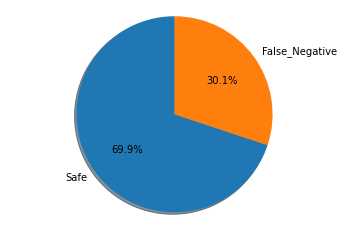

In [514]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Safe','False_Negative'
sizes = [len(normal),len(false_negative)]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

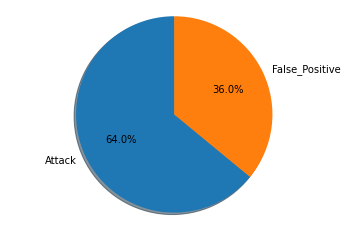

In [515]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Attack', 'False_Positive'
sizes = [len(anomaly),len(false_positive)]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
#Binary End

In [483]:
threshold = .91

weak_t = 0.78

medium_t = 0.65

percentages = []

def calculate_threat(avg_list):

    weak_count = 0
    medium_count = 0
    strong_count = 0
    green_light = 0

    for i in range(len(avg_list)):
        if avg_list[i] >= threshold:
            green_light += 1
        elif avg_list[i] >= weak_t:
            weak_count += 1
        elif avg_list[i] >= medium_t:
            medium_count += 1
        else:
            strong_count += 1
    

    
    print(f'Green Light: {green_light/len(avg_list)}')        
    print(f'Weak threat: {weak_count/len(avg_list)}')
    print(f'Medium threat: {medium_count/len(avg_list)}')
    print(f'Strong threat: {strong_count/len(avg_list)}')
    
    percentages.append(green_light/len(avg_list)* 100)
    percentages.append(weak_count/len(avg_list) * 100)
    percentages.append(medium_count/len(avg_list) * 100)
    percentages.append(strong_count/len(avg_list) * 100)

In [484]:
calculate_threat(means)

Green Light: 0.493368700265252
Weak threat: 0.32891246684350134
Medium threat: 0.1220159151193634
Strong threat: 0.05570291777188329


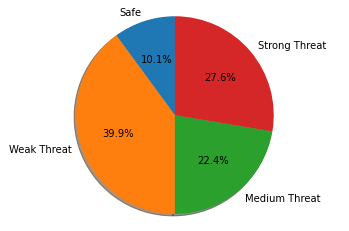

In [498]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Safe', 'Weak Threat', 'Medium Threat', 'Strong Threat'
sizes = [percentages[0],percentages[1],percentages[2],percentages[3]]
explode = (0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [487]:
percentages = []
calculate_threat(attack_means)

Green Light: 0.10087719298245613
Weak threat: 0.3991228070175439
Medium threat: 0.2236842105263158
Strong threat: 0.27631578947368424


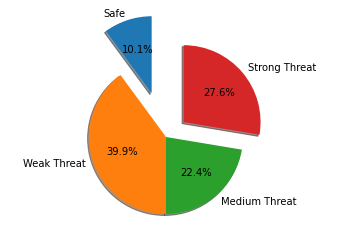

In [488]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Safe', 'Weak Threat', 'Medium Threat', 'Strong Threat'
sizes = [percentages[0],percentages[1],percentages[2],percentages[3]]
explode = (0.6, 0, 0, 0.3)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [245]:
attack_means = []

for i in range((len(train_attack_data))):
    print(f'{i+1}/{len(train_attack_data)}')
    print('-------------------------------------------------------------------')
    attack_means.append(statistics.mean(calc_request_belu_score(train_attack_data[i],0,n)))
    
    
        
    

1/746
-------------------------------------------------------------------
1 / 132
2 / 132
3 / 132
4 / 132
5 / 132
6 / 132
7 / 132
8 / 132
9 / 132
10 / 132
11 / 132
12 / 132
13 / 132
14 / 132
15 / 132
16 / 132
17 / 132
18 / 132
19 / 132
20 / 132
21 / 132
22 / 132
23 / 132
24 / 132
25 / 132
26 / 132
27 / 132
28 / 132
29 / 132
30 / 132
31 / 132
32 / 132
33 / 132
34 / 132
35 / 132
36 / 132
37 / 132
38 / 132
39 / 132
40 / 132
41 / 132
42 / 132
43 / 132
44 / 132
45 / 132
46 / 132
47 / 132
48 / 132
49 / 132
50 / 132
51 / 132
52 / 132
53 / 132
54 / 132
55 / 132
56 / 132
57 / 132
58 / 132
59 / 132
60 / 132
61 / 132
62 / 132
63 / 132
64 / 132
65 / 132
66 / 132
67 / 132
68 / 132
69 / 132
70 / 132
71 / 132
72 / 132
73 / 132
74 / 132
75 / 132
76 / 132
77 / 132
78 / 132
79 / 132
80 / 132
81 / 132
82 / 132
83 / 132
84 / 132
85 / 132
86 / 132
87 / 132
88 / 132
89 / 132
90 / 132
91 / 132
92 / 132
93 / 132
94 / 132
95 / 132
96 / 132
97 / 132
98 / 132
99 / 132
100 / 132
101 / 132
102 / 132
103 / 132
104 

2 / 277
3 / 277
4 / 277
5 / 277
6 / 277
7 / 277
8 / 277
9 / 277
10 / 277
11 / 277
12 / 277
13 / 277
14 / 277
15 / 277
16 / 277
17 / 277
18 / 277
19 / 277
20 / 277
21 / 277
22 / 277
23 / 277
24 / 277
25 / 277
26 / 277
27 / 277
28 / 277
29 / 277
30 / 277
31 / 277
32 / 277
33 / 277
34 / 277
35 / 277
36 / 277
37 / 277
38 / 277
39 / 277
40 / 277
41 / 277
42 / 277
43 / 277
44 / 277
45 / 277
46 / 277
47 / 277
48 / 277
49 / 277
50 / 277
51 / 277
52 / 277
53 / 277
54 / 277
55 / 277
56 / 277
57 / 277
58 / 277
59 / 277
60 / 277
61 / 277
62 / 277
63 / 277
64 / 277
65 / 277
66 / 277
67 / 277
68 / 277
69 / 277
70 / 277
71 / 277
72 / 277
73 / 277
74 / 277
75 / 277
76 / 277
77 / 277
78 / 277
79 / 277
80 / 277
81 / 277
82 / 277
83 / 277
84 / 277
85 / 277
86 / 277
87 / 277
88 / 277
89 / 277
90 / 277
91 / 277
92 / 277
93 / 277
94 / 277
95 / 277
96 / 277
97 / 277
98 / 277
99 / 277
100 / 277
101 / 277
102 / 277
103 / 277
104 / 277
105 / 277
106 / 277
107 / 277
108 / 277
109 / 277
110 / 277
111 / 277
112 / 

30 / 526
31 / 526
32 / 526
33 / 526
34 / 526
35 / 526
36 / 526
37 / 526
38 / 526
39 / 526
40 / 526
41 / 526
42 / 526
43 / 526
44 / 526
45 / 526
46 / 526
47 / 526
48 / 526
49 / 526
50 / 526
51 / 526
52 / 526
53 / 526
54 / 526
55 / 526
56 / 526
57 / 526
58 / 526
59 / 526
60 / 526
61 / 526
62 / 526
63 / 526
64 / 526
65 / 526
66 / 526
67 / 526
68 / 526
69 / 526
70 / 526
71 / 526
72 / 526
73 / 526
74 / 526
75 / 526
76 / 526
77 / 526
78 / 526
79 / 526
80 / 526
81 / 526
82 / 526
83 / 526
84 / 526
85 / 526
86 / 526
87 / 526
88 / 526
89 / 526
90 / 526
91 / 526
92 / 526
93 / 526
94 / 526
95 / 526
96 / 526
97 / 526
98 / 526
99 / 526
100 / 526
101 / 526
102 / 526
103 / 526
104 / 526
105 / 526
106 / 526
107 / 526
108 / 526
109 / 526
110 / 526
111 / 526
112 / 526
113 / 526
114 / 526
115 / 526
116 / 526
117 / 526
118 / 526
119 / 526
120 / 526
121 / 526
122 / 526
123 / 526
124 / 526
125 / 526
126 / 526
127 / 526
128 / 526
129 / 526
130 / 526
131 / 526
132 / 526
133 / 526
134 / 526
135 / 526
136 / 526


2 / 403
3 / 403
4 / 403
5 / 403
6 / 403
7 / 403
8 / 403
9 / 403
10 / 403
11 / 403
12 / 403
13 / 403
14 / 403
15 / 403
16 / 403
17 / 403
18 / 403
19 / 403
20 / 403
21 / 403
22 / 403
23 / 403
24 / 403
25 / 403
26 / 403
27 / 403
28 / 403
29 / 403
30 / 403
31 / 403
32 / 403
33 / 403
34 / 403
35 / 403
36 / 403
37 / 403
38 / 403
39 / 403
40 / 403
41 / 403
42 / 403
43 / 403
44 / 403
45 / 403
46 / 403
47 / 403
48 / 403
49 / 403
50 / 403
51 / 403
52 / 403
53 / 403
54 / 403
55 / 403
56 / 403
57 / 403
58 / 403
59 / 403
60 / 403
61 / 403
62 / 403
63 / 403
64 / 403
65 / 403
66 / 403
67 / 403
68 / 403
69 / 403
70 / 403
71 / 403
72 / 403
73 / 403
74 / 403
75 / 403
76 / 403
77 / 403
78 / 403
79 / 403
80 / 403
81 / 403
82 / 403
83 / 403
84 / 403
85 / 403
86 / 403
87 / 403
88 / 403
89 / 403
90 / 403
91 / 403
92 / 403
93 / 403
94 / 403
95 / 403
96 / 403
97 / 403
98 / 403
99 / 403
100 / 403
101 / 403
102 / 403
103 / 403
104 / 403
105 / 403
106 / 403
107 / 403
108 / 403
109 / 403
110 / 403
111 / 403
112 / 

1 / 256
2 / 256
3 / 256
4 / 256
5 / 256
6 / 256
7 / 256
8 / 256
9 / 256
10 / 256
11 / 256
12 / 256
13 / 256
14 / 256
15 / 256
16 / 256
17 / 256
18 / 256
19 / 256
20 / 256
21 / 256
22 / 256
23 / 256
24 / 256
25 / 256
26 / 256
27 / 256
28 / 256
29 / 256
30 / 256
31 / 256
32 / 256
33 / 256
34 / 256
35 / 256
36 / 256
37 / 256
38 / 256
39 / 256
40 / 256
41 / 256
42 / 256
43 / 256
44 / 256
45 / 256
46 / 256
47 / 256
48 / 256
49 / 256
50 / 256
51 / 256
52 / 256
53 / 256
54 / 256
55 / 256
56 / 256
57 / 256
58 / 256
59 / 256
60 / 256
61 / 256
62 / 256
63 / 256
64 / 256
65 / 256
66 / 256
67 / 256
68 / 256
69 / 256
70 / 256
71 / 256
72 / 256
73 / 256
74 / 256
75 / 256
76 / 256
77 / 256
78 / 256
79 / 256
80 / 256
81 / 256
82 / 256
83 / 256
84 / 256
85 / 256
86 / 256
87 / 256
88 / 256
89 / 256
90 / 256
91 / 256
92 / 256
93 / 256
94 / 256
95 / 256
96 / 256
97 / 256
98 / 256
99 / 256
100 / 256
101 / 256
102 / 256
103 / 256
104 / 256
105 / 256
106 / 256
107 / 256
108 / 256
109 / 256
110 / 256
111 / 25

110 / 204
111 / 204
112 / 204
113 / 204
114 / 204
115 / 204
116 / 204
117 / 204
118 / 204
119 / 204
120 / 204
121 / 204
122 / 204
123 / 204
124 / 204
125 / 204
126 / 204
127 / 204
128 / 204
129 / 204
130 / 204
131 / 204
132 / 204
133 / 204
134 / 204
135 / 204
136 / 204
137 / 204
138 / 204
139 / 204
140 / 204
141 / 204
142 / 204
143 / 204
144 / 204
145 / 204
146 / 204
147 / 204
148 / 204
149 / 204
150 / 204
151 / 204
152 / 204
153 / 204
154 / 204
155 / 204
156 / 204
157 / 204
158 / 204
159 / 204
160 / 204
161 / 204
162 / 204
163 / 204
164 / 204
165 / 204
166 / 204
167 / 204
168 / 204
169 / 204
170 / 204
171 / 204
172 / 204
173 / 204
174 / 204
175 / 204
176 / 204
177 / 204
178 / 204
179 / 204
180 / 204
181 / 204
182 / 204
183 / 204
184 / 204
185 / 204
186 / 204
187 / 204
188 / 204
189 / 204
190 / 204
191 / 204
192 / 204
193 / 204
194 / 204
195 / 204
196 / 204
197 / 204
198 / 204
199 / 204
200 / 204
201 / 204
202 / 204
203 / 204
[0.2857142857142857, 0.3571428571428572, 0.5, 0.5, 0.5, 0.64

74 / 360
75 / 360
76 / 360
77 / 360
78 / 360
79 / 360
80 / 360
81 / 360
82 / 360
83 / 360
84 / 360
85 / 360
86 / 360
87 / 360
88 / 360
89 / 360
90 / 360
91 / 360
92 / 360
93 / 360
94 / 360
95 / 360
96 / 360
97 / 360
98 / 360
99 / 360
100 / 360
101 / 360
102 / 360
103 / 360
104 / 360
105 / 360
106 / 360
107 / 360
108 / 360
109 / 360
110 / 360
111 / 360
112 / 360
113 / 360
114 / 360
115 / 360
116 / 360
117 / 360
118 / 360
119 / 360
120 / 360
121 / 360
122 / 360
123 / 360
124 / 360
125 / 360
126 / 360
127 / 360
128 / 360
129 / 360
130 / 360
131 / 360
132 / 360
133 / 360
134 / 360
135 / 360
136 / 360
137 / 360
138 / 360
139 / 360
140 / 360
141 / 360
142 / 360
143 / 360
144 / 360
145 / 360
146 / 360
147 / 360
148 / 360
149 / 360
150 / 360
151 / 360
152 / 360
153 / 360
154 / 360
155 / 360
156 / 360
157 / 360
158 / 360
159 / 360
160 / 360
161 / 360
162 / 360
163 / 360
164 / 360
165 / 360
166 / 360
167 / 360
168 / 360
169 / 360
170 / 360
171 / 360
172 / 360
173 / 360
174 / 360
175 / 360
176 / 

2 / 338
3 / 338
4 / 338
5 / 338
6 / 338
7 / 338
8 / 338
9 / 338
10 / 338
11 / 338
12 / 338
13 / 338
14 / 338
15 / 338
16 / 338
17 / 338
18 / 338
19 / 338
20 / 338
21 / 338
22 / 338
23 / 338
24 / 338
25 / 338
26 / 338
27 / 338
28 / 338
29 / 338
30 / 338
31 / 338
32 / 338
33 / 338
34 / 338
35 / 338
36 / 338
37 / 338
38 / 338
39 / 338
40 / 338
41 / 338
42 / 338
43 / 338
44 / 338
45 / 338
46 / 338
47 / 338
48 / 338
49 / 338
50 / 338
51 / 338
52 / 338
53 / 338
54 / 338
55 / 338
56 / 338
57 / 338
58 / 338
59 / 338
60 / 338
61 / 338
62 / 338
63 / 338
64 / 338
65 / 338
66 / 338
67 / 338
68 / 338
69 / 338
70 / 338
71 / 338
72 / 338
73 / 338
74 / 338
75 / 338
76 / 338
77 / 338
78 / 338
79 / 338
80 / 338
81 / 338
82 / 338
83 / 338
84 / 338
85 / 338
86 / 338
87 / 338
88 / 338
89 / 338
90 / 338
91 / 338
92 / 338
93 / 338
94 / 338
95 / 338
96 / 338
97 / 338
98 / 338
99 / 338
100 / 338
101 / 338
102 / 338
103 / 338
104 / 338
105 / 338
106 / 338
107 / 338
108 / 338
109 / 338
110 / 338
111 / 338
112 / 

1 / 301
2 / 301
3 / 301
4 / 301
5 / 301
6 / 301
7 / 301
8 / 301
9 / 301
10 / 301
11 / 301
12 / 301
13 / 301
14 / 301
15 / 301
16 / 301
17 / 301
18 / 301
19 / 301
20 / 301
21 / 301
22 / 301
23 / 301
24 / 301
25 / 301
26 / 301
27 / 301
28 / 301
29 / 301
30 / 301
31 / 301
32 / 301
33 / 301
34 / 301
35 / 301
36 / 301
37 / 301
38 / 301
39 / 301
40 / 301
41 / 301
42 / 301
43 / 301
44 / 301
45 / 301
46 / 301
47 / 301
48 / 301
49 / 301
50 / 301
51 / 301
52 / 301
53 / 301
54 / 301
55 / 301
56 / 301
57 / 301
58 / 301
59 / 301
60 / 301
61 / 301
62 / 301
63 / 301
64 / 301
65 / 301
66 / 301
67 / 301
68 / 301
69 / 301
70 / 301
71 / 301
72 / 301
73 / 301
74 / 301
75 / 301
76 / 301
77 / 301
78 / 301
79 / 301
80 / 301
81 / 301
82 / 301
83 / 301
84 / 301
85 / 301
86 / 301
87 / 301
88 / 301
89 / 301
90 / 301
91 / 301
92 / 301
93 / 301
94 / 301
95 / 301
96 / 301
97 / 301
98 / 301
99 / 301
100 / 301
101 / 301
102 / 301
103 / 301
104 / 301
105 / 301
106 / 301
107 / 301
108 / 301
109 / 301
110 / 301
111 / 30

3 / 221
4 / 221
5 / 221
6 / 221
7 / 221
8 / 221
9 / 221
10 / 221
11 / 221
12 / 221
13 / 221
14 / 221
15 / 221
16 / 221
17 / 221
18 / 221
19 / 221
20 / 221
21 / 221
22 / 221
23 / 221
24 / 221
25 / 221
26 / 221
27 / 221
28 / 221
29 / 221
30 / 221
31 / 221
32 / 221
33 / 221
34 / 221
35 / 221
36 / 221
37 / 221
38 / 221
39 / 221
40 / 221
41 / 221
42 / 221
43 / 221
44 / 221
45 / 221
46 / 221
47 / 221
48 / 221
49 / 221
50 / 221
51 / 221
52 / 221
53 / 221
54 / 221
55 / 221
56 / 221
57 / 221
58 / 221
59 / 221
60 / 221
61 / 221
62 / 221
63 / 221
64 / 221
65 / 221
66 / 221
67 / 221
68 / 221
69 / 221
70 / 221
71 / 221
72 / 221
73 / 221
74 / 221
75 / 221
76 / 221
77 / 221
78 / 221
79 / 221
80 / 221
81 / 221
82 / 221
83 / 221
84 / 221
85 / 221
86 / 221
87 / 221
88 / 221
89 / 221
90 / 221
91 / 221
92 / 221
93 / 221
94 / 221
95 / 221
96 / 221
97 / 221
98 / 221
99 / 221
100 / 221
101 / 221
102 / 221
103 / 221
104 / 221
105 / 221
106 / 221
107 / 221
108 / 221
109 / 221
110 / 221
111 / 221
112 / 221
113 

200 / 216
201 / 216
202 / 216
203 / 216
204 / 216
205 / 216
206 / 216
207 / 216
208 / 216
209 / 216
210 / 216
211 / 216
212 / 216
213 / 216
214 / 216
215 / 216
[0.07142857142857141, 0, 0.2857142857142857, 0.3571428571428572, 0.3571428571428572, 0.3571428571428572, 0.5, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5, 0.42857142857142855, 0.42857142857142855, 0.5, 0.5, 0.7142857142857143, 0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.5714285714285714, 0.42857142857142855, 0.5714285714285714, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.5714285714285714, 0.6428571428571429, 0.7142857142

101 / 272
102 / 272
103 / 272
104 / 272
105 / 272
106 / 272
107 / 272
108 / 272
109 / 272
110 / 272
111 / 272
112 / 272
113 / 272
114 / 272
115 / 272
116 / 272
117 / 272
118 / 272
119 / 272
120 / 272
121 / 272
122 / 272
123 / 272
124 / 272
125 / 272
126 / 272
127 / 272
128 / 272
129 / 272
130 / 272
131 / 272
132 / 272
133 / 272
134 / 272
135 / 272
136 / 272
137 / 272
138 / 272
139 / 272
140 / 272
141 / 272
142 / 272
143 / 272
144 / 272
145 / 272
146 / 272
147 / 272
148 / 272
149 / 272
150 / 272
151 / 272
152 / 272
153 / 272
154 / 272
155 / 272
156 / 272
157 / 272
158 / 272
159 / 272
160 / 272
161 / 272
162 / 272
163 / 272
164 / 272
165 / 272
166 / 272
167 / 272
168 / 272
169 / 272
170 / 272
171 / 272
172 / 272
173 / 272
174 / 272
175 / 272
176 / 272
177 / 272
178 / 272
179 / 272
180 / 272
181 / 272
182 / 272
183 / 272
184 / 272
185 / 272
186 / 272
187 / 272
188 / 272
189 / 272
190 / 272
191 / 272
192 / 272
193 / 272
194 / 272
195 / 272
196 / 272
197 / 272
198 / 272
199 / 272
200 / 272


104 / 242
105 / 242
106 / 242
107 / 242
108 / 242
109 / 242
110 / 242
111 / 242
112 / 242
113 / 242
114 / 242
115 / 242
116 / 242
117 / 242
118 / 242
119 / 242
120 / 242
121 / 242
122 / 242
123 / 242
124 / 242
125 / 242
126 / 242
127 / 242
128 / 242
129 / 242
130 / 242
131 / 242
132 / 242
133 / 242
134 / 242
135 / 242
136 / 242
137 / 242
138 / 242
139 / 242
140 / 242
141 / 242
142 / 242
143 / 242
144 / 242
145 / 242
146 / 242
147 / 242
148 / 242
149 / 242
150 / 242
151 / 242
152 / 242
153 / 242
154 / 242
155 / 242
156 / 242
157 / 242
158 / 242
159 / 242
160 / 242
161 / 242
162 / 242
163 / 242
164 / 242
165 / 242
166 / 242
167 / 242
168 / 242
169 / 242
170 / 242
171 / 242
172 / 242
173 / 242
174 / 242
175 / 242
176 / 242
177 / 242
178 / 242
179 / 242
180 / 242
181 / 242
182 / 242
183 / 242
184 / 242
185 / 242
186 / 242
187 / 242
188 / 242
189 / 242
190 / 242
191 / 242
192 / 242
193 / 242
194 / 242
195 / 242
196 / 242
197 / 242
198 / 242
199 / 242
200 / 242
201 / 242
202 / 242
203 / 242


256 / 772
257 / 772
258 / 772
259 / 772
260 / 772
261 / 772
262 / 772
263 / 772
264 / 772
265 / 772
266 / 772
267 / 772
268 / 772
269 / 772
270 / 772
271 / 772
272 / 772
273 / 772
274 / 772
275 / 772
276 / 772
277 / 772
278 / 772
279 / 772
280 / 772
281 / 772
282 / 772
283 / 772
284 / 772
285 / 772
286 / 772
287 / 772
288 / 772
289 / 772
290 / 772
291 / 772
292 / 772
293 / 772
294 / 772
295 / 772
296 / 772
297 / 772
298 / 772
299 / 772
300 / 772
301 / 772
302 / 772
303 / 772
304 / 772
305 / 772
306 / 772
307 / 772
308 / 772
309 / 772
310 / 772
311 / 772
312 / 772
313 / 772
314 / 772
315 / 772
316 / 772
317 / 772
318 / 772
319 / 772
320 / 772
321 / 772
322 / 772
323 / 772
324 / 772
325 / 772
326 / 772
327 / 772
328 / 772
329 / 772
330 / 772
331 / 772
332 / 772
333 / 772
334 / 772
335 / 772
336 / 772
337 / 772
338 / 772
339 / 772
340 / 772
341 / 772
342 / 772
343 / 772
344 / 772
345 / 772
346 / 772
347 / 772
348 / 772
349 / 772
350 / 772
351 / 772
352 / 772
353 / 772
354 / 772
355 / 772


3 / 353
4 / 353
5 / 353
6 / 353
7 / 353
8 / 353
9 / 353
10 / 353
11 / 353
12 / 353
13 / 353
14 / 353
15 / 353
16 / 353
17 / 353
18 / 353
19 / 353
20 / 353
21 / 353
22 / 353
23 / 353
24 / 353
25 / 353
26 / 353
27 / 353
28 / 353
29 / 353
30 / 353
31 / 353
32 / 353
33 / 353
34 / 353
35 / 353
36 / 353
37 / 353
38 / 353
39 / 353
40 / 353
41 / 353
42 / 353
43 / 353
44 / 353
45 / 353
46 / 353
47 / 353
48 / 353
49 / 353
50 / 353
51 / 353
52 / 353
53 / 353
54 / 353
55 / 353
56 / 353
57 / 353
58 / 353
59 / 353
60 / 353
61 / 353
62 / 353
63 / 353
64 / 353
65 / 353
66 / 353
67 / 353
68 / 353
69 / 353
70 / 353
71 / 353
72 / 353
73 / 353
74 / 353
75 / 353
76 / 353
77 / 353
78 / 353
79 / 353
80 / 353
81 / 353
82 / 353
83 / 353
84 / 353
85 / 353
86 / 353
87 / 353
88 / 353
89 / 353
90 / 353
91 / 353
92 / 353
93 / 353
94 / 353
95 / 353
96 / 353
97 / 353
98 / 353
99 / 353
100 / 353
101 / 353
102 / 353
103 / 353
104 / 353
105 / 353
106 / 353
107 / 353
108 / 353
109 / 353
110 / 353
111 / 353
112 / 353
113 

3 / 255
4 / 255
5 / 255
6 / 255
7 / 255
8 / 255
9 / 255
10 / 255
11 / 255
12 / 255
13 / 255
14 / 255
15 / 255
16 / 255
17 / 255
18 / 255
19 / 255
20 / 255
21 / 255
22 / 255
23 / 255
24 / 255
25 / 255
26 / 255
27 / 255
28 / 255
29 / 255
30 / 255
31 / 255
32 / 255
33 / 255
34 / 255
35 / 255
36 / 255
37 / 255
38 / 255
39 / 255
40 / 255
41 / 255
42 / 255
43 / 255
44 / 255
45 / 255
46 / 255
47 / 255
48 / 255
49 / 255
50 / 255
51 / 255
52 / 255
53 / 255
54 / 255
55 / 255
56 / 255
57 / 255
58 / 255
59 / 255
60 / 255
61 / 255
62 / 255
63 / 255
64 / 255
65 / 255
66 / 255
67 / 255
68 / 255
69 / 255
70 / 255
71 / 255
72 / 255
73 / 255
74 / 255
75 / 255
76 / 255
77 / 255
78 / 255
79 / 255
80 / 255
81 / 255
82 / 255
83 / 255
84 / 255
85 / 255
86 / 255
87 / 255
88 / 255
89 / 255
90 / 255
91 / 255
92 / 255
93 / 255
94 / 255
95 / 255
96 / 255
97 / 255
98 / 255
99 / 255
100 / 255
101 / 255
102 / 255
103 / 255
104 / 255
105 / 255
106 / 255
107 / 255
108 / 255
109 / 255
110 / 255
111 / 255
112 / 255
113 

100 / 178
101 / 178
102 / 178
103 / 178
104 / 178
105 / 178
106 / 178
107 / 178
108 / 178
109 / 178
110 / 178
111 / 178
112 / 178
113 / 178
114 / 178
115 / 178
116 / 178
117 / 178
118 / 178
119 / 178
120 / 178
121 / 178
122 / 178
123 / 178
124 / 178
125 / 178
126 / 178
127 / 178
128 / 178
129 / 178
130 / 178
131 / 178
132 / 178
133 / 178
134 / 178
135 / 178
136 / 178
137 / 178
138 / 178
139 / 178
140 / 178
141 / 178
142 / 178
143 / 178
144 / 178
145 / 178
146 / 178
147 / 178
148 / 178
149 / 178
150 / 178
151 / 178
152 / 178
153 / 178
154 / 178
155 / 178
156 / 178
157 / 178
158 / 178
159 / 178
160 / 178
161 / 178
162 / 178
163 / 178
164 / 178
165 / 178
166 / 178
167 / 178
168 / 178
169 / 178
170 / 178
171 / 178
172 / 178
173 / 178
174 / 178
175 / 178
176 / 178
177 / 178
[0.21428571428571425, 0.3571428571428572, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.6428571428571429, 0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 0.7142857142857143, 0.85714285714285

51 / 225
52 / 225
53 / 225
54 / 225
55 / 225
56 / 225
57 / 225
58 / 225
59 / 225
60 / 225
61 / 225
62 / 225
63 / 225
64 / 225
65 / 225
66 / 225
67 / 225
68 / 225
69 / 225
70 / 225
71 / 225
72 / 225
73 / 225
74 / 225
75 / 225
76 / 225
77 / 225
78 / 225
79 / 225
80 / 225
81 / 225
82 / 225
83 / 225
84 / 225
85 / 225
86 / 225
87 / 225
88 / 225
89 / 225
90 / 225
91 / 225
92 / 225
93 / 225
94 / 225
95 / 225
96 / 225
97 / 225
98 / 225
99 / 225
100 / 225
101 / 225
102 / 225
103 / 225
104 / 225
105 / 225
106 / 225
107 / 225
108 / 225
109 / 225
110 / 225
111 / 225
112 / 225
113 / 225
114 / 225
115 / 225
116 / 225
117 / 225
118 / 225
119 / 225
120 / 225
121 / 225
122 / 225
123 / 225
124 / 225
125 / 225
126 / 225
127 / 225
128 / 225
129 / 225
130 / 225
131 / 225
132 / 225
133 / 225
134 / 225
135 / 225
136 / 225
137 / 225
138 / 225
139 / 225
140 / 225
141 / 225
142 / 225
143 / 225
144 / 225
145 / 225
146 / 225
147 / 225
148 / 225
149 / 225
150 / 225
151 / 225
152 / 225
153 / 225
154 / 225
155 / 225

141 / 283
142 / 283
143 / 283
144 / 283
145 / 283
146 / 283
147 / 283
148 / 283
149 / 283
150 / 283
151 / 283
152 / 283
153 / 283
154 / 283
155 / 283
156 / 283
157 / 283
158 / 283
159 / 283
160 / 283
161 / 283
162 / 283
163 / 283
164 / 283
165 / 283
166 / 283
167 / 283
168 / 283
169 / 283
170 / 283
171 / 283
172 / 283
173 / 283
174 / 283
175 / 283
176 / 283
177 / 283
178 / 283
179 / 283
180 / 283
181 / 283
182 / 283
183 / 283
184 / 283
185 / 283
186 / 283
187 / 283
188 / 283
189 / 283
190 / 283
191 / 283
192 / 283
193 / 283
194 / 283
195 / 283
196 / 283
197 / 283
198 / 283
199 / 283
200 / 283
201 / 283
202 / 283
203 / 283
204 / 283
205 / 283
206 / 283
207 / 283
208 / 283
209 / 283
210 / 283
211 / 283
212 / 283
213 / 283
214 / 283
215 / 283
216 / 283
217 / 283
218 / 283
219 / 283
220 / 283
221 / 283
222 / 283
223 / 283
224 / 283
225 / 283
226 / 283
227 / 283
228 / 283
229 / 283
230 / 283
231 / 283
232 / 283
233 / 283
234 / 283
235 / 283
236 / 283
237 / 283
238 / 283
239 / 283
240 / 283


152 / 212
153 / 212
154 / 212
155 / 212
156 / 212
157 / 212
158 / 212
159 / 212
160 / 212
161 / 212
162 / 212
163 / 212
164 / 212
165 / 212
166 / 212
167 / 212
168 / 212
169 / 212
170 / 212
171 / 212
172 / 212
173 / 212
174 / 212
175 / 212
176 / 212
177 / 212
178 / 212
179 / 212
180 / 212
181 / 212
182 / 212
183 / 212
184 / 212
185 / 212
186 / 212
187 / 212
188 / 212
189 / 212
190 / 212
191 / 212
192 / 212
193 / 212
194 / 212
195 / 212
196 / 212
197 / 212
198 / 212
199 / 212
200 / 212
201 / 212
202 / 212
203 / 212
204 / 212
205 / 212
206 / 212
207 / 212
208 / 212
209 / 212
210 / 212
211 / 212
[1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 1.0, 0.7857142857142857, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 1.0, 0.7857142857142857, 0.857142857142

368 / 382
369 / 382
370 / 382
371 / 382
372 / 382
373 / 382
374 / 382
375 / 382
376 / 382
377 / 382
378 / 382
379 / 382
380 / 382
381 / 382
[0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.928571428571

149 / 184
150 / 184
151 / 184
152 / 184
153 / 184
154 / 184
155 / 184
156 / 184
157 / 184
158 / 184
159 / 184
160 / 184
161 / 184
162 / 184
163 / 184
164 / 184
165 / 184
166 / 184
167 / 184
168 / 184
169 / 184
170 / 184
171 / 184
172 / 184
173 / 184
174 / 184
175 / 184
176 / 184
177 / 184
178 / 184
179 / 184
180 / 184
181 / 184
182 / 184
183 / 184
[0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.5714285714285714, 0.42857142857142855, 0.5714285714285714, 0.785714

1 / 101
2 / 101
3 / 101
4 / 101
5 / 101
6 / 101
7 / 101
8 / 101
9 / 101
10 / 101
11 / 101
12 / 101
13 / 101
14 / 101
15 / 101
16 / 101
17 / 101
18 / 101
19 / 101
20 / 101
21 / 101
22 / 101
23 / 101
24 / 101
25 / 101
26 / 101
27 / 101
28 / 101
29 / 101
30 / 101
31 / 101
32 / 101
33 / 101
34 / 101
35 / 101
36 / 101
37 / 101
38 / 101
39 / 101
40 / 101
41 / 101
42 / 101
43 / 101
44 / 101
45 / 101
46 / 101
47 / 101
48 / 101
49 / 101
50 / 101
51 / 101
52 / 101
53 / 101
54 / 101
55 / 101
56 / 101
57 / 101
58 / 101
59 / 101
60 / 101
61 / 101
62 / 101
63 / 101
64 / 101
65 / 101
66 / 101
67 / 101
68 / 101
69 / 101
70 / 101
71 / 101
72 / 101
73 / 101
74 / 101
75 / 101
76 / 101
77 / 101
78 / 101
79 / 101
80 / 101
81 / 101
82 / 101
83 / 101
84 / 101
85 / 101
86 / 101
87 / 101
88 / 101
89 / 101
90 / 101
91 / 101
92 / 101
93 / 101
94 / 101
95 / 101
96 / 101
97 / 101
98 / 101
99 / 101
100 / 101
[0.9285714285714286, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 0.928571428571428

2 / 304
3 / 304
4 / 304
5 / 304
6 / 304
7 / 304
8 / 304
9 / 304
10 / 304
11 / 304
12 / 304
13 / 304
14 / 304
15 / 304
16 / 304
17 / 304
18 / 304
19 / 304
20 / 304
21 / 304
22 / 304
23 / 304
24 / 304
25 / 304
26 / 304
27 / 304
28 / 304
29 / 304
30 / 304
31 / 304
32 / 304
33 / 304
34 / 304
35 / 304
36 / 304
37 / 304
38 / 304
39 / 304
40 / 304
41 / 304
42 / 304
43 / 304
44 / 304
45 / 304
46 / 304
47 / 304
48 / 304
49 / 304
50 / 304
51 / 304
52 / 304
53 / 304
54 / 304
55 / 304
56 / 304
57 / 304
58 / 304
59 / 304
60 / 304
61 / 304
62 / 304
63 / 304
64 / 304
65 / 304
66 / 304
67 / 304
68 / 304
69 / 304
70 / 304
71 / 304
72 / 304
73 / 304
74 / 304
75 / 304
76 / 304
77 / 304
78 / 304
79 / 304
80 / 304
81 / 304
82 / 304
83 / 304
84 / 304
85 / 304
86 / 304
87 / 304
88 / 304
89 / 304
90 / 304
91 / 304
92 / 304
93 / 304
94 / 304
95 / 304
96 / 304
97 / 304
98 / 304
99 / 304
100 / 304
101 / 304
102 / 304
103 / 304
104 / 304
105 / 304
106 / 304
107 / 304
108 / 304
109 / 304
110 / 304
111 / 304
112 / 

2 / 263
3 / 263
4 / 263
5 / 263
6 / 263
7 / 263
8 / 263
9 / 263
10 / 263
11 / 263
12 / 263
13 / 263
14 / 263
15 / 263
16 / 263
17 / 263
18 / 263
19 / 263
20 / 263
21 / 263
22 / 263
23 / 263
24 / 263
25 / 263
26 / 263
27 / 263
28 / 263
29 / 263
30 / 263
31 / 263
32 / 263
33 / 263
34 / 263
35 / 263
36 / 263
37 / 263
38 / 263
39 / 263
40 / 263
41 / 263
42 / 263
43 / 263
44 / 263
45 / 263
46 / 263
47 / 263
48 / 263
49 / 263
50 / 263
51 / 263
52 / 263
53 / 263
54 / 263
55 / 263
56 / 263
57 / 263
58 / 263
59 / 263
60 / 263
61 / 263
62 / 263
63 / 263
64 / 263
65 / 263
66 / 263
67 / 263
68 / 263
69 / 263
70 / 263
71 / 263
72 / 263
73 / 263
74 / 263
75 / 263
76 / 263
77 / 263
78 / 263
79 / 263
80 / 263
81 / 263
82 / 263
83 / 263
84 / 263
85 / 263
86 / 263
87 / 263
88 / 263
89 / 263
90 / 263
91 / 263
92 / 263
93 / 263
94 / 263
95 / 263
96 / 263
97 / 263
98 / 263
99 / 263
100 / 263
101 / 263
102 / 263
103 / 263
104 / 263
105 / 263
106 / 263
107 / 263
108 / 263
109 / 263
110 / 263
111 / 263
112 / 

82 / 486
83 / 486
84 / 486
85 / 486
86 / 486
87 / 486
88 / 486
89 / 486
90 / 486
91 / 486
92 / 486
93 / 486
94 / 486
95 / 486
96 / 486
97 / 486
98 / 486
99 / 486
100 / 486
101 / 486
102 / 486
103 / 486
104 / 486
105 / 486
106 / 486
107 / 486
108 / 486
109 / 486
110 / 486
111 / 486
112 / 486
113 / 486
114 / 486
115 / 486
116 / 486
117 / 486
118 / 486
119 / 486
120 / 486
121 / 486
122 / 486
123 / 486
124 / 486
125 / 486
126 / 486
127 / 486
128 / 486
129 / 486
130 / 486
131 / 486
132 / 486
133 / 486
134 / 486
135 / 486
136 / 486
137 / 486
138 / 486
139 / 486
140 / 486
141 / 486
142 / 486
143 / 486
144 / 486
145 / 486
146 / 486
147 / 486
148 / 486
149 / 486
150 / 486
151 / 486
152 / 486
153 / 486
154 / 486
155 / 486
156 / 486
157 / 486
158 / 486
159 / 486
160 / 486
161 / 486
162 / 486
163 / 486
164 / 486
165 / 486
166 / 486
167 / 486
168 / 486
169 / 486
170 / 486
171 / 486
172 / 486
173 / 486
174 / 486
175 / 486
176 / 486
177 / 486
178 / 486
179 / 486
180 / 486
181 / 486
182 / 486
183 / 48

1 / 236
2 / 236
3 / 236
4 / 236
5 / 236
6 / 236
7 / 236
8 / 236
9 / 236
10 / 236
11 / 236
12 / 236
13 / 236
14 / 236
15 / 236
16 / 236
17 / 236
18 / 236
19 / 236
20 / 236
21 / 236
22 / 236
23 / 236
24 / 236
25 / 236
26 / 236
27 / 236
28 / 236
29 / 236
30 / 236
31 / 236
32 / 236
33 / 236
34 / 236
35 / 236
36 / 236
37 / 236
38 / 236
39 / 236
40 / 236
41 / 236
42 / 236
43 / 236
44 / 236
45 / 236
46 / 236
47 / 236
48 / 236
49 / 236
50 / 236
51 / 236
52 / 236
53 / 236
54 / 236
55 / 236
56 / 236
57 / 236
58 / 236
59 / 236
60 / 236
61 / 236
62 / 236
63 / 236
64 / 236
65 / 236
66 / 236
67 / 236
68 / 236
69 / 236
70 / 236
71 / 236
72 / 236
73 / 236
74 / 236
75 / 236
76 / 236
77 / 236
78 / 236
79 / 236
80 / 236
81 / 236
82 / 236
83 / 236
84 / 236
85 / 236
86 / 236
87 / 236
88 / 236
89 / 236
90 / 236
91 / 236
92 / 236
93 / 236
94 / 236
95 / 236
96 / 236
97 / 236
98 / 236
99 / 236
100 / 236
101 / 236
102 / 236
103 / 236
104 / 236
105 / 236
106 / 236
107 / 236
108 / 236
109 / 236
110 / 236
111 / 23

143 / 197
144 / 197
145 / 197
146 / 197
147 / 197
148 / 197
149 / 197
150 / 197
151 / 197
152 / 197
153 / 197
154 / 197
155 / 197
156 / 197
157 / 197
158 / 197
159 / 197
160 / 197
161 / 197
162 / 197
163 / 197
164 / 197
165 / 197
166 / 197
167 / 197
168 / 197
169 / 197
170 / 197
171 / 197
172 / 197
173 / 197
174 / 197
175 / 197
176 / 197
177 / 197
178 / 197
179 / 197
180 / 197
181 / 197
182 / 197
183 / 197
184 / 197
185 / 197
186 / 197
187 / 197
188 / 197
189 / 197
190 / 197
191 / 197
192 / 197
193 / 197
194 / 197
195 / 197
196 / 197
[0.5714285714285714, 0.5714285714285714, 0.42857142857142855, 0.3571428571428572, 0.42857142857142855, 0.42857142857142855, 0.5, 0.42857142857142855, 0.42857142857142855, 0.5, 0.5, 0.3571428571428572, 0.2857142857142857, 0.14285714285714285, 0.42857142857142855, 0.3571428571428572, 0.42857142857142855, 0.5, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.857142857

57 / 206
58 / 206
59 / 206
60 / 206
61 / 206
62 / 206
63 / 206
64 / 206
65 / 206
66 / 206
67 / 206
68 / 206
69 / 206
70 / 206
71 / 206
72 / 206
73 / 206
74 / 206
75 / 206
76 / 206
77 / 206
78 / 206
79 / 206
80 / 206
81 / 206
82 / 206
83 / 206
84 / 206
85 / 206
86 / 206
87 / 206
88 / 206
89 / 206
90 / 206
91 / 206
92 / 206
93 / 206
94 / 206
95 / 206
96 / 206
97 / 206
98 / 206
99 / 206
100 / 206
101 / 206
102 / 206
103 / 206
104 / 206
105 / 206
106 / 206
107 / 206
108 / 206
109 / 206
110 / 206
111 / 206
112 / 206
113 / 206
114 / 206
115 / 206
116 / 206
117 / 206
118 / 206
119 / 206
120 / 206
121 / 206
122 / 206
123 / 206
124 / 206
125 / 206
126 / 206
127 / 206
128 / 206
129 / 206
130 / 206
131 / 206
132 / 206
133 / 206
134 / 206
135 / 206
136 / 206
137 / 206
138 / 206
139 / 206
140 / 206
141 / 206
142 / 206
143 / 206
144 / 206
145 / 206
146 / 206
147 / 206
148 / 206
149 / 206
150 / 206
151 / 206
152 / 206
153 / 206
154 / 206
155 / 206
156 / 206
157 / 206
158 / 206
159 / 206
160 / 206
161

180 / 241
181 / 241
182 / 241
183 / 241
184 / 241
185 / 241
186 / 241
187 / 241
188 / 241
189 / 241
190 / 241
191 / 241
192 / 241
193 / 241
194 / 241
195 / 241
196 / 241
197 / 241
198 / 241
199 / 241
200 / 241
201 / 241
202 / 241
203 / 241
204 / 241
205 / 241
206 / 241
207 / 241
208 / 241
209 / 241
210 / 241
211 / 241
212 / 241
213 / 241
214 / 241
215 / 241
216 / 241
217 / 241
218 / 241
219 / 241
220 / 241
221 / 241
222 / 241
223 / 241
224 / 241
225 / 241
226 / 241
227 / 241
228 / 241
229 / 241
230 / 241
231 / 241
232 / 241
233 / 241
234 / 241
235 / 241
236 / 241
237 / 241
238 / 241
239 / 241
240 / 241
[0.7857142857142857, 0.8571428571428571, 1.0, 0.7857142857142857, 0.7857142857142857, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.5714285714285714, 0.5, 0.5, 0.6428571428571429, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.7857142857142857, 0.7857142857142857, 0.928571428571

1 / 436
2 / 436
3 / 436
4 / 436
5 / 436
6 / 436
7 / 436
8 / 436
9 / 436
10 / 436
11 / 436
12 / 436
13 / 436
14 / 436
15 / 436
16 / 436
17 / 436
18 / 436
19 / 436
20 / 436
21 / 436
22 / 436
23 / 436
24 / 436
25 / 436
26 / 436
27 / 436
28 / 436
29 / 436
30 / 436
31 / 436
32 / 436
33 / 436
34 / 436
35 / 436
36 / 436
37 / 436
38 / 436
39 / 436
40 / 436
41 / 436
42 / 436
43 / 436
44 / 436
45 / 436
46 / 436
47 / 436
48 / 436
49 / 436
50 / 436
51 / 436
52 / 436
53 / 436
54 / 436
55 / 436
56 / 436
57 / 436
58 / 436
59 / 436
60 / 436
61 / 436
62 / 436
63 / 436
64 / 436
65 / 436
66 / 436
67 / 436
68 / 436
69 / 436
70 / 436
71 / 436
72 / 436
73 / 436
74 / 436
75 / 436
76 / 436
77 / 436
78 / 436
79 / 436
80 / 436
81 / 436
82 / 436
83 / 436
84 / 436
85 / 436
86 / 436
87 / 436
88 / 436
89 / 436
90 / 436
91 / 436
92 / 436
93 / 436
94 / 436
95 / 436
96 / 436
97 / 436
98 / 436
99 / 436
100 / 436
101 / 436
102 / 436
103 / 436
104 / 436
105 / 436
106 / 436
107 / 436
108 / 436
109 / 436
110 / 436
111 / 43

2 / 177
3 / 177
4 / 177
5 / 177
6 / 177
7 / 177
8 / 177
9 / 177
10 / 177
11 / 177
12 / 177
13 / 177
14 / 177
15 / 177
16 / 177
17 / 177
18 / 177
19 / 177
20 / 177
21 / 177
22 / 177
23 / 177
24 / 177
25 / 177
26 / 177
27 / 177
28 / 177
29 / 177
30 / 177
31 / 177
32 / 177
33 / 177
34 / 177
35 / 177
36 / 177
37 / 177
38 / 177
39 / 177
40 / 177
41 / 177
42 / 177
43 / 177
44 / 177
45 / 177
46 / 177
47 / 177
48 / 177
49 / 177
50 / 177
51 / 177
52 / 177
53 / 177
54 / 177
55 / 177
56 / 177
57 / 177
58 / 177
59 / 177
60 / 177
61 / 177
62 / 177
63 / 177
64 / 177
65 / 177
66 / 177
67 / 177
68 / 177
69 / 177
70 / 177
71 / 177
72 / 177
73 / 177
74 / 177
75 / 177
76 / 177
77 / 177
78 / 177
79 / 177
80 / 177
81 / 177
82 / 177
83 / 177
84 / 177
85 / 177
86 / 177
87 / 177
88 / 177
89 / 177
90 / 177
91 / 177
92 / 177
93 / 177
94 / 177
95 / 177
96 / 177
97 / 177
98 / 177
99 / 177
100 / 177
101 / 177
102 / 177
103 / 177
104 / 177
105 / 177
106 / 177
107 / 177
108 / 177
109 / 177
110 / 177
111 / 177
112 / 

159 / 178
160 / 178
161 / 178
162 / 178
163 / 178
164 / 178
165 / 178
166 / 178
167 / 178
168 / 178
169 / 178
170 / 178
171 / 178
172 / 178
173 / 178
174 / 178
175 / 178
176 / 178
177 / 178
[0.42857142857142855, 0.42857142857142855, 0.3571428571428572, 0.5, 0.5714285714285714, 0.5, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.6428571428571429, 0.5714285714285714, 0.6428571428571429, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.6428571428571429, 0.7857142857142857, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.5714285714285714, 0.5, 0.5, 0.42857142857142855, 0.5714285714285714, 0.42857142857142855, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5, 0.5714285714285714, 0.5, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.85714285714

106 / 232
107 / 232
108 / 232
109 / 232
110 / 232
111 / 232
112 / 232
113 / 232
114 / 232
115 / 232
116 / 232
117 / 232
118 / 232
119 / 232
120 / 232
121 / 232
122 / 232
123 / 232
124 / 232
125 / 232
126 / 232
127 / 232
128 / 232
129 / 232
130 / 232
131 / 232
132 / 232
133 / 232
134 / 232
135 / 232
136 / 232
137 / 232
138 / 232
139 / 232
140 / 232
141 / 232
142 / 232
143 / 232
144 / 232
145 / 232
146 / 232
147 / 232
148 / 232
149 / 232
150 / 232
151 / 232
152 / 232
153 / 232
154 / 232
155 / 232
156 / 232
157 / 232
158 / 232
159 / 232
160 / 232
161 / 232
162 / 232
163 / 232
164 / 232
165 / 232
166 / 232
167 / 232
168 / 232
169 / 232
170 / 232
171 / 232
172 / 232
173 / 232
174 / 232
175 / 232
176 / 232
177 / 232
178 / 232
179 / 232
180 / 232
181 / 232
182 / 232
183 / 232
184 / 232
185 / 232
186 / 232
187 / 232
188 / 232
189 / 232
190 / 232
191 / 232
192 / 232
193 / 232
194 / 232
195 / 232
196 / 232
197 / 232
198 / 232
199 / 232
200 / 232
201 / 232
202 / 232
203 / 232
204 / 232
205 / 232


187 / 189
188 / 189
[0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 1.0, 0.5714285714285714, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.6428571428571429, 0.7857142857142857, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 0.5, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.6428571428571429, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143,

1 / 156
2 / 156
3 / 156
4 / 156
5 / 156
6 / 156
7 / 156
8 / 156
9 / 156
10 / 156
11 / 156
12 / 156
13 / 156
14 / 156
15 / 156
16 / 156
17 / 156
18 / 156
19 / 156
20 / 156
21 / 156
22 / 156
23 / 156
24 / 156
25 / 156
26 / 156
27 / 156
28 / 156
29 / 156
30 / 156
31 / 156
32 / 156
33 / 156
34 / 156
35 / 156
36 / 156
37 / 156
38 / 156
39 / 156
40 / 156
41 / 156
42 / 156
43 / 156
44 / 156
45 / 156
46 / 156
47 / 156
48 / 156
49 / 156
50 / 156
51 / 156
52 / 156
53 / 156
54 / 156
55 / 156
56 / 156
57 / 156
58 / 156
59 / 156
60 / 156
61 / 156
62 / 156
63 / 156
64 / 156
65 / 156
66 / 156
67 / 156
68 / 156
69 / 156
70 / 156
71 / 156
72 / 156
73 / 156
74 / 156
75 / 156
76 / 156
77 / 156
78 / 156
79 / 156
80 / 156
81 / 156
82 / 156
83 / 156
84 / 156
85 / 156
86 / 156
87 / 156
88 / 156
89 / 156
90 / 156
91 / 156
92 / 156
93 / 156
94 / 156
95 / 156
96 / 156
97 / 156
98 / 156
99 / 156
100 / 156
101 / 156
102 / 156
103 / 156
104 / 156
105 / 156
106 / 156
107 / 156
108 / 156
109 / 156
110 / 156
111 / 15

3 / 101
4 / 101
5 / 101
6 / 101
7 / 101
8 / 101
9 / 101
10 / 101
11 / 101
12 / 101
13 / 101
14 / 101
15 / 101
16 / 101
17 / 101
18 / 101
19 / 101
20 / 101
21 / 101
22 / 101
23 / 101
24 / 101
25 / 101
26 / 101
27 / 101
28 / 101
29 / 101
30 / 101
31 / 101
32 / 101
33 / 101
34 / 101
35 / 101
36 / 101
37 / 101
38 / 101
39 / 101
40 / 101
41 / 101
42 / 101
43 / 101
44 / 101
45 / 101
46 / 101
47 / 101
48 / 101
49 / 101
50 / 101
51 / 101
52 / 101
53 / 101
54 / 101
55 / 101
56 / 101
57 / 101
58 / 101
59 / 101
60 / 101
61 / 101
62 / 101
63 / 101
64 / 101
65 / 101
66 / 101
67 / 101
68 / 101
69 / 101
70 / 101
71 / 101
72 / 101
73 / 101
74 / 101
75 / 101
76 / 101
77 / 101
78 / 101
79 / 101
80 / 101
81 / 101
82 / 101
83 / 101
84 / 101
85 / 101
86 / 101
87 / 101
88 / 101
89 / 101
90 / 101
91 / 101
92 / 101
93 / 101
94 / 101
95 / 101
96 / 101
97 / 101
98 / 101
99 / 101
100 / 101
[0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8

1 / 77
2 / 77
3 / 77
4 / 77
5 / 77
6 / 77
7 / 77
8 / 77
9 / 77
10 / 77
11 / 77
12 / 77
13 / 77
14 / 77
15 / 77
16 / 77
17 / 77
18 / 77
19 / 77
20 / 77
21 / 77
22 / 77
23 / 77
24 / 77
25 / 77
26 / 77
27 / 77
28 / 77
29 / 77
30 / 77
31 / 77
32 / 77
33 / 77
34 / 77
35 / 77
36 / 77
37 / 77
38 / 77
39 / 77
40 / 77
41 / 77
42 / 77
43 / 77
44 / 77
45 / 77
46 / 77
47 / 77
48 / 77
49 / 77
50 / 77
51 / 77
52 / 77
53 / 77
54 / 77
55 / 77
56 / 77
57 / 77
58 / 77
59 / 77
60 / 77
61 / 77
62 / 77
63 / 77
64 / 77
65 / 77
66 / 77
67 / 77
68 / 77
69 / 77
70 / 77
71 / 77
72 / 77
73 / 77
74 / 77
75 / 77
76 / 77
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

61 / 340
62 / 340
63 / 340
64 / 340
65 / 340
66 / 340
67 / 340
68 / 340
69 / 340
70 / 340
71 / 340
72 / 340
73 / 340
74 / 340
75 / 340
76 / 340
77 / 340
78 / 340
79 / 340
80 / 340
81 / 340
82 / 340
83 / 340
84 / 340
85 / 340
86 / 340
87 / 340
88 / 340
89 / 340
90 / 340
91 / 340
92 / 340
93 / 340
94 / 340
95 / 340
96 / 340
97 / 340
98 / 340
99 / 340
100 / 340
101 / 340
102 / 340
103 / 340
104 / 340
105 / 340
106 / 340
107 / 340
108 / 340
109 / 340
110 / 340
111 / 340
112 / 340
113 / 340
114 / 340
115 / 340
116 / 340
117 / 340
118 / 340
119 / 340
120 / 340
121 / 340
122 / 340
123 / 340
124 / 340
125 / 340
126 / 340
127 / 340
128 / 340
129 / 340
130 / 340
131 / 340
132 / 340
133 / 340
134 / 340
135 / 340
136 / 340
137 / 340
138 / 340
139 / 340
140 / 340
141 / 340
142 / 340
143 / 340
144 / 340
145 / 340
146 / 340
147 / 340
148 / 340
149 / 340
150 / 340
151 / 340
152 / 340
153 / 340
154 / 340
155 / 340
156 / 340
157 / 340
158 / 340
159 / 340
160 / 340
161 / 340
162 / 340
163 / 340
164 / 340

1 / 171
2 / 171
3 / 171
4 / 171
5 / 171
6 / 171
7 / 171
8 / 171
9 / 171
10 / 171
11 / 171
12 / 171
13 / 171
14 / 171
15 / 171
16 / 171
17 / 171
18 / 171
19 / 171
20 / 171
21 / 171
22 / 171
23 / 171
24 / 171
25 / 171
26 / 171
27 / 171
28 / 171
29 / 171
30 / 171
31 / 171
32 / 171
33 / 171
34 / 171
35 / 171
36 / 171
37 / 171
38 / 171
39 / 171
40 / 171
41 / 171
42 / 171
43 / 171
44 / 171
45 / 171
46 / 171
47 / 171
48 / 171
49 / 171
50 / 171
51 / 171
52 / 171
53 / 171
54 / 171
55 / 171
56 / 171
57 / 171
58 / 171
59 / 171
60 / 171
61 / 171
62 / 171
63 / 171
64 / 171
65 / 171
66 / 171
67 / 171
68 / 171
69 / 171
70 / 171
71 / 171
72 / 171
73 / 171
74 / 171
75 / 171
76 / 171
77 / 171
78 / 171
79 / 171
80 / 171
81 / 171
82 / 171
83 / 171
84 / 171
85 / 171
86 / 171
87 / 171
88 / 171
89 / 171
90 / 171
91 / 171
92 / 171
93 / 171
94 / 171
95 / 171
96 / 171
97 / 171
98 / 171
99 / 171
100 / 171
101 / 171
102 / 171
103 / 171
104 / 171
105 / 171
106 / 171
107 / 171
108 / 171
109 / 171
110 / 171
111 / 17

191 / 208
192 / 208
193 / 208
194 / 208
195 / 208
196 / 208
197 / 208
198 / 208
199 / 208
200 / 208
201 / 208
202 / 208
203 / 208
204 / 208
205 / 208
206 / 208
207 / 208
[0.42857142857142855, 0.5, 0.5, 0.5714285714285714, 0.6428571428571429, 0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 0.6428571428571429, 0.7857142857142857, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.42857142857142855, 0.42857142857142855, 0.5, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.5714285714285714, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 

98 / 189
99 / 189
100 / 189
101 / 189
102 / 189
103 / 189
104 / 189
105 / 189
106 / 189
107 / 189
108 / 189
109 / 189
110 / 189
111 / 189
112 / 189
113 / 189
114 / 189
115 / 189
116 / 189
117 / 189
118 / 189
119 / 189
120 / 189
121 / 189
122 / 189
123 / 189
124 / 189
125 / 189
126 / 189
127 / 189
128 / 189
129 / 189
130 / 189
131 / 189
132 / 189
133 / 189
134 / 189
135 / 189
136 / 189
137 / 189
138 / 189
139 / 189
140 / 189
141 / 189
142 / 189
143 / 189
144 / 189
145 / 189
146 / 189
147 / 189
148 / 189
149 / 189
150 / 189
151 / 189
152 / 189
153 / 189
154 / 189
155 / 189
156 / 189
157 / 189
158 / 189
159 / 189
160 / 189
161 / 189
162 / 189
163 / 189
164 / 189
165 / 189
166 / 189
167 / 189
168 / 189
169 / 189
170 / 189
171 / 189
172 / 189
173 / 189
174 / 189
175 / 189
176 / 189
177 / 189
178 / 189
179 / 189
180 / 189
181 / 189
182 / 189
183 / 189
184 / 189
185 / 189
186 / 189
187 / 189
188 / 189
[0.2857142857142857, 0.42857142857142855, 0.21428571428571425, 0.2857142857142857, 0.1428571

3 / 393
4 / 393
5 / 393
6 / 393
7 / 393
8 / 393
9 / 393
10 / 393
11 / 393
12 / 393
13 / 393
14 / 393
15 / 393
16 / 393
17 / 393
18 / 393
19 / 393
20 / 393
21 / 393
22 / 393
23 / 393
24 / 393
25 / 393
26 / 393
27 / 393
28 / 393
29 / 393
30 / 393
31 / 393
32 / 393
33 / 393
34 / 393
35 / 393
36 / 393
37 / 393
38 / 393
39 / 393
40 / 393
41 / 393
42 / 393
43 / 393
44 / 393
45 / 393
46 / 393
47 / 393
48 / 393
49 / 393
50 / 393
51 / 393
52 / 393
53 / 393
54 / 393
55 / 393
56 / 393
57 / 393
58 / 393
59 / 393
60 / 393
61 / 393
62 / 393
63 / 393
64 / 393
65 / 393
66 / 393
67 / 393
68 / 393
69 / 393
70 / 393
71 / 393
72 / 393
73 / 393
74 / 393
75 / 393
76 / 393
77 / 393
78 / 393
79 / 393
80 / 393
81 / 393
82 / 393
83 / 393
84 / 393
85 / 393
86 / 393
87 / 393
88 / 393
89 / 393
90 / 393
91 / 393
92 / 393
93 / 393
94 / 393
95 / 393
96 / 393
97 / 393
98 / 393
99 / 393
100 / 393
101 / 393
102 / 393
103 / 393
104 / 393
105 / 393
106 / 393
107 / 393
108 / 393
109 / 393
110 / 393
111 / 393
112 / 393
113 

2 / 150
3 / 150
4 / 150
5 / 150
6 / 150
7 / 150
8 / 150
9 / 150
10 / 150
11 / 150
12 / 150
13 / 150
14 / 150
15 / 150
16 / 150
17 / 150
18 / 150
19 / 150
20 / 150
21 / 150
22 / 150
23 / 150
24 / 150
25 / 150
26 / 150
27 / 150
28 / 150
29 / 150
30 / 150
31 / 150
32 / 150
33 / 150
34 / 150
35 / 150
36 / 150
37 / 150
38 / 150
39 / 150
40 / 150
41 / 150
42 / 150
43 / 150
44 / 150
45 / 150
46 / 150
47 / 150
48 / 150
49 / 150
50 / 150
51 / 150
52 / 150
53 / 150
54 / 150
55 / 150
56 / 150
57 / 150
58 / 150
59 / 150
60 / 150
61 / 150
62 / 150
63 / 150
64 / 150
65 / 150
66 / 150
67 / 150
68 / 150
69 / 150
70 / 150
71 / 150
72 / 150
73 / 150
74 / 150
75 / 150
76 / 150
77 / 150
78 / 150
79 / 150
80 / 150
81 / 150
82 / 150
83 / 150
84 / 150
85 / 150
86 / 150
87 / 150
88 / 150
89 / 150
90 / 150
91 / 150
92 / 150
93 / 150
94 / 150
95 / 150
96 / 150
97 / 150
98 / 150
99 / 150
100 / 150
101 / 150
102 / 150
103 / 150
104 / 150
105 / 150
106 / 150
107 / 150
108 / 150
109 / 150
110 / 150
111 / 150
112 / 

3 / 124
4 / 124
5 / 124
6 / 124
7 / 124
8 / 124
9 / 124
10 / 124
11 / 124
12 / 124
13 / 124
14 / 124
15 / 124
16 / 124
17 / 124
18 / 124
19 / 124
20 / 124
21 / 124
22 / 124
23 / 124
24 / 124
25 / 124
26 / 124
27 / 124
28 / 124
29 / 124
30 / 124
31 / 124
32 / 124
33 / 124
34 / 124
35 / 124
36 / 124
37 / 124
38 / 124
39 / 124
40 / 124
41 / 124
42 / 124
43 / 124
44 / 124
45 / 124
46 / 124
47 / 124
48 / 124
49 / 124
50 / 124
51 / 124
52 / 124
53 / 124
54 / 124
55 / 124
56 / 124
57 / 124
58 / 124
59 / 124
60 / 124
61 / 124
62 / 124
63 / 124
64 / 124
65 / 124
66 / 124
67 / 124
68 / 124
69 / 124
70 / 124
71 / 124
72 / 124
73 / 124
74 / 124
75 / 124
76 / 124
77 / 124
78 / 124
79 / 124
80 / 124
81 / 124
82 / 124
83 / 124
84 / 124
85 / 124
86 / 124
87 / 124
88 / 124
89 / 124
90 / 124
91 / 124
92 / 124
93 / 124
94 / 124
95 / 124
96 / 124
97 / 124
98 / 124
99 / 124
100 / 124
101 / 124
102 / 124
103 / 124
104 / 124
105 / 124
106 / 124
107 / 124
108 / 124
109 / 124
110 / 124
111 / 124
112 / 124
113 

3 / 1302
4 / 1302
5 / 1302
6 / 1302
7 / 1302
8 / 1302
9 / 1302
10 / 1302
11 / 1302
12 / 1302
13 / 1302
14 / 1302
15 / 1302
16 / 1302
17 / 1302
18 / 1302
19 / 1302
20 / 1302
21 / 1302
22 / 1302
23 / 1302
24 / 1302
25 / 1302
26 / 1302
27 / 1302
28 / 1302
29 / 1302
30 / 1302
31 / 1302
32 / 1302
33 / 1302
34 / 1302
35 / 1302
36 / 1302
37 / 1302
38 / 1302
39 / 1302
40 / 1302
41 / 1302
42 / 1302
43 / 1302
44 / 1302
45 / 1302
46 / 1302
47 / 1302
48 / 1302
49 / 1302
50 / 1302
51 / 1302
52 / 1302
53 / 1302
54 / 1302
55 / 1302
56 / 1302
57 / 1302
58 / 1302
59 / 1302
60 / 1302
61 / 1302
62 / 1302
63 / 1302
64 / 1302
65 / 1302
66 / 1302
67 / 1302
68 / 1302
69 / 1302
70 / 1302
71 / 1302
72 / 1302
73 / 1302
74 / 1302
75 / 1302
76 / 1302
77 / 1302
78 / 1302
79 / 1302
80 / 1302
81 / 1302
82 / 1302
83 / 1302
84 / 1302
85 / 1302
86 / 1302
87 / 1302
88 / 1302
89 / 1302
90 / 1302
91 / 1302
92 / 1302
93 / 1302
94 / 1302
95 / 1302
96 / 1302
97 / 1302
98 / 1302
99 / 1302
100 / 1302
101 / 1302
102 / 1302
103 

759 / 1302
760 / 1302
761 / 1302
762 / 1302
763 / 1302
764 / 1302
765 / 1302
766 / 1302
767 / 1302
768 / 1302
769 / 1302
770 / 1302
771 / 1302
772 / 1302
773 / 1302
774 / 1302
775 / 1302
776 / 1302
777 / 1302
778 / 1302
779 / 1302
780 / 1302
781 / 1302
782 / 1302
783 / 1302
784 / 1302
785 / 1302
786 / 1302
787 / 1302
788 / 1302
789 / 1302
790 / 1302
791 / 1302
792 / 1302
793 / 1302
794 / 1302
795 / 1302
796 / 1302
797 / 1302
798 / 1302
799 / 1302
800 / 1302
801 / 1302
802 / 1302
803 / 1302
804 / 1302
805 / 1302
806 / 1302
807 / 1302
808 / 1302
809 / 1302
810 / 1302
811 / 1302
812 / 1302
813 / 1302
814 / 1302
815 / 1302
816 / 1302
817 / 1302
818 / 1302
819 / 1302
820 / 1302
821 / 1302
822 / 1302
823 / 1302
824 / 1302
825 / 1302
826 / 1302
827 / 1302
828 / 1302
829 / 1302
830 / 1302
831 / 1302
832 / 1302
833 / 1302
834 / 1302
835 / 1302
836 / 1302
837 / 1302
838 / 1302
839 / 1302
840 / 1302
841 / 1302
842 / 1302
843 / 1302
844 / 1302
845 / 1302
846 / 1302
847 / 1302
848 / 1302
849 / 1302

3 / 65
4 / 65
5 / 65
6 / 65
7 / 65
8 / 65
9 / 65
10 / 65
11 / 65
12 / 65
13 / 65
14 / 65
15 / 65
16 / 65
17 / 65
18 / 65
19 / 65
20 / 65
21 / 65
22 / 65
23 / 65
24 / 65
25 / 65
26 / 65
27 / 65
28 / 65
29 / 65
30 / 65
31 / 65
32 / 65
33 / 65
34 / 65
35 / 65
36 / 65
37 / 65
38 / 65
39 / 65
40 / 65
41 / 65
42 / 65
43 / 65
44 / 65
45 / 65
46 / 65
47 / 65
48 / 65
49 / 65
50 / 65
51 / 65
52 / 65
53 / 65
54 / 65
55 / 65
56 / 65
57 / 65
58 / 65
59 / 65
60 / 65
61 / 65
62 / 65
63 / 65
64 / 65
[1.0, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.7857142857142

3 / 63
4 / 63
5 / 63
6 / 63
7 / 63
8 / 63
9 / 63
10 / 63
11 / 63
12 / 63
13 / 63
14 / 63
15 / 63
16 / 63
17 / 63
18 / 63
19 / 63
20 / 63
21 / 63
22 / 63
23 / 63
24 / 63
25 / 63
26 / 63
27 / 63
28 / 63
29 / 63
30 / 63
31 / 63
32 / 63
33 / 63
34 / 63
35 / 63
36 / 63
37 / 63
38 / 63
39 / 63
40 / 63
41 / 63
42 / 63
43 / 63
44 / 63
45 / 63
46 / 63
47 / 63
48 / 63
49 / 63
50 / 63
51 / 63
52 / 63
53 / 63
54 / 63
55 / 63
56 / 63
57 / 63
58 / 63
59 / 63
60 / 63
61 / 63
62 / 63
[0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.5, 0.7857142857142857, 0.6428571428571429, 0.7857142857142857, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 0.7857142857142857, 0.6428571428571429, 0.7857142857142857, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0

1 / 45
2 / 45
3 / 45
4 / 45
5 / 45
6 / 45
7 / 45
8 / 45
9 / 45
10 / 45
11 / 45
12 / 45
13 / 45
14 / 45
15 / 45
16 / 45
17 / 45
18 / 45
19 / 45
20 / 45
21 / 45
22 / 45
23 / 45
24 / 45
25 / 45
26 / 45
27 / 45
28 / 45
29 / 45
30 / 45
31 / 45
32 / 45
33 / 45
34 / 45
35 / 45
36 / 45
37 / 45
38 / 45
39 / 45
40 / 45
41 / 45
42 / 45
43 / 45
44 / 45
[0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.5714285714285714, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.5714285714285714, 0.6428571428571429, 0.7857142857142857, 0.8571428571428571, 0.7142

1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
82/746
-------------------------------------------------------------------
1 / 55
2 / 55
3 / 55
4 / 55
5 / 55
6 / 55
7 / 55
8 / 55
9 / 55
10 / 55
11 / 55
12 / 55
13 / 55
14 / 55
15 / 55
16 / 55
17 / 55
18 / 55
19 / 55
20 / 55
21 / 55
22 / 55
23 / 55
24 / 55
25 / 55
26 / 55
27 / 55
28 / 55
29 / 55
30 / 55
31 / 55
32 / 55
33 / 55
34 / 55
35 / 55
36 / 55
37 / 55
38 / 55
39 / 55
40 / 55
41 / 55
42 / 55
43 / 55
44 / 55
45 / 55
46 / 55
47 / 55
48 / 55
49 / 55
50 / 55
51 / 55
52 / 55
53 / 55
54 / 55
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.

2 / 68
3 / 68
4 / 68
5 / 68
6 / 68
7 / 68
8 / 68
9 / 68
10 / 68
11 / 68
12 / 68
13 / 68
14 / 68
15 / 68
16 / 68
17 / 68
18 / 68
19 / 68
20 / 68
21 / 68
22 / 68
23 / 68
24 / 68
25 / 68
26 / 68
27 / 68
28 / 68
29 / 68
30 / 68
31 / 68
32 / 68
33 / 68
34 / 68
35 / 68
36 / 68
37 / 68
38 / 68
39 / 68
40 / 68
41 / 68
42 / 68
43 / 68
44 / 68
45 / 68
46 / 68
47 / 68
48 / 68
49 / 68
50 / 68
51 / 68
52 / 68
53 / 68
54 / 68
55 / 68
56 / 68
57 / 68
58 / 68
59 / 68
60 / 68
61 / 68
62 / 68
63 / 68
64 / 68
65 / 68
66 / 68
67 / 68
[0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.8571428571428571, 0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429,

1 / 422
2 / 422
3 / 422
4 / 422
5 / 422
6 / 422
7 / 422
8 / 422
9 / 422
10 / 422
11 / 422
12 / 422
13 / 422
14 / 422
15 / 422
16 / 422
17 / 422
18 / 422
19 / 422
20 / 422
21 / 422
22 / 422
23 / 422
24 / 422
25 / 422
26 / 422
27 / 422
28 / 422
29 / 422
30 / 422
31 / 422
32 / 422
33 / 422
34 / 422
35 / 422
36 / 422
37 / 422
38 / 422
39 / 422
40 / 422
41 / 422
42 / 422
43 / 422
44 / 422
45 / 422
46 / 422
47 / 422
48 / 422
49 / 422
50 / 422
51 / 422
52 / 422
53 / 422
54 / 422
55 / 422
56 / 422
57 / 422
58 / 422
59 / 422
60 / 422
61 / 422
62 / 422
63 / 422
64 / 422
65 / 422
66 / 422
67 / 422
68 / 422
69 / 422
70 / 422
71 / 422
72 / 422
73 / 422
74 / 422
75 / 422
76 / 422
77 / 422
78 / 422
79 / 422
80 / 422
81 / 422
82 / 422
83 / 422
84 / 422
85 / 422
86 / 422
87 / 422
88 / 422
89 / 422
90 / 422
91 / 422
92 / 422
93 / 422
94 / 422
95 / 422
96 / 422
97 / 422
98 / 422
99 / 422
100 / 422
101 / 422
102 / 422
103 / 422
104 / 422
105 / 422
106 / 422
107 / 422
108 / 422
109 / 422
110 / 422
111 / 42

3 / 106
4 / 106
5 / 106
6 / 106
7 / 106
8 / 106
9 / 106
10 / 106
11 / 106
12 / 106
13 / 106
14 / 106
15 / 106
16 / 106
17 / 106
18 / 106
19 / 106
20 / 106
21 / 106
22 / 106
23 / 106
24 / 106
25 / 106
26 / 106
27 / 106
28 / 106
29 / 106
30 / 106
31 / 106
32 / 106
33 / 106
34 / 106
35 / 106
36 / 106
37 / 106
38 / 106
39 / 106
40 / 106
41 / 106
42 / 106
43 / 106
44 / 106
45 / 106
46 / 106
47 / 106
48 / 106
49 / 106
50 / 106
51 / 106
52 / 106
53 / 106
54 / 106
55 / 106
56 / 106
57 / 106
58 / 106
59 / 106
60 / 106
61 / 106
62 / 106
63 / 106
64 / 106
65 / 106
66 / 106
67 / 106
68 / 106
69 / 106
70 / 106
71 / 106
72 / 106
73 / 106
74 / 106
75 / 106
76 / 106
77 / 106
78 / 106
79 / 106
80 / 106
81 / 106
82 / 106
83 / 106
84 / 106
85 / 106
86 / 106
87 / 106
88 / 106
89 / 106
90 / 106
91 / 106
92 / 106
93 / 106
94 / 106
95 / 106
96 / 106
97 / 106
98 / 106
99 / 106
100 / 106
101 / 106
102 / 106
103 / 106
104 / 106
105 / 106
[0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.85714285714

3 / 58
4 / 58
5 / 58
6 / 58
7 / 58
8 / 58
9 / 58
10 / 58
11 / 58
12 / 58
13 / 58
14 / 58
15 / 58
16 / 58
17 / 58
18 / 58
19 / 58
20 / 58
21 / 58
22 / 58
23 / 58
24 / 58
25 / 58
26 / 58
27 / 58
28 / 58
29 / 58
30 / 58
31 / 58
32 / 58
33 / 58
34 / 58
35 / 58
36 / 58
37 / 58
38 / 58
39 / 58
40 / 58
41 / 58
42 / 58
43 / 58
44 / 58
45 / 58
46 / 58
47 / 58
48 / 58
49 / 58
50 / 58
51 / 58
52 / 58
53 / 58
54 / 58
55 / 58
56 / 58
57 / 58
[0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.9285714285714286, 1.0, 0

2 / 112
3 / 112
4 / 112
5 / 112
6 / 112
7 / 112
8 / 112
9 / 112
10 / 112
11 / 112
12 / 112
13 / 112
14 / 112
15 / 112
16 / 112
17 / 112
18 / 112
19 / 112
20 / 112
21 / 112
22 / 112
23 / 112
24 / 112
25 / 112
26 / 112
27 / 112
28 / 112
29 / 112
30 / 112
31 / 112
32 / 112
33 / 112
34 / 112
35 / 112
36 / 112
37 / 112
38 / 112
39 / 112
40 / 112
41 / 112
42 / 112
43 / 112
44 / 112
45 / 112
46 / 112
47 / 112
48 / 112
49 / 112
50 / 112
51 / 112
52 / 112
53 / 112
54 / 112
55 / 112
56 / 112
57 / 112
58 / 112
59 / 112
60 / 112
61 / 112
62 / 112
63 / 112
64 / 112
65 / 112
66 / 112
67 / 112
68 / 112
69 / 112
70 / 112
71 / 112
72 / 112
73 / 112
74 / 112
75 / 112
76 / 112
77 / 112
78 / 112
79 / 112
80 / 112
81 / 112
82 / 112
83 / 112
84 / 112
85 / 112
86 / 112
87 / 112
88 / 112
89 / 112
90 / 112
91 / 112
92 / 112
93 / 112
94 / 112
95 / 112
96 / 112
97 / 112
98 / 112
99 / 112
100 / 112
101 / 112
102 / 112
103 / 112
104 / 112
105 / 112
106 / 112
107 / 112
108 / 112
109 / 112
110 / 112
111 / 112
[0.714

2 / 62
3 / 62
4 / 62
5 / 62
6 / 62
7 / 62
8 / 62
9 / 62
10 / 62
11 / 62
12 / 62
13 / 62
14 / 62
15 / 62
16 / 62
17 / 62
18 / 62
19 / 62
20 / 62
21 / 62
22 / 62
23 / 62
24 / 62
25 / 62
26 / 62
27 / 62
28 / 62
29 / 62
30 / 62
31 / 62
32 / 62
33 / 62
34 / 62
35 / 62
36 / 62
37 / 62
38 / 62
39 / 62
40 / 62
41 / 62
42 / 62
43 / 62
44 / 62
45 / 62
46 / 62
47 / 62
48 / 62
49 / 62
50 / 62
51 / 62
52 / 62
53 / 62
54 / 62
55 / 62
56 / 62
57 / 62
58 / 62
59 / 62
60 / 62
61 / 62
[0.7857142857142857, 1.0, 1.0, 0.7142857142857143, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.857142857142857

2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
[1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7

3 / 80
4 / 80
5 / 80
6 / 80
7 / 80
8 / 80
9 / 80
10 / 80
11 / 80
12 / 80
13 / 80
14 / 80
15 / 80
16 / 80
17 / 80
18 / 80
19 / 80
20 / 80
21 / 80
22 / 80
23 / 80
24 / 80
25 / 80
26 / 80
27 / 80
28 / 80
29 / 80
30 / 80
31 / 80
32 / 80
33 / 80
34 / 80
35 / 80
36 / 80
37 / 80
38 / 80
39 / 80
40 / 80
41 / 80
42 / 80
43 / 80
44 / 80
45 / 80
46 / 80
47 / 80
48 / 80
49 / 80
50 / 80
51 / 80
52 / 80
53 / 80
54 / 80
55 / 80
56 / 80
57 / 80
58 / 80
59 / 80
60 / 80
61 / 80
62 / 80
63 / 80
64 / 80
65 / 80
66 / 80
67 / 80
68 / 80
69 / 80
70 / 80
71 / 80
72 / 80
73 / 80
74 / 80
75 / 80
76 / 80
77 / 80
78 / 80
79 / 80
[0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.92857142

1 / 68
2 / 68
3 / 68
4 / 68
5 / 68
6 / 68
7 / 68
8 / 68
9 / 68
10 / 68
11 / 68
12 / 68
13 / 68
14 / 68
15 / 68
16 / 68
17 / 68
18 / 68
19 / 68
20 / 68
21 / 68
22 / 68
23 / 68
24 / 68
25 / 68
26 / 68
27 / 68
28 / 68
29 / 68
30 / 68
31 / 68
32 / 68
33 / 68
34 / 68
35 / 68
36 / 68
37 / 68
38 / 68
39 / 68
40 / 68
41 / 68
42 / 68
43 / 68
44 / 68
45 / 68
46 / 68
47 / 68
48 / 68
49 / 68
50 / 68
51 / 68
52 / 68
53 / 68
54 / 68
55 / 68
56 / 68
57 / 68
58 / 68
59 / 68
60 / 68
61 / 68
62 / 68
63 / 68
64 / 68
65 / 68
66 / 68
67 / 68
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.7857142857142857, 0.642857142857142

1 / 138
2 / 138
3 / 138
4 / 138
5 / 138
6 / 138
7 / 138
8 / 138
9 / 138
10 / 138
11 / 138
12 / 138
13 / 138
14 / 138
15 / 138
16 / 138
17 / 138
18 / 138
19 / 138
20 / 138
21 / 138
22 / 138
23 / 138
24 / 138
25 / 138
26 / 138
27 / 138
28 / 138
29 / 138
30 / 138
31 / 138
32 / 138
33 / 138
34 / 138
35 / 138
36 / 138
37 / 138
38 / 138
39 / 138
40 / 138
41 / 138
42 / 138
43 / 138
44 / 138
45 / 138
46 / 138
47 / 138
48 / 138
49 / 138
50 / 138
51 / 138
52 / 138
53 / 138
54 / 138
55 / 138
56 / 138
57 / 138
58 / 138
59 / 138
60 / 138
61 / 138
62 / 138
63 / 138
64 / 138
65 / 138
66 / 138
67 / 138
68 / 138
69 / 138
70 / 138
71 / 138
72 / 138
73 / 138
74 / 138
75 / 138
76 / 138
77 / 138
78 / 138
79 / 138
80 / 138
81 / 138
82 / 138
83 / 138
84 / 138
85 / 138
86 / 138
87 / 138
88 / 138
89 / 138
90 / 138
91 / 138
92 / 138
93 / 138
94 / 138
95 / 138
96 / 138
97 / 138
98 / 138
99 / 138
100 / 138
101 / 138
102 / 138
103 / 138
104 / 138
105 / 138
106 / 138
107 / 138
108 / 138
109 / 138
110 / 138
111 / 13

2 / 73
3 / 73
4 / 73
5 / 73
6 / 73
7 / 73
8 / 73
9 / 73
10 / 73
11 / 73
12 / 73
13 / 73
14 / 73
15 / 73
16 / 73
17 / 73
18 / 73
19 / 73
20 / 73
21 / 73
22 / 73
23 / 73
24 / 73
25 / 73
26 / 73
27 / 73
28 / 73
29 / 73
30 / 73
31 / 73
32 / 73
33 / 73
34 / 73
35 / 73
36 / 73
37 / 73
38 / 73
39 / 73
40 / 73
41 / 73
42 / 73
43 / 73
44 / 73
45 / 73
46 / 73
47 / 73
48 / 73
49 / 73
50 / 73
51 / 73
52 / 73
53 / 73
54 / 73
55 / 73
56 / 73
57 / 73
58 / 73
59 / 73
60 / 73
61 / 73
62 / 73
63 / 73
64 / 73
65 / 73
66 / 73
67 / 73
68 / 73
69 / 73
70 / 73
71 / 73
72 / 73
[0.7857142857142857, 0.9285714285714286, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.857142857142

1 / 321
2 / 321
3 / 321
4 / 321
5 / 321
6 / 321
7 / 321
8 / 321
9 / 321
10 / 321
11 / 321
12 / 321
13 / 321
14 / 321
15 / 321
16 / 321
17 / 321
18 / 321
19 / 321
20 / 321
21 / 321
22 / 321
23 / 321
24 / 321
25 / 321
26 / 321
27 / 321
28 / 321
29 / 321
30 / 321
31 / 321
32 / 321
33 / 321
34 / 321
35 / 321
36 / 321
37 / 321
38 / 321
39 / 321
40 / 321
41 / 321
42 / 321
43 / 321
44 / 321
45 / 321
46 / 321
47 / 321
48 / 321
49 / 321
50 / 321
51 / 321
52 / 321
53 / 321
54 / 321
55 / 321
56 / 321
57 / 321
58 / 321
59 / 321
60 / 321
61 / 321
62 / 321
63 / 321
64 / 321
65 / 321
66 / 321
67 / 321
68 / 321
69 / 321
70 / 321
71 / 321
72 / 321
73 / 321
74 / 321
75 / 321
76 / 321
77 / 321
78 / 321
79 / 321
80 / 321
81 / 321
82 / 321
83 / 321
84 / 321
85 / 321
86 / 321
87 / 321
88 / 321
89 / 321
90 / 321
91 / 321
92 / 321
93 / 321
94 / 321
95 / 321
96 / 321
97 / 321
98 / 321
99 / 321
100 / 321
101 / 321
102 / 321
103 / 321
104 / 321
105 / 321
106 / 321
107 / 321
108 / 321
109 / 321
110 / 321
111 / 32

3 / 130
4 / 130
5 / 130
6 / 130
7 / 130
8 / 130
9 / 130
10 / 130
11 / 130
12 / 130
13 / 130
14 / 130
15 / 130
16 / 130
17 / 130
18 / 130
19 / 130
20 / 130
21 / 130
22 / 130
23 / 130
24 / 130
25 / 130
26 / 130
27 / 130
28 / 130
29 / 130
30 / 130
31 / 130
32 / 130
33 / 130
34 / 130
35 / 130
36 / 130
37 / 130
38 / 130
39 / 130
40 / 130
41 / 130
42 / 130
43 / 130
44 / 130
45 / 130
46 / 130
47 / 130
48 / 130
49 / 130
50 / 130
51 / 130
52 / 130
53 / 130
54 / 130
55 / 130
56 / 130
57 / 130
58 / 130
59 / 130
60 / 130
61 / 130
62 / 130
63 / 130
64 / 130
65 / 130
66 / 130
67 / 130
68 / 130
69 / 130
70 / 130
71 / 130
72 / 130
73 / 130
74 / 130
75 / 130
76 / 130
77 / 130
78 / 130
79 / 130
80 / 130
81 / 130
82 / 130
83 / 130
84 / 130
85 / 130
86 / 130
87 / 130
88 / 130
89 / 130
90 / 130
91 / 130
92 / 130
93 / 130
94 / 130
95 / 130
96 / 130
97 / 130
98 / 130
99 / 130
100 / 130
101 / 130
102 / 130
103 / 130
104 / 130
105 / 130
106 / 130
107 / 130
108 / 130
109 / 130
110 / 130
111 / 130
112 / 130
113 

3 / 392
4 / 392
5 / 392
6 / 392
7 / 392
8 / 392
9 / 392
10 / 392
11 / 392
12 / 392
13 / 392
14 / 392
15 / 392
16 / 392
17 / 392
18 / 392
19 / 392
20 / 392
21 / 392
22 / 392
23 / 392
24 / 392
25 / 392
26 / 392
27 / 392
28 / 392
29 / 392
30 / 392
31 / 392
32 / 392
33 / 392
34 / 392
35 / 392
36 / 392
37 / 392
38 / 392
39 / 392
40 / 392
41 / 392
42 / 392
43 / 392
44 / 392
45 / 392
46 / 392
47 / 392
48 / 392
49 / 392
50 / 392
51 / 392
52 / 392
53 / 392
54 / 392
55 / 392
56 / 392
57 / 392
58 / 392
59 / 392
60 / 392
61 / 392
62 / 392
63 / 392
64 / 392
65 / 392
66 / 392
67 / 392
68 / 392
69 / 392
70 / 392
71 / 392
72 / 392
73 / 392
74 / 392
75 / 392
76 / 392
77 / 392
78 / 392
79 / 392
80 / 392
81 / 392
82 / 392
83 / 392
84 / 392
85 / 392
86 / 392
87 / 392
88 / 392
89 / 392
90 / 392
91 / 392
92 / 392
93 / 392
94 / 392
95 / 392
96 / 392
97 / 392
98 / 392
99 / 392
100 / 392
101 / 392
102 / 392
103 / 392
104 / 392
105 / 392
106 / 392
107 / 392
108 / 392
109 / 392
110 / 392
111 / 392
112 / 392
113 

1 / 115
2 / 115
3 / 115
4 / 115
5 / 115
6 / 115
7 / 115
8 / 115
9 / 115
10 / 115
11 / 115
12 / 115
13 / 115
14 / 115
15 / 115
16 / 115
17 / 115
18 / 115
19 / 115
20 / 115
21 / 115
22 / 115
23 / 115
24 / 115
25 / 115
26 / 115
27 / 115
28 / 115
29 / 115
30 / 115
31 / 115
32 / 115
33 / 115
34 / 115
35 / 115
36 / 115
37 / 115
38 / 115
39 / 115
40 / 115
41 / 115
42 / 115
43 / 115
44 / 115
45 / 115
46 / 115
47 / 115
48 / 115
49 / 115
50 / 115
51 / 115
52 / 115
53 / 115
54 / 115
55 / 115
56 / 115
57 / 115
58 / 115
59 / 115
60 / 115
61 / 115
62 / 115
63 / 115
64 / 115
65 / 115
66 / 115
67 / 115
68 / 115
69 / 115
70 / 115
71 / 115
72 / 115
73 / 115
74 / 115
75 / 115
76 / 115
77 / 115
78 / 115
79 / 115
80 / 115
81 / 115
82 / 115
83 / 115
84 / 115
85 / 115
86 / 115
87 / 115
88 / 115
89 / 115
90 / 115
91 / 115
92 / 115
93 / 115
94 / 115
95 / 115
96 / 115
97 / 115
98 / 115
99 / 115
100 / 115
101 / 115
102 / 115
103 / 115
104 / 115
105 / 115
106 / 115
107 / 115
108 / 115
109 / 115
110 / 115
111 / 11

1 / 233
2 / 233
3 / 233
4 / 233
5 / 233
6 / 233
7 / 233
8 / 233
9 / 233
10 / 233
11 / 233
12 / 233
13 / 233
14 / 233
15 / 233
16 / 233
17 / 233
18 / 233
19 / 233
20 / 233
21 / 233
22 / 233
23 / 233
24 / 233
25 / 233
26 / 233
27 / 233
28 / 233
29 / 233
30 / 233
31 / 233
32 / 233
33 / 233
34 / 233
35 / 233
36 / 233
37 / 233
38 / 233
39 / 233
40 / 233
41 / 233
42 / 233
43 / 233
44 / 233
45 / 233
46 / 233
47 / 233
48 / 233
49 / 233
50 / 233
51 / 233
52 / 233
53 / 233
54 / 233
55 / 233
56 / 233
57 / 233
58 / 233
59 / 233
60 / 233
61 / 233
62 / 233
63 / 233
64 / 233
65 / 233
66 / 233
67 / 233
68 / 233
69 / 233
70 / 233
71 / 233
72 / 233
73 / 233
74 / 233
75 / 233
76 / 233
77 / 233
78 / 233
79 / 233
80 / 233
81 / 233
82 / 233
83 / 233
84 / 233
85 / 233
86 / 233
87 / 233
88 / 233
89 / 233
90 / 233
91 / 233
92 / 233
93 / 233
94 / 233
95 / 233
96 / 233
97 / 233
98 / 233
99 / 233
100 / 233
101 / 233
102 / 233
103 / 233
104 / 233
105 / 233
106 / 233
107 / 233
108 / 233
109 / 233
110 / 233
111 / 23

98 / 103
99 / 103
100 / 103
101 / 103
102 / 103
[0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.92857142857142

4 / 48
5 / 48
6 / 48
7 / 48
8 / 48
9 / 48
10 / 48
11 / 48
12 / 48
13 / 48
14 / 48
15 / 48
16 / 48
17 / 48
18 / 48
19 / 48
20 / 48
21 / 48
22 / 48
23 / 48
24 / 48
25 / 48
26 / 48
27 / 48
28 / 48
29 / 48
30 / 48
31 / 48
32 / 48
33 / 48
34 / 48
35 / 48
36 / 48
37 / 48
38 / 48
39 / 48
40 / 48
41 / 48
42 / 48
43 / 48
44 / 48
45 / 48
46 / 48
47 / 48
[0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.6428571428571429, 0.7142857142857143, 0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.7857142857142857, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.5, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.5, 0.6

2 / 69
3 / 69
4 / 69
5 / 69
6 / 69
7 / 69
8 / 69
9 / 69
10 / 69
11 / 69
12 / 69
13 / 69
14 / 69
15 / 69
16 / 69
17 / 69
18 / 69
19 / 69
20 / 69
21 / 69
22 / 69
23 / 69
24 / 69
25 / 69
26 / 69
27 / 69
28 / 69
29 / 69
30 / 69
31 / 69
32 / 69
33 / 69
34 / 69
35 / 69
36 / 69
37 / 69
38 / 69
39 / 69
40 / 69
41 / 69
42 / 69
43 / 69
44 / 69
45 / 69
46 / 69
47 / 69
48 / 69
49 / 69
50 / 69
51 / 69
52 / 69
53 / 69
54 / 69
55 / 69
56 / 69
57 / 69
58 / 69
59 / 69
60 / 69
61 / 69
62 / 69
63 / 69
64 / 69
65 / 69
66 / 69
67 / 69
68 / 69
[0.6428571428571429, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.7857

1 / 628
2 / 628
3 / 628
4 / 628
5 / 628
6 / 628
7 / 628
8 / 628
9 / 628
10 / 628
11 / 628
12 / 628
13 / 628
14 / 628
15 / 628
16 / 628
17 / 628
18 / 628
19 / 628
20 / 628
21 / 628
22 / 628
23 / 628
24 / 628
25 / 628
26 / 628
27 / 628
28 / 628
29 / 628
30 / 628
31 / 628
32 / 628
33 / 628
34 / 628
35 / 628
36 / 628
37 / 628
38 / 628
39 / 628
40 / 628
41 / 628
42 / 628
43 / 628
44 / 628
45 / 628
46 / 628
47 / 628
48 / 628
49 / 628
50 / 628
51 / 628
52 / 628
53 / 628
54 / 628
55 / 628
56 / 628
57 / 628
58 / 628
59 / 628
60 / 628
61 / 628
62 / 628
63 / 628
64 / 628
65 / 628
66 / 628
67 / 628
68 / 628
69 / 628
70 / 628
71 / 628
72 / 628
73 / 628
74 / 628
75 / 628
76 / 628
77 / 628
78 / 628
79 / 628
80 / 628
81 / 628
82 / 628
83 / 628
84 / 628
85 / 628
86 / 628
87 / 628
88 / 628
89 / 628
90 / 628
91 / 628
92 / 628
93 / 628
94 / 628
95 / 628
96 / 628
97 / 628
98 / 628
99 / 628
100 / 628
101 / 628
102 / 628
103 / 628
104 / 628
105 / 628
106 / 628
107 / 628
108 / 628
109 / 628
110 / 628
111 / 62

1 / 231
2 / 231
3 / 231
4 / 231
5 / 231
6 / 231
7 / 231
8 / 231
9 / 231
10 / 231
11 / 231
12 / 231
13 / 231
14 / 231
15 / 231
16 / 231
17 / 231
18 / 231
19 / 231
20 / 231
21 / 231
22 / 231
23 / 231
24 / 231
25 / 231
26 / 231
27 / 231
28 / 231
29 / 231
30 / 231
31 / 231
32 / 231
33 / 231
34 / 231
35 / 231
36 / 231
37 / 231
38 / 231
39 / 231
40 / 231
41 / 231
42 / 231
43 / 231
44 / 231
45 / 231
46 / 231
47 / 231
48 / 231
49 / 231
50 / 231
51 / 231
52 / 231
53 / 231
54 / 231
55 / 231
56 / 231
57 / 231
58 / 231
59 / 231
60 / 231
61 / 231
62 / 231
63 / 231
64 / 231
65 / 231
66 / 231
67 / 231
68 / 231
69 / 231
70 / 231
71 / 231
72 / 231
73 / 231
74 / 231
75 / 231
76 / 231
77 / 231
78 / 231
79 / 231
80 / 231
81 / 231
82 / 231
83 / 231
84 / 231
85 / 231
86 / 231
87 / 231
88 / 231
89 / 231
90 / 231
91 / 231
92 / 231
93 / 231
94 / 231
95 / 231
96 / 231
97 / 231
98 / 231
99 / 231
100 / 231
101 / 231
102 / 231
103 / 231
104 / 231
105 / 231
106 / 231
107 / 231
108 / 231
109 / 231
110 / 231
111 / 23

196 / 350
197 / 350
198 / 350
199 / 350
200 / 350
201 / 350
202 / 350
203 / 350
204 / 350
205 / 350
206 / 350
207 / 350
208 / 350
209 / 350
210 / 350
211 / 350
212 / 350
213 / 350
214 / 350
215 / 350
216 / 350
217 / 350
218 / 350
219 / 350
220 / 350
221 / 350
222 / 350
223 / 350
224 / 350
225 / 350
226 / 350
227 / 350
228 / 350
229 / 350
230 / 350
231 / 350
232 / 350
233 / 350
234 / 350
235 / 350
236 / 350
237 / 350
238 / 350
239 / 350
240 / 350
241 / 350
242 / 350
243 / 350
244 / 350
245 / 350
246 / 350
247 / 350
248 / 350
249 / 350
250 / 350
251 / 350
252 / 350
253 / 350
254 / 350
255 / 350
256 / 350
257 / 350
258 / 350
259 / 350
260 / 350
261 / 350
262 / 350
263 / 350
264 / 350
265 / 350
266 / 350
267 / 350
268 / 350
269 / 350
270 / 350
271 / 350
272 / 350
273 / 350
274 / 350
275 / 350
276 / 350
277 / 350
278 / 350
279 / 350
280 / 350
281 / 350
282 / 350
283 / 350
284 / 350
285 / 350
286 / 350
287 / 350
288 / 350
289 / 350
290 / 350
291 / 350
292 / 350
293 / 350
294 / 350
295 / 350


13 / 592
14 / 592
15 / 592
16 / 592
17 / 592
18 / 592
19 / 592
20 / 592
21 / 592
22 / 592
23 / 592
24 / 592
25 / 592
26 / 592
27 / 592
28 / 592
29 / 592
30 / 592
31 / 592
32 / 592
33 / 592
34 / 592
35 / 592
36 / 592
37 / 592
38 / 592
39 / 592
40 / 592
41 / 592
42 / 592
43 / 592
44 / 592
45 / 592
46 / 592
47 / 592
48 / 592
49 / 592
50 / 592
51 / 592
52 / 592
53 / 592
54 / 592
55 / 592
56 / 592
57 / 592
58 / 592
59 / 592
60 / 592
61 / 592
62 / 592
63 / 592
64 / 592
65 / 592
66 / 592
67 / 592
68 / 592
69 / 592
70 / 592
71 / 592
72 / 592
73 / 592
74 / 592
75 / 592
76 / 592
77 / 592
78 / 592
79 / 592
80 / 592
81 / 592
82 / 592
83 / 592
84 / 592
85 / 592
86 / 592
87 / 592
88 / 592
89 / 592
90 / 592
91 / 592
92 / 592
93 / 592
94 / 592
95 / 592
96 / 592
97 / 592
98 / 592
99 / 592
100 / 592
101 / 592
102 / 592
103 / 592
104 / 592
105 / 592
106 / 592
107 / 592
108 / 592
109 / 592
110 / 592
111 / 592
112 / 592
113 / 592
114 / 592
115 / 592
116 / 592
117 / 592
118 / 592
119 / 592
120 / 592
121 / 5

2 / 180
3 / 180
4 / 180
5 / 180
6 / 180
7 / 180
8 / 180
9 / 180
10 / 180
11 / 180
12 / 180
13 / 180
14 / 180
15 / 180
16 / 180
17 / 180
18 / 180
19 / 180
20 / 180
21 / 180
22 / 180
23 / 180
24 / 180
25 / 180
26 / 180
27 / 180
28 / 180
29 / 180
30 / 180
31 / 180
32 / 180
33 / 180
34 / 180
35 / 180
36 / 180
37 / 180
38 / 180
39 / 180
40 / 180
41 / 180
42 / 180
43 / 180
44 / 180
45 / 180
46 / 180
47 / 180
48 / 180
49 / 180
50 / 180
51 / 180
52 / 180
53 / 180
54 / 180
55 / 180
56 / 180
57 / 180
58 / 180
59 / 180
60 / 180
61 / 180
62 / 180
63 / 180
64 / 180
65 / 180
66 / 180
67 / 180
68 / 180
69 / 180
70 / 180
71 / 180
72 / 180
73 / 180
74 / 180
75 / 180
76 / 180
77 / 180
78 / 180
79 / 180
80 / 180
81 / 180
82 / 180
83 / 180
84 / 180
85 / 180
86 / 180
87 / 180
88 / 180
89 / 180
90 / 180
91 / 180
92 / 180
93 / 180
94 / 180
95 / 180
96 / 180
97 / 180
98 / 180
99 / 180
100 / 180
101 / 180
102 / 180
103 / 180
104 / 180
105 / 180
106 / 180
107 / 180
108 / 180
109 / 180
110 / 180
111 / 180
112 / 

1 / 171
2 / 171
3 / 171
4 / 171
5 / 171
6 / 171
7 / 171
8 / 171
9 / 171
10 / 171
11 / 171
12 / 171
13 / 171
14 / 171
15 / 171
16 / 171
17 / 171
18 / 171
19 / 171
20 / 171
21 / 171
22 / 171
23 / 171
24 / 171
25 / 171
26 / 171
27 / 171
28 / 171
29 / 171
30 / 171
31 / 171
32 / 171
33 / 171
34 / 171
35 / 171
36 / 171
37 / 171
38 / 171
39 / 171
40 / 171
41 / 171
42 / 171
43 / 171
44 / 171
45 / 171
46 / 171
47 / 171
48 / 171
49 / 171
50 / 171
51 / 171
52 / 171
53 / 171
54 / 171
55 / 171
56 / 171
57 / 171
58 / 171
59 / 171
60 / 171
61 / 171
62 / 171
63 / 171
64 / 171
65 / 171
66 / 171
67 / 171
68 / 171
69 / 171
70 / 171
71 / 171
72 / 171
73 / 171
74 / 171
75 / 171
76 / 171
77 / 171
78 / 171
79 / 171
80 / 171
81 / 171
82 / 171
83 / 171
84 / 171
85 / 171
86 / 171
87 / 171
88 / 171
89 / 171
90 / 171
91 / 171
92 / 171
93 / 171
94 / 171
95 / 171
96 / 171
97 / 171
98 / 171
99 / 171
100 / 171
101 / 171
102 / 171
103 / 171
104 / 171
105 / 171
106 / 171
107 / 171
108 / 171
109 / 171
110 / 171
111 / 17

4 / 65
5 / 65
6 / 65
7 / 65
8 / 65
9 / 65
10 / 65
11 / 65
12 / 65
13 / 65
14 / 65
15 / 65
16 / 65
17 / 65
18 / 65
19 / 65
20 / 65
21 / 65
22 / 65
23 / 65
24 / 65
25 / 65
26 / 65
27 / 65
28 / 65
29 / 65
30 / 65
31 / 65
32 / 65
33 / 65
34 / 65
35 / 65
36 / 65
37 / 65
38 / 65
39 / 65
40 / 65
41 / 65
42 / 65
43 / 65
44 / 65
45 / 65
46 / 65
47 / 65
48 / 65
49 / 65
50 / 65
51 / 65
52 / 65
53 / 65
54 / 65
55 / 65
56 / 65
57 / 65
58 / 65
59 / 65
60 / 65
61 / 65
62 / 65
63 / 65
64 / 65
[0.7857142857142857, 0.8571428571428571, 0.6428571428571429, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.9285714285714286, 0.6428571428571429, 0.8571428571428571, 0.7857142857142857, 0.6428571428571429, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.8571428571

3 / 80
4 / 80
5 / 80
6 / 80
7 / 80
8 / 80
9 / 80
10 / 80
11 / 80
12 / 80
13 / 80
14 / 80
15 / 80
16 / 80
17 / 80
18 / 80
19 / 80
20 / 80
21 / 80
22 / 80
23 / 80
24 / 80
25 / 80
26 / 80
27 / 80
28 / 80
29 / 80
30 / 80
31 / 80
32 / 80
33 / 80
34 / 80
35 / 80
36 / 80
37 / 80
38 / 80
39 / 80
40 / 80
41 / 80
42 / 80
43 / 80
44 / 80
45 / 80
46 / 80
47 / 80
48 / 80
49 / 80
50 / 80
51 / 80
52 / 80
53 / 80
54 / 80
55 / 80
56 / 80
57 / 80
58 / 80
59 / 80
60 / 80
61 / 80
62 / 80
63 / 80
64 / 80
65 / 80
66 / 80
67 / 80
68 / 80
69 / 80
70 / 80
71 / 80
72 / 80
73 / 80
74 / 80
75 / 80
76 / 80
77 / 80
78 / 80
79 / 80
[0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7857142857142857, 0.7142857142857143, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.6428571428571429, 0.5, 

3 / 77
4 / 77
5 / 77
6 / 77
7 / 77
8 / 77
9 / 77
10 / 77
11 / 77
12 / 77
13 / 77
14 / 77
15 / 77
16 / 77
17 / 77
18 / 77
19 / 77
20 / 77
21 / 77
22 / 77
23 / 77
24 / 77
25 / 77
26 / 77
27 / 77
28 / 77
29 / 77
30 / 77
31 / 77
32 / 77
33 / 77
34 / 77
35 / 77
36 / 77
37 / 77
38 / 77
39 / 77
40 / 77
41 / 77
42 / 77
43 / 77
44 / 77
45 / 77
46 / 77
47 / 77
48 / 77
49 / 77
50 / 77
51 / 77
52 / 77
53 / 77
54 / 77
55 / 77
56 / 77
57 / 77
58 / 77
59 / 77
60 / 77
61 / 77
62 / 77
63 / 77
64 / 77
65 / 77
66 / 77
67 / 77
68 / 77
69 / 77
70 / 77
71 / 77
72 / 77
73 / 77
74 / 77
75 / 77
76 / 77
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

1 / 62
2 / 62
3 / 62
4 / 62
5 / 62
6 / 62
7 / 62
8 / 62
9 / 62
10 / 62
11 / 62
12 / 62
13 / 62
14 / 62
15 / 62
16 / 62
17 / 62
18 / 62
19 / 62
20 / 62
21 / 62
22 / 62
23 / 62
24 / 62
25 / 62
26 / 62
27 / 62
28 / 62
29 / 62
30 / 62
31 / 62
32 / 62
33 / 62
34 / 62
35 / 62
36 / 62
37 / 62
38 / 62
39 / 62
40 / 62
41 / 62
42 / 62
43 / 62
44 / 62
45 / 62
46 / 62
47 / 62
48 / 62
49 / 62
50 / 62
51 / 62
52 / 62
53 / 62
54 / 62
55 / 62
56 / 62
57 / 62
58 / 62
59 / 62
60 / 62
61 / 62
[0.7142857142857143, 0.7142857142857143, 0.5, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7857142857142857, 0.6428571428571429, 0.5714285714285714, 0.3571428571428572, 0.5714285714285714, 0.42857142857142855, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.7857142857142857, 1.0, 0.8571428571428571, 0.7142857142857143, 0.5, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.8571428

3 / 167
4 / 167
5 / 167
6 / 167
7 / 167
8 / 167
9 / 167
10 / 167
11 / 167
12 / 167
13 / 167
14 / 167
15 / 167
16 / 167
17 / 167
18 / 167
19 / 167
20 / 167
21 / 167
22 / 167
23 / 167
24 / 167
25 / 167
26 / 167
27 / 167
28 / 167
29 / 167
30 / 167
31 / 167
32 / 167
33 / 167
34 / 167
35 / 167
36 / 167
37 / 167
38 / 167
39 / 167
40 / 167
41 / 167
42 / 167
43 / 167
44 / 167
45 / 167
46 / 167
47 / 167
48 / 167
49 / 167
50 / 167
51 / 167
52 / 167
53 / 167
54 / 167
55 / 167
56 / 167
57 / 167
58 / 167
59 / 167
60 / 167
61 / 167
62 / 167
63 / 167
64 / 167
65 / 167
66 / 167
67 / 167
68 / 167
69 / 167
70 / 167
71 / 167
72 / 167
73 / 167
74 / 167
75 / 167
76 / 167
77 / 167
78 / 167
79 / 167
80 / 167
81 / 167
82 / 167
83 / 167
84 / 167
85 / 167
86 / 167
87 / 167
88 / 167
89 / 167
90 / 167
91 / 167
92 / 167
93 / 167
94 / 167
95 / 167
96 / 167
97 / 167
98 / 167
99 / 167
100 / 167
101 / 167
102 / 167
103 / 167
104 / 167
105 / 167
106 / 167
107 / 167
108 / 167
109 / 167
110 / 167
111 / 167
112 / 167
113 

3 / 255
4 / 255
5 / 255
6 / 255
7 / 255
8 / 255
9 / 255
10 / 255
11 / 255
12 / 255
13 / 255
14 / 255
15 / 255
16 / 255
17 / 255
18 / 255
19 / 255
20 / 255
21 / 255
22 / 255
23 / 255
24 / 255
25 / 255
26 / 255
27 / 255
28 / 255
29 / 255
30 / 255
31 / 255
32 / 255
33 / 255
34 / 255
35 / 255
36 / 255
37 / 255
38 / 255
39 / 255
40 / 255
41 / 255
42 / 255
43 / 255
44 / 255
45 / 255
46 / 255
47 / 255
48 / 255
49 / 255
50 / 255
51 / 255
52 / 255
53 / 255
54 / 255
55 / 255
56 / 255
57 / 255
58 / 255
59 / 255
60 / 255
61 / 255
62 / 255
63 / 255
64 / 255
65 / 255
66 / 255
67 / 255
68 / 255
69 / 255
70 / 255
71 / 255
72 / 255
73 / 255
74 / 255
75 / 255
76 / 255
77 / 255
78 / 255
79 / 255
80 / 255
81 / 255
82 / 255
83 / 255
84 / 255
85 / 255
86 / 255
87 / 255
88 / 255
89 / 255
90 / 255
91 / 255
92 / 255
93 / 255
94 / 255
95 / 255
96 / 255
97 / 255
98 / 255
99 / 255
100 / 255
101 / 255
102 / 255
103 / 255
104 / 255
105 / 255
106 / 255
107 / 255
108 / 255
109 / 255
110 / 255
111 / 255
112 / 255
113 

3 / 57
4 / 57
5 / 57
6 / 57
7 / 57
8 / 57
9 / 57
10 / 57
11 / 57
12 / 57
13 / 57
14 / 57
15 / 57
16 / 57
17 / 57
18 / 57
19 / 57
20 / 57
21 / 57
22 / 57
23 / 57
24 / 57
25 / 57
26 / 57
27 / 57
28 / 57
29 / 57
30 / 57
31 / 57
32 / 57
33 / 57
34 / 57
35 / 57
36 / 57
37 / 57
38 / 57
39 / 57
40 / 57
41 / 57
42 / 57
43 / 57
44 / 57
45 / 57
46 / 57
47 / 57
48 / 57
49 / 57
50 / 57
51 / 57
52 / 57
53 / 57
54 / 57
55 / 57
56 / 57
[0.3571428571428572, 0.5, 0.5, 0.42857142857142855, 0.5714285714285714, 0.6428571428571429, 0.7142857142857143, 0.6428571428571429, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.42857142857142855, 0.21428571428571425, 0.21428571428571425, 0.5, 0.2857142857142857, 0.21428571428571425, 0.3571428571428572, 0.14285714285714285, 0.2857142857142857, 0.5, 0.5, 0.5, 0.42857142857142855, 0.3571428571428572, 0.3571428571428572, 0.42857142857142855, 0.5, 0.42857142857142855, 0.3571428571428572, 0.5, 0.42857142857142855, 0.5, 0.42857142857142855, 0.28571428571428

1 / 46
2 / 46
3 / 46
4 / 46
5 / 46
6 / 46
7 / 46
8 / 46
9 / 46
10 / 46
11 / 46
12 / 46
13 / 46
14 / 46
15 / 46
16 / 46
17 / 46
18 / 46
19 / 46
20 / 46
21 / 46
22 / 46
23 / 46
24 / 46
25 / 46
26 / 46
27 / 46
28 / 46
29 / 46
30 / 46
31 / 46
32 / 46
33 / 46
34 / 46
35 / 46
36 / 46
37 / 46
38 / 46
39 / 46
40 / 46
41 / 46
42 / 46
43 / 46
44 / 46
45 / 46
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0]
170/746
-------------------------------------------------------------------
1 / 54
2 / 54
3 / 54
4 / 54
5 / 54
6 / 54
7 / 54
8 / 54
9 / 54
10 / 54
11 / 54
12 / 54
13 / 54
14 / 54
15 / 54
16 / 54
17 / 54
18 / 54
19 / 54
20 / 54
21 / 54
22 / 54
23 / 54
24 / 54
25 / 54
26 / 54
27 / 54
28 / 54
29 / 54
30 / 54
31 / 54
32 

3 / 84
4 / 84
5 / 84
6 / 84
7 / 84
8 / 84
9 / 84
10 / 84
11 / 84
12 / 84
13 / 84
14 / 84
15 / 84
16 / 84
17 / 84
18 / 84
19 / 84
20 / 84
21 / 84
22 / 84
23 / 84
24 / 84
25 / 84
26 / 84
27 / 84
28 / 84
29 / 84
30 / 84
31 / 84
32 / 84
33 / 84
34 / 84
35 / 84
36 / 84
37 / 84
38 / 84
39 / 84
40 / 84
41 / 84
42 / 84
43 / 84
44 / 84
45 / 84
46 / 84
47 / 84
48 / 84
49 / 84
50 / 84
51 / 84
52 / 84
53 / 84
54 / 84
55 / 84
56 / 84
57 / 84
58 / 84
59 / 84
60 / 84
61 / 84
62 / 84
63 / 84
64 / 84
65 / 84
66 / 84
67 / 84
68 / 84
69 / 84
70 / 84
71 / 84
72 / 84
73 / 84
74 / 84
75 / 84
76 / 84
77 / 84
78 / 84
79 / 84
80 / 84
81 / 84
82 / 84
83 / 84
[0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8

183 / 364
184 / 364
185 / 364
186 / 364
187 / 364
188 / 364
189 / 364
190 / 364
191 / 364
192 / 364
193 / 364
194 / 364
195 / 364
196 / 364
197 / 364
198 / 364
199 / 364
200 / 364
201 / 364
202 / 364
203 / 364
204 / 364
205 / 364
206 / 364
207 / 364
208 / 364
209 / 364
210 / 364
211 / 364
212 / 364
213 / 364
214 / 364
215 / 364
216 / 364
217 / 364
218 / 364
219 / 364
220 / 364
221 / 364
222 / 364
223 / 364
224 / 364
225 / 364
226 / 364
227 / 364
228 / 364
229 / 364
230 / 364
231 / 364
232 / 364
233 / 364
234 / 364
235 / 364
236 / 364
237 / 364
238 / 364
239 / 364
240 / 364
241 / 364
242 / 364
243 / 364
244 / 364
245 / 364
246 / 364
247 / 364
248 / 364
249 / 364
250 / 364
251 / 364
252 / 364
253 / 364
254 / 364
255 / 364
256 / 364
257 / 364
258 / 364
259 / 364
260 / 364
261 / 364
262 / 364
263 / 364
264 / 364
265 / 364
266 / 364
267 / 364
268 / 364
269 / 364
270 / 364
271 / 364
272 / 364
273 / 364
274 / 364
275 / 364
276 / 364
277 / 364
278 / 364
279 / 364
280 / 364
281 / 364
282 / 364


2 / 161
3 / 161
4 / 161
5 / 161
6 / 161
7 / 161
8 / 161
9 / 161
10 / 161
11 / 161
12 / 161
13 / 161
14 / 161
15 / 161
16 / 161
17 / 161
18 / 161
19 / 161
20 / 161
21 / 161
22 / 161
23 / 161
24 / 161
25 / 161
26 / 161
27 / 161
28 / 161
29 / 161
30 / 161
31 / 161
32 / 161
33 / 161
34 / 161
35 / 161
36 / 161
37 / 161
38 / 161
39 / 161
40 / 161
41 / 161
42 / 161
43 / 161
44 / 161
45 / 161
46 / 161
47 / 161
48 / 161
49 / 161
50 / 161
51 / 161
52 / 161
53 / 161
54 / 161
55 / 161
56 / 161
57 / 161
58 / 161
59 / 161
60 / 161
61 / 161
62 / 161
63 / 161
64 / 161
65 / 161
66 / 161
67 / 161
68 / 161
69 / 161
70 / 161
71 / 161
72 / 161
73 / 161
74 / 161
75 / 161
76 / 161
77 / 161
78 / 161
79 / 161
80 / 161
81 / 161
82 / 161
83 / 161
84 / 161
85 / 161
86 / 161
87 / 161
88 / 161
89 / 161
90 / 161
91 / 161
92 / 161
93 / 161
94 / 161
95 / 161
96 / 161
97 / 161
98 / 161
99 / 161
100 / 161
101 / 161
102 / 161
103 / 161
104 / 161
105 / 161
106 / 161
107 / 161
108 / 161
109 / 161
110 / 161
111 / 161
112 / 

3 / 373
4 / 373
5 / 373
6 / 373
7 / 373
8 / 373
9 / 373
10 / 373
11 / 373
12 / 373
13 / 373
14 / 373
15 / 373
16 / 373
17 / 373
18 / 373
19 / 373
20 / 373
21 / 373
22 / 373
23 / 373
24 / 373
25 / 373
26 / 373
27 / 373
28 / 373
29 / 373
30 / 373
31 / 373
32 / 373
33 / 373
34 / 373
35 / 373
36 / 373
37 / 373
38 / 373
39 / 373
40 / 373
41 / 373
42 / 373
43 / 373
44 / 373
45 / 373
46 / 373
47 / 373
48 / 373
49 / 373
50 / 373
51 / 373
52 / 373
53 / 373
54 / 373
55 / 373
56 / 373
57 / 373
58 / 373
59 / 373
60 / 373
61 / 373
62 / 373
63 / 373
64 / 373
65 / 373
66 / 373
67 / 373
68 / 373
69 / 373
70 / 373
71 / 373
72 / 373
73 / 373
74 / 373
75 / 373
76 / 373
77 / 373
78 / 373
79 / 373
80 / 373
81 / 373
82 / 373
83 / 373
84 / 373
85 / 373
86 / 373
87 / 373
88 / 373
89 / 373
90 / 373
91 / 373
92 / 373
93 / 373
94 / 373
95 / 373
96 / 373
97 / 373
98 / 373
99 / 373
100 / 373
101 / 373
102 / 373
103 / 373
104 / 373
105 / 373
106 / 373
107 / 373
108 / 373
109 / 373
110 / 373
111 / 373
112 / 373
113 

3 / 113
4 / 113
5 / 113
6 / 113
7 / 113
8 / 113
9 / 113
10 / 113
11 / 113
12 / 113
13 / 113
14 / 113
15 / 113
16 / 113
17 / 113
18 / 113
19 / 113
20 / 113
21 / 113
22 / 113
23 / 113
24 / 113
25 / 113
26 / 113
27 / 113
28 / 113
29 / 113
30 / 113
31 / 113
32 / 113
33 / 113
34 / 113
35 / 113
36 / 113
37 / 113
38 / 113
39 / 113
40 / 113
41 / 113
42 / 113
43 / 113
44 / 113
45 / 113
46 / 113
47 / 113
48 / 113
49 / 113
50 / 113
51 / 113
52 / 113
53 / 113
54 / 113
55 / 113
56 / 113
57 / 113
58 / 113
59 / 113
60 / 113
61 / 113
62 / 113
63 / 113
64 / 113
65 / 113
66 / 113
67 / 113
68 / 113
69 / 113
70 / 113
71 / 113
72 / 113
73 / 113
74 / 113
75 / 113
76 / 113
77 / 113
78 / 113
79 / 113
80 / 113
81 / 113
82 / 113
83 / 113
84 / 113
85 / 113
86 / 113
87 / 113
88 / 113
89 / 113
90 / 113
91 / 113
92 / 113
93 / 113
94 / 113
95 / 113
96 / 113
97 / 113
98 / 113
99 / 113
100 / 113
101 / 113
102 / 113
103 / 113
104 / 113
105 / 113
106 / 113
107 / 113
108 / 113
109 / 113
110 / 113
111 / 113
112 / 113
[0.7

97 / 142
98 / 142
99 / 142
100 / 142
101 / 142
102 / 142
103 / 142
104 / 142
105 / 142
106 / 142
107 / 142
108 / 142
109 / 142
110 / 142
111 / 142
112 / 142
113 / 142
114 / 142
115 / 142
116 / 142
117 / 142
118 / 142
119 / 142
120 / 142
121 / 142
122 / 142
123 / 142
124 / 142
125 / 142
126 / 142
127 / 142
128 / 142
129 / 142
130 / 142
131 / 142
132 / 142
133 / 142
134 / 142
135 / 142
136 / 142
137 / 142
138 / 142
139 / 142
140 / 142
141 / 142
[0.07142857142857141, 0.07142857142857141, 0.14285714285714285, 0.3571428571428572, 0.3571428571428572, 0.21428571428571425, 0.2857142857142857, 2.2250738585072626e-308, 0.07142857142857141, 0.2857142857142857, 0.3571428571428572, 0.5, 0.6428571428571429, 0.5714285714285714, 0.5, 0.6428571428571429, 0.6428571428571429, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.14285714285714285, 0.5, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.2857142857142857, 0.21428571428571425, 0.2857142857142857, 0.42857142857142855, 

369 / 412
370 / 412
371 / 412
372 / 412
373 / 412
374 / 412
375 / 412
376 / 412
377 / 412
378 / 412
379 / 412
380 / 412
381 / 412
382 / 412
383 / 412
384 / 412
385 / 412
386 / 412
387 / 412
388 / 412
389 / 412
390 / 412
391 / 412
392 / 412
393 / 412
394 / 412
395 / 412
396 / 412
397 / 412
398 / 412
399 / 412
400 / 412
401 / 412
402 / 412
403 / 412
404 / 412
405 / 412
406 / 412
407 / 412
408 / 412
409 / 412
410 / 412
411 / 412
[0.5, 0.8571428571428571, 0.7857142857142857, 0.6428571428571429, 0.5714285714285714, 0.7857142857142857, 0.5, 0.5, 0.2857142857142857, 0.42857142857142855, 0.2857142857142857, 0.3571428571428572, 0.42857142857142855, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.5714285714285714, 0.5714285714285714, 0.6428571428571429, 0.7142857142857143, 0.6428571428571429, 0.5714285714285714, 0.5, 0.6428571428571429, 0.7142857142857143, 0.64285

17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
[0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.7857142857142857, 0.71428571

54 / 71
55 / 71
56 / 71
57 / 71
58 / 71
59 / 71
60 / 71
61 / 71
62 / 71
63 / 71
64 / 71
65 / 71
66 / 71
67 / 71
68 / 71
69 / 71
70 / 71
[0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.9285714285714286, 0.7142857142857143, 0.6428571428571429, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 1.0, 0.7142857142857143, 0.7857142857142857, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.6428571428571429, 0.5714285714285714, 0.7142857142857143, 0.42857142857142855, 0.5714285714285714, 0.8571428571428571, 0.5714285714285714, 0.714285714285714

44 / 568
45 / 568
46 / 568
47 / 568
48 / 568
49 / 568
50 / 568
51 / 568
52 / 568
53 / 568
54 / 568
55 / 568
56 / 568
57 / 568
58 / 568
59 / 568
60 / 568
61 / 568
62 / 568
63 / 568
64 / 568
65 / 568
66 / 568
67 / 568
68 / 568
69 / 568
70 / 568
71 / 568
72 / 568
73 / 568
74 / 568
75 / 568
76 / 568
77 / 568
78 / 568
79 / 568
80 / 568
81 / 568
82 / 568
83 / 568
84 / 568
85 / 568
86 / 568
87 / 568
88 / 568
89 / 568
90 / 568
91 / 568
92 / 568
93 / 568
94 / 568
95 / 568
96 / 568
97 / 568
98 / 568
99 / 568
100 / 568
101 / 568
102 / 568
103 / 568
104 / 568
105 / 568
106 / 568
107 / 568
108 / 568
109 / 568
110 / 568
111 / 568
112 / 568
113 / 568
114 / 568
115 / 568
116 / 568
117 / 568
118 / 568
119 / 568
120 / 568
121 / 568
122 / 568
123 / 568
124 / 568
125 / 568
126 / 568
127 / 568
128 / 568
129 / 568
130 / 568
131 / 568
132 / 568
133 / 568
134 / 568
135 / 568
136 / 568
137 / 568
138 / 568
139 / 568
140 / 568
141 / 568
142 / 568
143 / 568
144 / 568
145 / 568
146 / 568
147 / 568
148 / 568
149 / 

1 / 225
2 / 225
3 / 225
4 / 225
5 / 225
6 / 225
7 / 225
8 / 225
9 / 225
10 / 225
11 / 225
12 / 225
13 / 225
14 / 225
15 / 225
16 / 225
17 / 225
18 / 225
19 / 225
20 / 225
21 / 225
22 / 225
23 / 225
24 / 225
25 / 225
26 / 225
27 / 225
28 / 225
29 / 225
30 / 225
31 / 225
32 / 225
33 / 225
34 / 225
35 / 225
36 / 225
37 / 225
38 / 225
39 / 225
40 / 225
41 / 225
42 / 225
43 / 225
44 / 225
45 / 225
46 / 225
47 / 225
48 / 225
49 / 225
50 / 225
51 / 225
52 / 225
53 / 225
54 / 225
55 / 225
56 / 225
57 / 225
58 / 225
59 / 225
60 / 225
61 / 225
62 / 225
63 / 225
64 / 225
65 / 225
66 / 225
67 / 225
68 / 225
69 / 225
70 / 225
71 / 225
72 / 225
73 / 225
74 / 225
75 / 225
76 / 225
77 / 225
78 / 225
79 / 225
80 / 225
81 / 225
82 / 225
83 / 225
84 / 225
85 / 225
86 / 225
87 / 225
88 / 225
89 / 225
90 / 225
91 / 225
92 / 225
93 / 225
94 / 225
95 / 225
96 / 225
97 / 225
98 / 225
99 / 225
100 / 225
101 / 225
102 / 225
103 / 225
104 / 225
105 / 225
106 / 225
107 / 225
108 / 225
109 / 225
110 / 225
111 / 22

227 / 368
228 / 368
229 / 368
230 / 368
231 / 368
232 / 368
233 / 368
234 / 368
235 / 368
236 / 368
237 / 368
238 / 368
239 / 368
240 / 368
241 / 368
242 / 368
243 / 368
244 / 368
245 / 368
246 / 368
247 / 368
248 / 368
249 / 368
250 / 368
251 / 368
252 / 368
253 / 368
254 / 368
255 / 368
256 / 368
257 / 368
258 / 368
259 / 368
260 / 368
261 / 368
262 / 368
263 / 368
264 / 368
265 / 368
266 / 368
267 / 368
268 / 368
269 / 368
270 / 368
271 / 368
272 / 368
273 / 368
274 / 368
275 / 368
276 / 368
277 / 368
278 / 368
279 / 368
280 / 368
281 / 368
282 / 368
283 / 368
284 / 368
285 / 368
286 / 368
287 / 368
288 / 368
289 / 368
290 / 368
291 / 368
292 / 368
293 / 368
294 / 368
295 / 368
296 / 368
297 / 368
298 / 368
299 / 368
300 / 368
301 / 368
302 / 368
303 / 368
304 / 368
305 / 368
306 / 368
307 / 368
308 / 368
309 / 368
310 / 368
311 / 368
312 / 368
313 / 368
314 / 368
315 / 368
316 / 368
317 / 368
318 / 368
319 / 368
320 / 368
321 / 368
322 / 368
323 / 368
324 / 368
325 / 368
326 / 368


2 / 571
3 / 571
4 / 571
5 / 571
6 / 571
7 / 571
8 / 571
9 / 571
10 / 571
11 / 571
12 / 571
13 / 571
14 / 571
15 / 571
16 / 571
17 / 571
18 / 571
19 / 571
20 / 571
21 / 571
22 / 571
23 / 571
24 / 571
25 / 571
26 / 571
27 / 571
28 / 571
29 / 571
30 / 571
31 / 571
32 / 571
33 / 571
34 / 571
35 / 571
36 / 571
37 / 571
38 / 571
39 / 571
40 / 571
41 / 571
42 / 571
43 / 571
44 / 571
45 / 571
46 / 571
47 / 571
48 / 571
49 / 571
50 / 571
51 / 571
52 / 571
53 / 571
54 / 571
55 / 571
56 / 571
57 / 571
58 / 571
59 / 571
60 / 571
61 / 571
62 / 571
63 / 571
64 / 571
65 / 571
66 / 571
67 / 571
68 / 571
69 / 571
70 / 571
71 / 571
72 / 571
73 / 571
74 / 571
75 / 571
76 / 571
77 / 571
78 / 571
79 / 571
80 / 571
81 / 571
82 / 571
83 / 571
84 / 571
85 / 571
86 / 571
87 / 571
88 / 571
89 / 571
90 / 571
91 / 571
92 / 571
93 / 571
94 / 571
95 / 571
96 / 571
97 / 571
98 / 571
99 / 571
100 / 571
101 / 571
102 / 571
103 / 571
104 / 571
105 / 571
106 / 571
107 / 571
108 / 571
109 / 571
110 / 571
111 / 571
112 / 

3 / 175
4 / 175
5 / 175
6 / 175
7 / 175
8 / 175
9 / 175
10 / 175
11 / 175
12 / 175
13 / 175
14 / 175
15 / 175
16 / 175
17 / 175
18 / 175
19 / 175
20 / 175
21 / 175
22 / 175
23 / 175
24 / 175
25 / 175
26 / 175
27 / 175
28 / 175
29 / 175
30 / 175
31 / 175
32 / 175
33 / 175
34 / 175
35 / 175
36 / 175
37 / 175
38 / 175
39 / 175
40 / 175
41 / 175
42 / 175
43 / 175
44 / 175
45 / 175
46 / 175
47 / 175
48 / 175
49 / 175
50 / 175
51 / 175
52 / 175
53 / 175
54 / 175
55 / 175
56 / 175
57 / 175
58 / 175
59 / 175
60 / 175
61 / 175
62 / 175
63 / 175
64 / 175
65 / 175
66 / 175
67 / 175
68 / 175
69 / 175
70 / 175
71 / 175
72 / 175
73 / 175
74 / 175
75 / 175
76 / 175
77 / 175
78 / 175
79 / 175
80 / 175
81 / 175
82 / 175
83 / 175
84 / 175
85 / 175
86 / 175
87 / 175
88 / 175
89 / 175
90 / 175
91 / 175
92 / 175
93 / 175
94 / 175
95 / 175
96 / 175
97 / 175
98 / 175
99 / 175
100 / 175
101 / 175
102 / 175
103 / 175
104 / 175
105 / 175
106 / 175
107 / 175
108 / 175
109 / 175
110 / 175
111 / 175
112 / 175
113 

1 / 155
2 / 155
3 / 155
4 / 155
5 / 155
6 / 155
7 / 155
8 / 155
9 / 155
10 / 155
11 / 155
12 / 155
13 / 155
14 / 155
15 / 155
16 / 155
17 / 155
18 / 155
19 / 155
20 / 155
21 / 155
22 / 155
23 / 155
24 / 155
25 / 155
26 / 155
27 / 155
28 / 155
29 / 155
30 / 155
31 / 155
32 / 155
33 / 155
34 / 155
35 / 155
36 / 155
37 / 155
38 / 155
39 / 155
40 / 155
41 / 155
42 / 155
43 / 155
44 / 155
45 / 155
46 / 155
47 / 155
48 / 155
49 / 155
50 / 155
51 / 155
52 / 155
53 / 155
54 / 155
55 / 155
56 / 155
57 / 155
58 / 155
59 / 155
60 / 155
61 / 155
62 / 155
63 / 155
64 / 155
65 / 155
66 / 155
67 / 155
68 / 155
69 / 155
70 / 155
71 / 155
72 / 155
73 / 155
74 / 155
75 / 155
76 / 155
77 / 155
78 / 155
79 / 155
80 / 155
81 / 155
82 / 155
83 / 155
84 / 155
85 / 155
86 / 155
87 / 155
88 / 155
89 / 155
90 / 155
91 / 155
92 / 155
93 / 155
94 / 155
95 / 155
96 / 155
97 / 155
98 / 155
99 / 155
100 / 155
101 / 155
102 / 155
103 / 155
104 / 155
105 / 155
106 / 155
107 / 155
108 / 155
109 / 155
110 / 155
111 / 15

3 / 170
4 / 170
5 / 170
6 / 170
7 / 170
8 / 170
9 / 170
10 / 170
11 / 170
12 / 170
13 / 170
14 / 170
15 / 170
16 / 170
17 / 170
18 / 170
19 / 170
20 / 170
21 / 170
22 / 170
23 / 170
24 / 170
25 / 170
26 / 170
27 / 170
28 / 170
29 / 170
30 / 170
31 / 170
32 / 170
33 / 170
34 / 170
35 / 170
36 / 170
37 / 170
38 / 170
39 / 170
40 / 170
41 / 170
42 / 170
43 / 170
44 / 170
45 / 170
46 / 170
47 / 170
48 / 170
49 / 170
50 / 170
51 / 170
52 / 170
53 / 170
54 / 170
55 / 170
56 / 170
57 / 170
58 / 170
59 / 170
60 / 170
61 / 170
62 / 170
63 / 170
64 / 170
65 / 170
66 / 170
67 / 170
68 / 170
69 / 170
70 / 170
71 / 170
72 / 170
73 / 170
74 / 170
75 / 170
76 / 170
77 / 170
78 / 170
79 / 170
80 / 170
81 / 170
82 / 170
83 / 170
84 / 170
85 / 170
86 / 170
87 / 170
88 / 170
89 / 170
90 / 170
91 / 170
92 / 170
93 / 170
94 / 170
95 / 170
96 / 170
97 / 170
98 / 170
99 / 170
100 / 170
101 / 170
102 / 170
103 / 170
104 / 170
105 / 170
106 / 170
107 / 170
108 / 170
109 / 170
110 / 170
111 / 170
112 / 170
113 

1 / 97
2 / 97
3 / 97
4 / 97
5 / 97
6 / 97
7 / 97
8 / 97
9 / 97
10 / 97
11 / 97
12 / 97
13 / 97
14 / 97
15 / 97
16 / 97
17 / 97
18 / 97
19 / 97
20 / 97
21 / 97
22 / 97
23 / 97
24 / 97
25 / 97
26 / 97
27 / 97
28 / 97
29 / 97
30 / 97
31 / 97
32 / 97
33 / 97
34 / 97
35 / 97
36 / 97
37 / 97
38 / 97
39 / 97
40 / 97
41 / 97
42 / 97
43 / 97
44 / 97
45 / 97
46 / 97
47 / 97
48 / 97
49 / 97
50 / 97
51 / 97
52 / 97
53 / 97
54 / 97
55 / 97
56 / 97
57 / 97
58 / 97
59 / 97
60 / 97
61 / 97
62 / 97
63 / 97
64 / 97
65 / 97
66 / 97
67 / 97
68 / 97
69 / 97
70 / 97
71 / 97
72 / 97
73 / 97
74 / 97
75 / 97
76 / 97
77 / 97
78 / 97
79 / 97
80 / 97
81 / 97
82 / 97
83 / 97
84 / 97
85 / 97
86 / 97
87 / 97
88 / 97
89 / 97
90 / 97
91 / 97
92 / 97
93 / 97
94 / 97
95 / 97
96 / 97
[0.6428571428571429, 0.5714285714285714, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0, 0.7142857142857143, 0.7142857142857143, 0.5714285714285714, 0.2857142857142857, 

2 / 92
3 / 92
4 / 92
5 / 92
6 / 92
7 / 92
8 / 92
9 / 92
10 / 92
11 / 92
12 / 92
13 / 92
14 / 92
15 / 92
16 / 92
17 / 92
18 / 92
19 / 92
20 / 92
21 / 92
22 / 92
23 / 92
24 / 92
25 / 92
26 / 92
27 / 92
28 / 92
29 / 92
30 / 92
31 / 92
32 / 92
33 / 92
34 / 92
35 / 92
36 / 92
37 / 92
38 / 92
39 / 92
40 / 92
41 / 92
42 / 92
43 / 92
44 / 92
45 / 92
46 / 92
47 / 92
48 / 92
49 / 92
50 / 92
51 / 92
52 / 92
53 / 92
54 / 92
55 / 92
56 / 92
57 / 92
58 / 92
59 / 92
60 / 92
61 / 92
62 / 92
63 / 92
64 / 92
65 / 92
66 / 92
67 / 92
68 / 92
69 / 92
70 / 92
71 / 92
72 / 92
73 / 92
74 / 92
75 / 92
76 / 92
77 / 92
78 / 92
79 / 92
80 / 92
81 / 92
82 / 92
83 / 92
84 / 92
85 / 92
86 / 92
87 / 92
88 / 92
89 / 92
90 / 92
91 / 92
[0.5, 0.5, 0.21428571428571425, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.21428571428571425, 0.2857142857142857, 0.42857142857142855, 0.3571428571428572, 0.21428571428571425, 0.42857142857142855, 0.2857142857142857, 0.42857142857142855, 0.21428571428571425, 0.5, 0.357

206 / 255
207 / 255
208 / 255
209 / 255
210 / 255
211 / 255
212 / 255
213 / 255
214 / 255
215 / 255
216 / 255
217 / 255
218 / 255
219 / 255
220 / 255
221 / 255
222 / 255
223 / 255
224 / 255
225 / 255
226 / 255
227 / 255
228 / 255
229 / 255
230 / 255
231 / 255
232 / 255
233 / 255
234 / 255
235 / 255
236 / 255
237 / 255
238 / 255
239 / 255
240 / 255
241 / 255
242 / 255
243 / 255
244 / 255
245 / 255
246 / 255
247 / 255
248 / 255
249 / 255
250 / 255
251 / 255
252 / 255
253 / 255
254 / 255
[0.6428571428571429, 0.7857142857142857, 1.0, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.8571428571428571, 1.0,

1 / 61
2 / 61
3 / 61
4 / 61
5 / 61
6 / 61
7 / 61
8 / 61
9 / 61
10 / 61
11 / 61
12 / 61
13 / 61
14 / 61
15 / 61
16 / 61
17 / 61
18 / 61
19 / 61
20 / 61
21 / 61
22 / 61
23 / 61
24 / 61
25 / 61
26 / 61
27 / 61
28 / 61
29 / 61
30 / 61
31 / 61
32 / 61
33 / 61
34 / 61
35 / 61
36 / 61
37 / 61
38 / 61
39 / 61
40 / 61
41 / 61
42 / 61
43 / 61
44 / 61
45 / 61
46 / 61
47 / 61
48 / 61
49 / 61
50 / 61
51 / 61
52 / 61
53 / 61
54 / 61
55 / 61
56 / 61
57 / 61
58 / 61
59 / 61
60 / 61
[0.2857142857142857, 0.6428571428571429, 0.5714285714285714, 0.5, 0.6428571428571429, 0.5714285714285714, 0.6428571428571429, 0.5714285714285714, 0.42857142857142855, 0.21428571428571425, 0.21428571428571425, 0.42857142857142855, 0.07142857142857141, 0.21428571428571425, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.3571428571428572, 0.42857142857142855, 0.5714285714285714, 0.5, 0.3571428571428572, 0.3571428571428572, 0.3571428571428572, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.2857142

8 / 88
9 / 88
10 / 88
11 / 88
12 / 88
13 / 88
14 / 88
15 / 88
16 / 88
17 / 88
18 / 88
19 / 88
20 / 88
21 / 88
22 / 88
23 / 88
24 / 88
25 / 88
26 / 88
27 / 88
28 / 88
29 / 88
30 / 88
31 / 88
32 / 88
33 / 88
34 / 88
35 / 88
36 / 88
37 / 88
38 / 88
39 / 88
40 / 88
41 / 88
42 / 88
43 / 88
44 / 88
45 / 88
46 / 88
47 / 88
48 / 88
49 / 88
50 / 88
51 / 88
52 / 88
53 / 88
54 / 88
55 / 88
56 / 88
57 / 88
58 / 88
59 / 88
60 / 88
61 / 88
62 / 88
63 / 88
64 / 88
65 / 88
66 / 88
67 / 88
68 / 88
69 / 88
70 / 88
71 / 88
72 / 88
73 / 88
74 / 88
75 / 88
76 / 88
77 / 88
78 / 88
79 / 88
80 / 88
81 / 88
82 / 88
83 / 88
84 / 88
85 / 88
86 / 88
87 / 88
[0.7857142857142857, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.9285714285714286, 1.0, 0.8571428571428571, 0.7142857142857143, 0.9285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.78571428571428

89 / 283
90 / 283
91 / 283
92 / 283
93 / 283
94 / 283
95 / 283
96 / 283
97 / 283
98 / 283
99 / 283
100 / 283
101 / 283
102 / 283
103 / 283
104 / 283
105 / 283
106 / 283
107 / 283
108 / 283
109 / 283
110 / 283
111 / 283
112 / 283
113 / 283
114 / 283
115 / 283
116 / 283
117 / 283
118 / 283
119 / 283
120 / 283
121 / 283
122 / 283
123 / 283
124 / 283
125 / 283
126 / 283
127 / 283
128 / 283
129 / 283
130 / 283
131 / 283
132 / 283
133 / 283
134 / 283
135 / 283
136 / 283
137 / 283
138 / 283
139 / 283
140 / 283
141 / 283
142 / 283
143 / 283
144 / 283
145 / 283
146 / 283
147 / 283
148 / 283
149 / 283
150 / 283
151 / 283
152 / 283
153 / 283
154 / 283
155 / 283
156 / 283
157 / 283
158 / 283
159 / 283
160 / 283
161 / 283
162 / 283
163 / 283
164 / 283
165 / 283
166 / 283
167 / 283
168 / 283
169 / 283
170 / 283
171 / 283
172 / 283
173 / 283
174 / 283
175 / 283
176 / 283
177 / 283
178 / 283
179 / 283
180 / 283
181 / 283
182 / 283
183 / 283
184 / 283
185 / 283
186 / 283
187 / 283
188 / 283
189 / 283
1

138 / 169
139 / 169
140 / 169
141 / 169
142 / 169
143 / 169
144 / 169
145 / 169
146 / 169
147 / 169
148 / 169
149 / 169
150 / 169
151 / 169
152 / 169
153 / 169
154 / 169
155 / 169
156 / 169
157 / 169
158 / 169
159 / 169
160 / 169
161 / 169
162 / 169
163 / 169
164 / 169
165 / 169
166 / 169
167 / 169
168 / 169
[0.5714285714285714, 0.5, 0.7142857142857143, 0.5714285714285714, 0.6428571428571429, 0.5, 0.5, 0.5, 0.42857142857142855, 0.3571428571428572, 0.6428571428571429, 0.42857142857142855, 0.5714285714285714, 0.6428571428571429, 0.5, 0.6428571428571429, 0.5714285714285714, 0.5, 0.5714285714285714, 0.6428571428571429, 0.8571428571428571, 0.7142857142857143, 0.6428571428571429, 0.5714285714285714, 0.7142857142857143, 0.42857142857142855, 0.5, 0.5714285714285714, 0.5, 0.6428571428571429, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.6428571428571429, 0.3571428571428572, 0.5714285714285714, 0.42857142857142855, 0.2857142857142857, 0.2

3 / 441
4 / 441
5 / 441
6 / 441
7 / 441
8 / 441
9 / 441
10 / 441
11 / 441
12 / 441
13 / 441
14 / 441
15 / 441
16 / 441
17 / 441
18 / 441
19 / 441
20 / 441
21 / 441
22 / 441
23 / 441
24 / 441
25 / 441
26 / 441
27 / 441
28 / 441
29 / 441
30 / 441
31 / 441
32 / 441
33 / 441
34 / 441
35 / 441
36 / 441
37 / 441
38 / 441
39 / 441
40 / 441
41 / 441
42 / 441
43 / 441
44 / 441
45 / 441
46 / 441
47 / 441
48 / 441
49 / 441
50 / 441
51 / 441
52 / 441
53 / 441
54 / 441
55 / 441
56 / 441
57 / 441
58 / 441
59 / 441
60 / 441
61 / 441
62 / 441
63 / 441
64 / 441
65 / 441
66 / 441
67 / 441
68 / 441
69 / 441
70 / 441
71 / 441
72 / 441
73 / 441
74 / 441
75 / 441
76 / 441
77 / 441
78 / 441
79 / 441
80 / 441
81 / 441
82 / 441
83 / 441
84 / 441
85 / 441
86 / 441
87 / 441
88 / 441
89 / 441
90 / 441
91 / 441
92 / 441
93 / 441
94 / 441
95 / 441
96 / 441
97 / 441
98 / 441
99 / 441
100 / 441
101 / 441
102 / 441
103 / 441
104 / 441
105 / 441
106 / 441
107 / 441
108 / 441
109 / 441
110 / 441
111 / 441
112 / 441
113 

3 / 131
4 / 131
5 / 131
6 / 131
7 / 131
8 / 131
9 / 131
10 / 131
11 / 131
12 / 131
13 / 131
14 / 131
15 / 131
16 / 131
17 / 131
18 / 131
19 / 131
20 / 131
21 / 131
22 / 131
23 / 131
24 / 131
25 / 131
26 / 131
27 / 131
28 / 131
29 / 131
30 / 131
31 / 131
32 / 131
33 / 131
34 / 131
35 / 131
36 / 131
37 / 131
38 / 131
39 / 131
40 / 131
41 / 131


KeyboardInterrupt: 

(array([10., 12., 15., 13., 19., 25., 22., 41., 55., 16.]),
 array([0.32093254, 0.38883929, 0.45674603, 0.52465278, 0.59255952,
        0.66046627, 0.72837302, 0.79627976, 0.86418651, 0.93209325,
        1.        ]),
 <BarContainer object of 10 artists>)

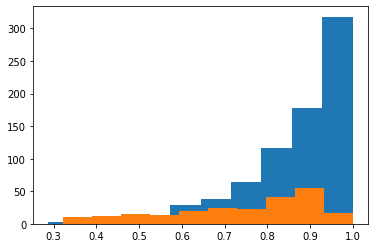

In [424]:
plt.hist(means)
plt.hist(attack_means)